# Test-time Training Exploration: Hindsight Experience Replay

## Goal

Can I solve tasks using test-time training?

I want to explore different TTT techniques such as hindsight experience replay and RL to see if a model can solve novel tasks that cannot be solve with the base model.

I have to focus on the techniques, not on efficiency.

## Imports

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from tqdm.auto import tqdm
from vllm import LLM, SamplingParams
from vllm.lora.request import LoRARequest
from transformers import AutoTokenizer, AutoConfig
import matplotlib.pyplot as plt
import matplotlib as mpl
from datasets import Dataset
from trl import SFTTrainer, DataCollatorForCompletionOnlyLM, SFTConfig
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel
import logging
from IPython.display import Markdown, display
import torch
import random

from arc25.training_tasks import *
from arc25.encoders import create_grid_encoder
from arc25.prompting import create_prompt_from_task, pretty_print_prompt
from arc25.plot import plot_task, plot_grids_with_shape, plot_grid
from arc25.code_execution import safe_code_execution, validate_code
from arc25.utils import set_random_seed
from arc25.logging import configure_logging, log_execution_time

configure_logging()

import sys
sys.path.append(os.path.realpath("../scripts"))
from finetuning import get_data_collator


plt.plot()
plt.close('all')
plt.rcParams["figure.figsize"] = (20, 5)
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['font.size'] = 12

INFO 05-07 15:13:39 [__init__.py:239] Automatically detected platform cuda.


## Code

In [2]:
EpochResults = namedtuple("EpochResults", ["best_prediction", 'pixel_accuracies'])

@log_execution_time
def hindsight_experience_replay(task, cfg):
    """
    Use hindsight experience replay to try to solve new tasks
    """
    plot_task(task); plt.suptitle('Task to solve'); plt.tight_layout(); plt.show()
    model, tokenizer = load_model(cfg.base_model_path, cfg.lora_path)
    metrics = []
    for epoch in range(cfg.max_epochs):
        logging.info(f'Starting epoch {epoch}...')
        new_tasks, pixel_accuracies = inference(
            task, model, tokenizer, cfg.grid_encoder, cfg.prompt_version,
            n_predictions=cfg.n_predictions)
        metrics.append(EpochResults(best_prediction=new_tasks[-1], pixel_accuracies=pixel_accuracies))
        plot_metrics_evolution(metrics)
        if np.max(pixel_accuracies) == 1:
            logger.info(f'Found a perfect prediction at epoch {epoch}!')
            break
        if not cfg.use_accuracy_for_sorting:
            logging.info('Shuffling the tasks, no information about the accuracy is used')
            random.shuffle(new_tasks)
        finetuning(new_tasks, model, tokenizer, cfg.grid_encoder, cfg.prompt_version)
    display(Markdown(f'# Best prediction code\n\n```python\n{metrics[-1].best_prediction.code}\n```'))
    return metrics

@log_execution_time
def load_model(base_model_path, lora_path):
    logging.info(f"Loading model from {base_model_path} and LoRA from {lora_path}")
    torch.cuda.empty_cache()
    model = AutoModelForCausalLM.from_pretrained(
        base_model_path, torch_dtype="auto", device_map="auto")
    tokenizer = AutoTokenizer.from_pretrained(lora_path)
    model = PeftModel.from_pretrained(model, lora_path, is_trainable=True)
    return model, tokenizer

@log_execution_time
def inference(task, model, tokenizer, grid_encoder, prompt_version, n_predictions=256):
    prompt = create_prompt_from_task(
        task, prompt_version=prompt_version, grid_encoder=grid_encoder, tokenizer=tokenizer, is_train_prompt=False)
    model_inputs = tokenizer([prompt], return_tensors="pt").to(model.device)

    generated_ids = model.generate(
        **model_inputs,
        max_new_tokens=1024,
        do_sample=True,
        temperature=0.5,
        top_p=0.95,
        num_return_sequences=n_predictions
    )
    generated_ids = generated_ids[:, len(model_inputs.input_ids[0]):]
    predictions = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

    predicted_codes = [prediction.replace('\n```', '') for prediction in predictions]
    new_tasks = []
    pixel_accuracies = []
    for predicted_code in tqdm(predicted_codes):
        try:
            predicted_output = safe_code_execution(predicted_code, task.inputs)
            validated_code = validate_code(predicted_code, task.inputs)
            new_tasks.append(Task(inputs=task.inputs, outputs=predicted_output, code=validated_code, name=task.name))
            pixel_accuracies.append(float(np.mean(new_tasks[-1].outputs[0] == task.outputs[0])))
        except Exception as e:
                print(f'Error executing code: {predicted_code}')
                print(e)

    new_tasks_with_unique_outputs = [new_tasks[0]]
    filtered_pixel_accuracies = []
    for new_task in new_tasks[1:]:
        if not any([np.all(new_task.outputs[0] == t.outputs[0]) for t in new_tasks_with_unique_outputs]):
            new_tasks_with_unique_outputs.append(new_task)
            filtered_pixel_accuracies.append(float(np.mean(new_task.outputs[0] == task.outputs[0])))
    logging.info(f'Number of unique outputs: {len(new_tasks_with_unique_outputs)}/{len(new_tasks)}')
    logging.info(f'Max pixel accuracy: {max(pixel_accuracies)}')
    new_tasks_with_unique_outputs = sorted(new_tasks_with_unique_outputs, key=lambda x: float(np.mean(x.outputs[0] == task.outputs[0])), reverse=False)
    return new_tasks_with_unique_outputs, pixel_accuracies

@log_execution_time
def finetuning(new_tasks, model, tokenizer, grid_encoder, prompt_version):
    prompts = []
    for task in new_tasks:
        prompts.append(create_prompt_from_task(
    task, prompt_version=prompt_version, grid_encoder=grid_encoder, tokenizer=tokenizer, is_train_prompt=True))
    train_dataset = Dataset.from_dict({'text': prompts})

    training_arguments = SFTConfig(
        output_dir=None, #'/mnt/hdd0/Kaggle/arc25/trainings/20250505_TTT/debug',
        save_strategy='no',
        num_train_epochs=1,
        warmup_ratio=0.1,
        learning_rate=1e-5,
        lr_scheduler_type='constant_with_warmup', #constant_with_warmup, cosine, cosine_with_restarts
        # lr_scheduler_kwargs=lr_scheduler_kwargs,
        gradient_checkpointing=False,
        optim="paged_adamw_8bit",
        max_grad_norm=1.0,

        dataset_text_field="text",
        max_seq_length=4096,

        do_eval=True,
        eval_strategy="no", #TODO: previously it was steps
        # save_steps=cfg.save_steps or cfg.eval_steps,
        logging_steps=10, #50,
        log_level="info",
        report_to='none',

        # parameters added to make the code work with accelerate
        # dispatch_batches=False,
        # https://huggingface.co/transformers/v4.9.1/main_classes/trainer.html#trainingarguments
        ddp_find_unused_parameters=False, # only used with accelerate, got a warning saying that it slows down if True

        ignore_data_skip=True, # otherwise it takes too long to start training when resuming from checkpoint

        per_device_train_batch_size=1,
        gradient_accumulation_steps=1,
    )

    trainer = SFTTrainer(
        model=model,
        processing_class=tokenizer,
        train_dataset=train_dataset,
        data_collator=get_data_collator(tokenizer),
        args=training_arguments,
    )
    trainer.train()


def plot_best_prediction(task, best_prediction, accuracy):
    plot_grids_with_shape(task.outputs + best_prediction.outputs, suptitle=f'Best prediction accuracy: {accuracy:.1%}')
    display(Markdown(f'```python\n{best_prediction.code}\n```'))


def plot_metrics_evolution(metrics):
    plot_score_histograms(metrics)

    for epoch, epoch_results in enumerate(metrics):
        plt.subplot(1, len(metrics), epoch + 1)
        plot_grid(epoch_results.best_prediction.outputs[0])
        plt.title(f'Epoch {epoch} acc: {max(epoch_results.pixel_accuracies):.1%}')
    plt.suptitle('Evolution of best predictions')
    plt.tight_layout()
    plt.show()


def plot_score_histograms(metrics, offset_scale=1):
    """
    Plots stacked (y-offset) histograms
    """
    cmap = mpl.colormaps['viridis']#get_cmap("viridis")
    norm = plt.Normalize(0, len(metrics) - 1)
    bins = np.linspace(0, 1, 100)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])

    plt.figure(figsize=(10, 6))
    for i, epoch_results in enumerate(metrics):
        color = cmap(norm(i))
        counts, _ = np.histogram(epoch_results.pixel_accuracies, bins=bins)
        counts = np.log1p(counts)
        offset = i * np.max(counts) * offset_scale  # Add spacing between histograms
        plt.fill_between(bin_centers, offset, counts + offset, color=color, label=f'Epoch {i}', alpha=0.5)

    plt.xlabel("Pixel accuracy")
    plt.ylabel("Epoch ->")
    plt.title("Evolution of pixel accuracy")
    plt.yticks([])  # Hide y-ticks since they don't represent absolute values
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

## First experiments

In [3]:
@dataclass
class Config:
    base_model_path: str = '/home/gbarbadillo/models/Qwen2.5-Coder-0.5B-Instruct'
    lora_path: str = '/mnt/hdd0/Kaggle/arc25/trainings/20250430_first_trainings/steps_6400/checkpoint-6400'
    prompt_version: str = 'code-from-examples-v3'
    grid_encoder = create_grid_encoder('GridShapeEncoder(RowNumberEncoder(MinimalGridEncoder()))')
    max_epochs: int = 10
    n_predictions: int = 256 # 256 seems to be the best for my hardware
    use_accuracy_for_sorting: bool = True

2025-05-07 15:13:42,214 - arc25.encoders - INFO - create_grid_encoder - Created `GridShapeEncoder(RowNumberEncoder(MinimalGridEncoder()))` as grid encoder


### Vertical lines

2025-05-07 13:33:47,261 - arc25.logging - INFO - wrapper - Executing hindsight_experience_replay...


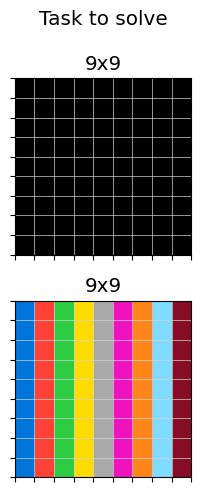

2025-05-07 13:33:47,466 - arc25.logging - INFO - wrapper - Executing load_model...
2025-05-07 13:33:47,467 - root - INFO - load_model - Loading model from /home/gbarbadillo/models/Qwen2.5-Coder-0.5B-Instruct and LoRA from /mnt/hdd0/Kaggle/arc25/trainings/20250430_first_trainings/steps_6400/checkpoint-6400
Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.
2025-05-07 13:33:47,841 - accelerate.utils.modeling - INFO - get_balanced_memory - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
2025-05-07 13:33:48,924 - arc25.logging - INFO - wrapper - Executed load_model in 1.4572 seconds
2025-05-07 13:33:48,925 - root - INFO - hindsight_experience_replay - Starting epoch 0...
2025-05-07 13:33:48,926 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 13:34:05,903 - root - INFO - inference - Number of unique outputs: 191/256
2025-05-07 13:34:05,905 - root - INFO - inference - Max pixel accuracy: 0.8888888888888888
2025-05-07 13:34:05,915 - arc25.logging - INFO - wrapper - Executed inference in 16.9877 seconds


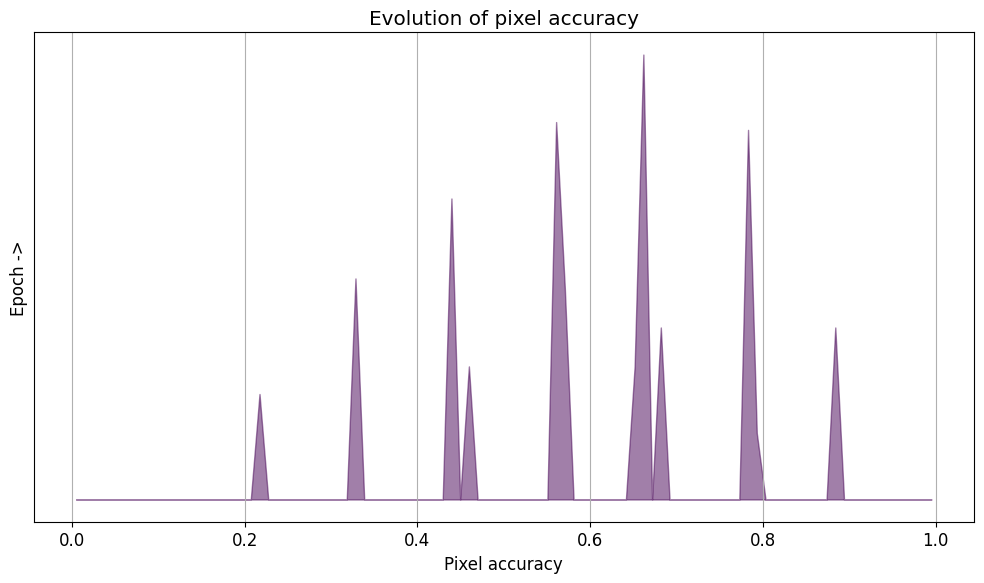

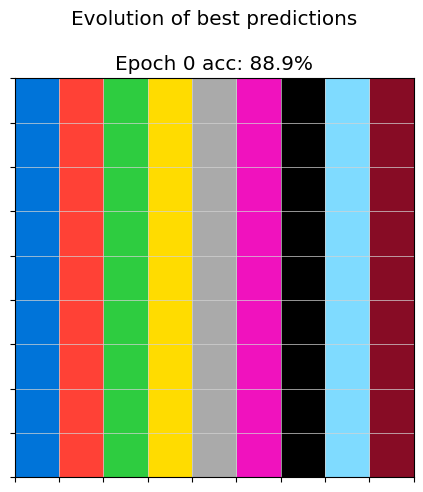

2025-05-07 13:34:06,136 - arc25.logging - INFO - wrapper - Executing finetuning...
2025-05-07 13:34:06,233 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/191 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/191 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/191 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/191 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 191
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 191
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 13:34:41,670 - arc25.logging - INFO - wrapper - Executed finetuning in 35.5336 seconds
2025-05-07 13:34:41,671 - root - INFO - hindsight_experience_replay - Starting epoch 1...
2025-05-07 13:34:41,671 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 13:35:01,278 - root - INFO - inference - Number of unique outputs: 71/256
2025-05-07 13:35:01,281 - root - INFO - inference - Max pixel accuracy: 1.0
2025-05-07 13:35:01,285 - arc25.logging - INFO - wrapper - Executed inference in 19.6132 seconds


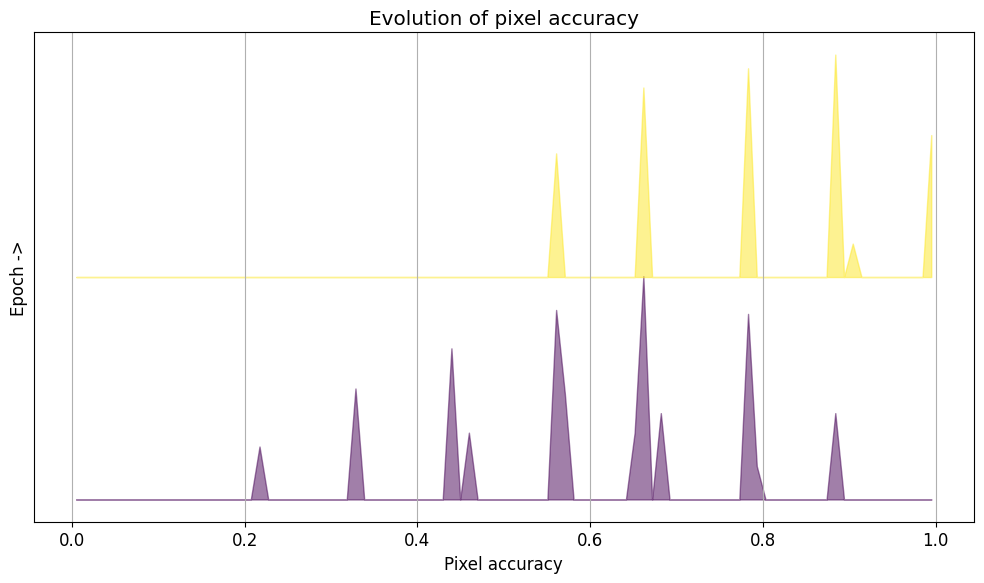

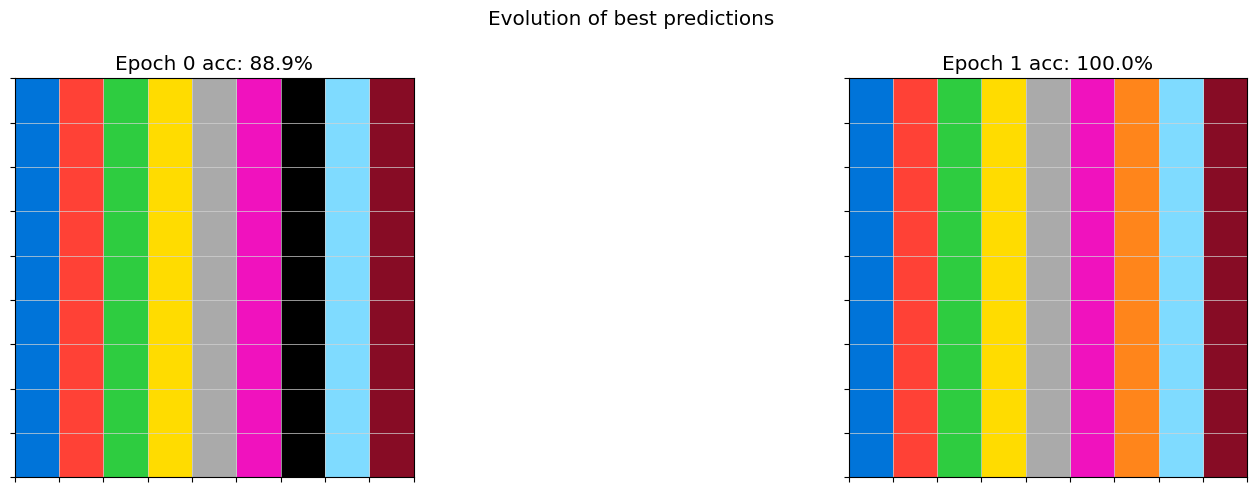

2025-05-07 13:35:01,521 - arc25.input_generation - INFO - hindsight_experience_replay - Found a perfect prediction at epoch 1!


# Best prediction code

```python
def task(img):
    draw_rectangle(img, point1=(0, 4), point2=(8, 8), color=8)
    draw_vertical_line(img, x=3, color=4)
    draw_vertical_line(img, x=1, color=2)
    draw_vertical_line(img, x=2, color=3)
    draw_vertical_line(img, x=4, color=5)
    draw_vertical_line(img, x=0, color=1)
    draw_vertical_line(img, x=5, color=6)
    draw_vertical_line(img, x=6, color=7)
    draw_vertical_line(img, x=8, color=9)
    return img
```

2025-05-07 13:35:01,578 - arc25.logging - INFO - wrapper - Executed hindsight_experience_replay in 74.3154 seconds


In [ ]:
input_img = create_img((9, 9), color=0)
output_img = input_img.copy()
for x in range(0, input_img.shape[1], 1):
    draw_vertical_line(output_img, x, color=x+1)

task = Task(inputs=[input_img], outputs=[output_img], code='', name='manual')
hindsight_experience_replay(task, Config());

### Squares

#### 9 squares

2025-05-07 13:35:01,617 - arc25.logging - INFO - wrapper - Executing hindsight_experience_replay...


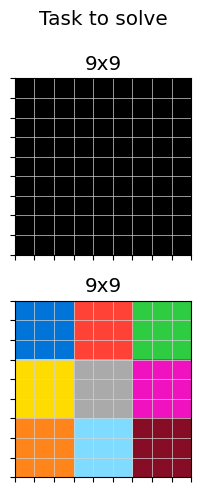

2025-05-07 13:35:01,773 - arc25.logging - INFO - wrapper - Executing load_model...
2025-05-07 13:35:01,774 - root - INFO - load_model - Loading model from /home/gbarbadillo/models/Qwen2.5-Coder-0.5B-Instruct and LoRA from /mnt/hdd0/Kaggle/arc25/trainings/20250430_first_trainings/steps_6400/checkpoint-6400
loading configuration file /home/gbarbadillo/models/Qwen2.5-Coder-0.5B-Instruct/config.json
Model config Qwen2Config {
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "eos_token_id": 151645,
  "hidden_act": "silu",
  "hidden_size": 896,
  "initializer_range": 0.02,
  "intermediate_size": 4864,
  "max_position_embeddings": 32768,
  "max_window_layers": 24,
  "model_type": "qwen2",
  "num_attention_heads": 14,
  "num_hidden_layers": 24,
  "num_key_value_heads": 2,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 1000000.0,
  "sliding_window": 32768,
  "tie_word_embeddings": true,
  "torch_dtype": "bfloat16",
  "tra

  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 13:35:30,106 - root - INFO - inference - Number of unique outputs: 255/256
2025-05-07 13:35:30,110 - root - INFO - inference - Max pixel accuracy: 0.8148148148148148
2025-05-07 13:35:30,113 - arc25.logging - INFO - wrapper - Executed inference in 27.1647 seconds


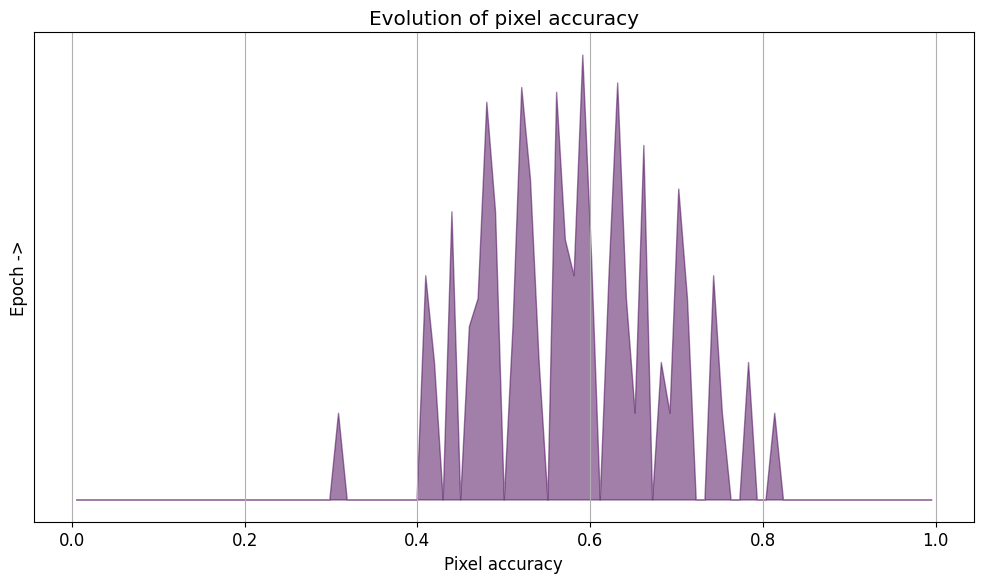

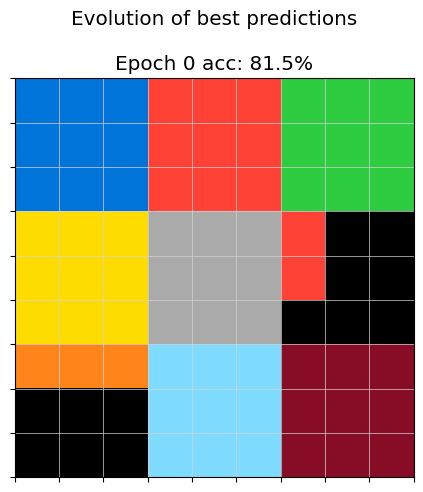

2025-05-07 13:35:30,332 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 13:35:30,450 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/255 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/255 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/255 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/255 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 255
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 255
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 13:36:20,751 - arc25.logging - INFO - wrapper - Executed finetuning in 50.4185 seconds
2025-05-07 13:36:20,753 - root - INFO - hindsight_experience_replay - Starting epoch 1...
2025-05-07 13:36:20,753 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 13:36:49,349 - root - INFO - inference - Number of unique outputs: 184/256
2025-05-07 13:36:49,352 - root - INFO - inference - Max pixel accuracy: 1.0
2025-05-07 13:36:49,355 - arc25.logging - INFO - wrapper - Executed inference in 28.6011 seconds


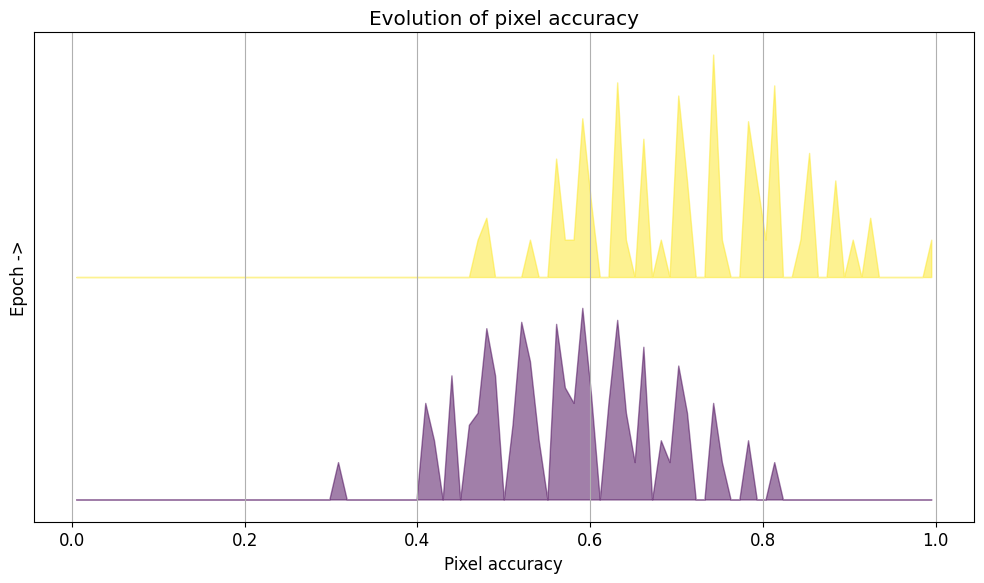

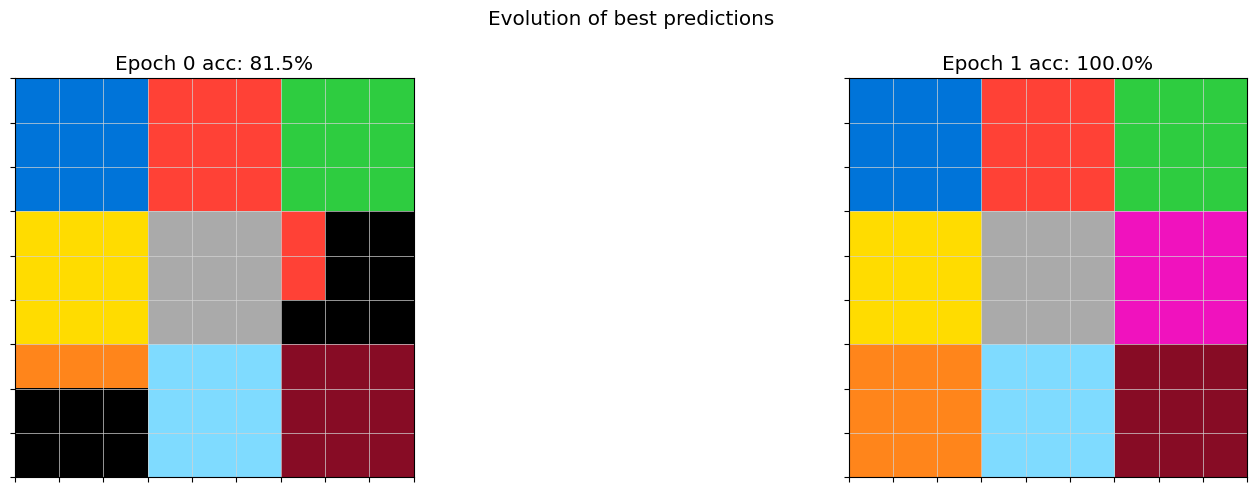

2025-05-07 13:36:49,708 - arc25.input_generation - INFO - hindsight_experience_replay - Found a perfect prediction at epoch 1!


# Best prediction code

```python
def task(img):
    draw_rectangle(img, point1=(0, 0), point2=(2, 8), color=1)
    draw_rectangle(img, point1=(3, 3), point2=(5, 8), color=5)
    draw_rectangle(img, point1=(0, 6), point2=(2, 8), color=3)
    draw_rectangle(img, point1=(6, 5), point2=(8, 8), color=9)
    draw_rectangle(img, point1=(0, 3), point2=(2, 5), color=2)
    draw_rectangle(img, point1=(3, 0), point2=(5, 2), color=4)
    draw_rectangle(img, point1=(6, 3), point2=(8, 5), color=8)
    draw_rectangle(img, point1=(3, 6), point2=(5, 8), color=6)
    draw_rectangle(img, point1=(6, 0), point2=(8, 2), color=7)
    return img
```

2025-05-07 13:36:49,774 - arc25.logging - INFO - wrapper - Executed hindsight_experience_replay in 108.1556 seconds


In [ ]:
input_img = create_img((9, 9), color=0)
output_img = input_img.copy()
color = 0
for x in range(0, input_img.shape[1], 3):
    for y in range(0, input_img.shape[0], 3):
        color += 1
        draw_rectangle(output_img, (x, y), (x+2, y+2), color=color)
task = Task(inputs=[input_img], outputs=[output_img], code='', name='manual')
metrics = hindsight_experience_replay(task, Config())

#### 16 squares

2025-05-07 13:36:49,823 - arc25.logging - INFO - wrapper - Executing hindsight_experience_replay...


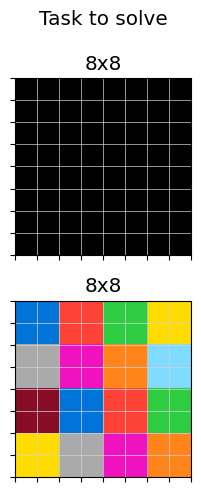

2025-05-07 13:36:49,957 - arc25.logging - INFO - wrapper - Executing load_model...
2025-05-07 13:36:49,958 - root - INFO - load_model - Loading model from /home/gbarbadillo/models/Qwen2.5-Coder-0.5B-Instruct and LoRA from /mnt/hdd0/Kaggle/arc25/trainings/20250430_first_trainings/steps_6400/checkpoint-6400
loading configuration file /home/gbarbadillo/models/Qwen2.5-Coder-0.5B-Instruct/config.json
Model config Qwen2Config {
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "eos_token_id": 151645,
  "hidden_act": "silu",
  "hidden_size": 896,
  "initializer_range": 0.02,
  "intermediate_size": 4864,
  "max_position_embeddings": 32768,
  "max_window_layers": 24,
  "model_type": "qwen2",
  "num_attention_heads": 14,
  "num_hidden_layers": 24,
  "num_key_value_heads": 2,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 1000000.0,
  "sliding_window": 32768,
  "tie_word_embeddings": true,
  "torch_dtype": "bfloat16",
  "tra

  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 13:37:20,572 - root - INFO - inference - Number of unique outputs: 256/256
2025-05-07 13:37:20,576 - root - INFO - inference - Max pixel accuracy: 0.640625
2025-05-07 13:37:20,593 - arc25.logging - INFO - wrapper - Executed inference in 29.5006 seconds


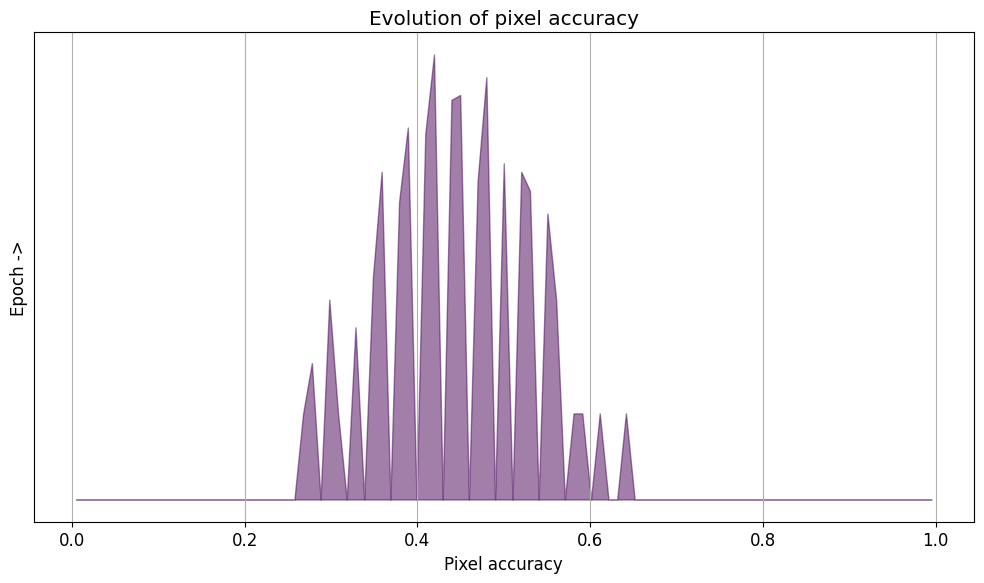

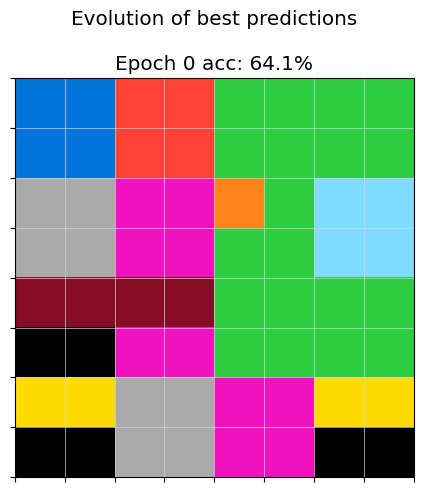

2025-05-07 13:37:20,766 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 13:37:20,870 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/256 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 256
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 256
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 13:38:10,440 - arc25.logging - INFO - wrapper - Executed finetuning in 49.6729 seconds
2025-05-07 13:38:10,441 - root - INFO - hindsight_experience_replay - Starting epoch 1...
2025-05-07 13:38:10,442 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 13:38:47,775 - root - INFO - inference - Number of unique outputs: 252/256
2025-05-07 13:38:47,778 - root - INFO - inference - Max pixel accuracy: 0.78125
2025-05-07 13:38:47,783 - arc25.logging - INFO - wrapper - Executed inference in 37.3403 seconds


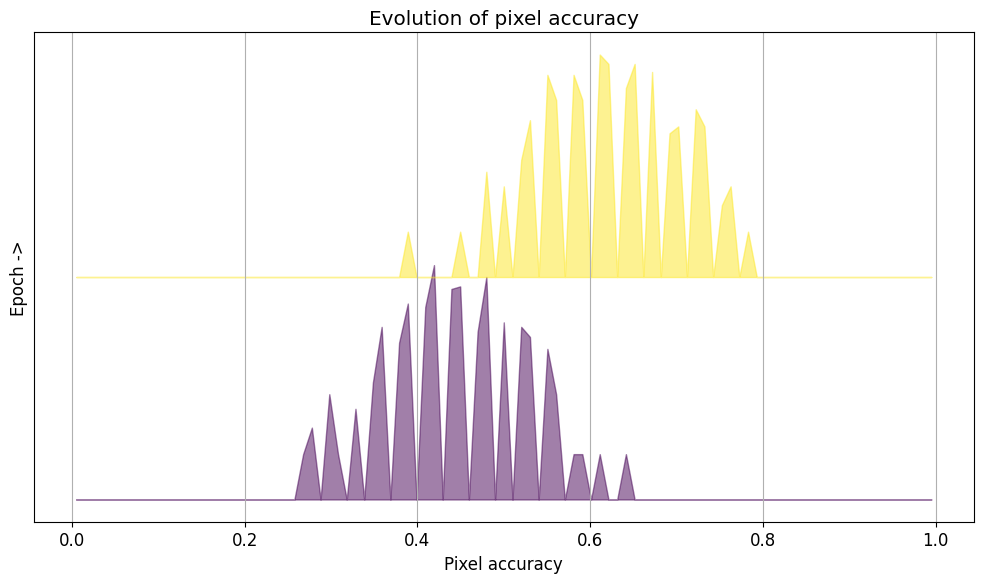

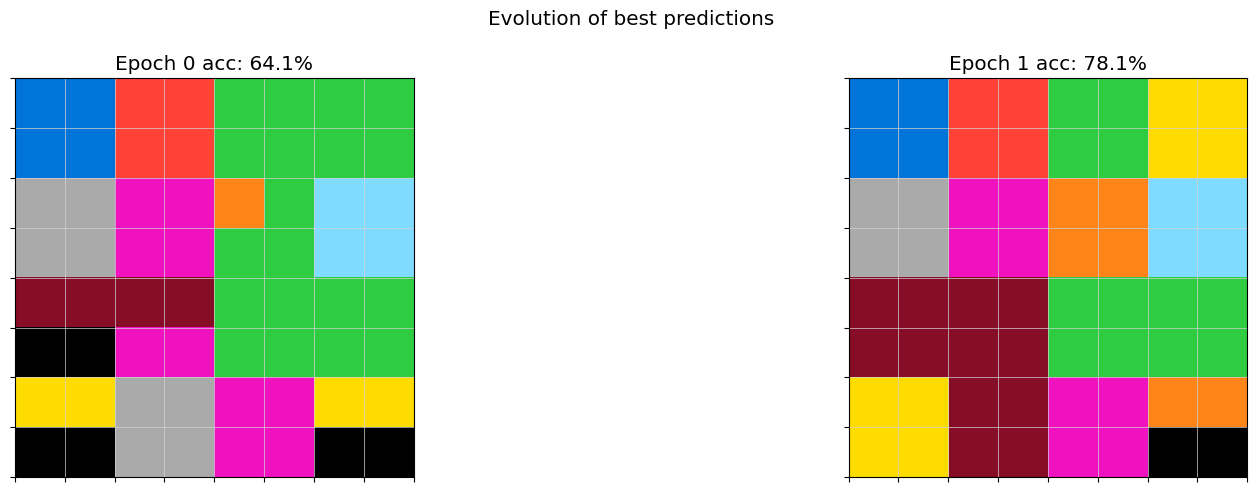

2025-05-07 13:38:48,034 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 13:38:48,134 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/252 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/252 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/252 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/252 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 252
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 252
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 13:39:37,123 - arc25.logging - INFO - wrapper - Executed finetuning in 49.0877 seconds
2025-05-07 13:39:37,124 - root - INFO - hindsight_experience_replay - Starting epoch 2...
2025-05-07 13:39:37,125 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 13:40:18,969 - root - INFO - inference - Number of unique outputs: 181/256
2025-05-07 13:40:18,976 - root - INFO - inference - Max pixel accuracy: 0.859375
2025-05-07 13:40:18,979 - arc25.logging - INFO - wrapper - Executed inference in 41.8526 seconds


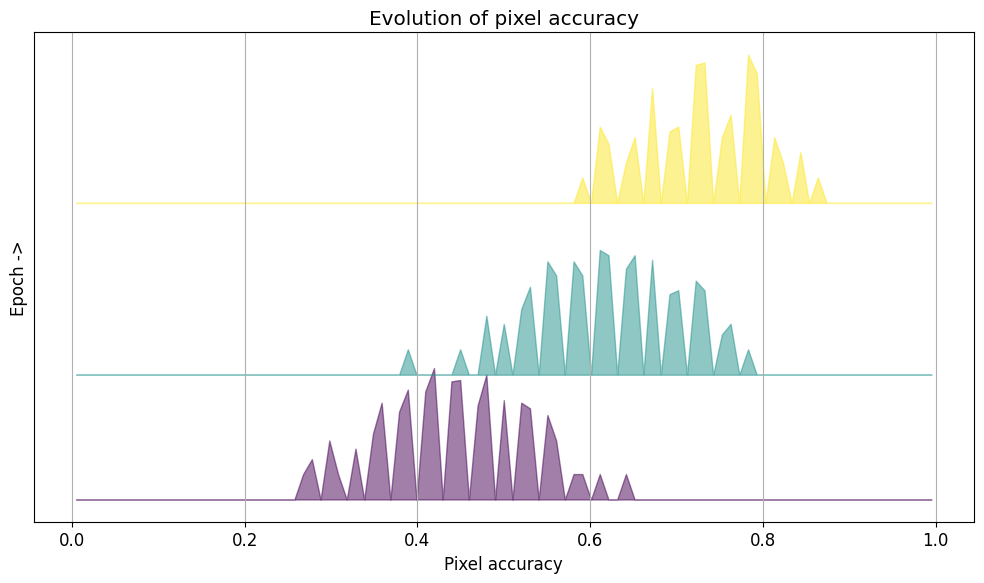

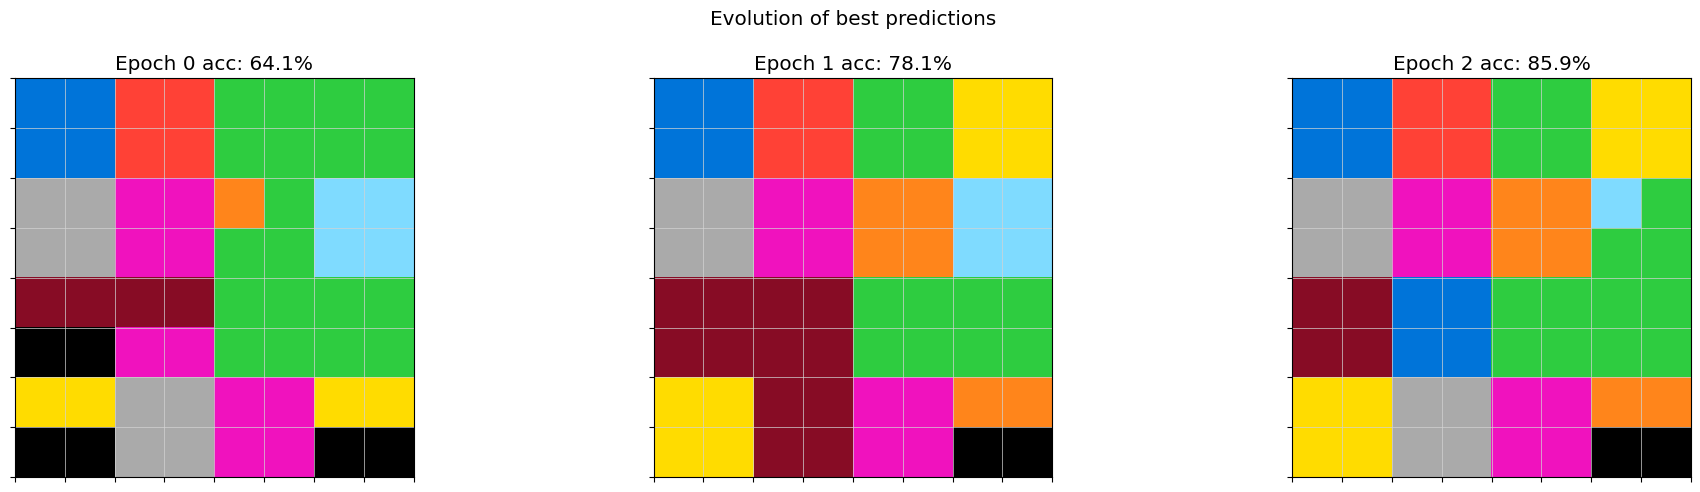

2025-05-07 13:40:19,313 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 13:40:19,387 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/181 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/181 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/181 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/181 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 181
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 181
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 13:40:54,291 - arc25.logging - INFO - wrapper - Executed finetuning in 34.9773 seconds
2025-05-07 13:40:54,293 - root - INFO - hindsight_experience_replay - Starting epoch 3...
2025-05-07 13:40:54,293 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 13:41:37,546 - root - INFO - inference - Number of unique outputs: 97/256
2025-05-07 13:41:37,553 - root - INFO - inference - Max pixel accuracy: 0.921875
2025-05-07 13:41:37,562 - arc25.logging - INFO - wrapper - Executed inference in 43.2679 seconds


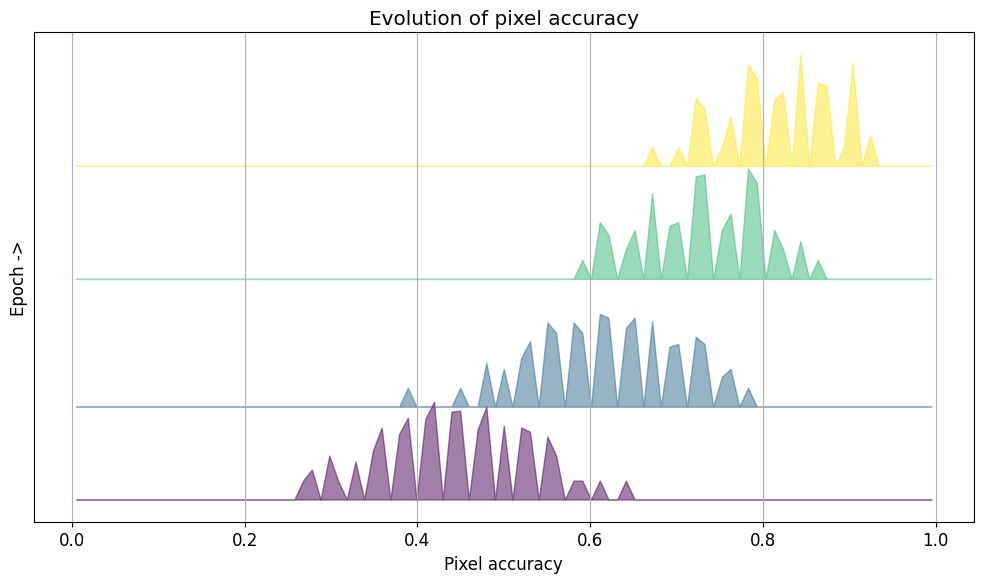

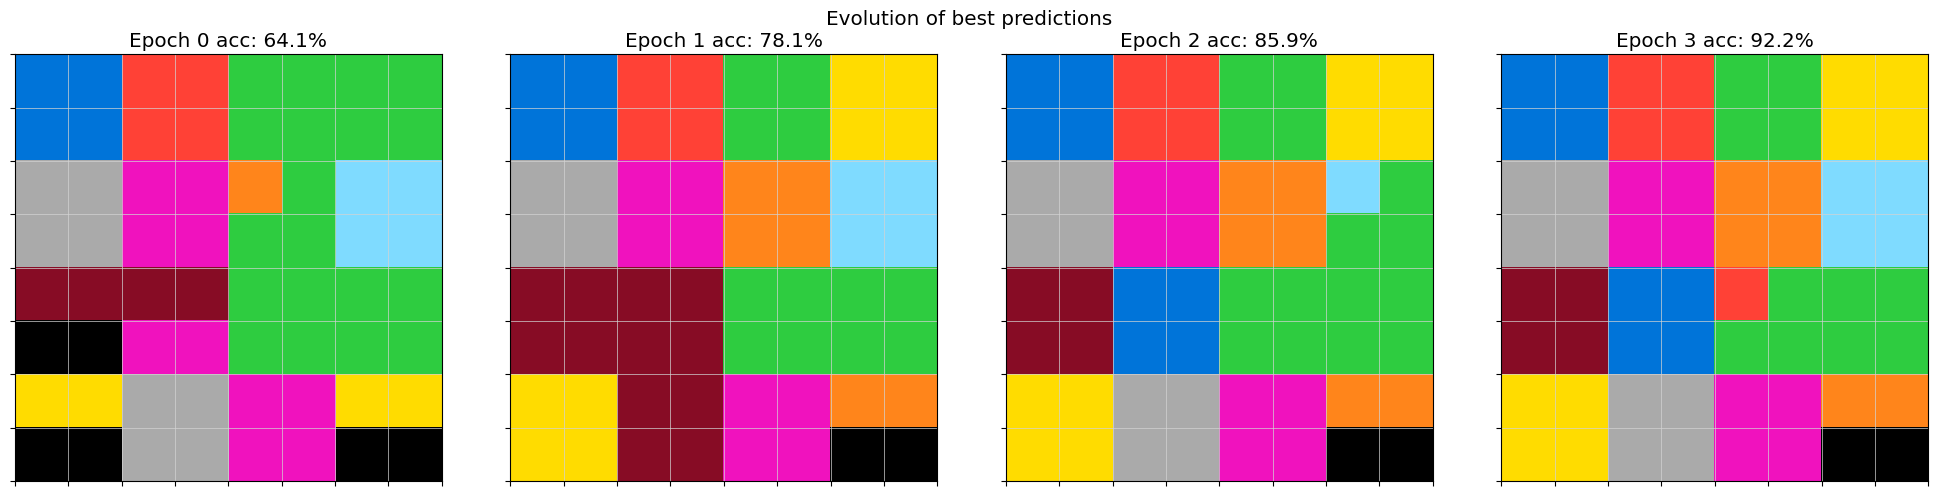

2025-05-07 13:41:37,941 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 13:41:38,017 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/97 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/97 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/97 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/97 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 97
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 97
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 13:41:56,045 - arc25.logging - INFO - wrapper - Executed finetuning in 18.1025 seconds
2025-05-07 13:41:56,046 - root - INFO - hindsight_experience_replay - Starting epoch 4...
2025-05-07 13:41:56,047 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 13:42:44,993 - root - INFO - inference - Number of unique outputs: 99/256
2025-05-07 13:42:45,003 - root - INFO - inference - Max pixel accuracy: 1.0
2025-05-07 13:42:45,022 - arc25.logging - INFO - wrapper - Executed inference in 48.9726 seconds


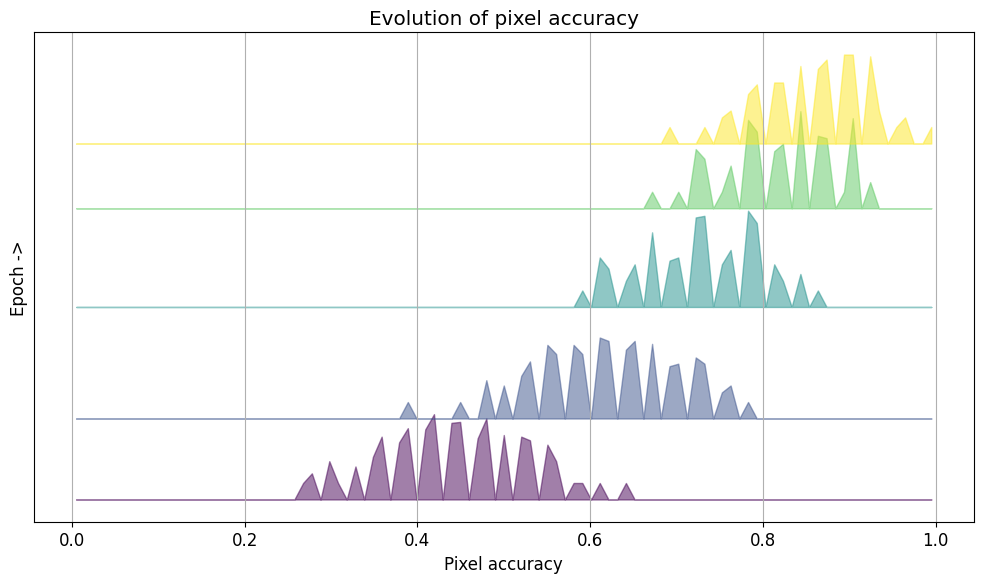

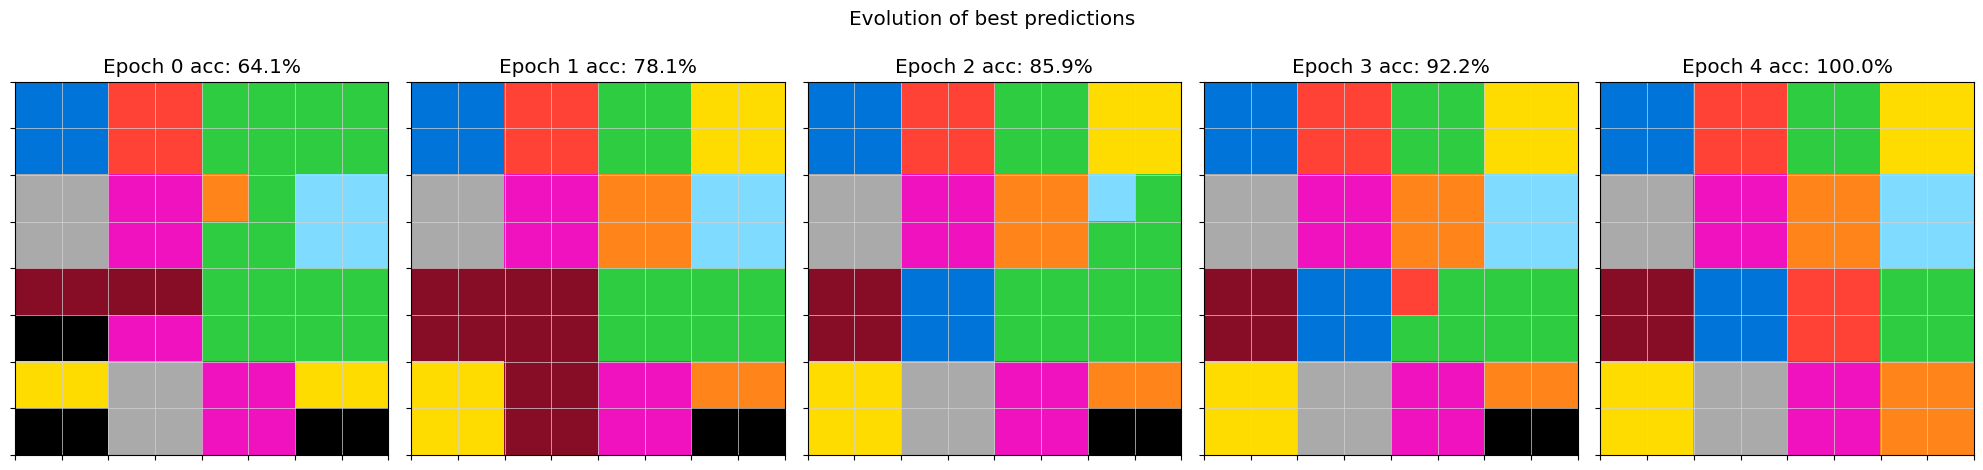

2025-05-07 13:42:45,460 - arc25.input_generation - INFO - hindsight_experience_replay - Found a perfect prediction at epoch 4!


# Best prediction code

```python
def task(img):
    draw_rectangle(img, point1=(0, 0), point2=(1, 7), color=1)
    draw_rectangle(img, point1=(0, 2), point2=(5, 5), color=2)
    draw_rectangle(img, point1=(0, 4), point2=(5, 7), color=3)
    draw_rectangle(img, point1=(6, 2), point2=(7, 5), color=6)
    draw_rectangle(img, point1=(6, 0), point2=(7, 3), color=4)
    draw_rectangle(img, point1=(2, 0), point2=(3, 3), color=5)
    draw_rectangle(img, point1=(4, 2), point2=(5, 3), color=1)
    draw_rectangle(img, point1=(6, 2), point2=(7, 3), color=5)
    draw_rectangle(img, point1=(2, 4), point2=(3, 5), color=7)
    draw_rectangle(img, point1=(0, 6), point2=(1, 7), color=4)
    draw_rectangle(img, point1=(2, 2), point2=(3, 3), color=6)
    draw_rectangle(img, point1=(6, 6), point2=(7, 7), color=7)
    draw_rectangle(img, point1=(4, 0), point2=(5, 1), color=9)
    draw_rectangle(img, point1=(4, 4), point2=(5, 5), color=2)
    draw_rectangle(img, point1=(2, 6), point2=(3, 7), color=8)
    return img
```

2025-05-07 13:42:45,509 - arc25.logging - INFO - wrapper - Executed hindsight_experience_replay in 355.6839 seconds


In [ ]:
input_img = create_img((8, 8), color=0)
output_img = input_img.copy()
color = 0
for x in range(0, input_img.shape[1], 2):
    for y in range(0, input_img.shape[0], 2):
        color = (color + 1) % 10
        if color == 0: color = 1
        draw_rectangle(output_img, (x, y), (x+1, y+1), color=color)
task = Task(inputs=[input_img], outputs=[output_img], code='', name='manual')
metrics = hindsight_experience_replay(task, Config())

#### 20 squares

2025-05-07 13:42:45,534 - arc25.logging - INFO - wrapper - Executing hindsight_experience_replay...


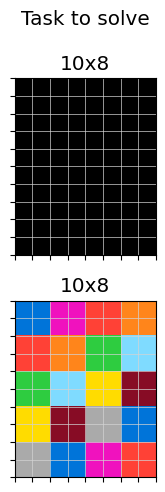

2025-05-07 13:42:45,682 - arc25.logging - INFO - wrapper - Executing load_model...
2025-05-07 13:42:45,682 - root - INFO - load_model - Loading model from /home/gbarbadillo/models/Qwen2.5-Coder-0.5B-Instruct and LoRA from /mnt/hdd0/Kaggle/arc25/trainings/20250430_first_trainings/steps_6400/checkpoint-6400
loading configuration file /home/gbarbadillo/models/Qwen2.5-Coder-0.5B-Instruct/config.json
Model config Qwen2Config {
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "eos_token_id": 151645,
  "hidden_act": "silu",
  "hidden_size": 896,
  "initializer_range": 0.02,
  "intermediate_size": 4864,
  "max_position_embeddings": 32768,
  "max_window_layers": 24,
  "model_type": "qwen2",
  "num_attention_heads": 14,
  "num_hidden_layers": 24,
  "num_key_value_heads": 2,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 1000000.0,
  "sliding_window": 32768,
  "tie_word_embeddings": true,
  "torch_dtype": "bfloat16",
  "tra

  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 13:43:26,477 - root - INFO - inference - Number of unique outputs: 255/255
2025-05-07 13:43:26,483 - root - INFO - inference - Max pixel accuracy: 0.55
2025-05-07 13:43:26,487 - arc25.logging - INFO - wrapper - Executed inference in 39.7121 seconds


Error executing code: def task(img):
    draw_rectangle(img, point1=(8, 0), point2=(9, 2), color=5)
    draw_horizontal_line(img, y=4, y2=5, color=3)
    draw_vertical_line(img, x=2, color=1)
    draw_rectangle(img, point1=(0, 4), point2=(9, 7), color=2)
    draw_rectangle(img, point1=(0, 1), point2=(9, 3), color=6)
    draw_rectangle(img, point1=(2, 0), point2=(3, 4), color=2)
    draw_rectangle(img, point1=(4, 4), point2=(5, 5), color=4)
    draw_rectangle(img, point1=(6, 2), point2=(9, 3), color=9)
    draw_pixel(img, point=(6, 6), color=8)
    draw_rectangle(img, point1=(0, 0), point2=(1, 1), color=1)
    draw_rectangle(img, point1=(4, 0), point2=(5, 1), color=3)
    return img
draw_horizontal_line() got an unexpected keyword argument 'y2'


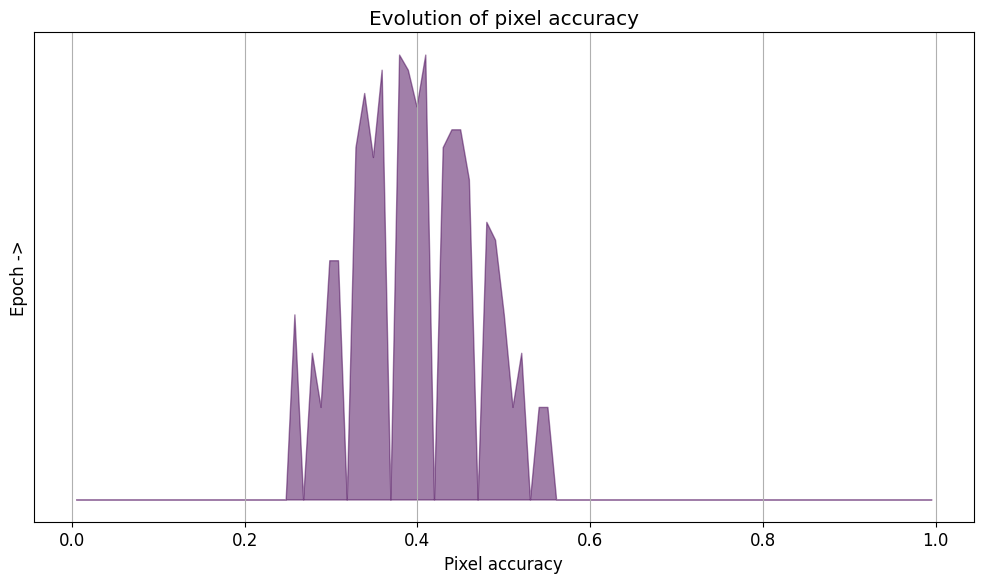

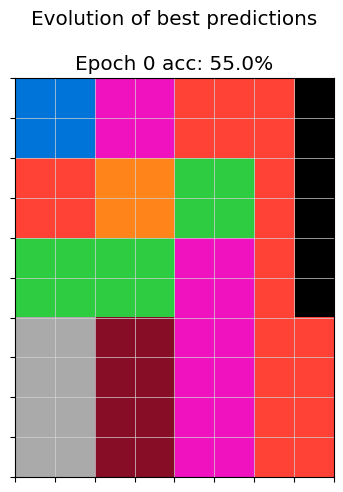

2025-05-07 13:43:26,665 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 13:43:26,739 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/255 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/255 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/255 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/255 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 255
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 255
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 13:44:14,104 - arc25.logging - INFO - wrapper - Executed finetuning in 47.4381 seconds
2025-05-07 13:44:14,106 - root - INFO - hindsight_experience_replay - Starting epoch 1...
2025-05-07 13:44:14,107 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 13:45:05,015 - root - INFO - inference - Number of unique outputs: 254/256
2025-05-07 13:45:05,022 - root - INFO - inference - Max pixel accuracy: 0.775
2025-05-07 13:45:05,025 - arc25.logging - INFO - wrapper - Executed inference in 50.9174 seconds


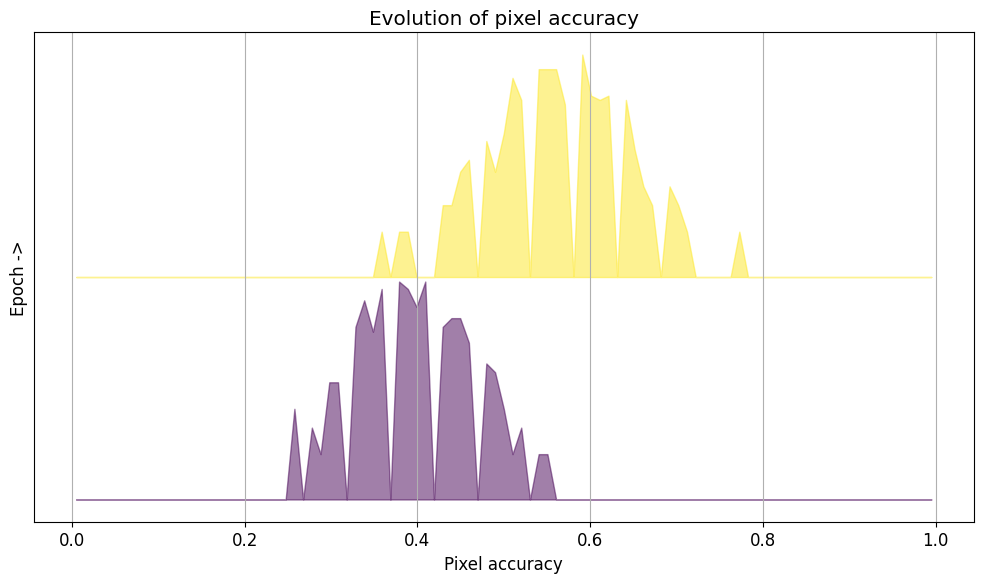

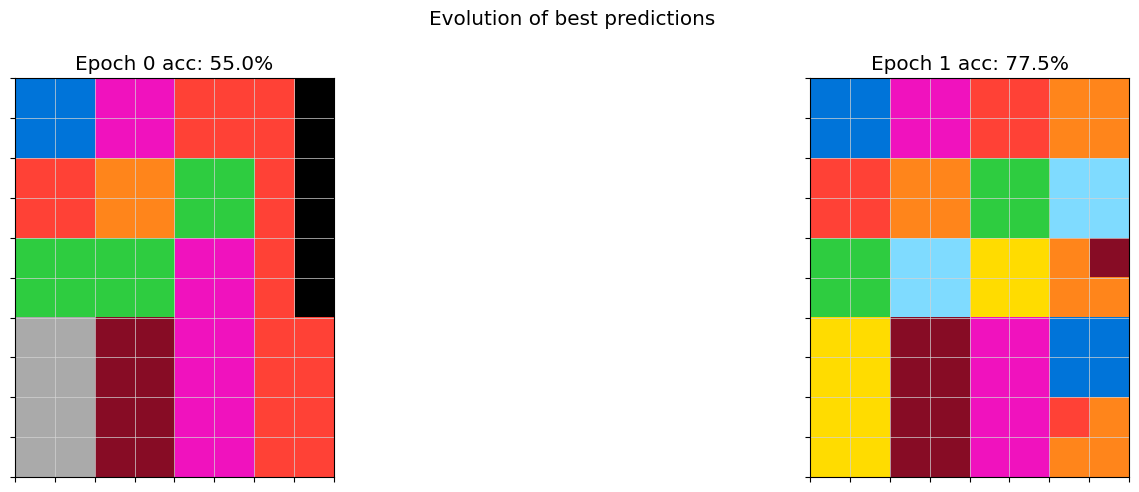

2025-05-07 13:45:05,260 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 13:45:05,346 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/254 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/254 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/254 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/254 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 254
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 254
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 13:45:52,686 - arc25.logging - INFO - wrapper - Executed finetuning in 47.4256 seconds
2025-05-07 13:45:52,689 - root - INFO - hindsight_experience_replay - Starting epoch 2...
2025-05-07 13:45:52,689 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 13:47:01,693 - root - INFO - inference - Number of unique outputs: 255/256
2025-05-07 13:47:01,697 - root - INFO - inference - Max pixel accuracy: 0.85
2025-05-07 13:47:01,705 - arc25.logging - INFO - wrapper - Executed inference in 69.0144 seconds


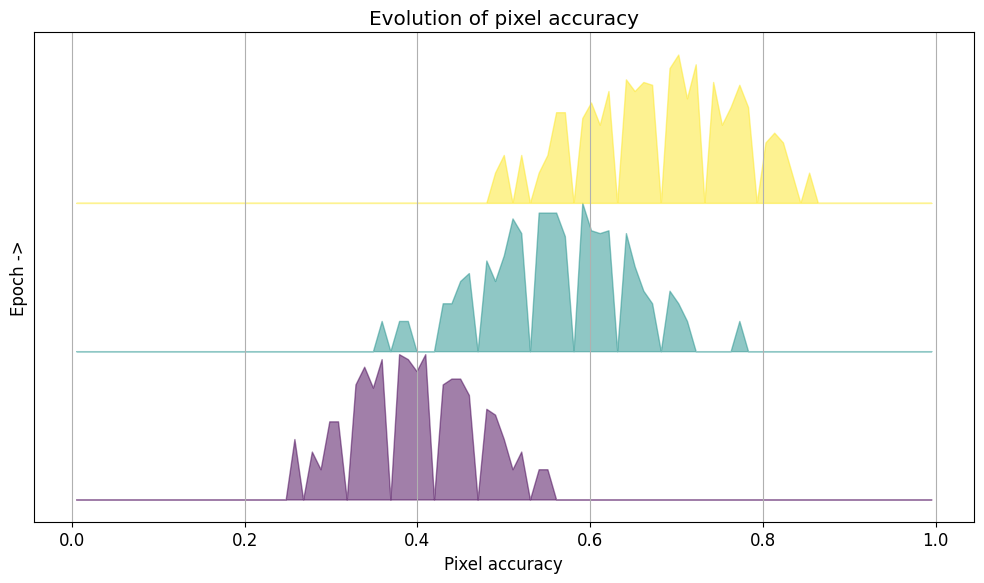

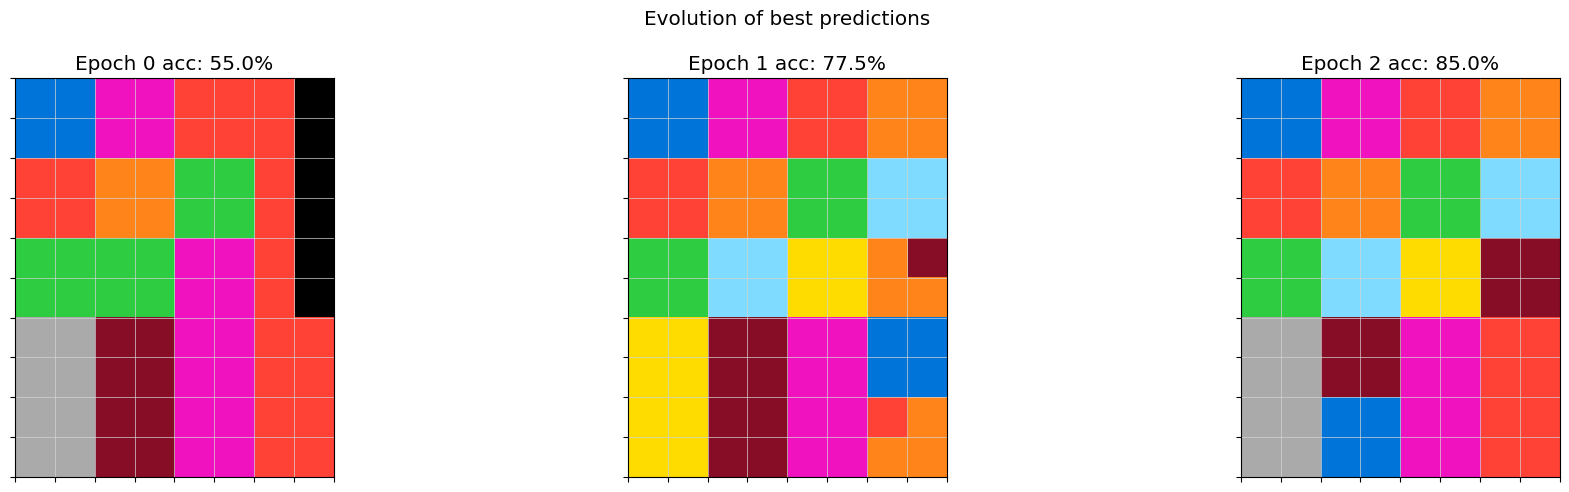

2025-05-07 13:47:01,996 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 13:47:02,082 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/255 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/255 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/255 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/255 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 255
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 255
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 13:47:47,256 - arc25.logging - INFO - wrapper - Executed finetuning in 45.2594 seconds
2025-05-07 13:47:47,257 - root - INFO - hindsight_experience_replay - Starting epoch 3...
2025-05-07 13:47:47,258 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 13:48:44,967 - root - INFO - inference - Number of unique outputs: 210/256
2025-05-07 13:48:44,976 - root - INFO - inference - Max pixel accuracy: 0.9
2025-05-07 13:48:45,000 - arc25.logging - INFO - wrapper - Executed inference in 57.7413 seconds


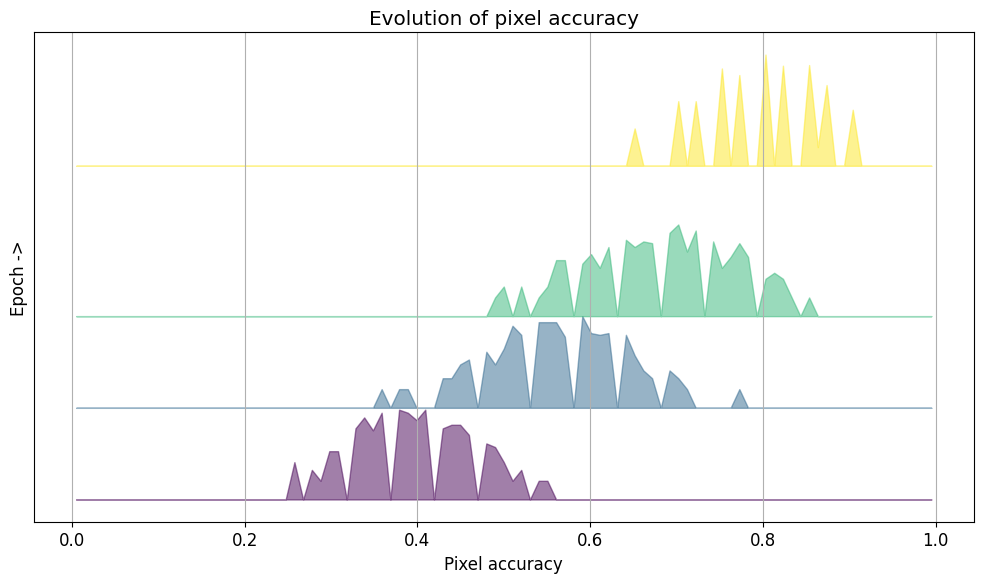

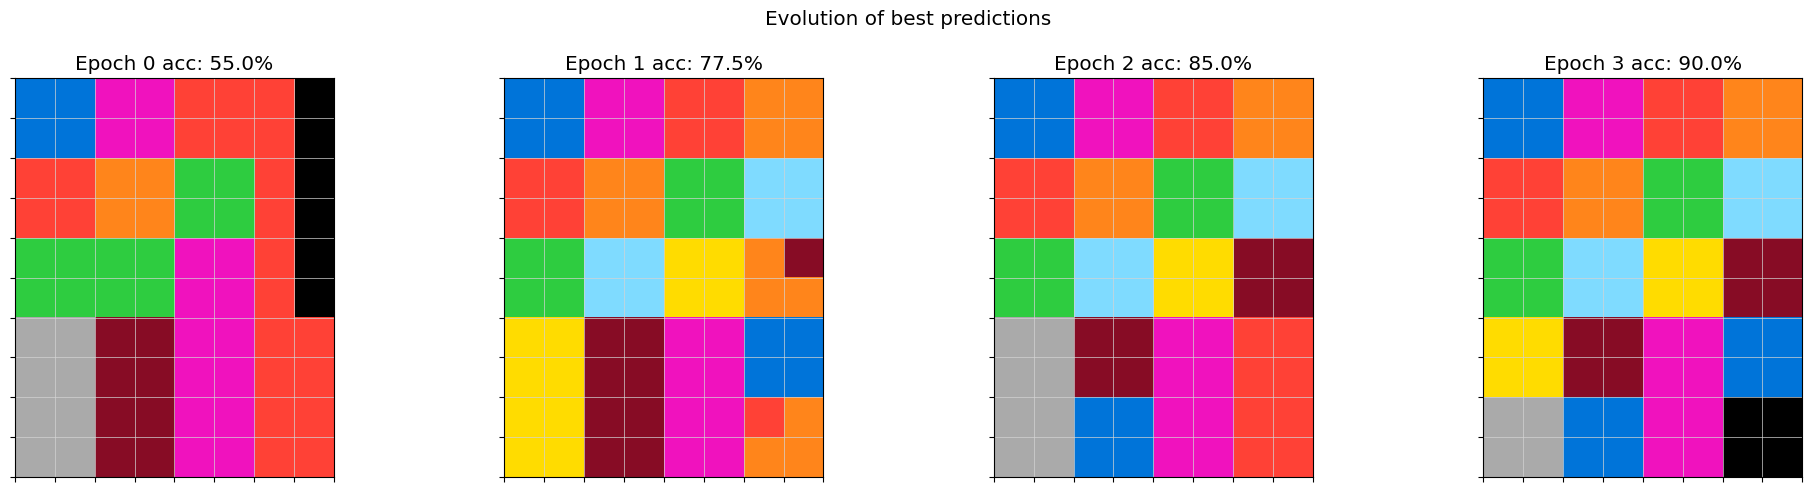

2025-05-07 13:48:45,377 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 13:48:45,447 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/210 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/210 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/210 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/210 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 210
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 210
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 13:49:25,494 - arc25.logging - INFO - wrapper - Executed finetuning in 40.1164 seconds
2025-05-07 13:49:25,496 - root - INFO - hindsight_experience_replay - Starting epoch 4...
2025-05-07 13:49:25,497 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 13:50:26,893 - root - INFO - inference - Number of unique outputs: 97/256
2025-05-07 13:50:26,905 - root - INFO - inference - Max pixel accuracy: 0.95
2025-05-07 13:50:26,908 - arc25.logging - INFO - wrapper - Executed inference in 61.4103 seconds


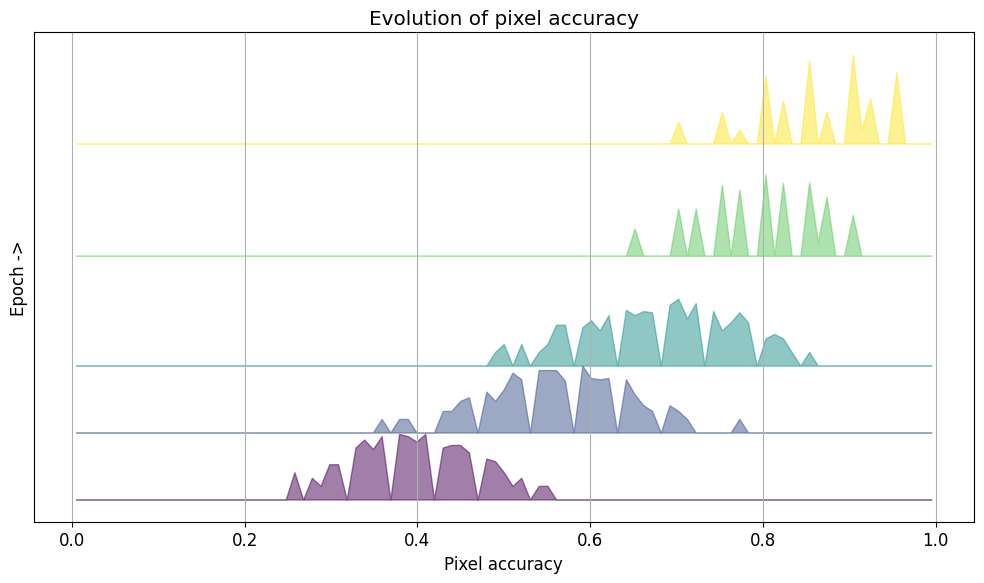

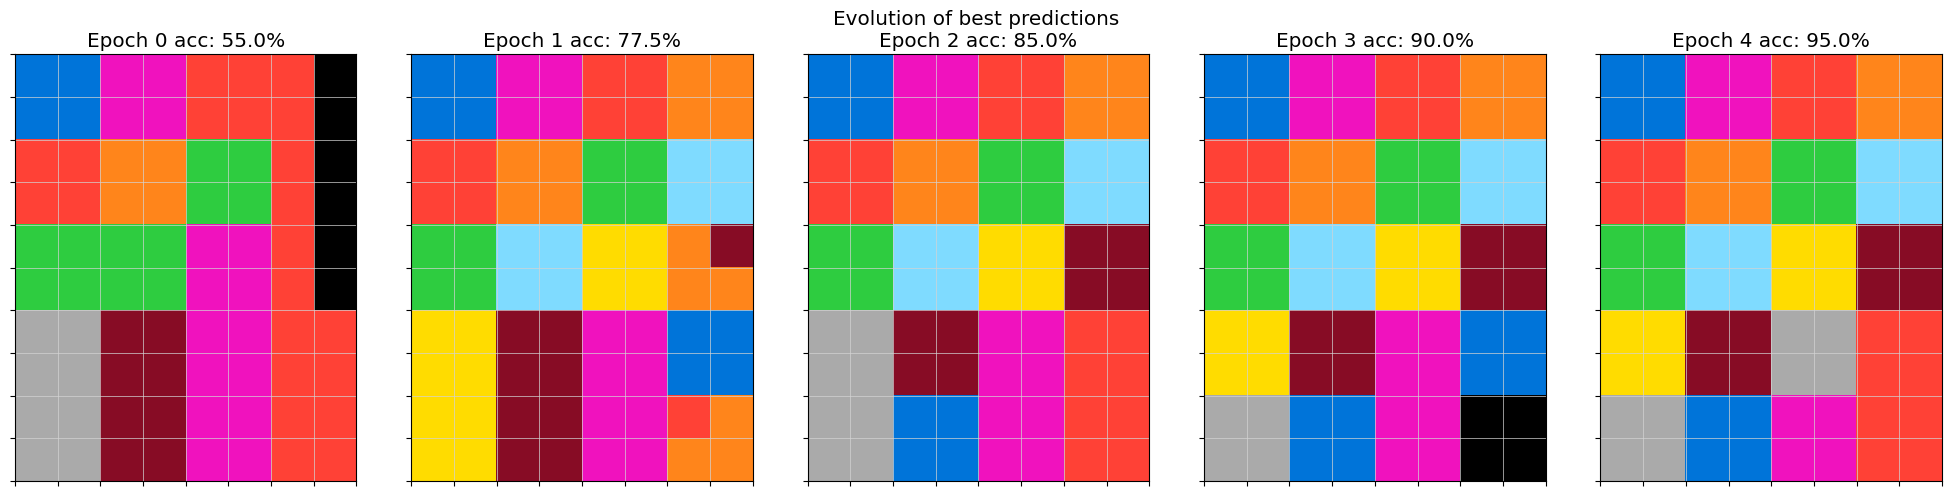

2025-05-07 13:50:27,343 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 13:50:27,404 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/97 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/97 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/97 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/97 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 97
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 97
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 13:50:46,638 - arc25.logging - INFO - wrapper - Executed finetuning in 19.2949 seconds
2025-05-07 13:50:46,639 - root - INFO - hindsight_experience_replay - Starting epoch 5...
2025-05-07 13:50:46,640 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 13:51:52,167 - root - INFO - inference - Number of unique outputs: 34/256
2025-05-07 13:51:52,171 - root - INFO - inference - Max pixel accuracy: 1.0
2025-05-07 13:51:52,178 - arc25.logging - INFO - wrapper - Executed inference in 65.5375 seconds


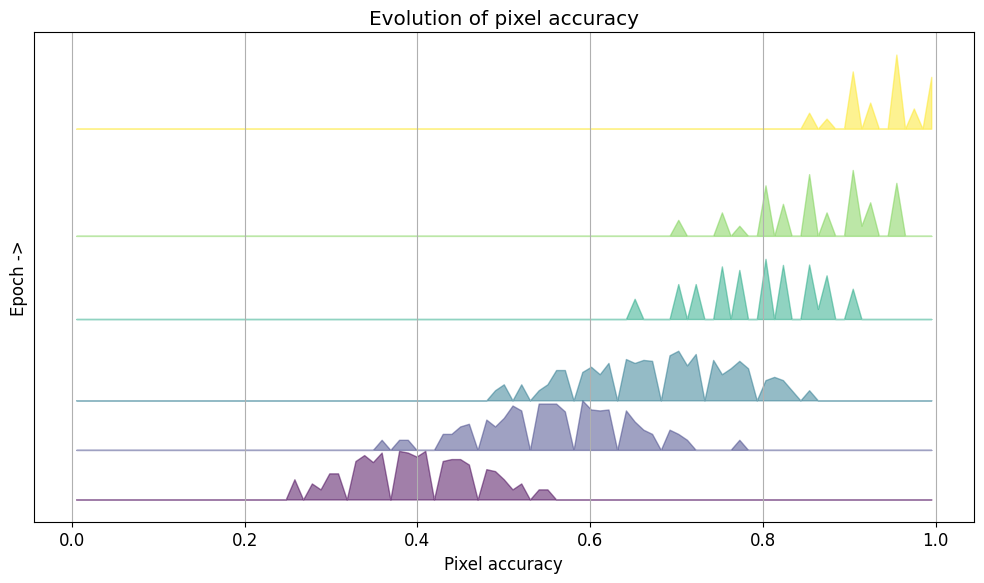

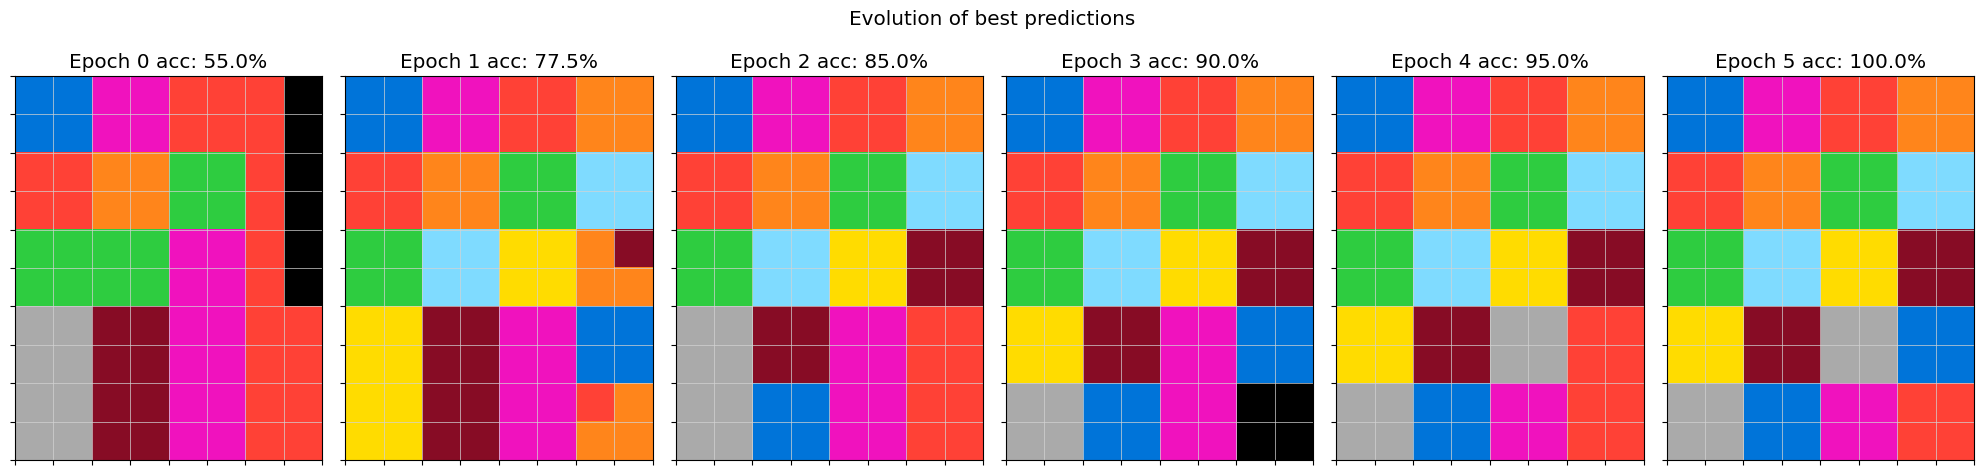

2025-05-07 13:51:52,675 - arc25.input_generation - INFO - hindsight_experience_replay - Found a perfect prediction at epoch 5!


# Best prediction code

```python
def task(img):
    draw_rectangle(img, point1=(0, 0), point2=(1, 7), color=1)
    draw_rectangle(img, point1=(0, 2), point2=(9, 5), color=6)
    draw_rectangle(img, point1=(0, 4), point2=(1, 7), color=2)
    draw_rectangle(img, point1=(2, 0), point2=(3, 1), color=2)
    draw_rectangle(img, point1=(2, 4), point2=(5, 5), color=3)
    draw_rectangle(img, point1=(4, 0), point2=(5, 1), color=3)
    draw_rectangle(img, point1=(6, 2), point2=(7, 3), color=9)
    draw_rectangle(img, point1=(6, 6), point2=(9, 7), color=2)
    draw_rectangle(img, point1=(2, 2), point2=(3, 3), color=7)
    draw_rectangle(img, point1=(4, 4), point2=(5, 5), color=4)
    draw_rectangle(img, point1=(6, 0), point2=(7, 1), color=4)
    draw_rectangle(img, point1=(6, 4), point2=(7, 5), color=5)
    draw_rectangle(img, point1=(8, 2), point2=(9, 3), color=1)
    draw_rectangle(img, point1=(2, 6), point2=(3, 7), color=8)
    draw_rectangle(img, point1=(4, 2), point2=(5, 3), color=8)
    draw_rectangle(img, point1=(6, 6), point2=(7, 7), color=1)
    draw_rectangle(img, point1=(0, 6), point2=(1, 7), color=7)
    draw_rectangle(img, point1=(8, 0), point2=(9, 1), color=5)
    draw_rectangle(img, point1=(4, 6), point2=(5, 7), color=9)
    return img
```

2025-05-07 13:51:52,725 - arc25.logging - INFO - wrapper - Executed hindsight_experience_replay in 547.1888 seconds


In [ ]:
input_img = create_img((10, 8), color=0)
output_img = input_img.copy()
color = 0
for x in range(0, input_img.shape[1], 2):
    for y in range(0, input_img.shape[0], 2):
        color = (color + 1) % 10
        if color == 0: color = 1
        draw_rectangle(output_img, (y, x), (y+1, x+1), color=color)
task = Task(inputs=[input_img], outputs=[output_img], code='', name='manual')
metrics = hindsight_experience_replay(task, Config())

#### 25 squares

2025-05-07 13:51:52,766 - arc25.logging - INFO - wrapper - Executing hindsight_experience_replay...


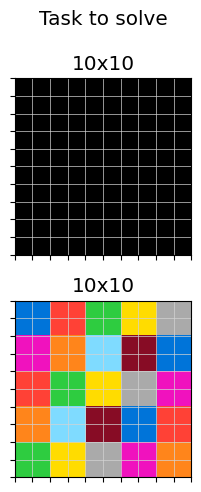

2025-05-07 13:51:52,954 - arc25.logging - INFO - wrapper - Executing load_model...
2025-05-07 13:51:52,954 - root - INFO - load_model - Loading model from /home/gbarbadillo/models/Qwen2.5-Coder-0.5B-Instruct and LoRA from /mnt/hdd0/Kaggle/arc25/trainings/20250430_first_trainings/steps_6400/checkpoint-6400
loading configuration file /home/gbarbadillo/models/Qwen2.5-Coder-0.5B-Instruct/config.json
Model config Qwen2Config {
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "eos_token_id": 151645,
  "hidden_act": "silu",
  "hidden_size": 896,
  "initializer_range": 0.02,
  "intermediate_size": 4864,
  "max_position_embeddings": 32768,
  "max_window_layers": 24,
  "model_type": "qwen2",
  "num_attention_heads": 14,
  "num_hidden_layers": 24,
  "num_key_value_heads": 2,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 1000000.0,
  "sliding_window": 32768,
  "tie_word_embeddings": true,
  "torch_dtype": "bfloat16",
  "tra

  0%|          | 0/256 [00:00<?, ?it/s]

Error executing code: def task(img):
    draw_rectangle(img, point1=(0, 0), point2=(1, 9), color=5)
    draw_horizontal_line(img, y=8, color=7)
    draw_rectangle(img, point1=(6, 2), point2=(9, 6), color=8)
    draw_rectangle(img, point1=(0, 4), point2=(1, 9), color=4)
    draw_rectangle(img, point1=(0, 2), point2=(5, 3), color=2)
    draw_rectangle(img, point1=(2, 0), point2=(3, 3), color=6)
    draw_rectangle(img, point1=(0, 4), point2=(4, 5), color=3)
    draw_rectangle(img, point1=(2, 4), point2=(3, 5), color=8)
    draw_pixel(img, point=(2, 8), color=9)
    draw_rectangle(img, point1=(4, 0), point2=(5, 3), color=2)
    draw_rectangle(img, point1=(8, 3), point2=(9, 8), color=7)
    return out ```
invalid syntax (<string>, line 13)
Error executing code: def task(img):
    draw_rectangle(img, point1=(0, 0), point2=(1, 9), color=1)
    draw_horizontal_line(img, y=8, color=7)
    draw_vertical_line(img, x=8, color=5)
    draw_rectangle(img, point1=(0, 4), point2=(6, 5), color=2)
    dr

2025-05-07 13:52:35,860 - root - INFO - inference - Number of unique outputs: 251/251
2025-05-07 13:52:35,861 - root - INFO - inference - Max pixel accuracy: 0.47
2025-05-07 13:52:35,866 - arc25.logging - INFO - wrapper - Executed inference in 41.7739 seconds


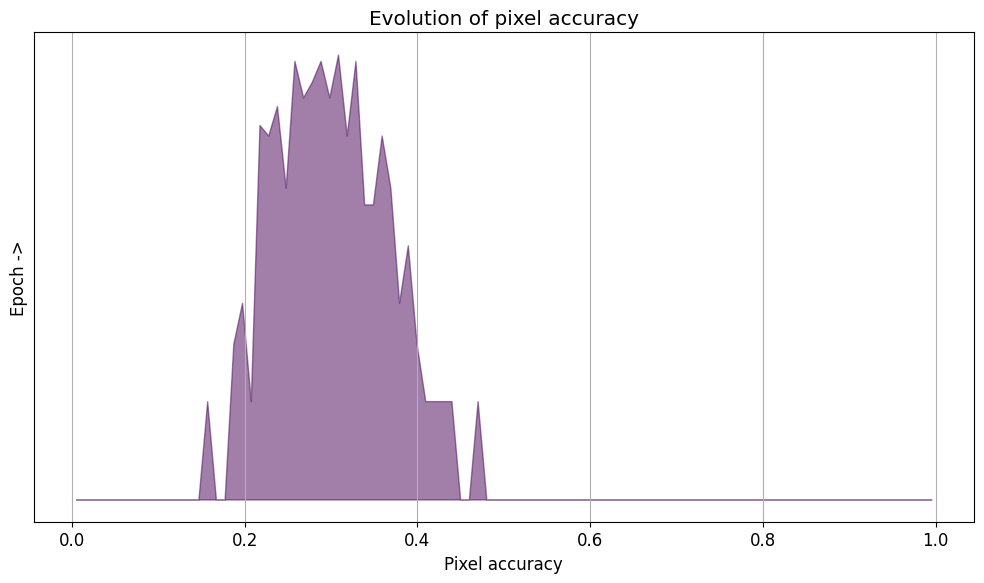

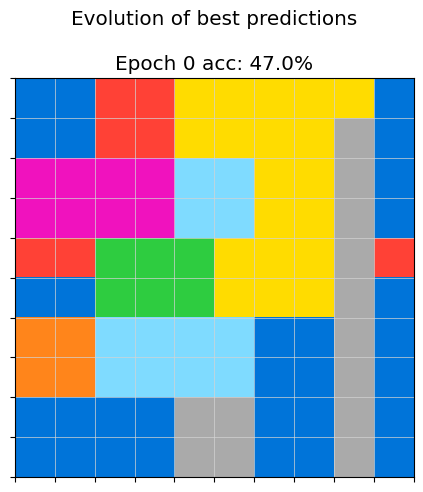

2025-05-07 13:52:36,018 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 13:52:36,092 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/251 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/251 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/251 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/251 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 251
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 251
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 13:53:18,449 - arc25.logging - INFO - wrapper - Executed finetuning in 42.4298 seconds
2025-05-07 13:53:18,450 - root - INFO - hindsight_experience_replay - Starting epoch 1...
2025-05-07 13:53:18,451 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 13:54:22,110 - root - INFO - inference - Number of unique outputs: 242/242
2025-05-07 13:54:22,117 - root - INFO - inference - Max pixel accuracy: 0.6
2025-05-07 13:54:22,121 - arc25.logging - INFO - wrapper - Executed inference in 63.6697 seconds


Error executing code: def task(img):
    draw_rectangle(img, point1=(0, 0), point2=(1, 7), color=1)
    draw_horizontal_line(img, y=8, width=9)
    draw_rectangle(img, point1=(0, 4), point2=(9, 7), color=6)
    draw_rectangle(img, point1=(0, 4), point2=(5, 5), color=4)
    draw_rectangle(img, point1=(0, 2), point2=(7, 3), color=2)
    draw_pixel(img, point=(2, 8), color=9)
    draw_rectangle(img, point1=(0, 4), point2=(1, 9), color=5)
    draw_rectangle(img, point1=(2, 2), point2=(7, 3), color=7)
    draw_rectangle(img, point1=(4, 0), point2=(5, 1), color=2)
    draw_rectangle(img, point1=(2, 4), point2=(3, 5), color=8)
    draw_rectangle(img, point1=(6, 2), point2=(7, 3), color=8)
    draw_rectangle(img, point1=(2, 0), point2=(3, 1), color=6)
    draw_rectangle(img, point1=(0, 4), point2=(1, 5), color=3)
    draw_rectangle(img, point1=(6, 6), point2=(9, 7), color=2)
    return img
draw_horizontal_line() got an unexpected keyword argument 'width'
Error executing code: def task(img):
  

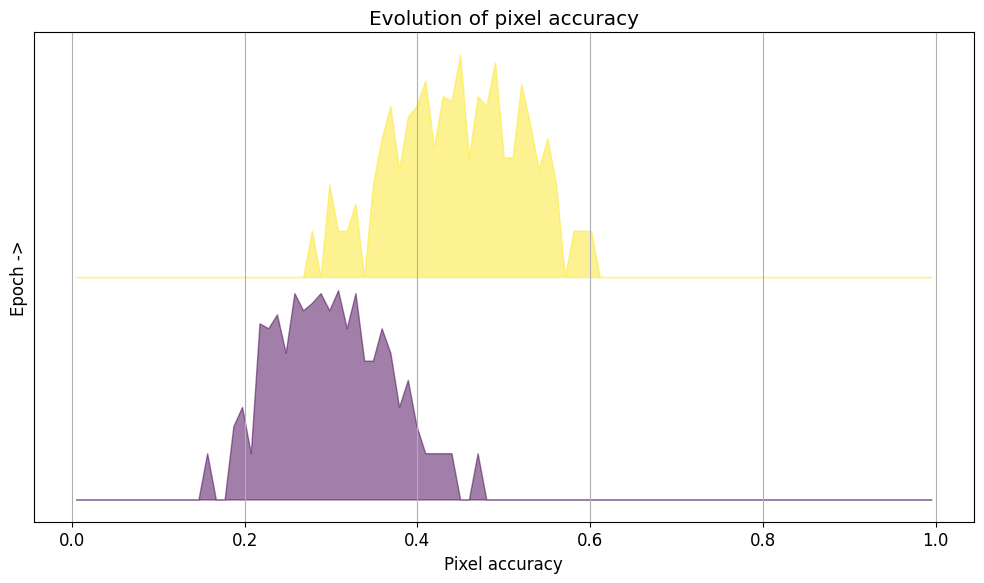

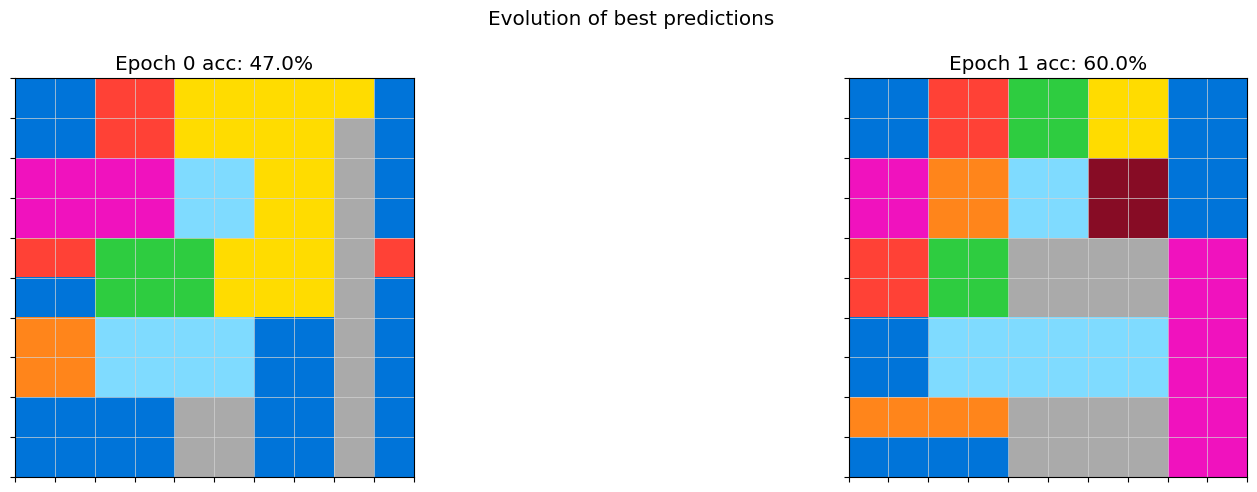

2025-05-07 13:54:22,358 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 13:54:22,444 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/242 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/242 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/242 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/242 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 242
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 242
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 13:55:08,883 - arc25.logging - INFO - wrapper - Executed finetuning in 46.5238 seconds
2025-05-07 13:55:08,884 - root - INFO - hindsight_experience_replay - Starting epoch 2...
2025-05-07 13:55:08,884 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 13:57:08,977 - root - INFO - inference - Number of unique outputs: 252/253
2025-05-07 13:57:08,982 - root - INFO - inference - Max pixel accuracy: 0.83
2025-05-07 13:57:08,992 - arc25.logging - INFO - wrapper - Executed inference in 120.1075 seconds


Error executing code: def task(img):
    draw_rectangle(img, point1=(0, 0), point2=(1, 9), color=1)
    draw_horizontal_line(img, y=8, color=3)
    draw_rectangle(img, point1=(0, 4), point2=(9, 7), color=5)
    draw_rectangle(img, point1=(0, 2), point2=(9, 5), color=4)
    draw_rectangle(img, point1=(0, 2), point2=(7, 3), color=2)
    draw_rectangle(img, point1=(6, 2), point2=(7, 3), color=8)
    draw_rectangle(img, point1=(0, 4), point2=(1, 5), color=3)
    draw_rectangle(img, point1=(6, 0), point2=(7, 1), color=7)
    draw_rectangle(img, point1=(4, 0), point2=(5, 1), color=2)
    draw_rectangle(img, point1=(2, 2), point2=(3, 3), color=7)
    draw_rectangle(img, point1=(2, 4), point2=(3, 5), color=8)
    draw_rectangle(img, point1=(2, 6), point2=(7, 9), color=1)
    draw_rectangle(img, point1=(4, 2), point2=(5, 3), color=3)
    draw_rectangle(img, point1=(0, 6), point2=(1, 7), color=4)
    draw_rectangle(img, point1=(6, 2), point2=(7, 3), color=8)
    draw_pixel(img, point=(6, 6), col

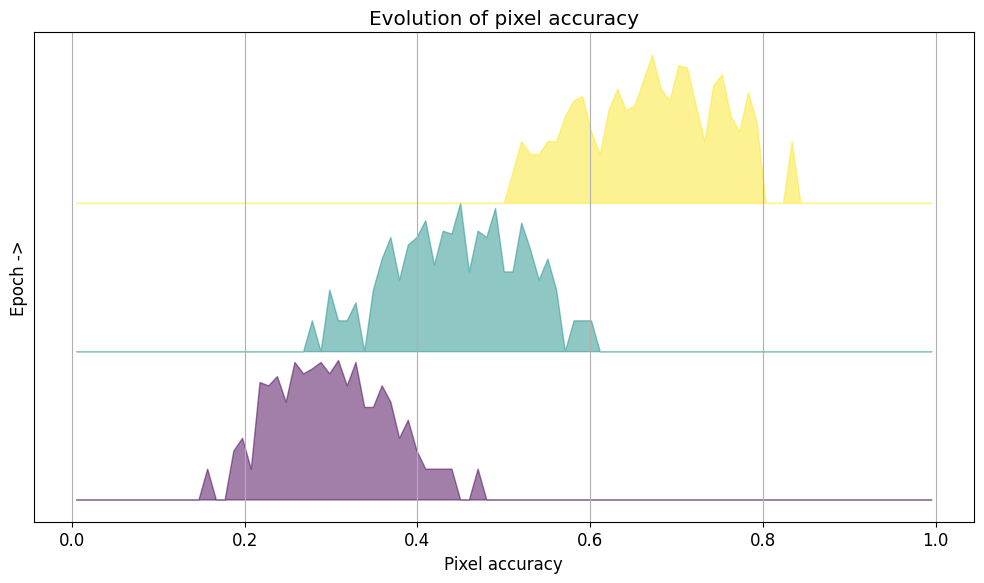

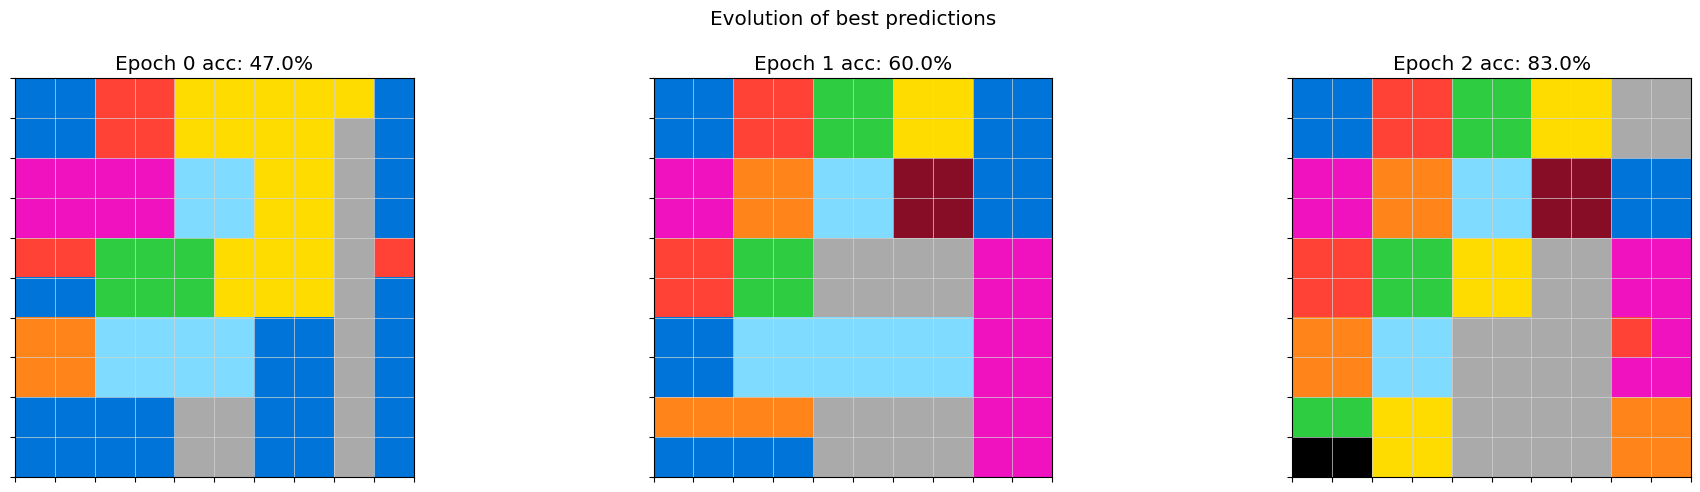

2025-05-07 13:57:09,336 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 13:57:09,425 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/252 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/252 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/252 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/252 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 252
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 252
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 13:57:59,122 - arc25.logging - INFO - wrapper - Executed finetuning in 49.7854 seconds
2025-05-07 13:57:59,123 - root - INFO - hindsight_experience_replay - Starting epoch 3...
2025-05-07 13:57:59,124 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 13:59:43,539 - root - INFO - inference - Number of unique outputs: 256/256
2025-05-07 13:59:43,550 - root - INFO - inference - Max pixel accuracy: 0.88
2025-05-07 13:59:43,565 - arc25.logging - INFO - wrapper - Executed inference in 104.4402 seconds


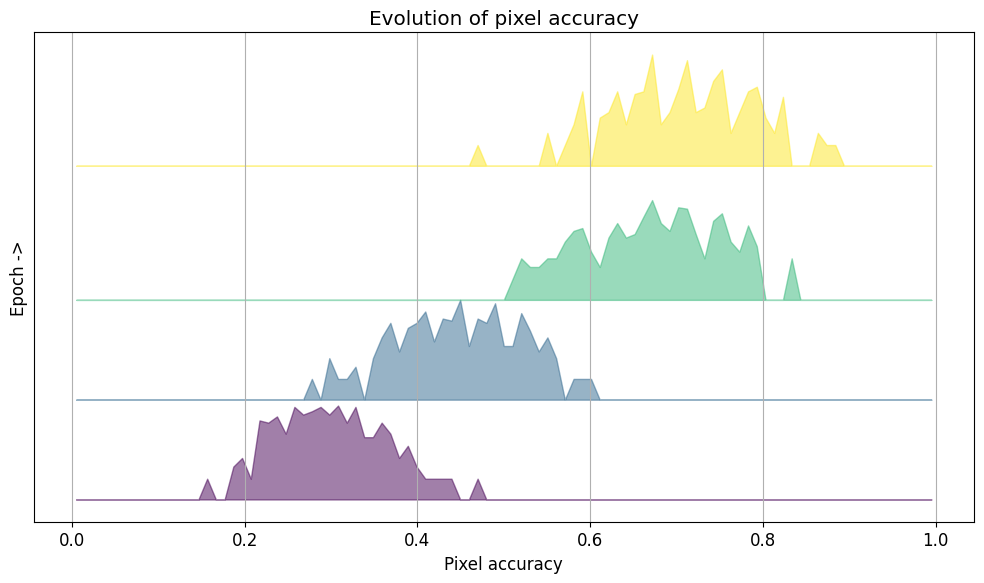

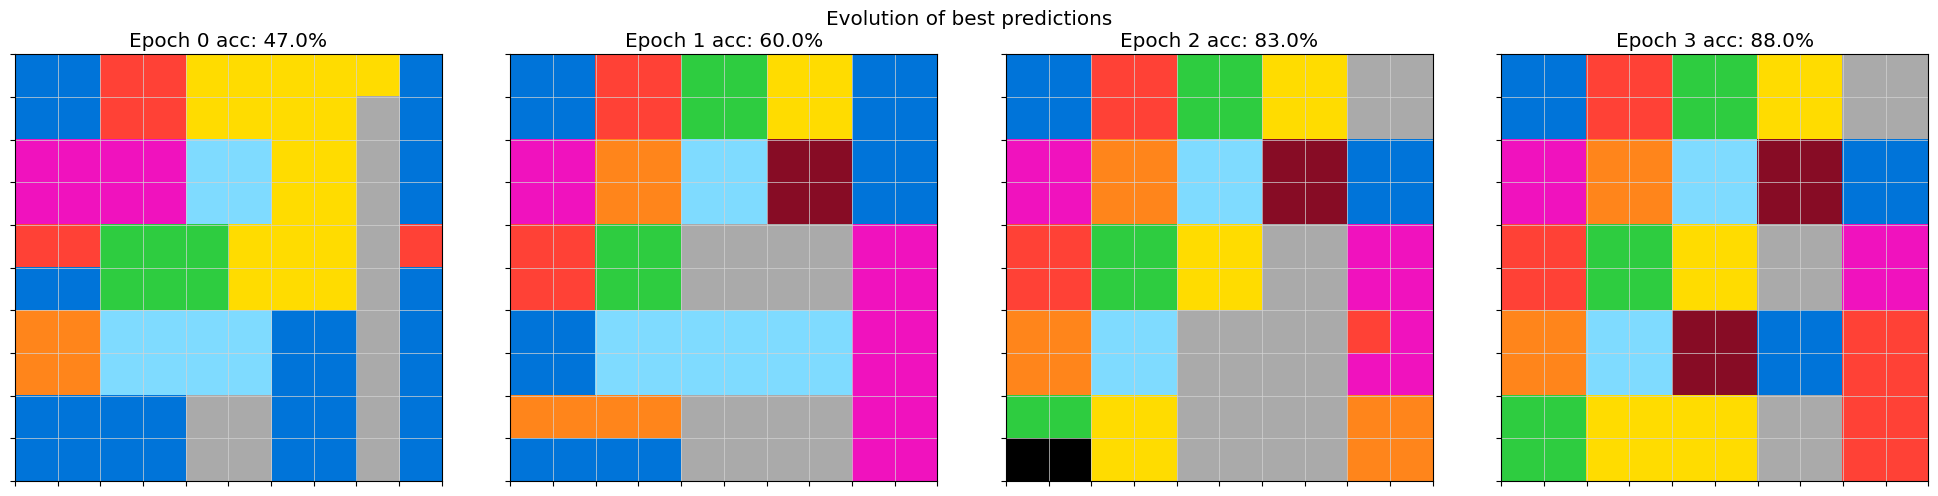

2025-05-07 13:59:43,991 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 13:59:44,101 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/256 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 256
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 256
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 14:00:35,319 - arc25.logging - INFO - wrapper - Executed finetuning in 51.3276 seconds
2025-05-07 14:00:35,321 - root - INFO - hindsight_experience_replay - Starting epoch 4...
2025-05-07 14:00:35,322 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 14:02:11,887 - root - INFO - inference - Number of unique outputs: 239/256
2025-05-07 14:02:11,900 - root - INFO - inference - Max pixel accuracy: 0.96
2025-05-07 14:02:11,913 - arc25.logging - INFO - wrapper - Executed inference in 96.5899 seconds


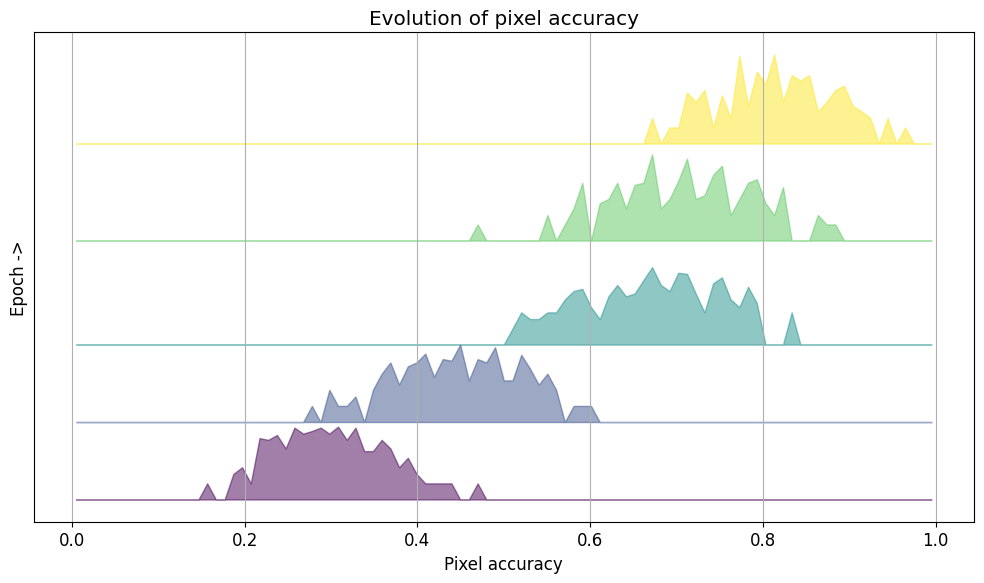

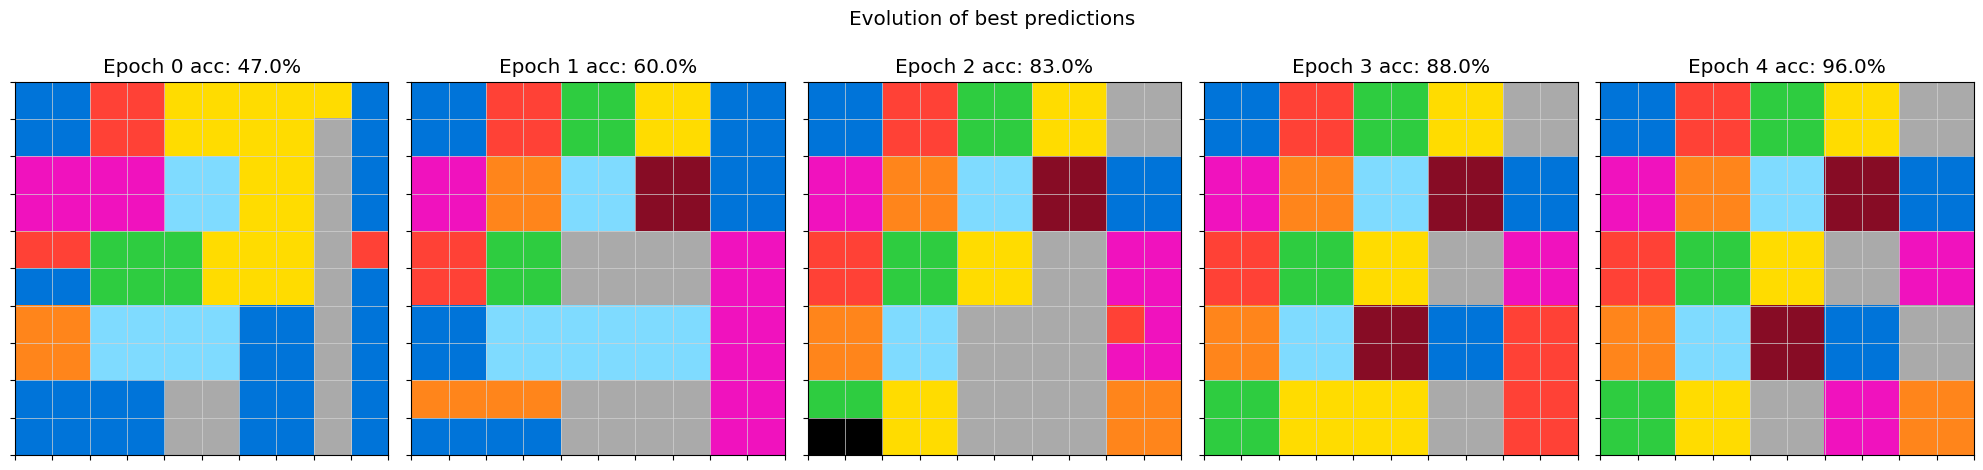

2025-05-07 14:02:12,396 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 14:02:12,482 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/239 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/239 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/239 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/239 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 239
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 239
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 14:02:57,585 - arc25.logging - INFO - wrapper - Executed finetuning in 45.1874 seconds
2025-05-07 14:02:57,586 - root - INFO - hindsight_experience_replay - Starting epoch 5...
2025-05-07 14:02:57,587 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 14:04:24,971 - root - INFO - inference - Number of unique outputs: 188/256
2025-05-07 14:04:24,985 - root - INFO - inference - Max pixel accuracy: 0.96
2025-05-07 14:04:24,989 - arc25.logging - INFO - wrapper - Executed inference in 87.4012 seconds


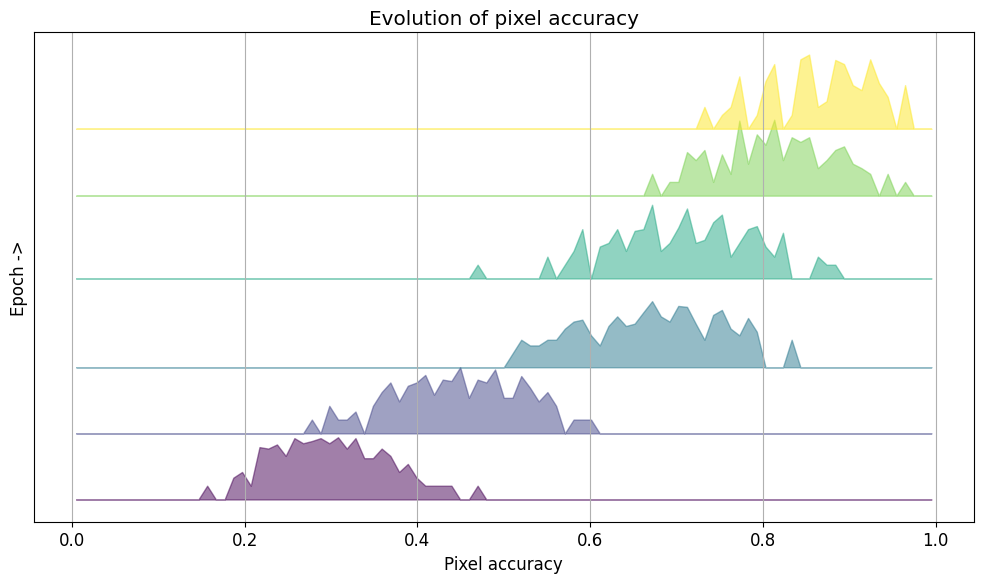

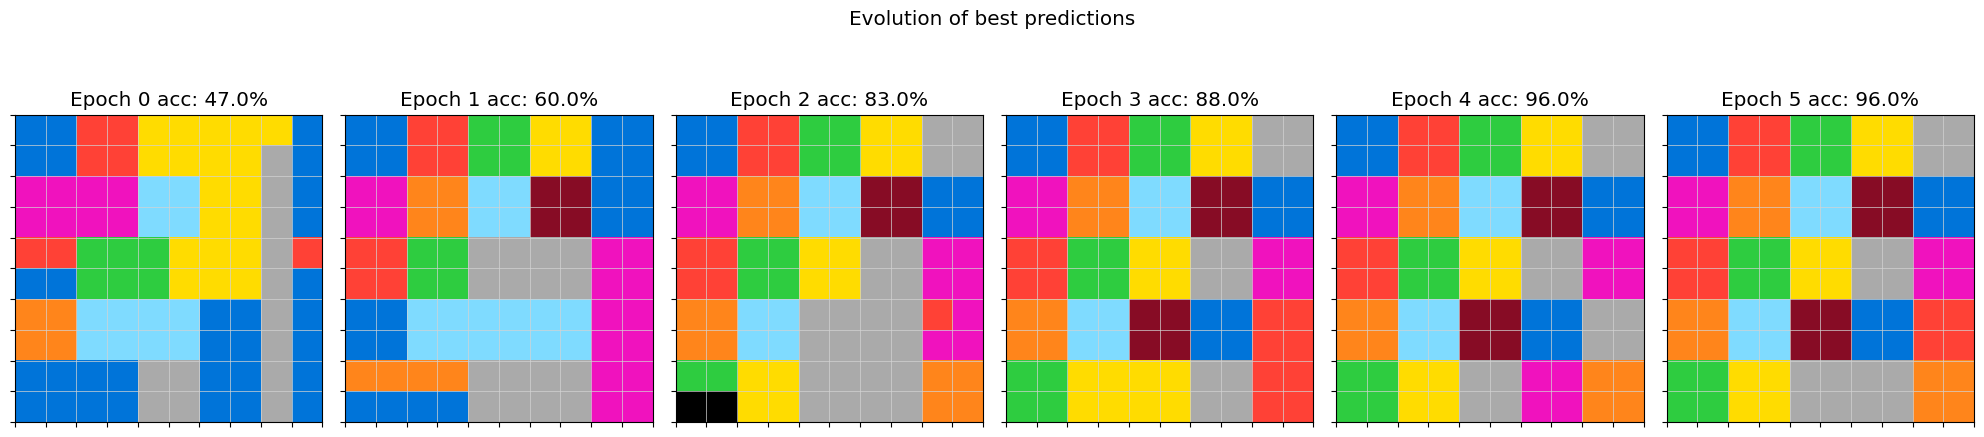

2025-05-07 14:04:25,523 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 14:04:25,613 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/188 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/188 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/188 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/188 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 188
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 188
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 14:05:03,604 - arc25.logging - INFO - wrapper - Executed finetuning in 38.0810 seconds
2025-05-07 14:05:03,606 - root - INFO - hindsight_experience_replay - Starting epoch 6...
2025-05-07 14:05:03,606 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 14:06:38,229 - root - INFO - inference - Number of unique outputs: 41/256
2025-05-07 14:06:38,245 - root - INFO - inference - Max pixel accuracy: 1.0
2025-05-07 14:06:38,247 - arc25.logging - INFO - wrapper - Executed inference in 94.6399 seconds


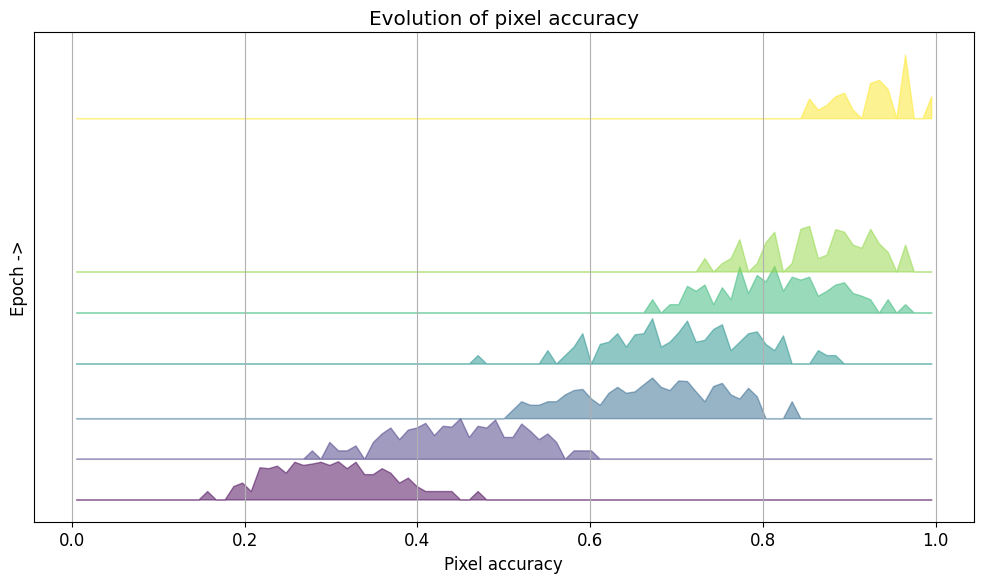

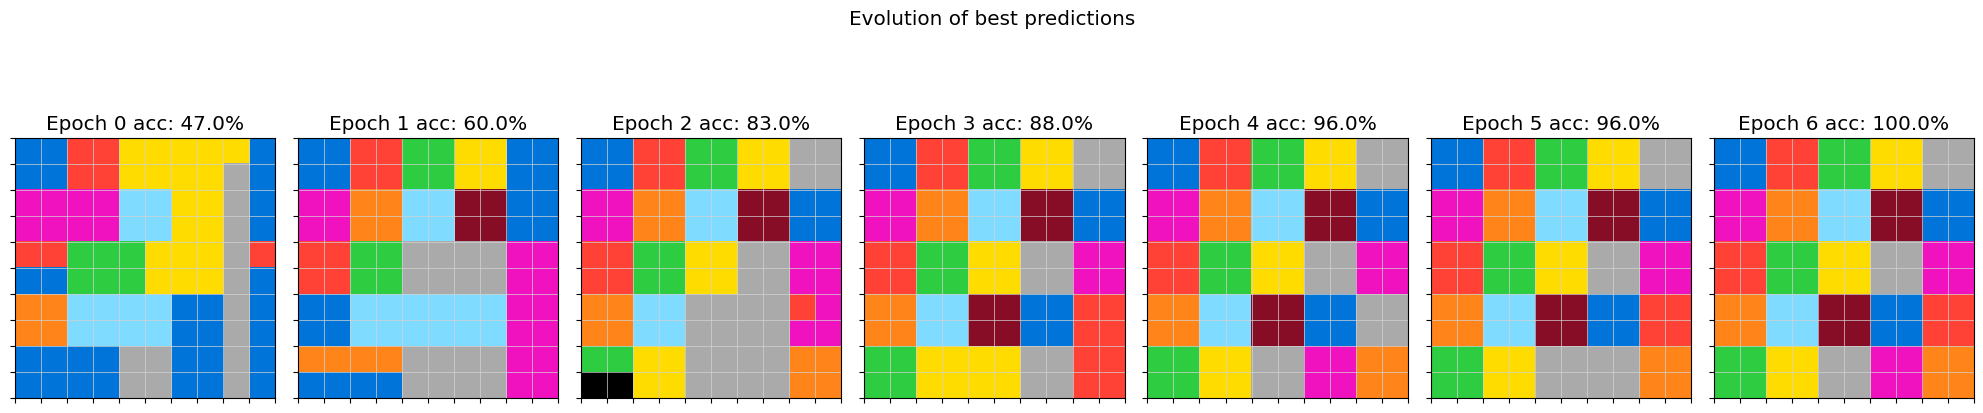

2025-05-07 14:06:38,799 - arc25.input_generation - INFO - hindsight_experience_replay - Found a perfect prediction at epoch 6!


# Best prediction code

```python
def task(img):
    draw_rectangle(img, point1=(0, 0), point2=(1, 9), color=1)
    draw_rectangle(img, point1=(0, 4), point2=(9, 9), color=5)
    draw_rectangle(img, point1=(0, 2), point2=(7, 5), color=4)
    draw_rectangle(img, point1=(0, 2), point2=(7, 3), color=2)
    draw_rectangle(img, point1=(0, 4), point2=(1, 5), color=3)
    draw_rectangle(img, point1=(0, 6), point2=(1, 7), color=4)
    draw_rectangle(img, point1=(2, 0), point2=(3, 3), color=6)
    draw_rectangle(img, point1=(2, 2), point2=(7, 3), color=7)
    draw_rectangle(img, point1=(2, 4), point2=(3, 5), color=8)
    draw_rectangle(img, point1=(2, 6), point2=(3, 7), color=9)
    draw_rectangle(img, point1=(6, 2), point2=(7, 3), color=8)
    draw_rectangle(img, point1=(6, 0), point2=(7, 1), color=7)
    draw_rectangle(img, point1=(4, 0), point2=(5, 1), color=2)
    draw_rectangle(img, point1=(4, 2), point2=(5, 3), color=3)
    draw_rectangle(img, point1=(4, 8), point2=(9, 9), color=6)
    draw_rectangle(img, point1=(6, 4), point2=(7, 5), color=9)
    draw_rectangle(img, point1=(8, 0), point2=(9, 1), color=3)
    draw_rectangle(img, point1=(8, 6), point2=(9, 7), color=6)
    draw_rectangle(img, point1=(2, 8), point2=(3, 9), color=1)
    draw_rectangle(img, point1=(6, 6), point2=(7, 7), color=1)
    draw_rectangle(img, point1=(8, 8), point2=(9, 9), color=7)
    draw_rectangle(img, point1=(8, 2), point2=(9, 3), color=4)
    draw_rectangle(img, point1=(6, 8), point2=(7, 9), color=2)
    return img
```

2025-05-07 14:06:38,849 - arc25.logging - INFO - wrapper - Executed hindsight_experience_replay in 886.0820 seconds


In [ ]:
input_img = create_img((10, 10), color=0)
output_img = input_img.copy()
color = 0
for x in range(0, input_img.shape[1], 2):
    for y in range(0, input_img.shape[0], 2):
        color = (color + 1) % 10
        if color == 0: color = 1
        draw_rectangle(output_img, (x, y), (x+1, y+1), color=color)
task = Task(inputs=[input_img], outputs=[output_img], code='', name='manual')
metrics = hindsight_experience_replay(task, Config())

### Pixels

#### 12 pixels

2025-05-07 14:06:38,873 - arc25.logging - INFO - wrapper - Executing hindsight_experience_replay...


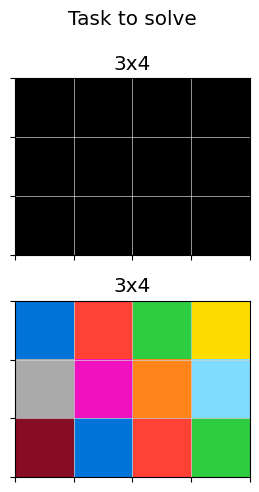

2025-05-07 14:06:38,969 - arc25.logging - INFO - wrapper - Executing load_model...
2025-05-07 14:06:38,970 - root - INFO - load_model - Loading model from /home/gbarbadillo/models/Qwen2.5-Coder-0.5B-Instruct and LoRA from /mnt/hdd0/Kaggle/arc25/trainings/20250430_first_trainings/steps_6400/checkpoint-6400
loading configuration file /home/gbarbadillo/models/Qwen2.5-Coder-0.5B-Instruct/config.json
Model config Qwen2Config {
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "eos_token_id": 151645,
  "hidden_act": "silu",
  "hidden_size": 896,
  "initializer_range": 0.02,
  "intermediate_size": 4864,
  "max_position_embeddings": 32768,
  "max_window_layers": 24,
  "model_type": "qwen2",
  "num_attention_heads": 14,
  "num_hidden_layers": 24,
  "num_key_value_heads": 2,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 1000000.0,
  "sliding_window": 32768,
  "tie_word_embeddings": true,
  "torch_dtype": "bfloat16",
  "tra

  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 14:06:57,758 - root - INFO - inference - Number of unique outputs: 249/256
2025-05-07 14:06:57,761 - root - INFO - inference - Max pixel accuracy: 0.8333333333333334
2025-05-07 14:06:57,764 - arc25.logging - INFO - wrapper - Executed inference in 17.7008 seconds


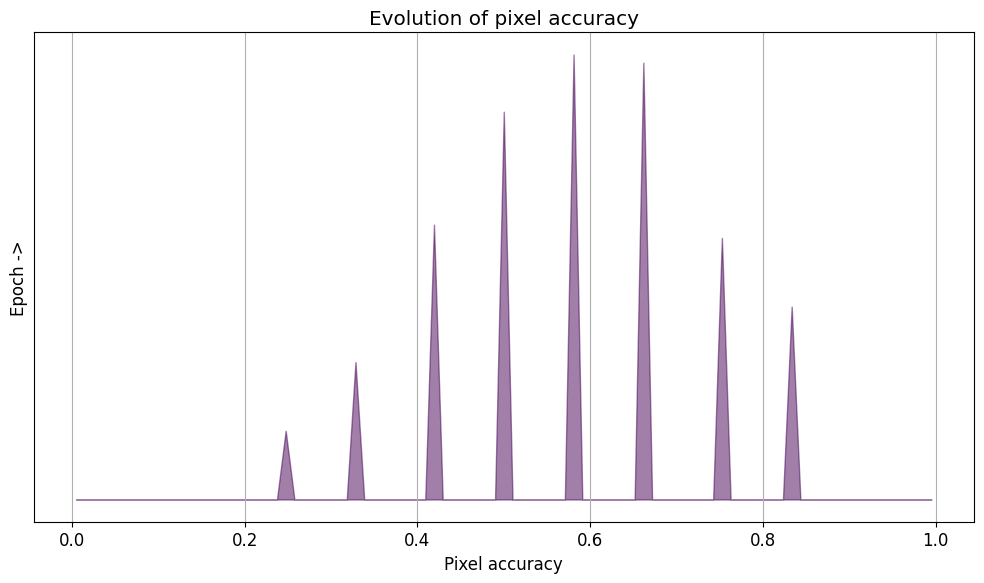

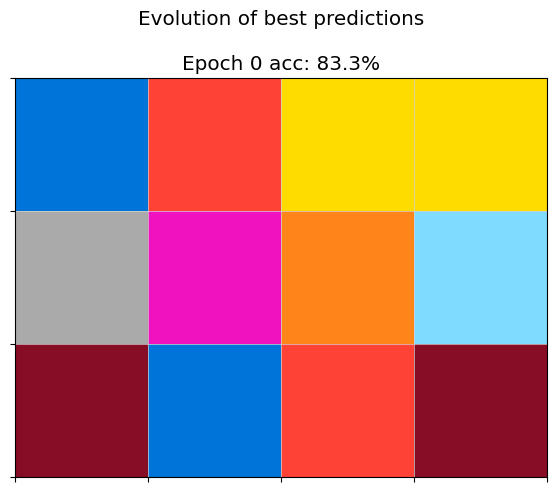

2025-05-07 14:06:57,926 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 14:06:57,998 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/249 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/249 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/249 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/249 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 249
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 249
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 14:07:42,713 - arc25.logging - INFO - wrapper - Executed finetuning in 44.7860 seconds
2025-05-07 14:07:42,715 - root - INFO - hindsight_experience_replay - Starting epoch 1...
2025-05-07 14:07:42,715 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 14:07:59,709 - root - INFO - inference - Number of unique outputs: 158/256
2025-05-07 14:07:59,711 - root - INFO - inference - Max pixel accuracy: 0.9166666666666666
2025-05-07 14:07:59,714 - arc25.logging - INFO - wrapper - Executed inference in 16.9981 seconds


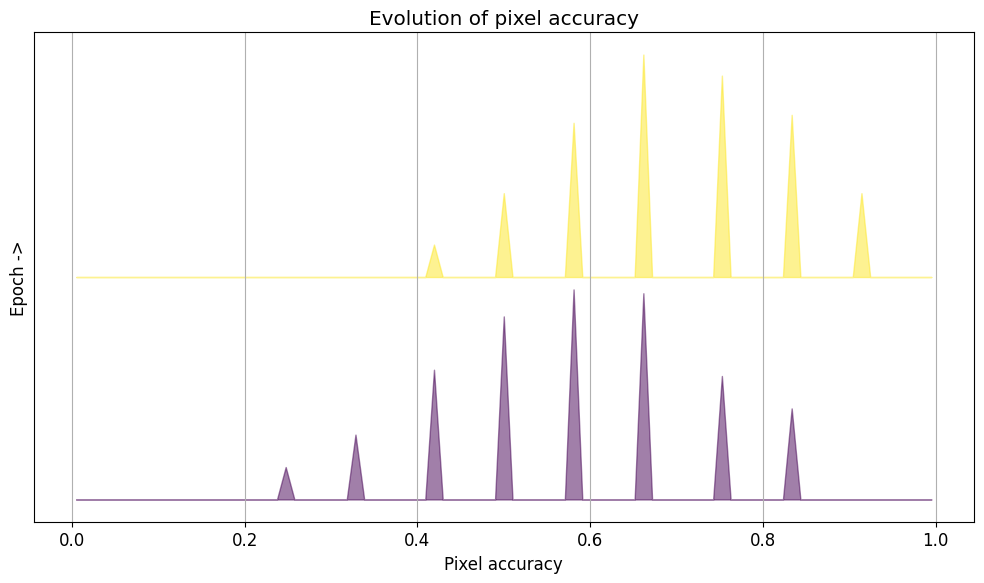

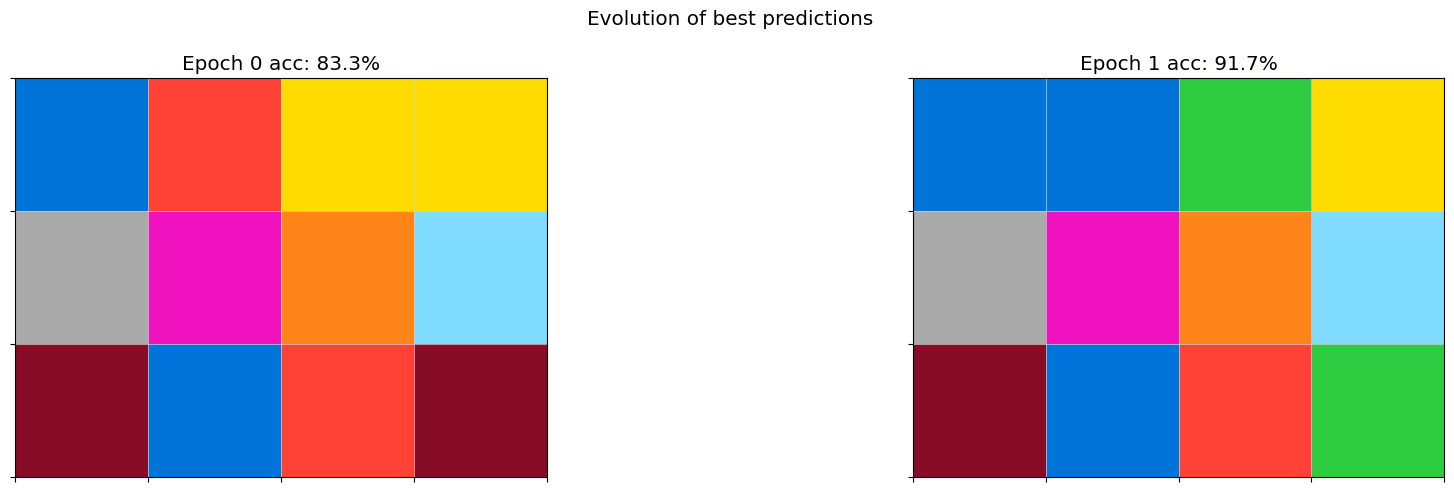

2025-05-07 14:07:59,908 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 14:07:59,974 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/158 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/158 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/158 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/158 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 158
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 158
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 14:08:28,197 - arc25.logging - INFO - wrapper - Executed finetuning in 28.2876 seconds
2025-05-07 14:08:28,198 - root - INFO - hindsight_experience_replay - Starting epoch 2...
2025-05-07 14:08:28,198 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 14:08:46,551 - root - INFO - inference - Number of unique outputs: 88/256
2025-05-07 14:08:46,552 - root - INFO - inference - Max pixel accuracy: 0.9166666666666666
2025-05-07 14:08:46,555 - arc25.logging - INFO - wrapper - Executed inference in 18.3561 seconds


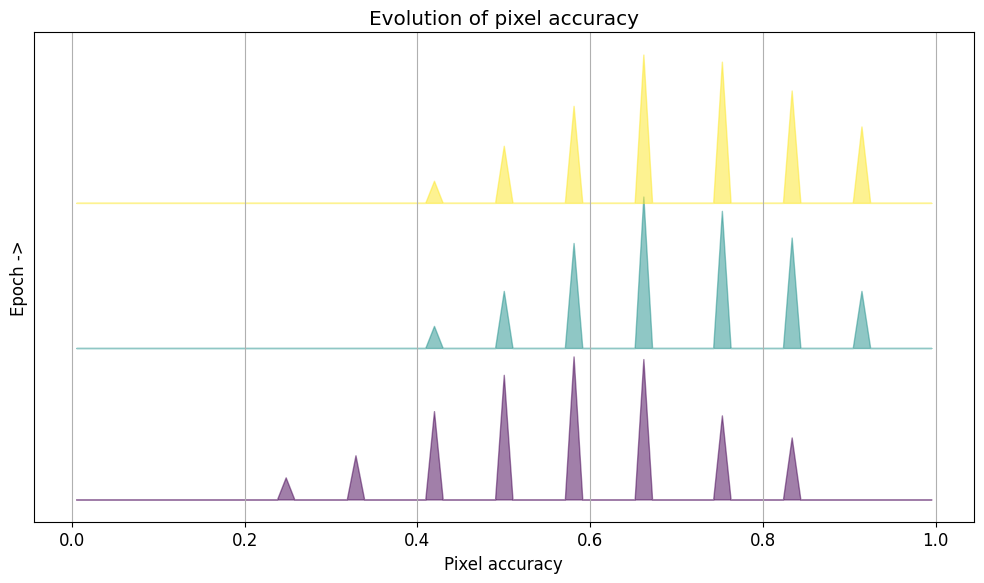

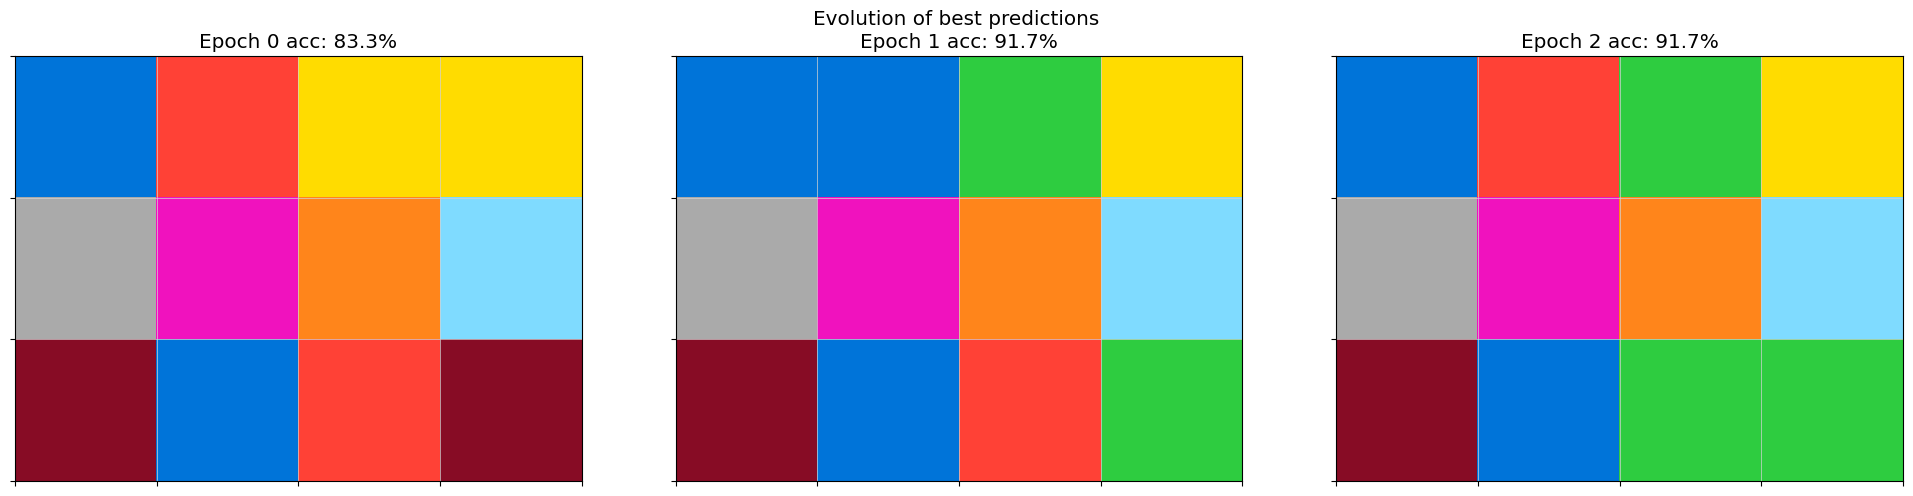

2025-05-07 14:08:46,817 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 14:08:46,878 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/88 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/88 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/88 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/88 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 88
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 88
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 14:09:03,644 - arc25.logging - INFO - wrapper - Executed finetuning in 16.8261 seconds
2025-05-07 14:09:03,646 - root - INFO - hindsight_experience_replay - Starting epoch 3...
2025-05-07 14:09:03,646 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 14:09:22,916 - root - INFO - inference - Number of unique outputs: 53/252
2025-05-07 14:09:22,920 - root - INFO - inference - Max pixel accuracy: 0.9166666666666666
2025-05-07 14:09:22,921 - arc25.logging - INFO - wrapper - Executed inference in 19.2742 seconds


Error executing code: def task(img):
    draw_horizontal_line(img, y=2, color=9)
    draw_vertical_line(img, x=1, color=1)
    draw_pixel(img, point=(0, 0), color=1)
    draw_rectangle(img, point1=(0, 2), point2=(2, 3), color=3)
    draw_pixel(img, point=(1, 0), color=5)
    draw_pixel(img, point=(1, 3), color=8)
    draw_pixel(img, point=(0, 3), color=4)
    draw.line(img, point1=(0, 1), point2=(2, 3), color=2)
    draw_pixel(img, point=(1, 1), color=6)
    draw_pixel(img, point=(1, 2), color=7)
    return img
name 'draw' is not defined
Error executing code: def task(img):
    draw_horizontal_line(img, y=2, color=9)
    draw_vertical_line(img, x=1, color=1)
    draw_pixel(img, point=(0, 0), color=1)
    draw_rectangle(img, point1=(0, 2), point2=(2, 3), color=3)
    draw_pixel(img, point=(0, 3), color=4)
    draw_pixel(img, point=(1, 0), color=5)
    draw.line(img, point1=(0, 1), point2=(2, 3), color=2)
    draw_pixel(img, point=(1, 1), color=6)
    draw_pixel(img, point=(1, 3), color=

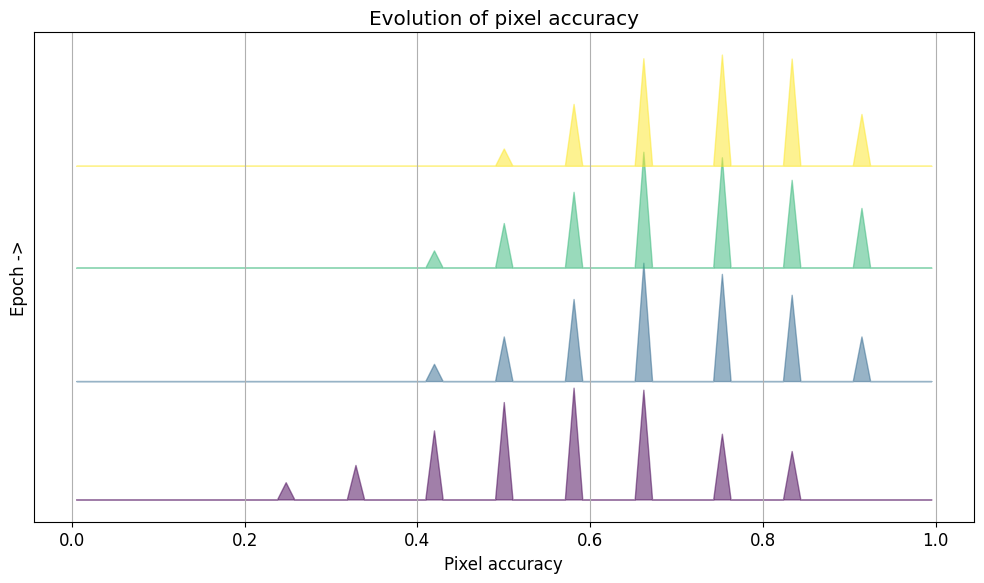

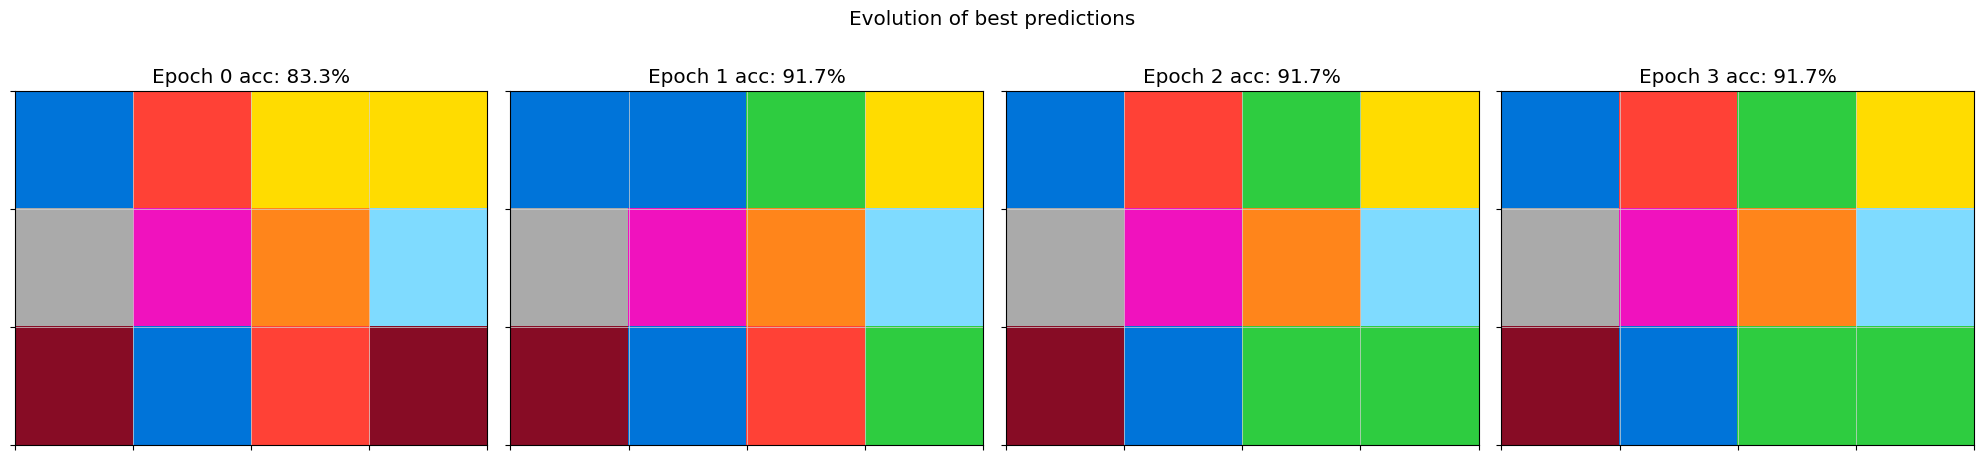

2025-05-07 14:09:23,212 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 14:09:23,266 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/53 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/53 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/53 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/53 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 53
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 53
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 14:09:33,320 - arc25.logging - INFO - wrapper - Executed finetuning in 10.1071 seconds
2025-05-07 14:09:33,321 - root - INFO - hindsight_experience_replay - Starting epoch 4...
2025-05-07 14:09:33,321 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 14:09:52,120 - root - INFO - inference - Number of unique outputs: 48/255
2025-05-07 14:09:52,123 - root - INFO - inference - Max pixel accuracy: 0.9166666666666666
2025-05-07 14:09:52,128 - arc25.logging - INFO - wrapper - Executed inference in 18.8064 seconds


Error executing code: def task(img):
    draw_horizontal_line(img, y=2, color=9)
    draw_vertical_line(img, x=1, color=1)
    draw_pixel(img, point=(0, 0), color=1)
    draw_rectangle(img, point1=(0, 2), point2=(2, 3), color=3)
    draw_pixel(img, point=(1, 0), color=5)
    draw_pixel(img, point=(1, 3), color=8)
    draw.line(img, point1=(0, 1), point2=(2, 3), color=2)
    draw_pixel(img, point=(1, 1), color=6)
    draw_pixel(img, point=(0, 3), color=4)
    return img
name 'draw' is not defined


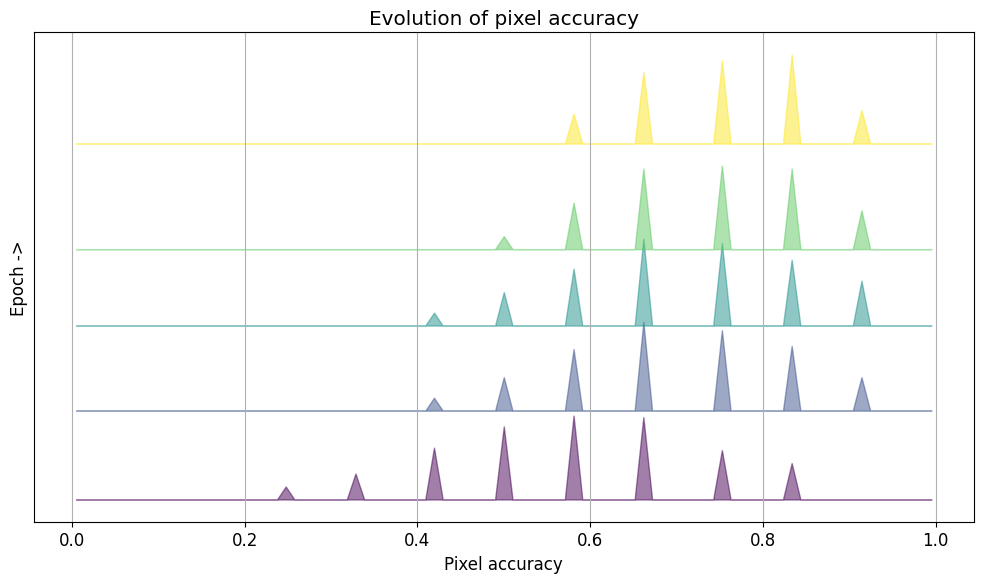

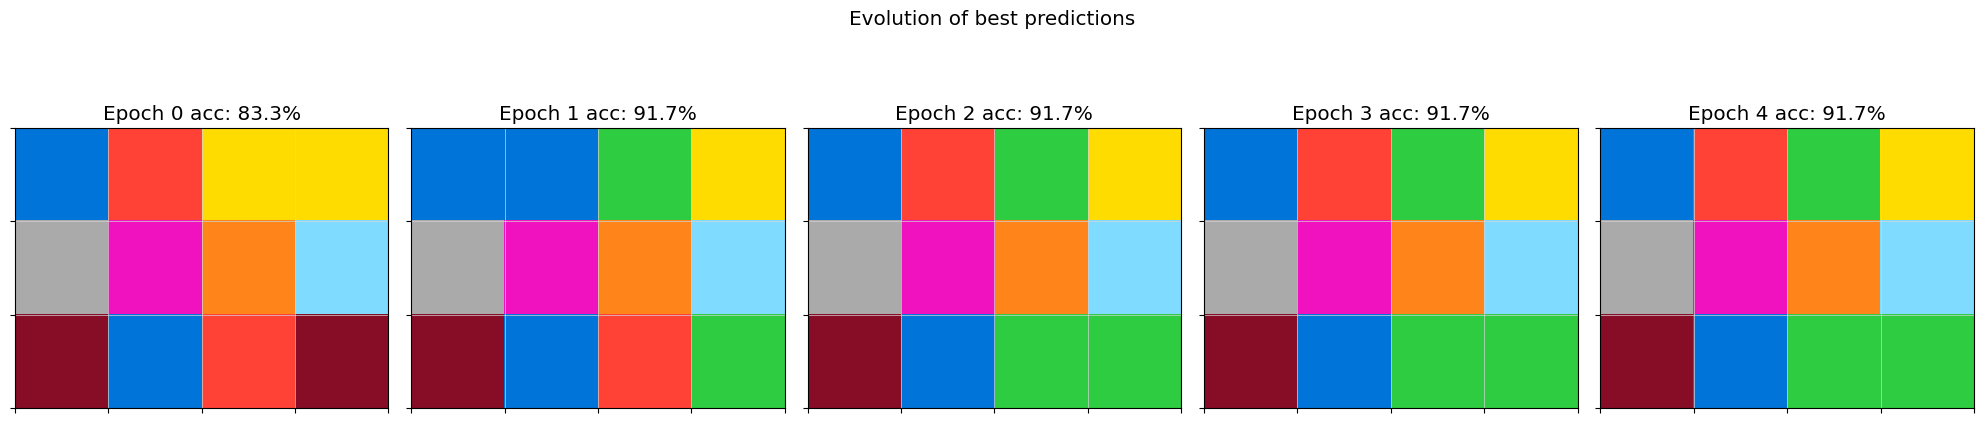

2025-05-07 14:09:52,583 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 14:09:52,638 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/48 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/48 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/48 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/48 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 48
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 48
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 14:10:01,746 - arc25.logging - INFO - wrapper - Executed finetuning in 9.1617 seconds
2025-05-07 14:10:01,747 - root - INFO - hindsight_experience_replay - Starting epoch 5...
2025-05-07 14:10:01,748 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 14:10:21,846 - root - INFO - inference - Number of unique outputs: 42/256
2025-05-07 14:10:21,847 - root - INFO - inference - Max pixel accuracy: 0.9166666666666666
2025-05-07 14:10:21,850 - arc25.logging - INFO - wrapper - Executed inference in 20.1020 seconds


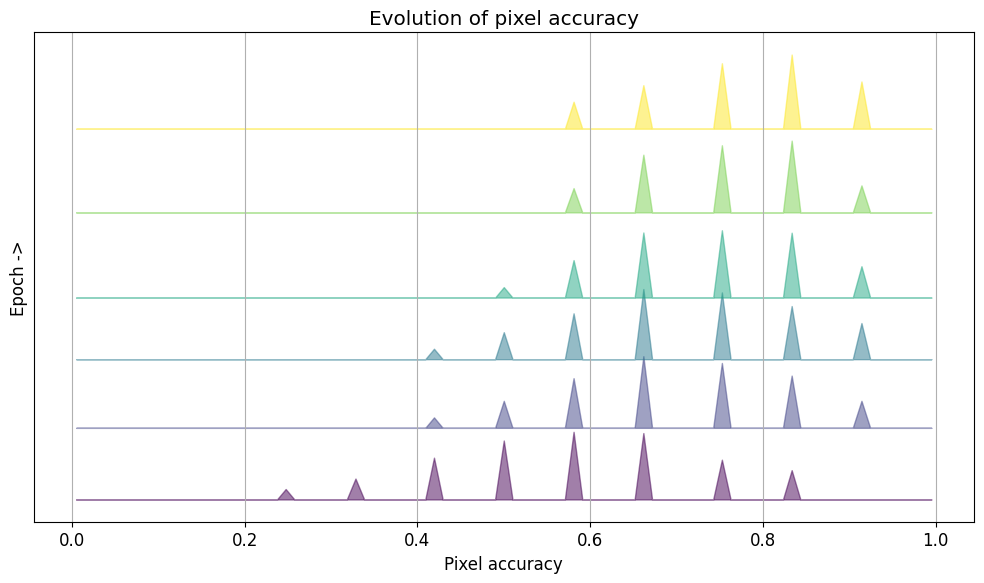

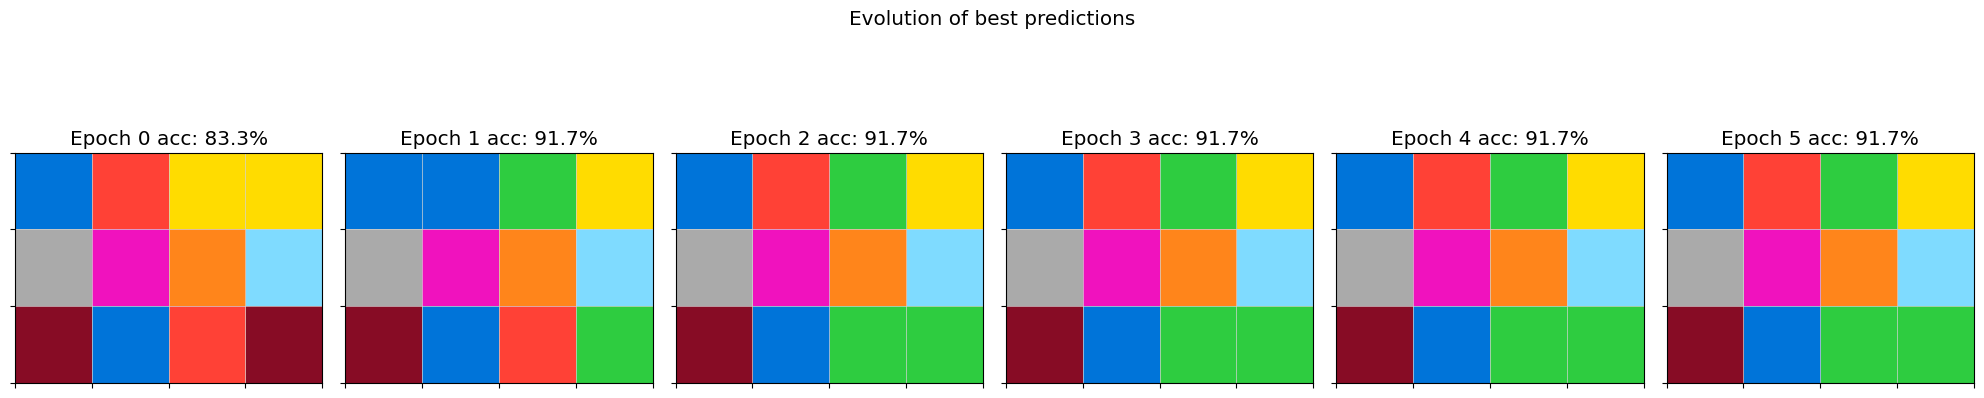

2025-05-07 14:10:22,209 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 14:10:22,262 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/42 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/42 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/42 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/42 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 42
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 42
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 14:10:30,462 - arc25.logging - INFO - wrapper - Executed finetuning in 8.2515 seconds
2025-05-07 14:10:30,463 - root - INFO - hindsight_experience_replay - Starting epoch 6...
2025-05-07 14:10:30,463 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 14:10:52,127 - root - INFO - inference - Number of unique outputs: 25/255
2025-05-07 14:10:52,129 - root - INFO - inference - Max pixel accuracy: 0.9166666666666666
2025-05-07 14:10:52,132 - arc25.logging - INFO - wrapper - Executed inference in 21.6684 seconds


Error executing code: def task(img):
    draw_horizontal_line(img, y=2, color=9)
    draw_vertical_line(img, x=1, color=1)
    draw_pixel(img, point=(0, 0), color=1)
    draw_rectangle(img, point1=(0, 2), point2=(2, 3), color=3)
    draw_pixel(img, point=(0, 3), color=4)
    draw_pixel(img, point=(1, 0), color=5)
    draw_pixel(img, point=(1, 3), color=8)
    draw.line(img, point1=(0, 1), point2=(2, 3), color=2)
    draw_pixel(img, point=(1, 1), color=6)
    draw_pixel(img, point=(1, 2), color=7)
    return img
name 'draw' is not defined


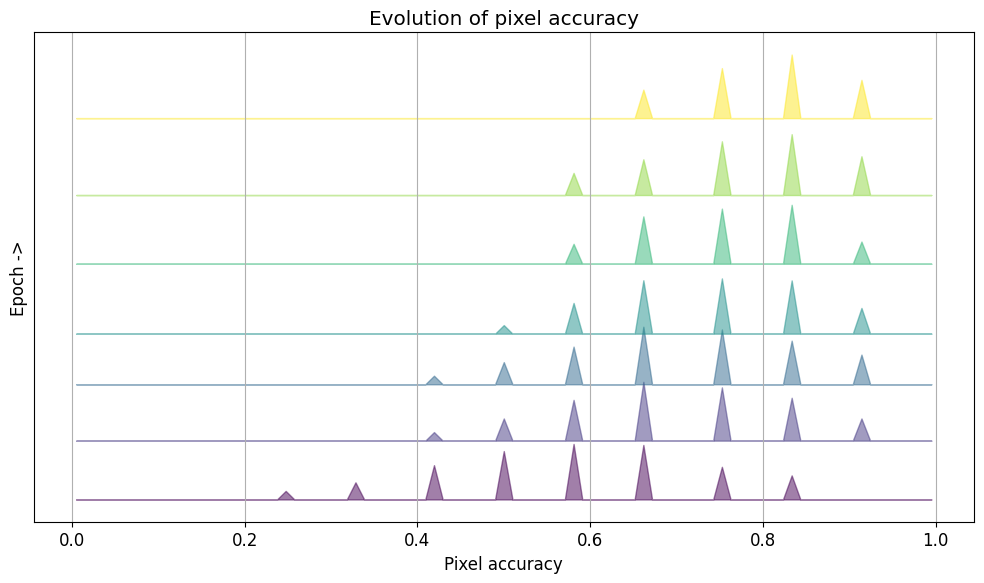

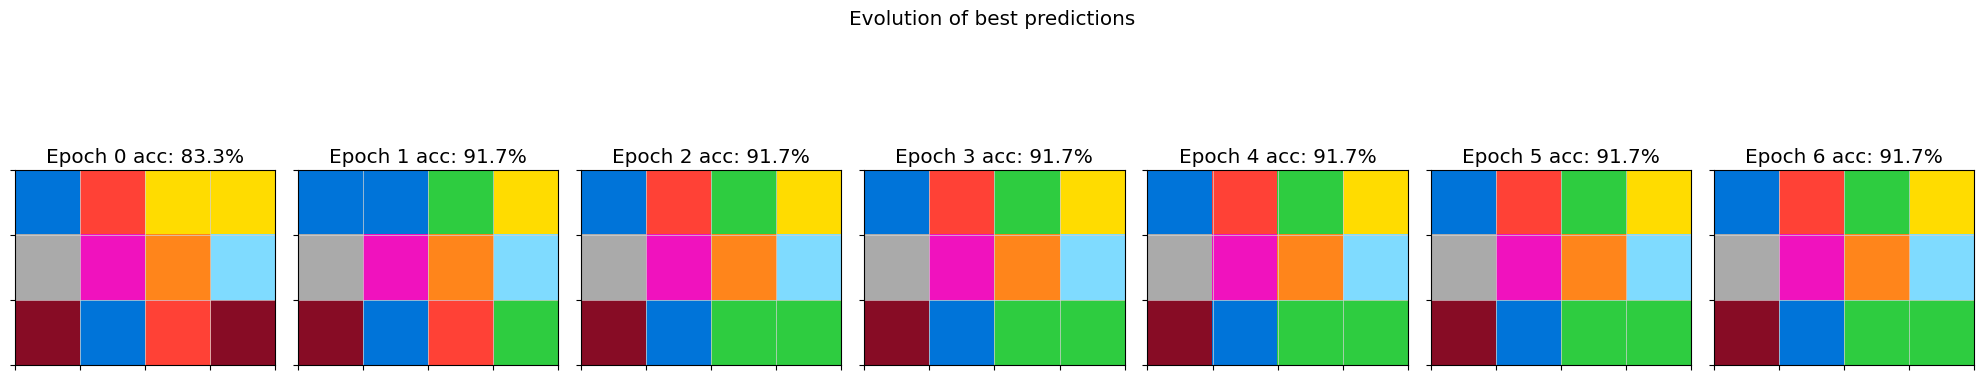

2025-05-07 14:10:52,550 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 14:10:52,604 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/25 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/25 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/25 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/25 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 25
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 25
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 14:10:58,110 - arc25.logging - INFO - wrapper - Executed finetuning in 5.5596 seconds
2025-05-07 14:10:58,112 - root - INFO - hindsight_experience_replay - Starting epoch 7...
2025-05-07 14:10:58,112 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 14:11:17,779 - root - INFO - inference - Number of unique outputs: 14/256
2025-05-07 14:11:17,782 - root - INFO - inference - Max pixel accuracy: 0.9166666666666666
2025-05-07 14:11:17,787 - arc25.logging - INFO - wrapper - Executed inference in 19.6738 seconds


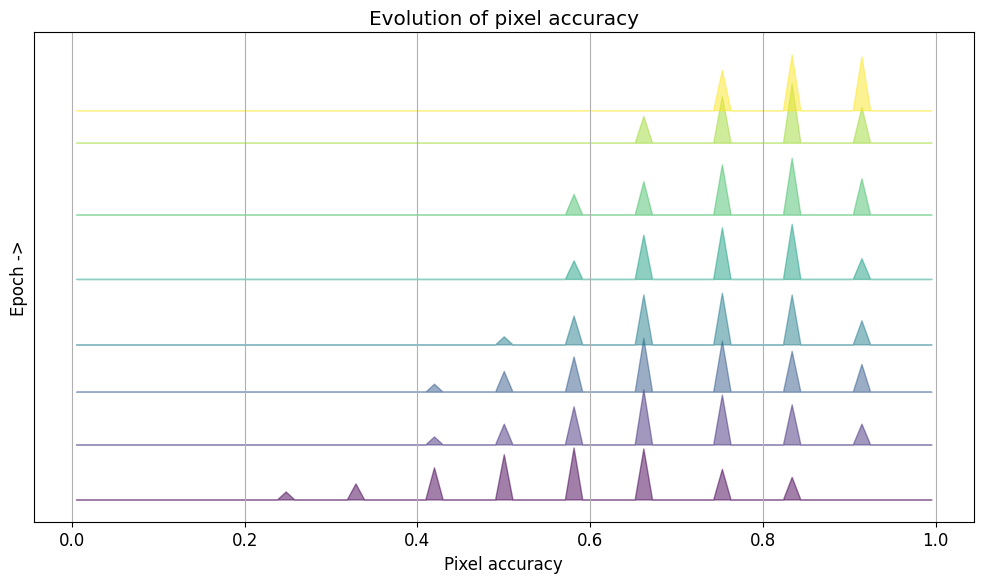

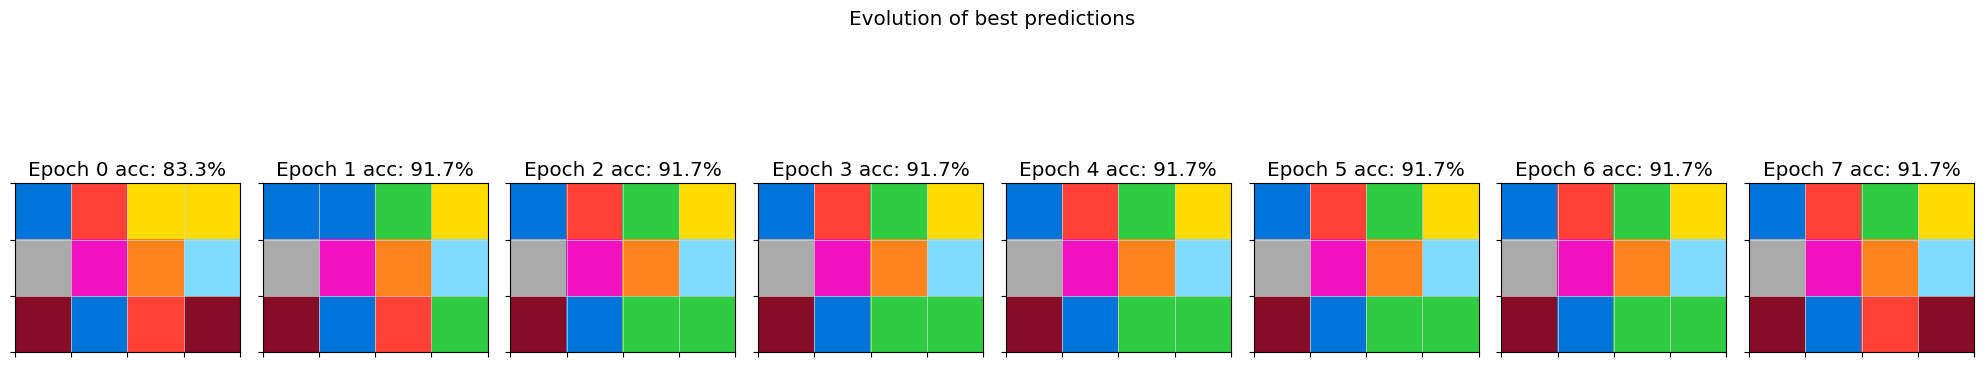

2025-05-07 14:11:18,280 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 14:11:18,320 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/14 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/14 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/14 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/14 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 14
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 14
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 14:11:22,037 - arc25.logging - INFO - wrapper - Executed finetuning in 3.7568 seconds
2025-05-07 14:11:22,038 - root - INFO - hindsight_experience_replay - Starting epoch 8...
2025-05-07 14:11:22,039 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 14:11:40,943 - root - INFO - inference - Number of unique outputs: 12/256
2025-05-07 14:11:40,945 - root - INFO - inference - Max pixel accuracy: 0.9166666666666666
2025-05-07 14:11:40,947 - arc25.logging - INFO - wrapper - Executed inference in 18.9074 seconds


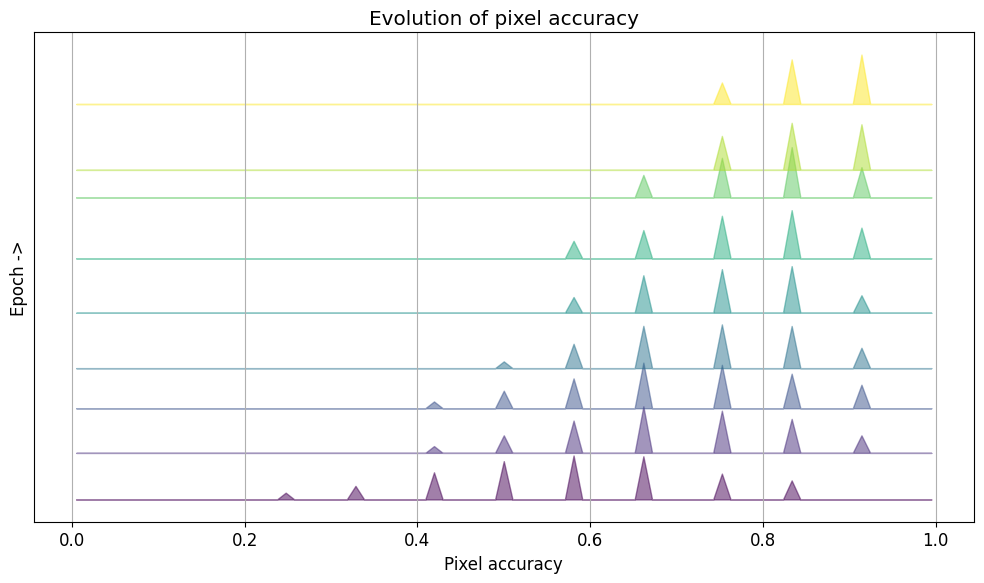

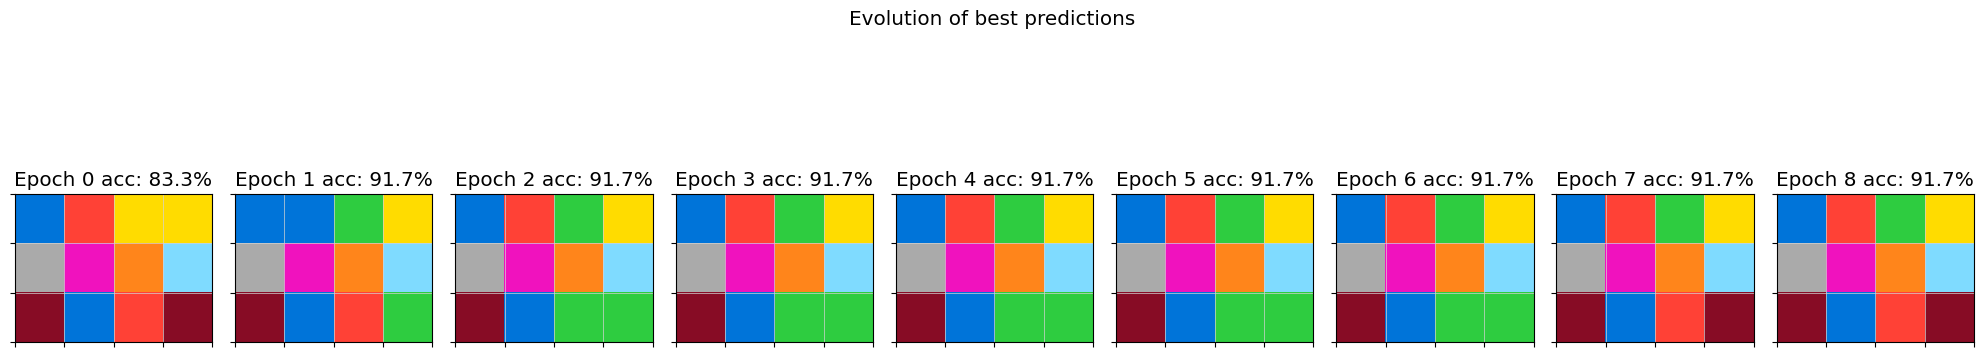

2025-05-07 14:11:41,469 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 14:11:41,533 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/12 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/12 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/12 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/12 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 12
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 12
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 14:11:44,853 - arc25.logging - INFO - wrapper - Executed finetuning in 3.3828 seconds
2025-05-07 14:11:44,854 - root - INFO - hindsight_experience_replay - Starting epoch 9...
2025-05-07 14:11:44,855 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 14:12:05,353 - root - INFO - inference - Number of unique outputs: 8/256
2025-05-07 14:12:05,355 - root - INFO - inference - Max pixel accuracy: 0.9166666666666666
2025-05-07 14:12:05,357 - arc25.logging - INFO - wrapper - Executed inference in 20.5016 seconds


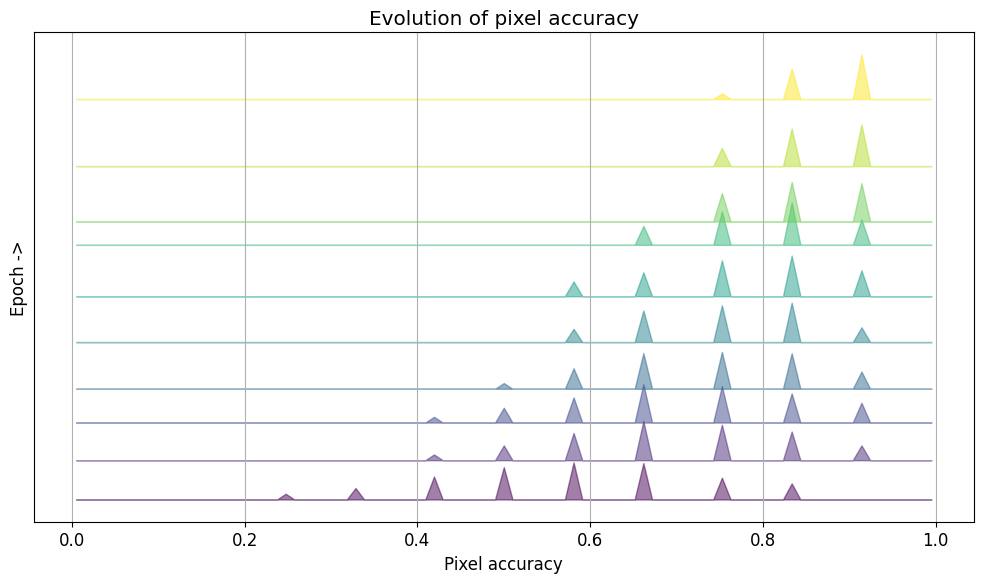

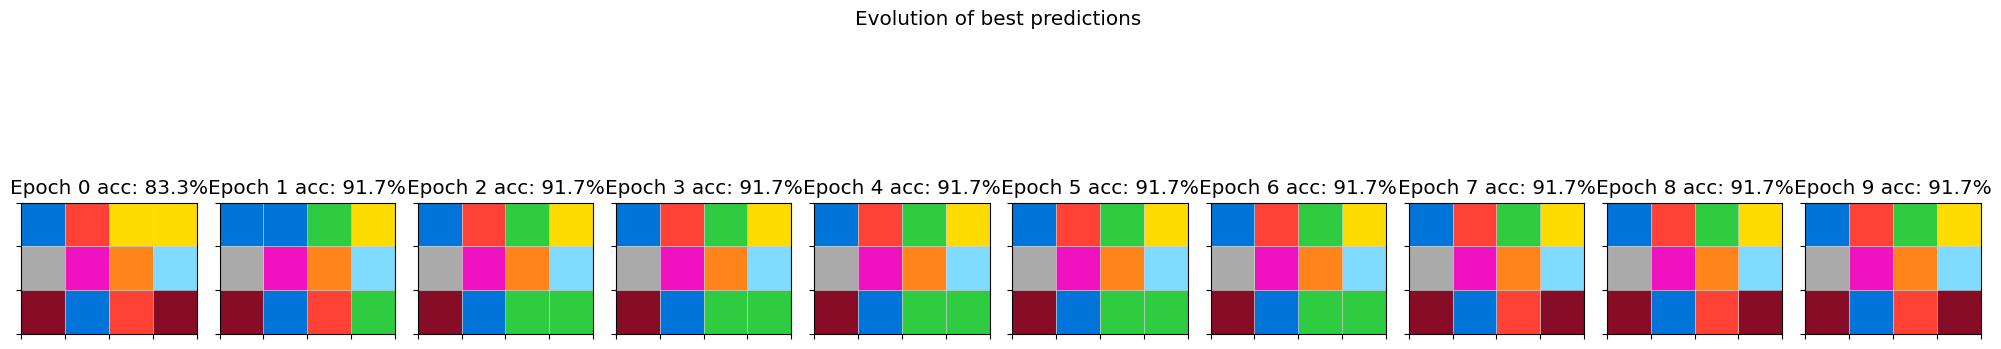

2025-05-07 14:12:05,865 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 14:12:05,917 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/8 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/8 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/8 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/8 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 8
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 8
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 14:12:08,457 - arc25.logging - INFO - wrapper - Executed finetuning in 2.5908 seconds


# Best prediction code

```python
def task(img):
    draw_horizontal_line(img, y=2, color=9)
    draw_vertical_line(img, x=1, color=2)
    draw_pixel(img, point=(0, 0), color=1)
    draw_rectangle(img, point1=(1, 1), point2=(2, 2), color=2)
    draw_pixel(img, point=(0, 3), color=4)
    draw_pixel(img, point=(1, 0), color=5)
    draw_pixel(img, point=(1, 1), color=6)
    draw_line(img, point1=(0, 2), point2=(2, 4), color=3)
    draw_pixel(img, point=(1, 2), color=7)
    draw_pixel(img, point=(1, 3), color=8)
    draw_pixel(img, point=(2, 1), color=1)
    return img
```

2025-05-07 14:12:08,530 - arc25.logging - INFO - wrapper - Executed hindsight_experience_replay in 329.6546 seconds


In [ ]:
input_img = create_img((3, 4), color=0)
output_img = input_img.copy()
color = 0
for y in range(0, input_img.shape[0], 1):
    for x in range(0, input_img.shape[1], 1):
        color = (color + 1) % 10
        if color == 0: color = 1
        draw_pixel(output_img, (y, x), color=color)
task = Task(inputs=[input_img], outputs=[output_img], code='', name='manual')
hindsight_experience_replay(task, Config());

#### 20 pixels

2025-05-07 14:12:08,573 - arc25.logging - INFO - wrapper - Executing hindsight_experience_replay...


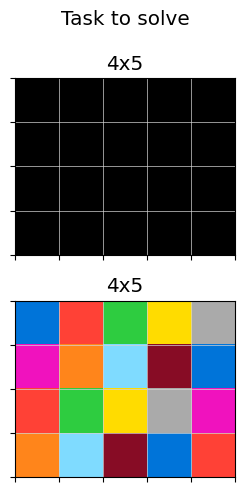

2025-05-07 14:12:08,682 - arc25.logging - INFO - wrapper - Executing load_model...
2025-05-07 14:12:08,683 - root - INFO - load_model - Loading model from /home/gbarbadillo/models/Qwen2.5-Coder-0.5B-Instruct and LoRA from /mnt/hdd0/Kaggle/arc25/trainings/20250430_first_trainings/steps_6400/checkpoint-6400
loading configuration file /home/gbarbadillo/models/Qwen2.5-Coder-0.5B-Instruct/config.json
Model config Qwen2Config {
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "eos_token_id": 151645,
  "hidden_act": "silu",
  "hidden_size": 896,
  "initializer_range": 0.02,
  "intermediate_size": 4864,
  "max_position_embeddings": 32768,
  "max_window_layers": 24,
  "model_type": "qwen2",
  "num_attention_heads": 14,
  "num_hidden_layers": 24,
  "num_key_value_heads": 2,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 1000000.0,
  "sliding_window": 32768,
  "tie_word_embeddings": true,
  "torch_dtype": "bfloat16",
  "tra

  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 14:12:32,500 - root - INFO - inference - Number of unique outputs: 256/256
2025-05-07 14:12:32,503 - root - INFO - inference - Max pixel accuracy: 0.55
2025-05-07 14:12:32,516 - arc25.logging - INFO - wrapper - Executed inference in 22.8638 seconds


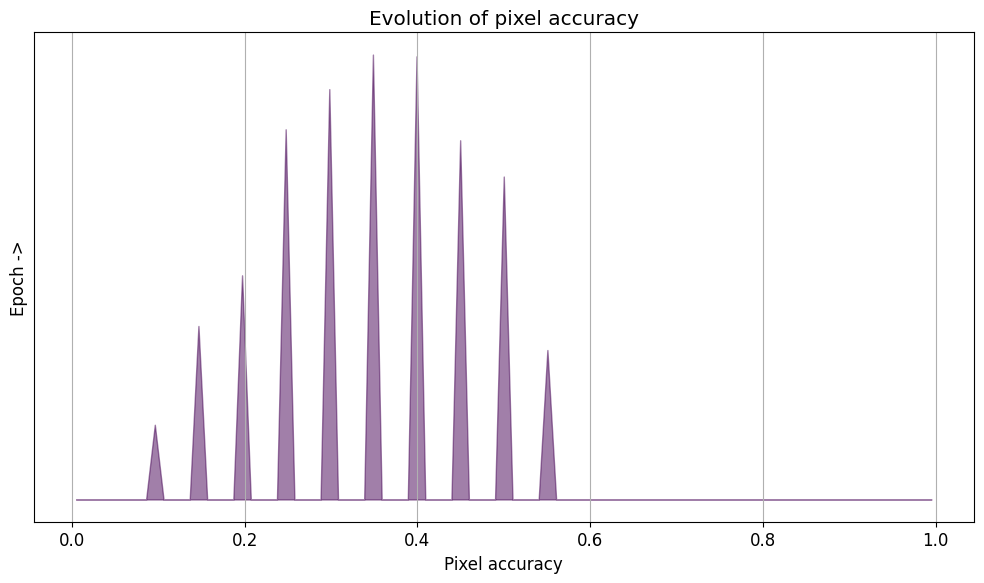

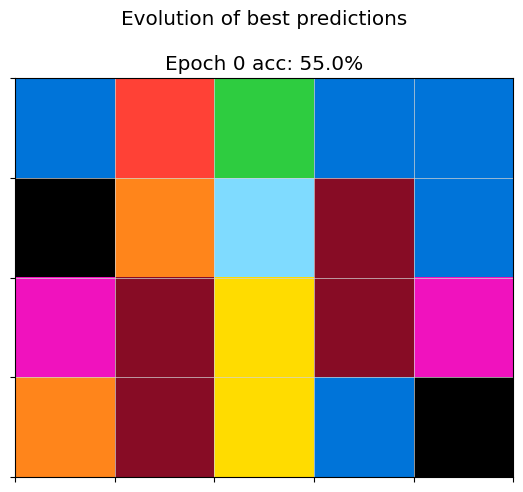

2025-05-07 14:12:32,658 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 14:12:32,728 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/256 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 256
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 256
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 14:13:20,909 - arc25.logging - INFO - wrapper - Executed finetuning in 48.2495 seconds
2025-05-07 14:13:20,910 - root - INFO - hindsight_experience_replay - Starting epoch 1...
2025-05-07 14:13:20,911 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 14:13:50,401 - root - INFO - inference - Number of unique outputs: 256/256
2025-05-07 14:13:50,404 - root - INFO - inference - Max pixel accuracy: 0.75
2025-05-07 14:13:50,408 - arc25.logging - INFO - wrapper - Executed inference in 29.4966 seconds


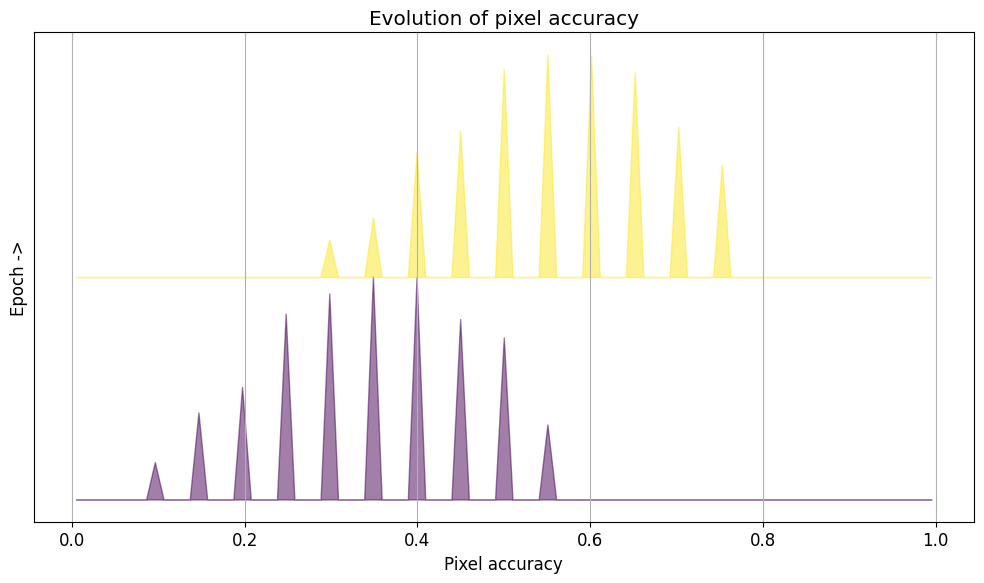

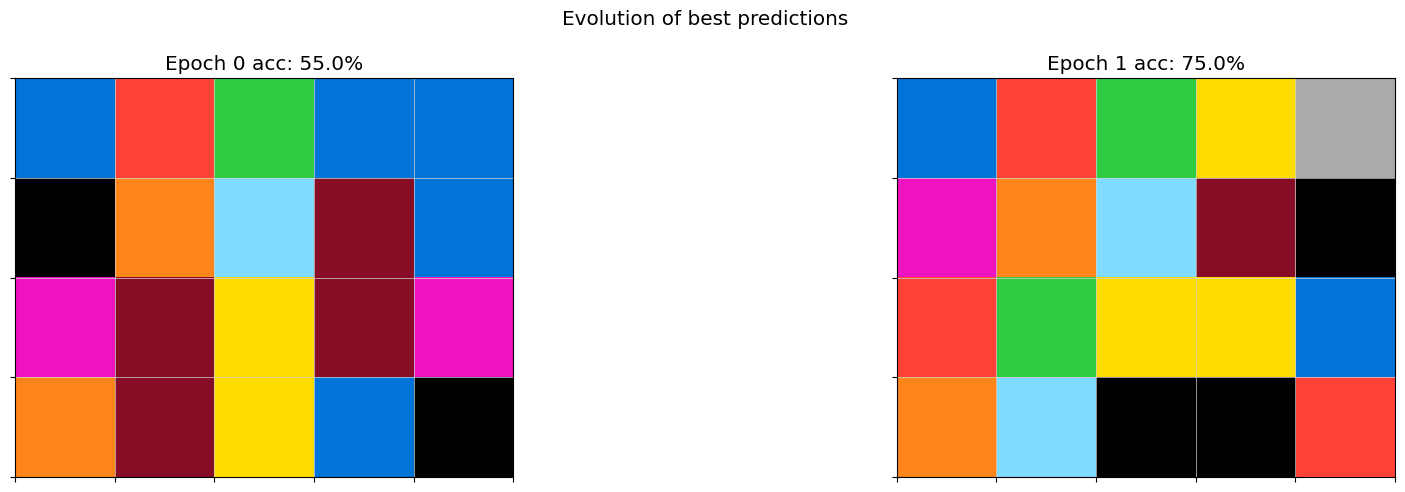

2025-05-07 14:13:50,698 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 14:13:50,791 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/256 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 256
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 256
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 14:14:38,194 - arc25.logging - INFO - wrapper - Executed finetuning in 47.4948 seconds
2025-05-07 14:14:38,195 - root - INFO - hindsight_experience_replay - Starting epoch 2...
2025-05-07 14:14:38,196 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 14:15:10,770 - root - INFO - inference - Number of unique outputs: 234/256
2025-05-07 14:15:10,775 - root - INFO - inference - Max pixel accuracy: 0.9
2025-05-07 14:15:10,785 - arc25.logging - INFO - wrapper - Executed inference in 32.5881 seconds


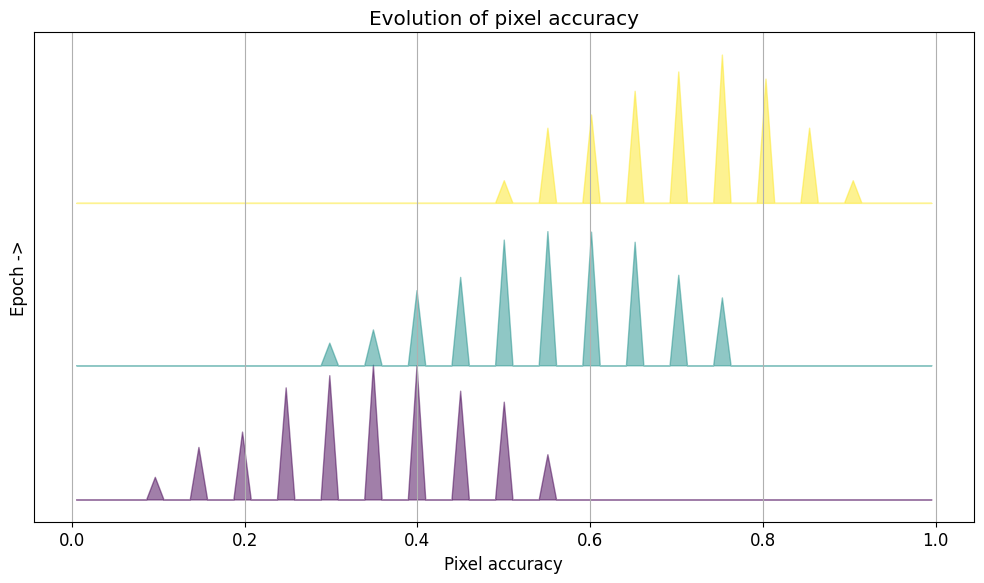

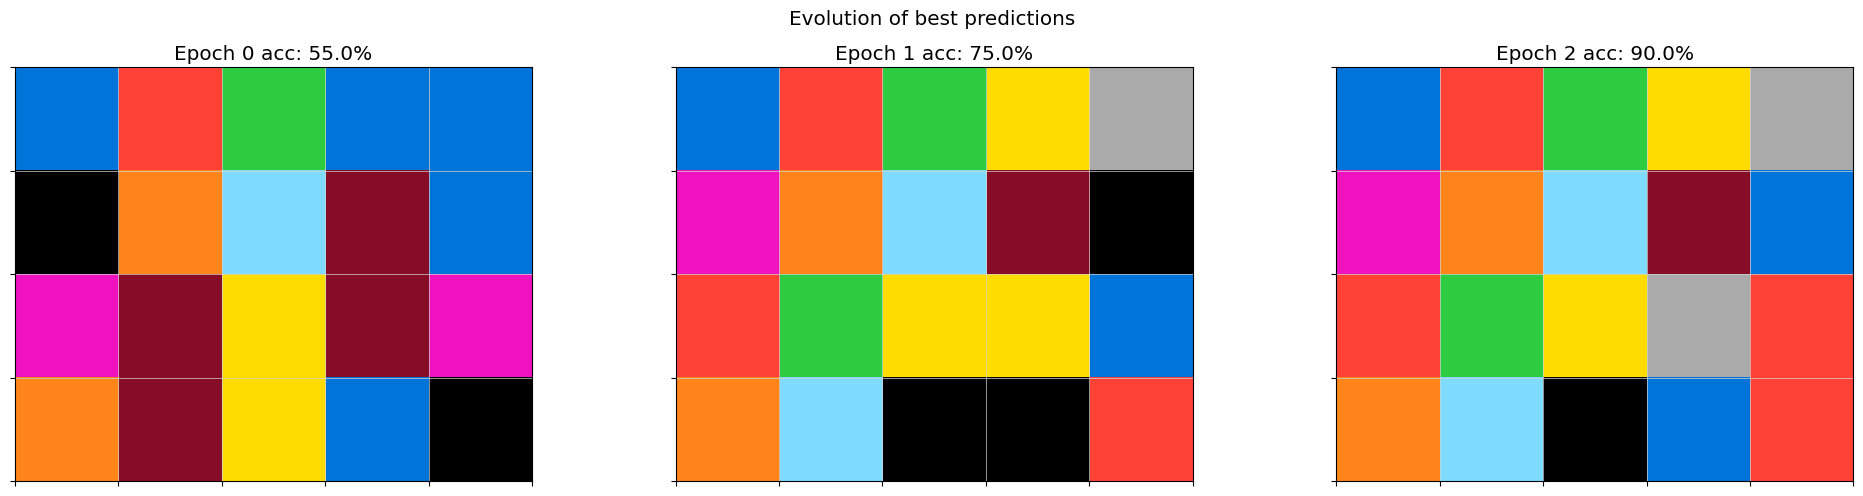

2025-05-07 14:15:11,116 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 14:15:11,194 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/234 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/234 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/234 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/234 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 234
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 234
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 14:15:54,850 - arc25.logging - INFO - wrapper - Executed finetuning in 43.7328 seconds
2025-05-07 14:15:54,852 - root - INFO - hindsight_experience_replay - Starting epoch 3...
2025-05-07 14:15:54,853 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 14:16:28,835 - root - INFO - inference - Number of unique outputs: 223/256
2025-05-07 14:16:28,838 - root - INFO - inference - Max pixel accuracy: 0.95
2025-05-07 14:16:28,848 - arc25.logging - INFO - wrapper - Executed inference in 33.9935 seconds


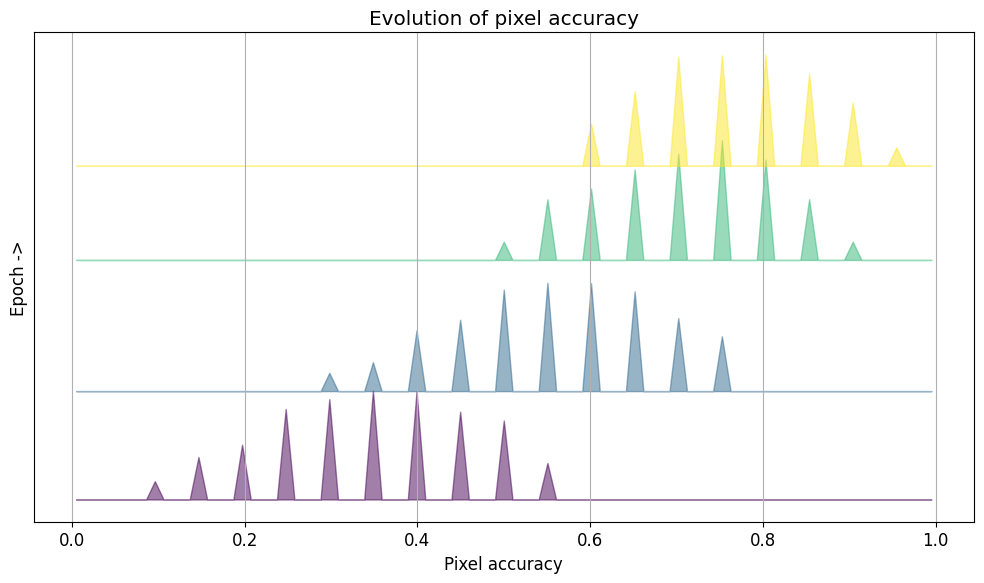

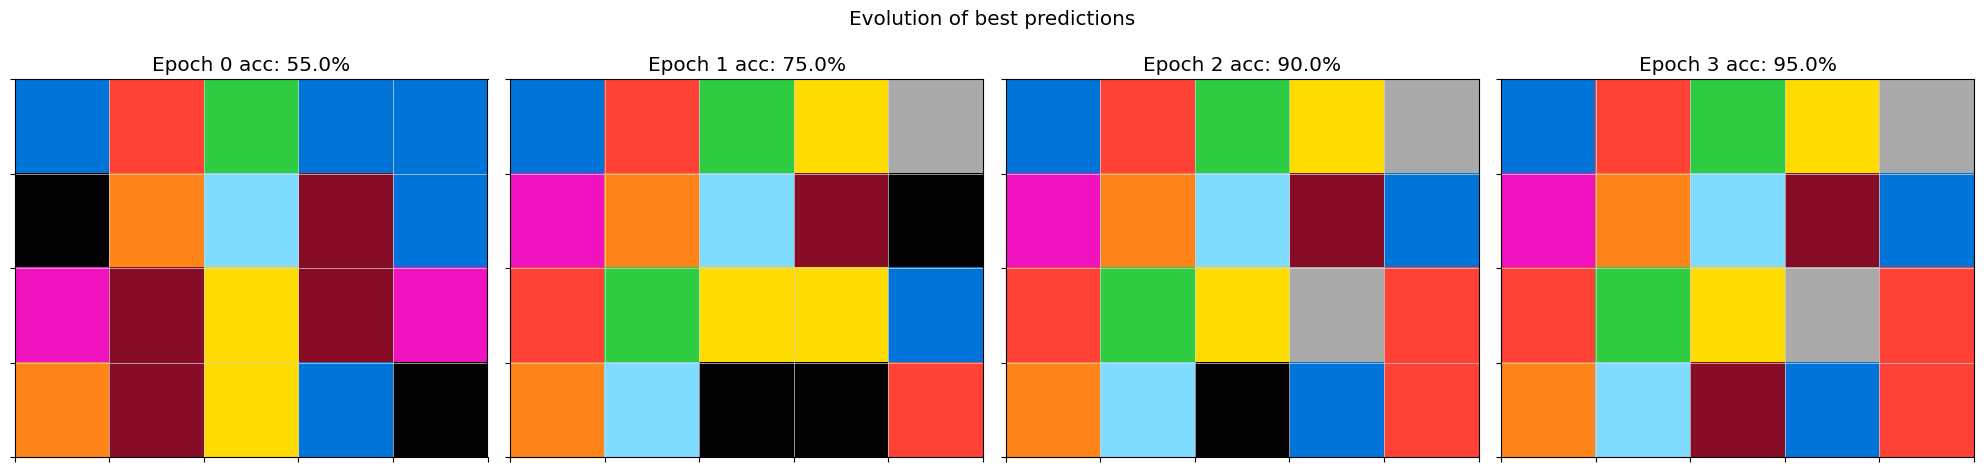

2025-05-07 14:16:29,175 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 14:16:29,251 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/223 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/223 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/223 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/223 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 223
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 14:17:12,801 - arc25.logging - INFO - wrapper - Executed finetuning in 43.6261 seconds
2025-05-07 14:17:12,802 - root - INFO - hindsight_experience_replay - Starting epoch 4...
2025-05-07 14:17:12,803 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 14:17:49,740 - root - INFO - inference - Number of unique outputs: 105/256
2025-05-07 14:17:49,743 - root - INFO - inference - Max pixel accuracy: 1.0
2025-05-07 14:17:49,746 - arc25.logging - INFO - wrapper - Executed inference in 36.9424 seconds


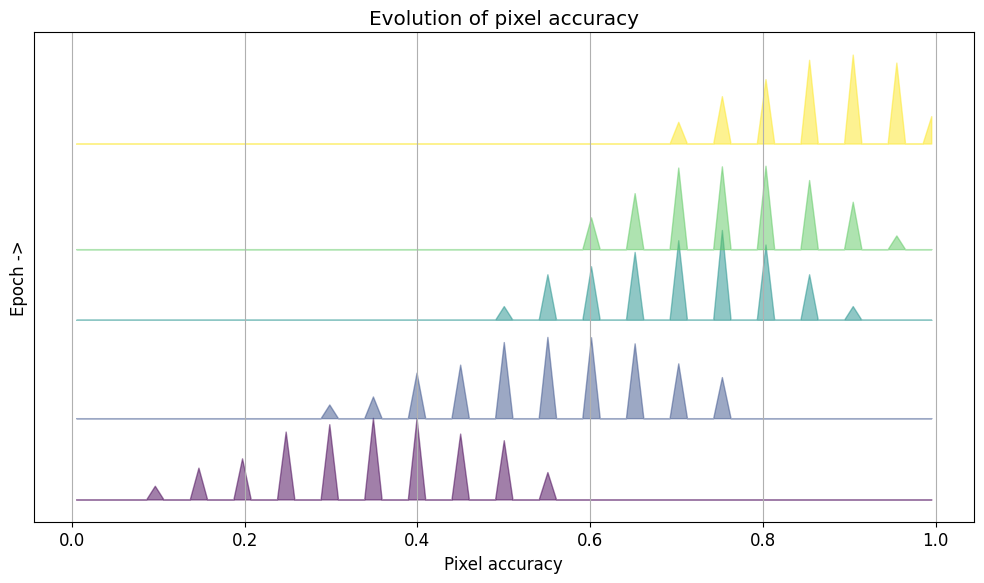

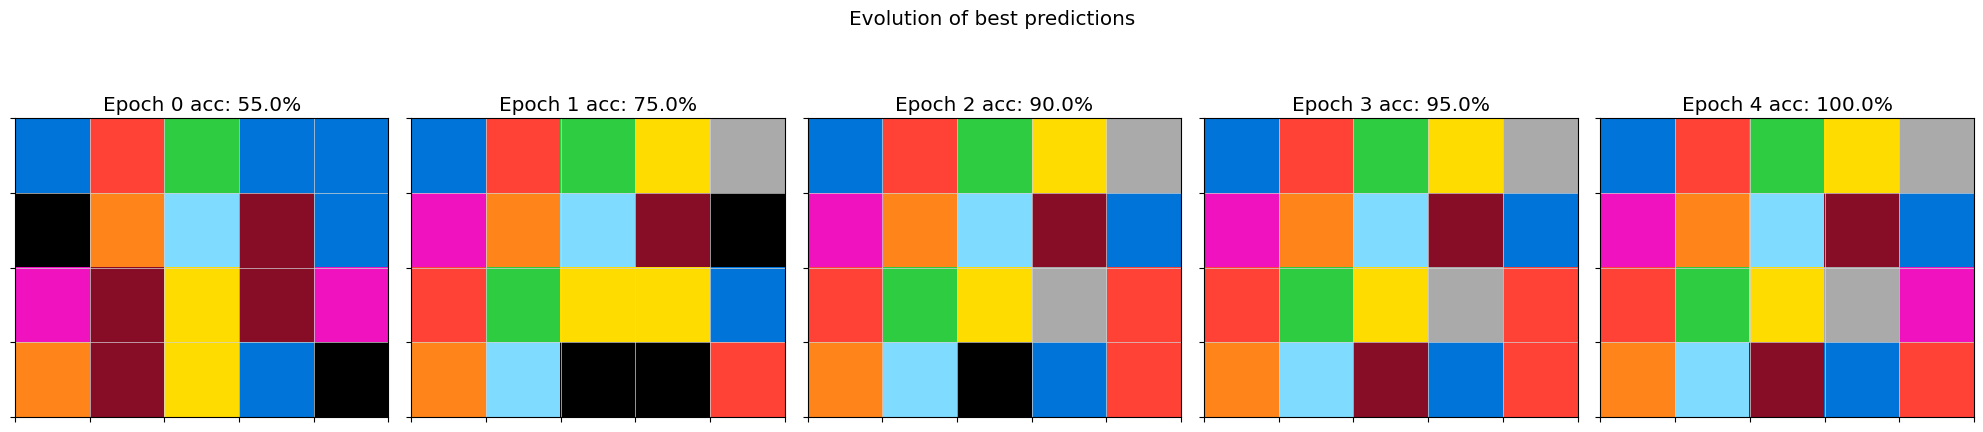

2025-05-07 14:17:50,239 - arc25.input_generation - INFO - hindsight_experience_replay - Found a perfect prediction at epoch 4!


# Best prediction code

```python
def task(img):
    draw_horizontal_line(img, y=2, color=2)
    draw_rectangle(img, point1=(0, 2), point2=(2, 3), color=4)
    draw_vertical_line(img, x=1, color=8)
    draw_pixel(img, point=(0, 0), color=1)
    draw_line(img, point1=(0, 1), point2=(2, 3), color=5)
    draw_line(img, point1=(0, 2), point2=(2, 4), color=6)
    draw_pixel(img, point=(0, 4), color=5)
    draw_pixel(img, point=(0, 2), color=3)
    draw_pixel(img, point=(0, 1), color=2)
    draw_pixel(img, point=(3, 0), color=7)
    draw_line(img, point1=(1, 0), point2=(3, 2), color=9)
    draw_pixel(img, point=(3, 3), color=1)
    draw_pixel(img, point=(1, 0), color=6)
    draw_pixel(img, point=(3, 4), color=2)
    draw_pixel(img, point=(1, 1), color=7)
    draw_pixel(img, point=(1, 2), color=8)
    draw_pixel(img, point=(1, 3), color=9)
    draw_pixel(img, point=(2, 1), color=3)
    draw_pixel(img, point=(1, 4), color=1)
    return img
```

2025-05-07 14:17:50,324 - arc25.logging - INFO - wrapper - Executed hindsight_experience_replay in 341.7490 seconds


In [ ]:
input_img = create_img((4, 5), color=0)
output_img = input_img.copy()
color = 0
for y in range(0, input_img.shape[0], 1):
    for x in range(0, input_img.shape[1], 1):
        color = (color + 1) % 10
        if color == 0: color = 1
        draw_pixel(output_img, (y, x), color=color)
task = Task(inputs=[input_img], outputs=[output_img], code='', name='manual')
hindsight_experience_replay(task, Config());

#### 25 pixels

2025-05-07 14:17:50,379 - arc25.logging - INFO - wrapper - Executing hindsight_experience_replay...


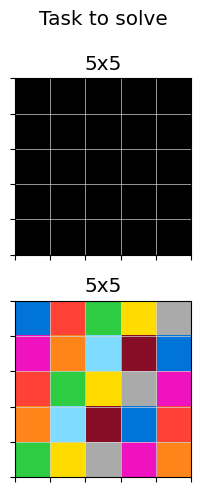

2025-05-07 14:17:50,531 - arc25.logging - INFO - wrapper - Executing load_model...
2025-05-07 14:17:50,532 - root - INFO - load_model - Loading model from /home/gbarbadillo/models/Qwen2.5-Coder-0.5B-Instruct and LoRA from /mnt/hdd0/Kaggle/arc25/trainings/20250430_first_trainings/steps_6400/checkpoint-6400
loading configuration file /home/gbarbadillo/models/Qwen2.5-Coder-0.5B-Instruct/config.json
Model config Qwen2Config {
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "eos_token_id": 151645,
  "hidden_act": "silu",
  "hidden_size": 896,
  "initializer_range": 0.02,
  "intermediate_size": 4864,
  "max_position_embeddings": 32768,
  "max_window_layers": 24,
  "model_type": "qwen2",
  "num_attention_heads": 14,
  "num_hidden_layers": 24,
  "num_key_value_heads": 2,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 1000000.0,
  "sliding_window": 32768,
  "tie_word_embeddings": true,
  "torch_dtype": "bfloat16",
  "tra

  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 14:18:19,437 - root - INFO - inference - Number of unique outputs: 256/256
2025-05-07 14:18:19,440 - root - INFO - inference - Max pixel accuracy: 0.48
2025-05-07 14:18:19,444 - arc25.logging - INFO - wrapper - Executed inference in 27.7832 seconds


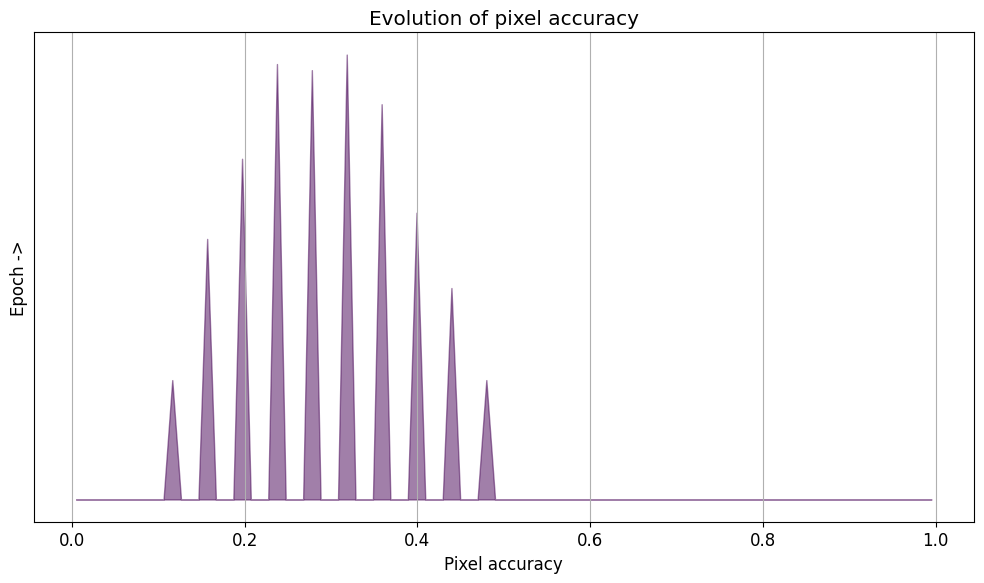

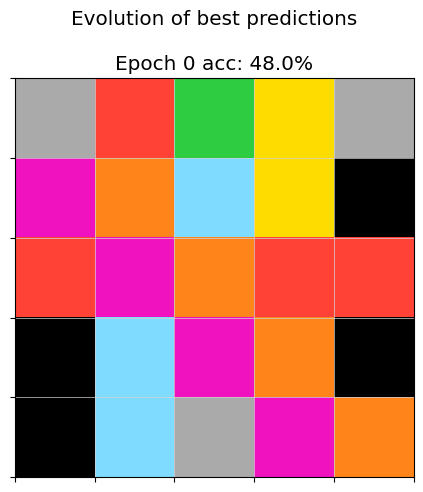

2025-05-07 14:18:19,588 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 14:18:19,671 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/256 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 256
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 256
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 14:19:10,501 - arc25.logging - INFO - wrapper - Executed finetuning in 50.9116 seconds
2025-05-07 14:19:10,502 - root - INFO - hindsight_experience_replay - Starting epoch 1...
2025-05-07 14:19:10,503 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 14:19:44,631 - root - INFO - inference - Number of unique outputs: 256/256
2025-05-07 14:19:44,636 - root - INFO - inference - Max pixel accuracy: 0.68
2025-05-07 14:19:44,639 - arc25.logging - INFO - wrapper - Executed inference in 34.1354 seconds


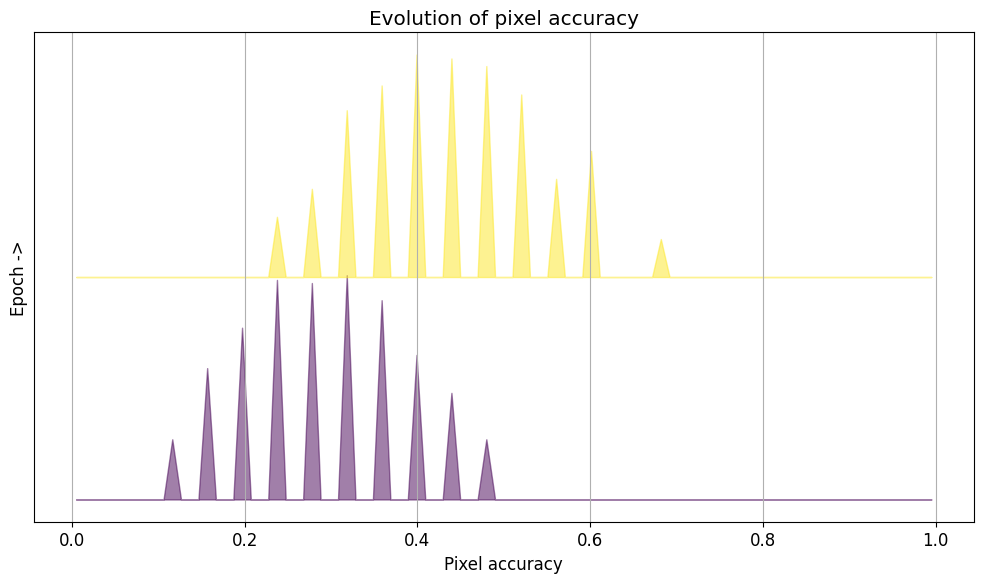

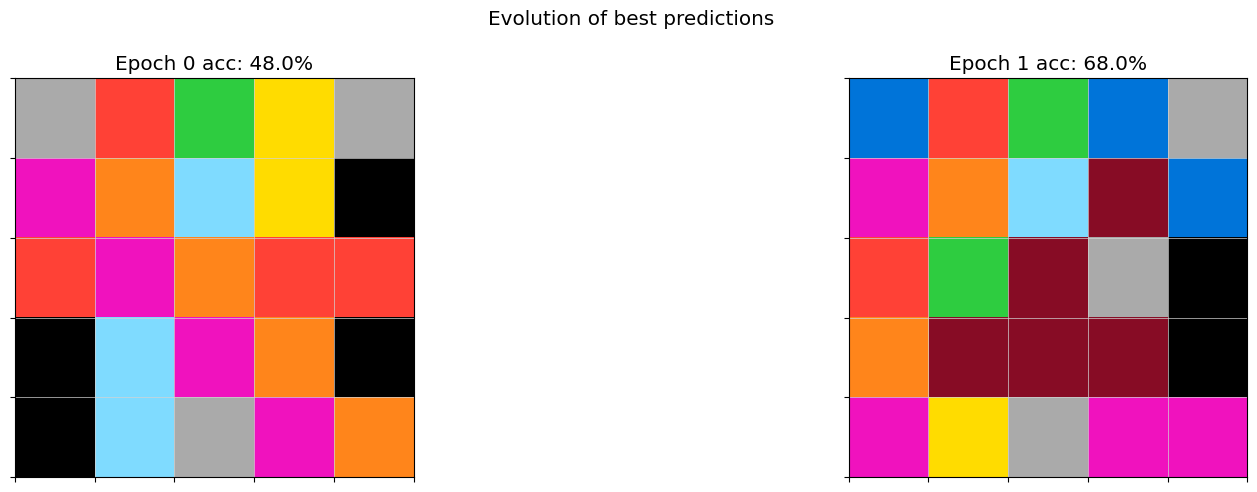

2025-05-07 14:19:44,854 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 14:19:44,936 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/256 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 256
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 256
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 14:20:37,434 - arc25.logging - INFO - wrapper - Executed finetuning in 52.5782 seconds
2025-05-07 14:20:37,435 - root - INFO - hindsight_experience_replay - Starting epoch 2...
2025-05-07 14:20:37,435 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 14:21:15,906 - root - INFO - inference - Number of unique outputs: 256/256
2025-05-07 14:21:15,912 - root - INFO - inference - Max pixel accuracy: 0.72
2025-05-07 14:21:15,916 - arc25.logging - INFO - wrapper - Executed inference in 38.4804 seconds


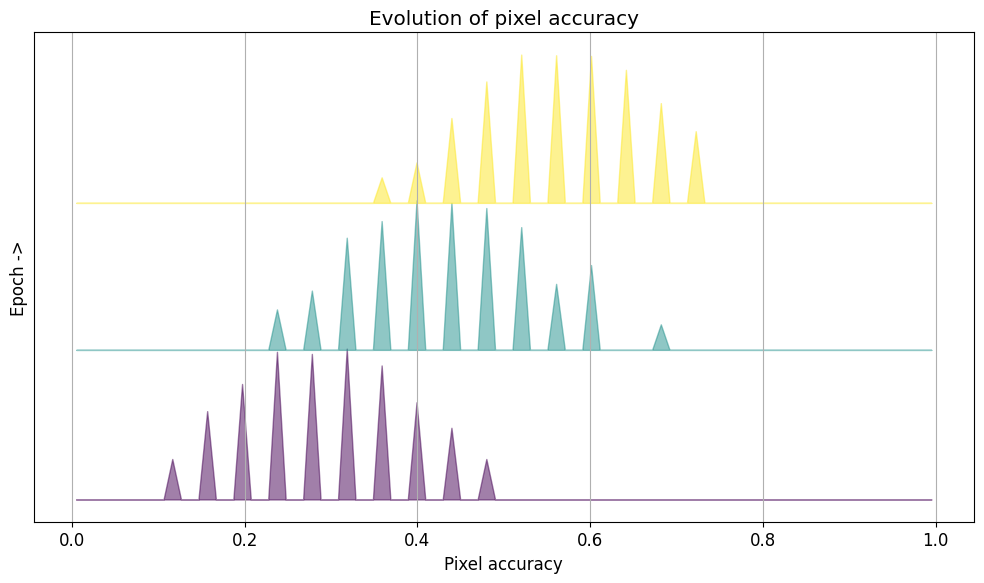

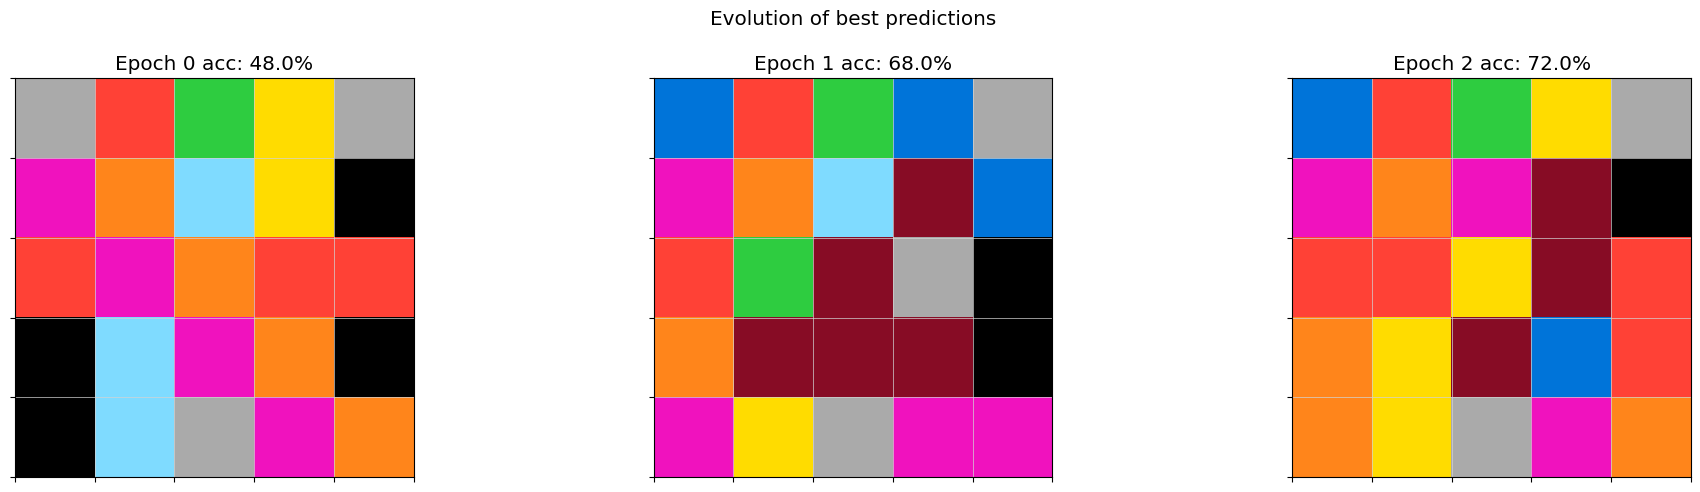

2025-05-07 14:21:16,218 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 14:21:16,341 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/256 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 256
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 256
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 14:22:03,943 - arc25.logging - INFO - wrapper - Executed finetuning in 47.7245 seconds
2025-05-07 14:22:03,945 - root - INFO - hindsight_experience_replay - Starting epoch 3...
2025-05-07 14:22:03,946 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 14:22:45,115 - root - INFO - inference - Number of unique outputs: 254/256
2025-05-07 14:22:45,120 - root - INFO - inference - Max pixel accuracy: 0.8
2025-05-07 14:22:45,135 - arc25.logging - INFO - wrapper - Executed inference in 41.1882 seconds


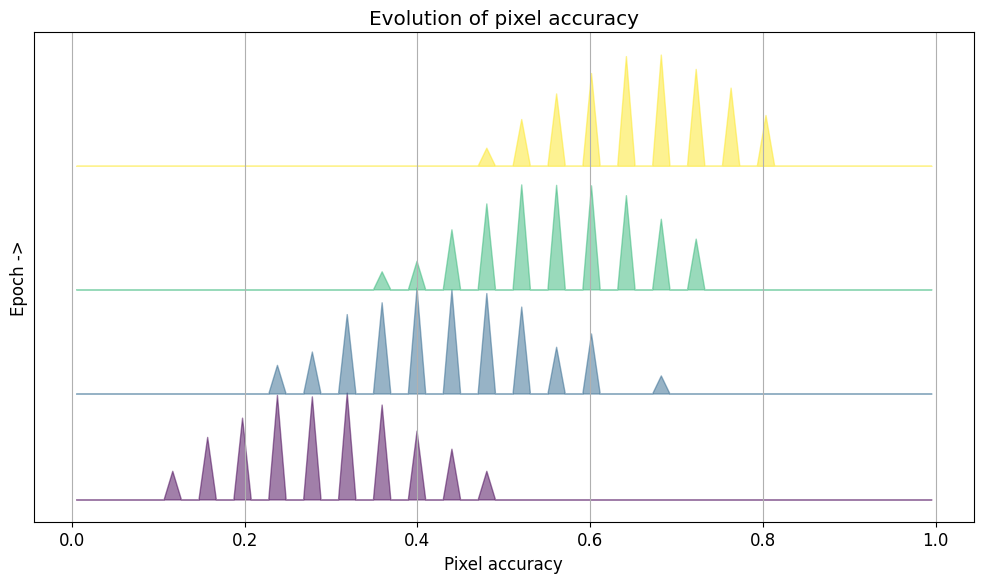

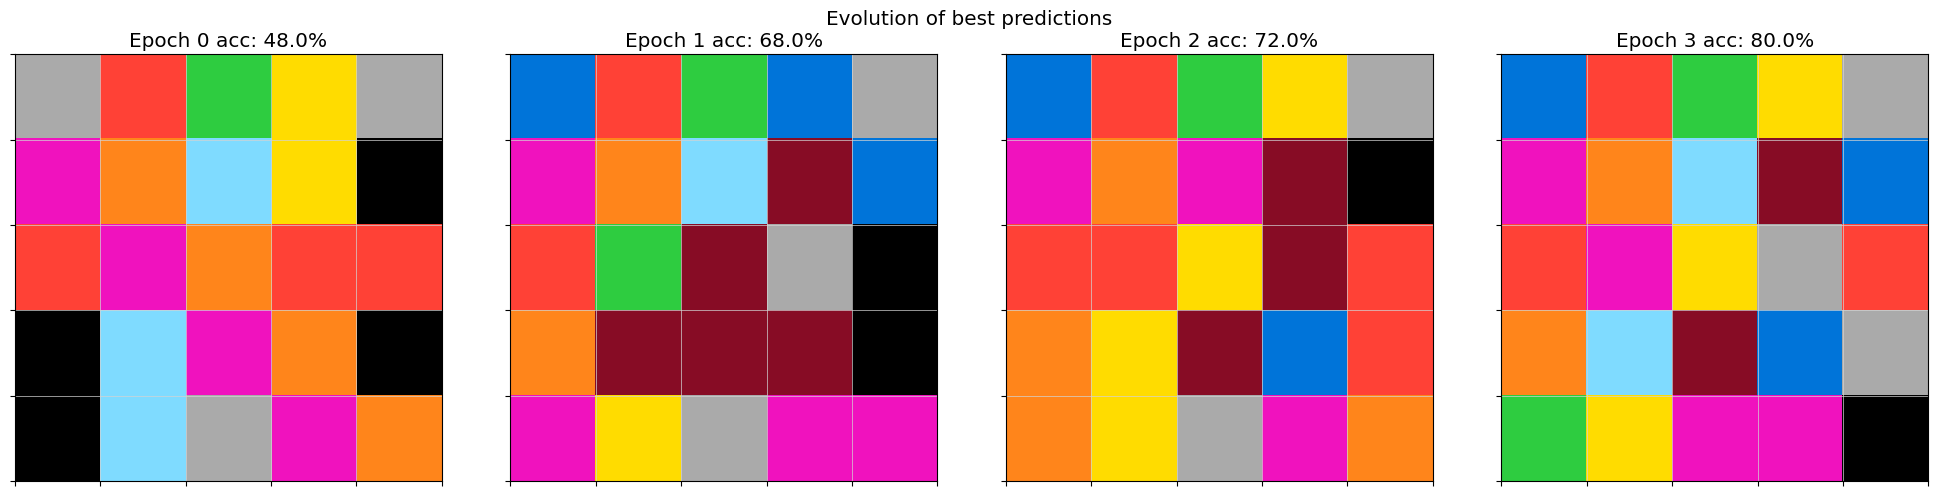

2025-05-07 14:22:45,484 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 14:22:45,585 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/254 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/254 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/254 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/254 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 254
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 254
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 14:23:35,993 - arc25.logging - INFO - wrapper - Executed finetuning in 50.5081 seconds
2025-05-07 14:23:35,994 - root - INFO - hindsight_experience_replay - Starting epoch 4...
2025-05-07 14:23:35,995 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 14:24:17,795 - root - INFO - inference - Number of unique outputs: 218/256
2025-05-07 14:24:17,800 - root - INFO - inference - Max pixel accuracy: 0.88
2025-05-07 14:24:17,811 - arc25.logging - INFO - wrapper - Executed inference in 41.8151 seconds


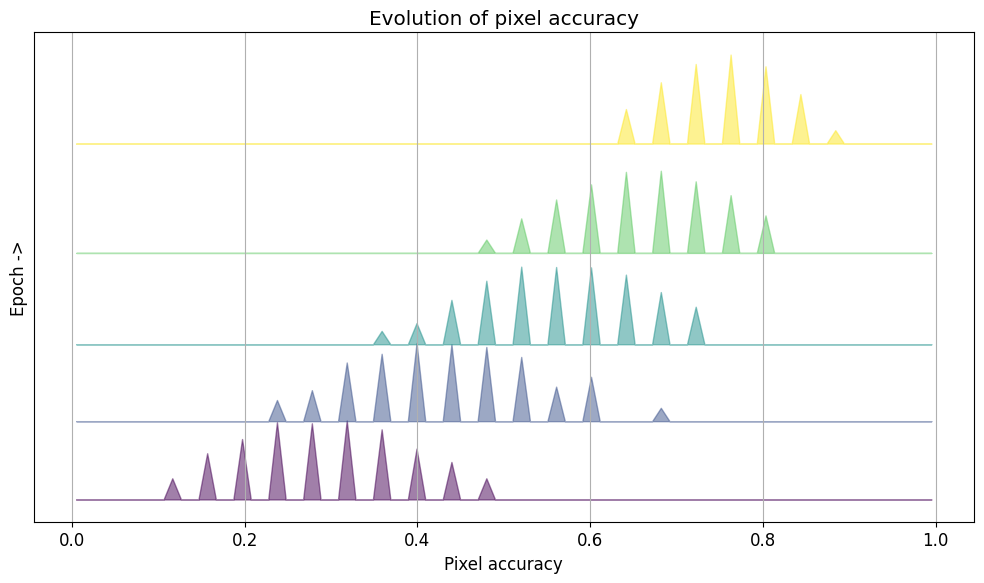

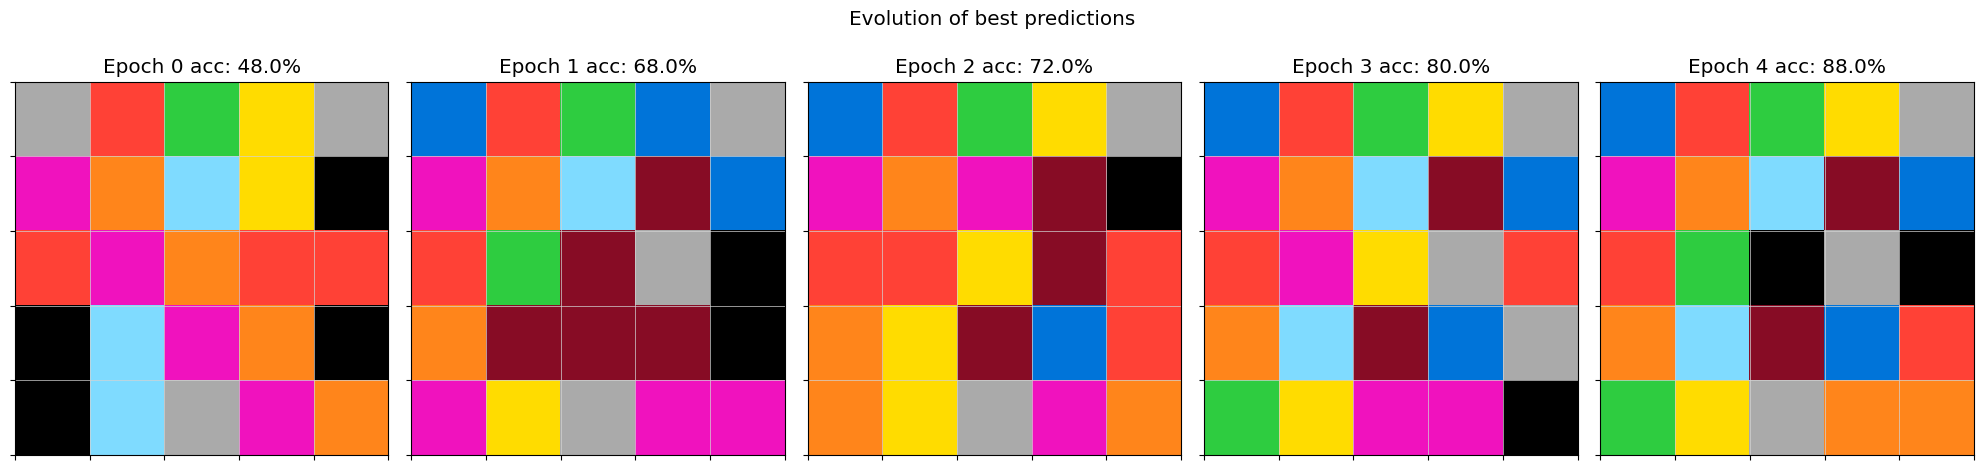

2025-05-07 14:24:18,178 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 14:24:18,257 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/218 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/218 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/218 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/218 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 218
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 218
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 14:25:00,635 - arc25.logging - INFO - wrapper - Executed finetuning in 42.4568 seconds
2025-05-07 14:25:00,636 - root - INFO - hindsight_experience_replay - Starting epoch 5...
2025-05-07 14:25:00,637 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 14:25:47,274 - root - INFO - inference - Number of unique outputs: 159/256
2025-05-07 14:25:47,281 - root - INFO - inference - Max pixel accuracy: 0.92
2025-05-07 14:25:47,284 - arc25.logging - INFO - wrapper - Executed inference in 46.6464 seconds


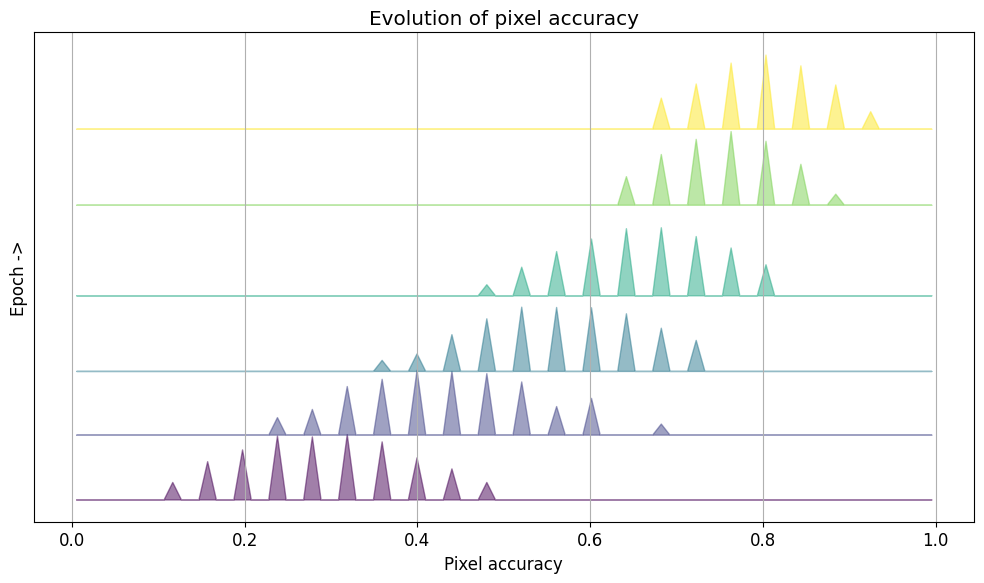

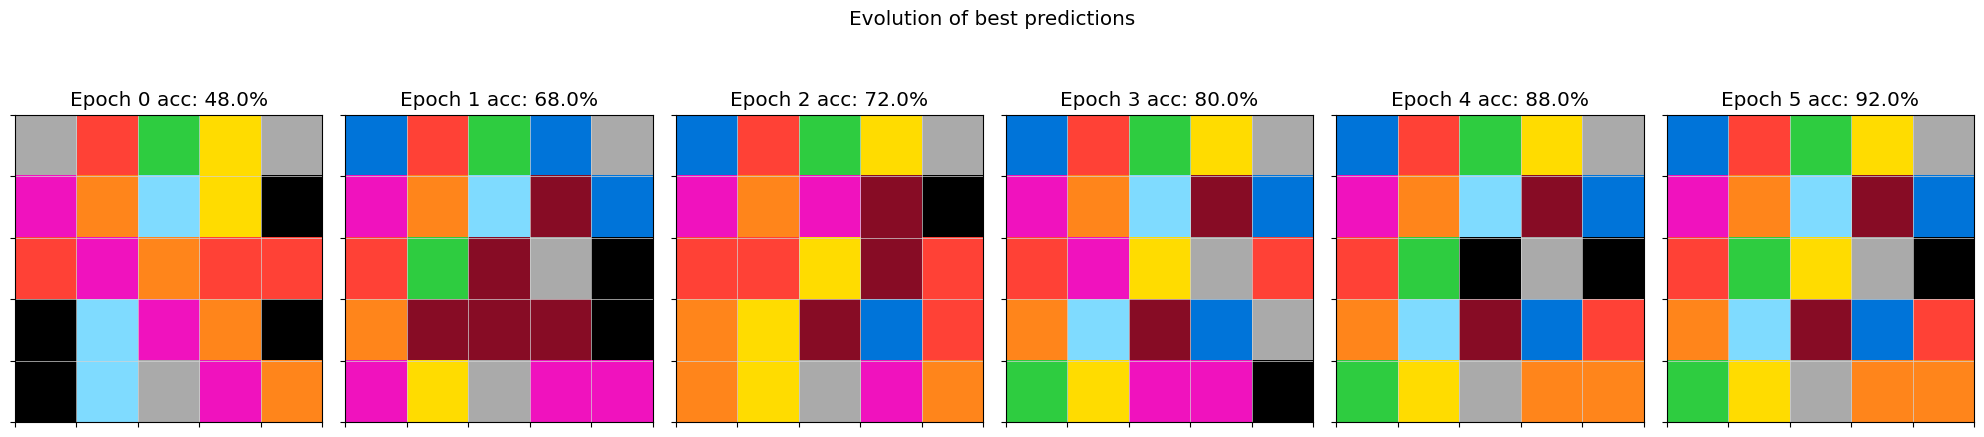

2025-05-07 14:25:47,677 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 14:25:47,743 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/159 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/159 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/159 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/159 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 159
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 159
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 14:26:19,908 - arc25.logging - INFO - wrapper - Executed finetuning in 32.2298 seconds
2025-05-07 14:26:19,909 - root - INFO - hindsight_experience_replay - Starting epoch 6...
2025-05-07 14:26:19,910 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 14:27:11,273 - root - INFO - inference - Number of unique outputs: 166/256
2025-05-07 14:27:11,278 - root - INFO - inference - Max pixel accuracy: 0.96
2025-05-07 14:27:11,281 - arc25.logging - INFO - wrapper - Executed inference in 51.3705 seconds


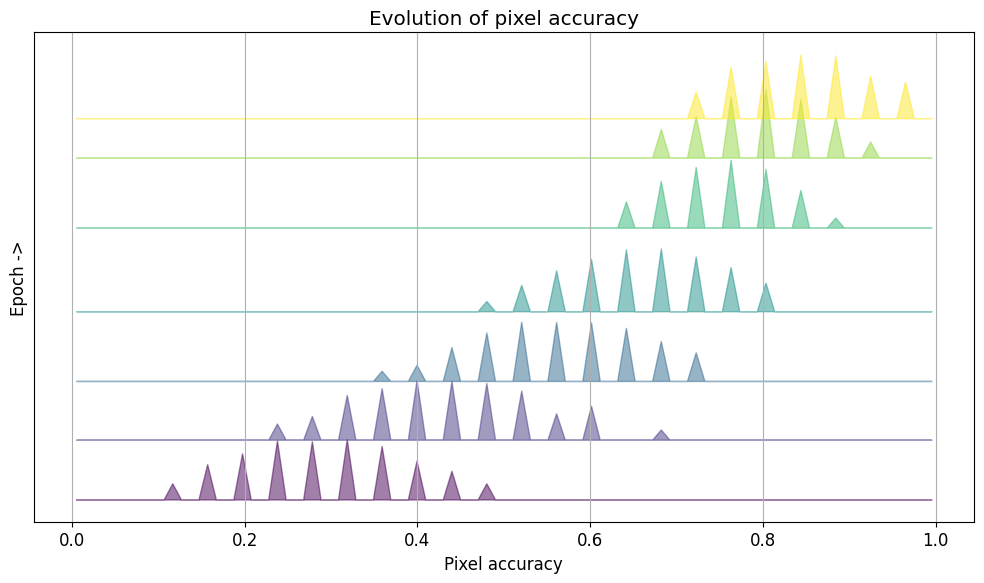

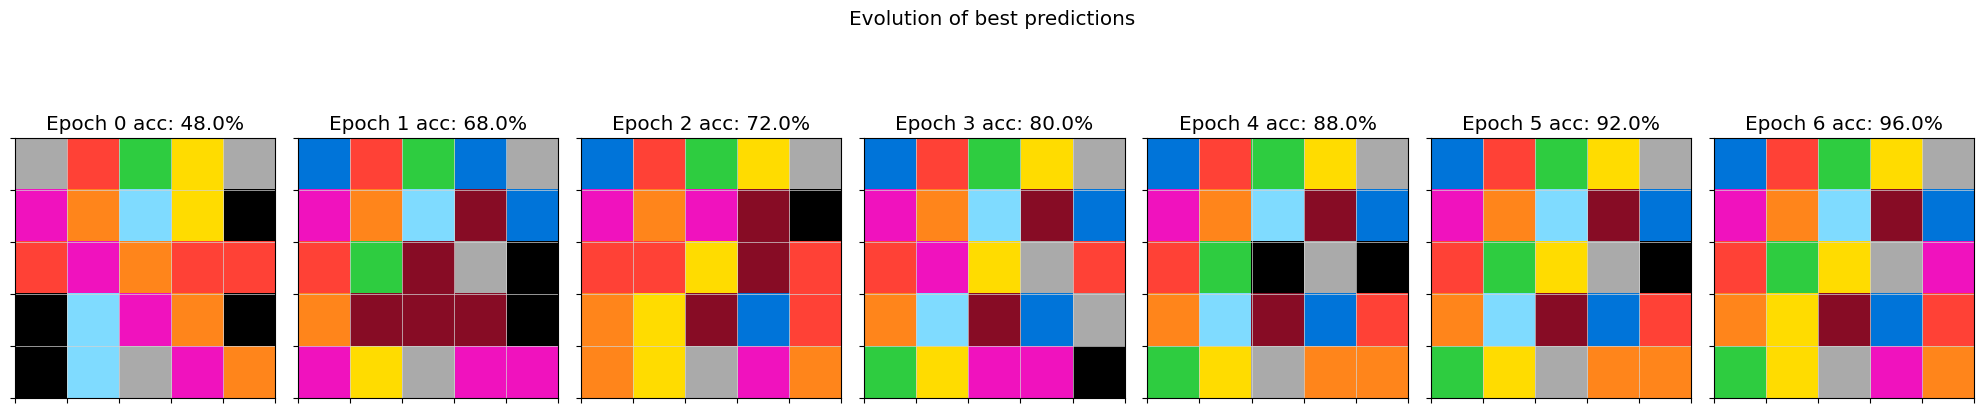

2025-05-07 14:27:11,768 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 14:27:11,874 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/166 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/166 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/166 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/166 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 166
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 166
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 14:27:43,901 - arc25.logging - INFO - wrapper - Executed finetuning in 32.1322 seconds
2025-05-07 14:27:43,902 - root - INFO - hindsight_experience_replay - Starting epoch 7...
2025-05-07 14:27:43,902 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 14:28:33,695 - root - INFO - inference - Number of unique outputs: 53/256
2025-05-07 14:28:33,701 - root - INFO - inference - Max pixel accuracy: 1.0
2025-05-07 14:28:33,706 - arc25.logging - INFO - wrapper - Executed inference in 49.8038 seconds


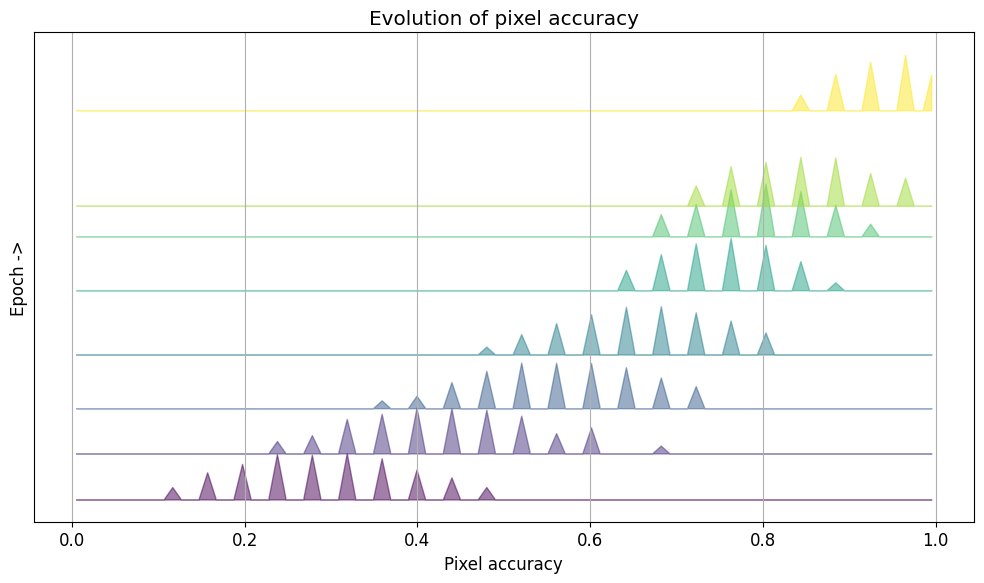

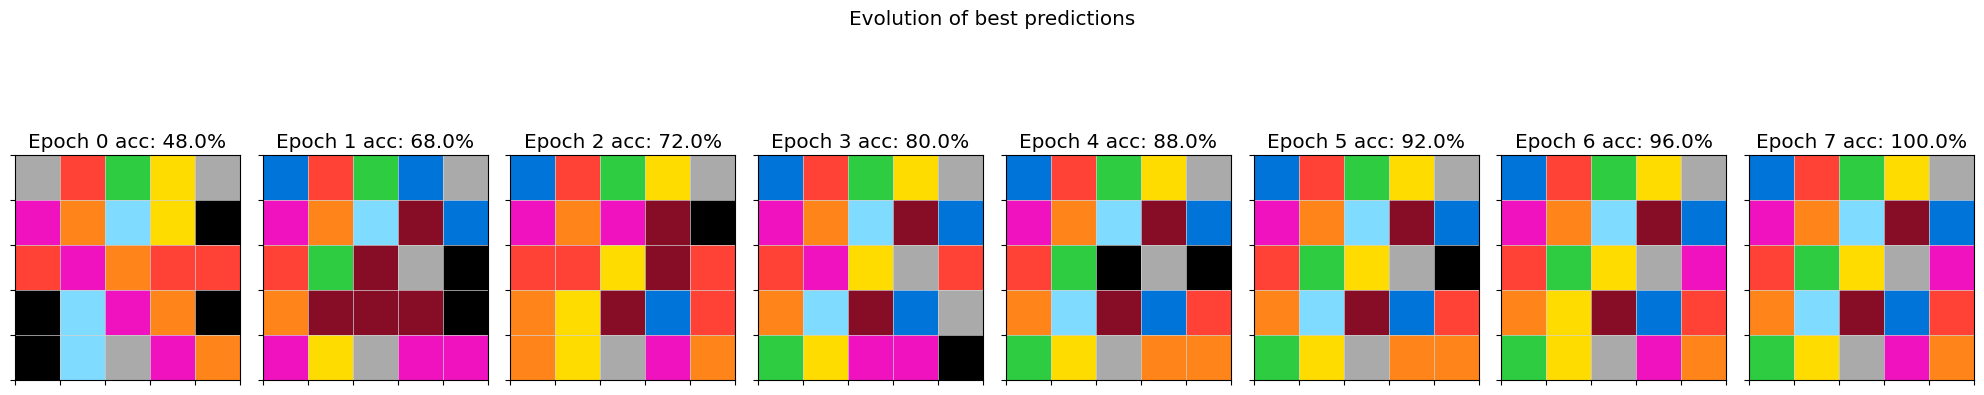

2025-05-07 14:28:34,177 - arc25.input_generation - INFO - hindsight_experience_replay - Found a perfect prediction at epoch 7!


# Best prediction code

```python
def task(img):
    draw_horizontal_line(img, y=0, color=5)
    draw_pixel(img, point=(0, 0), color=1)
    draw_horizontal_line(img, y=4, color=7)
    draw_vertical_line(img, x=1, color=4)
    draw_pixel(img, point=(0, 2), color=3)
    draw_horizontal_line(img, y=2, color=6)
    draw_line(img, point1=(1, 2), point2=(3, 4), color=2)
    draw_line(img, point1=(1, 2), point2=(3, 2), color=8)
    draw_line(img, point1=(1, 3), point2=(3, 3), color=5)
    draw_pixel(img, point=(0, 3), color=4)
    draw_pixel(img, point=(0, 1), color=2)
    draw_pixel(img, point=(4, 0), color=3)
    draw_pixel(img, point=(3, 0), color=7)
    draw_pixel(img, point=(3, 2), color=9)
    draw_pixel(img, point=(3, 3), color=1)
    draw_pixel(img, point=(4, 2), color=5)
    draw_pixel(img, point=(3, 1), color=8)
    draw_pixel(img, point=(4, 3), color=6)
    draw_pixel(img, point=(1, 0), color=6)
    draw_pixel(img, point=(1, 1), color=7)
    draw_pixel(img, point=(1, 3), color=9)
    draw_pixel(img, point=(1, 4), color=1)
    draw_pixel(img, point=(2, 1), color=3)
    draw_pixel(img, point=(2, 0), color=2)
    draw_pixel(img, point=(2, 2), color=4)
    return img
```

2025-05-07 14:28:34,237 - arc25.logging - INFO - wrapper - Executed hindsight_experience_replay in 643.8568 seconds


In [ ]:
input_img = create_img((5, 5), color=0)
output_img = input_img.copy()
color = 0
for y in range(0, input_img.shape[0], 1):
    for x in range(0, input_img.shape[1], 1):
        color = (color + 1) % 10
        if color == 0: color = 1
        draw_pixel(output_img, (y, x), color=color)
task = Task(inputs=[input_img], outputs=[output_img], code='', name='manual')
hindsight_experience_replay(task, Config());

## Weaker models

What if I try weaker models? (Models that have been trained for a shorter time)

### 400 training epochs

#### 9 vertical lines

2025-05-07 14:28:34,285 - arc25.logging - INFO - wrapper - Executing hindsight_experience_replay...


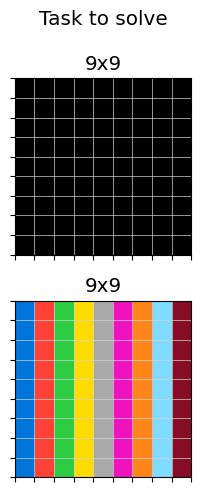

2025-05-07 14:28:34,437 - arc25.logging - INFO - wrapper - Executing load_model...
2025-05-07 14:28:34,438 - root - INFO - load_model - Loading model from /home/gbarbadillo/models/Qwen2.5-Coder-0.5B-Instruct and LoRA from /mnt/hdd0/Kaggle/arc25/trainings/20250430_first_trainings/steps_400/checkpoint-400
loading configuration file /home/gbarbadillo/models/Qwen2.5-Coder-0.5B-Instruct/config.json
Model config Qwen2Config {
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "eos_token_id": 151645,
  "hidden_act": "silu",
  "hidden_size": 896,
  "initializer_range": 0.02,
  "intermediate_size": 4864,
  "max_position_embeddings": 32768,
  "max_window_layers": 24,
  "model_type": "qwen2",
  "num_attention_heads": 14,
  "num_hidden_layers": 24,
  "num_key_value_heads": 2,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 1000000.0,
  "sliding_window": 32768,
  "tie_word_embeddings": true,
  "torch_dtype": "bfloat16",
  "trans

  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 14:28:51,167 - root - INFO - inference - Number of unique outputs: 242/253
2025-05-07 14:28:51,168 - root - INFO - inference - Max pixel accuracy: 0.6666666666666666
2025-05-07 14:28:51,172 - arc25.logging - INFO - wrapper - Executed inference in 15.4351 seconds


Error executing code: def task(img):
    draw_rectangle(img, point1=(0, 0), point2=(8, 6), color=1)
    draw_vertical_line(img, x=1, color=2)
    draw_horizontal_line(img, y=3, color=3)
    draw_vertical_line(img, x=4, color=4)
    draw_vertical_line(img, x=7, color=5)
    draw_vertical_line(img, x=8, color=6)
    draw_vertical_line(img, x=9, color=7)
    return img
index 9 is out of bounds for axis 1 with size 9
Error executing code: def task(img):
    draw_rectangle(img, point1=(0, 0), point2=(8, 7), color=1)
    draw_vertical_line(img, x=0, color=2)
    draw_vertical_line(img, x=3, color=4)
    draw_vertical_line(img, x=5, color=5)
    draw_vertical_line(img, x=8, color=7)
    draw_vertical_line(img, x=9, color=9)
    return img
index 9 is out of bounds for axis 1 with size 9
Error executing code: def task(img):
    draw_vertical_line(img, x=0, color=1)
    draw_vertical_line(img, x=2, color=2)
    draw_rectangle(img, point1=(0, 3), point2=(8, 7), color=4)
    draw_horizontal_line(i

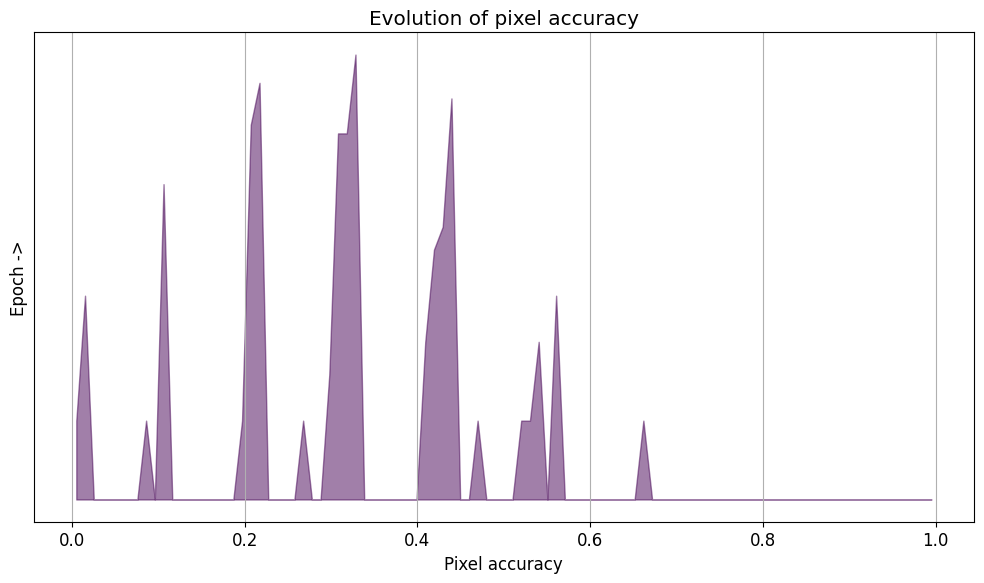

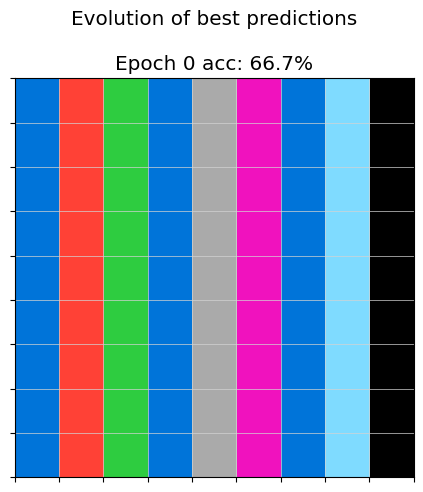

2025-05-07 14:28:51,326 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 14:28:51,410 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/242 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/242 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/242 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/242 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 242
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 242
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 14:29:37,166 - arc25.logging - INFO - wrapper - Executed finetuning in 45.8400 seconds
2025-05-07 14:29:37,168 - root - INFO - hindsight_experience_replay - Starting epoch 1...
2025-05-07 14:29:37,169 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 14:29:54,062 - root - INFO - inference - Number of unique outputs: 44/256
2025-05-07 14:29:54,063 - root - INFO - inference - Max pixel accuracy: 0.5555555555555556
2025-05-07 14:29:54,066 - arc25.logging - INFO - wrapper - Executed inference in 16.8959 seconds


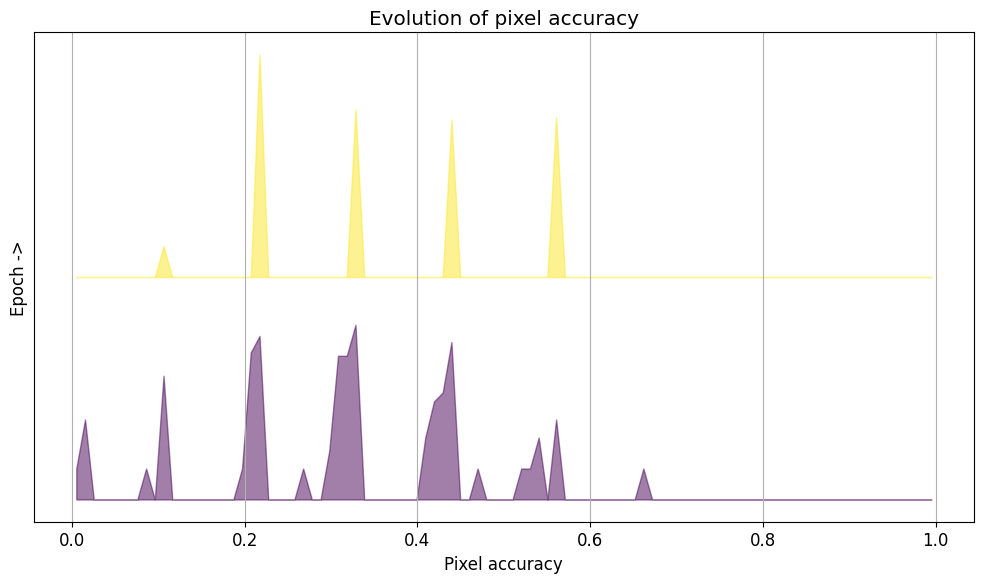

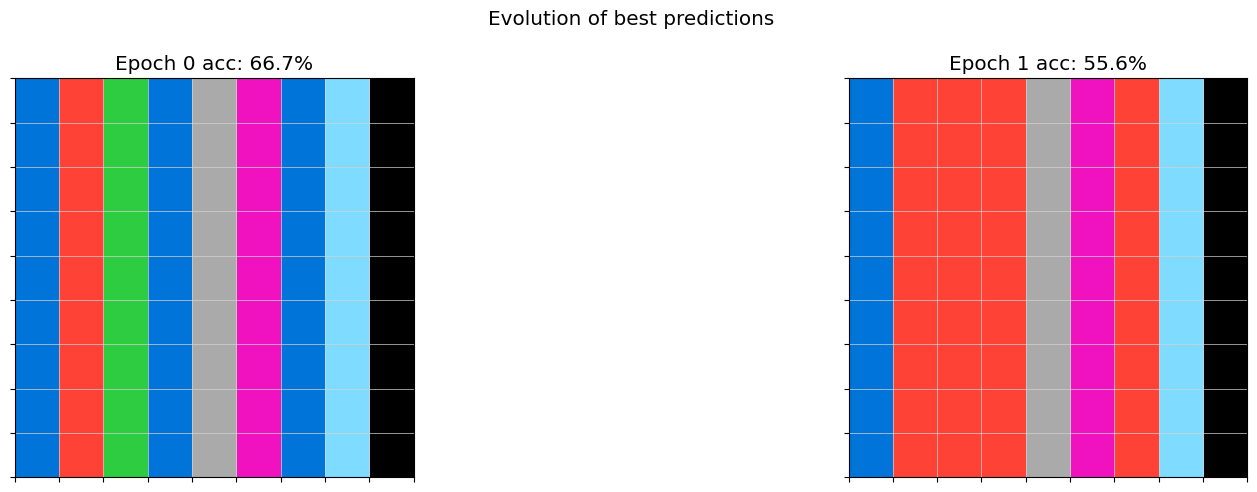

2025-05-07 14:29:54,326 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 14:29:54,378 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/44 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/44 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/44 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/44 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 44
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 44
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 14:30:03,098 - arc25.logging - INFO - wrapper - Executed finetuning in 8.7709 seconds
2025-05-07 14:30:03,099 - root - INFO - hindsight_experience_replay - Starting epoch 2...
2025-05-07 14:30:03,100 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 14:30:20,268 - root - INFO - inference - Number of unique outputs: 12/256
2025-05-07 14:30:20,270 - root - INFO - inference - Max pixel accuracy: 0.6666666666666666
2025-05-07 14:30:20,271 - arc25.logging - INFO - wrapper - Executed inference in 17.1711 seconds


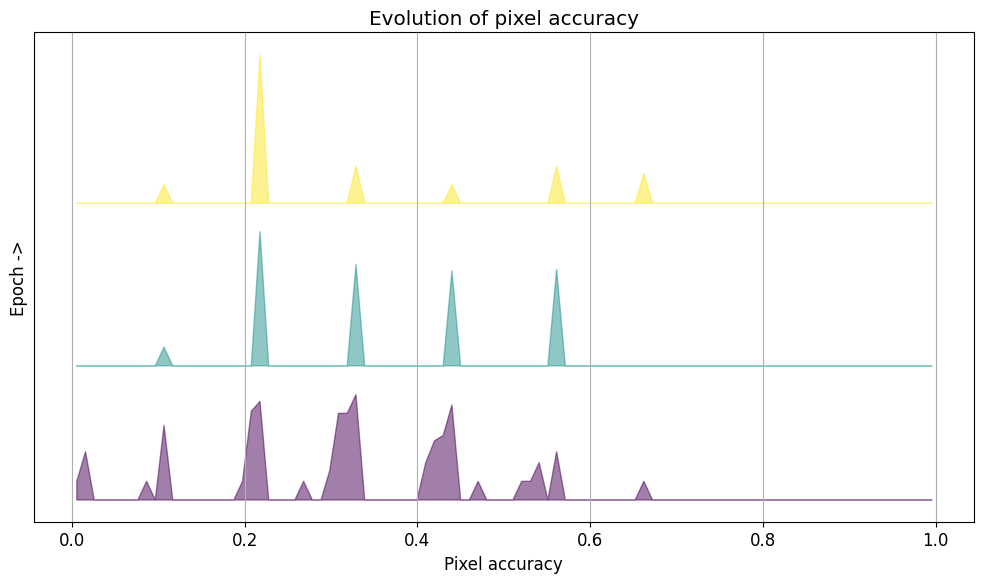

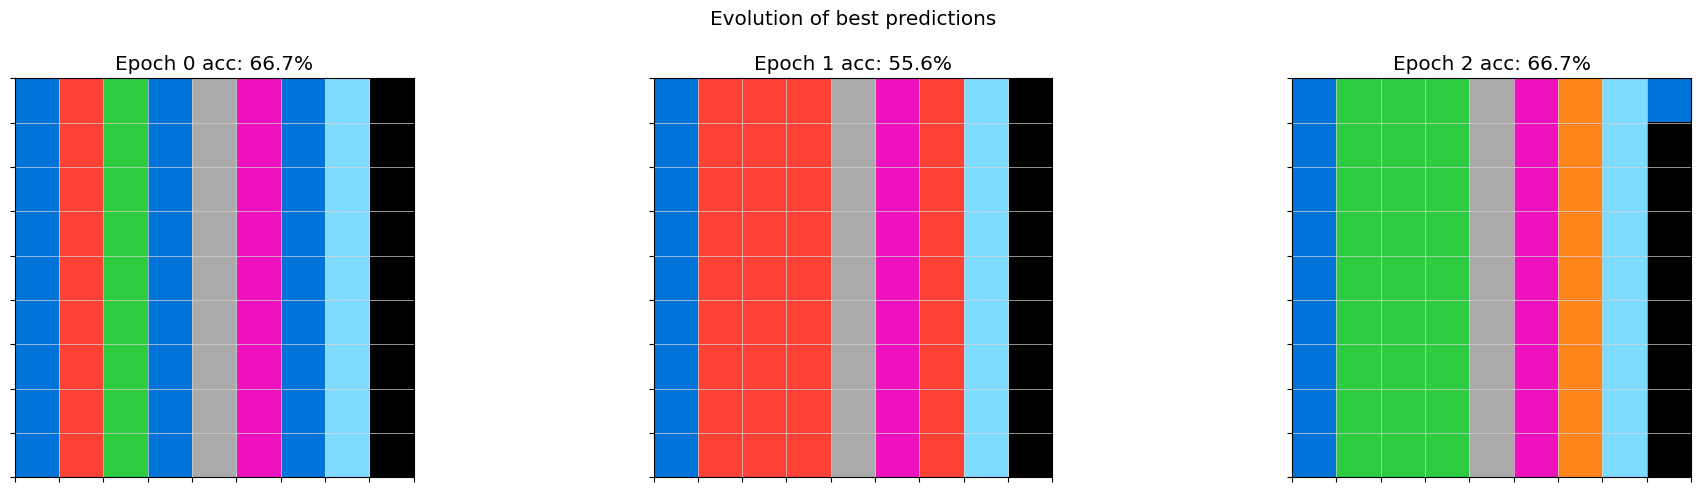

2025-05-07 14:30:20,572 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 14:30:20,627 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/12 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/12 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/12 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/12 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 12
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 12
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 14:30:24,077 - arc25.logging - INFO - wrapper - Executed finetuning in 3.5034 seconds
2025-05-07 14:30:24,078 - root - INFO - hindsight_experience_replay - Starting epoch 3...
2025-05-07 14:30:24,078 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 14:30:41,051 - root - INFO - inference - Number of unique outputs: 9/256
2025-05-07 14:30:41,053 - root - INFO - inference - Max pixel accuracy: 0.8888888888888888
2025-05-07 14:30:41,058 - arc25.logging - INFO - wrapper - Executed inference in 16.9796 seconds


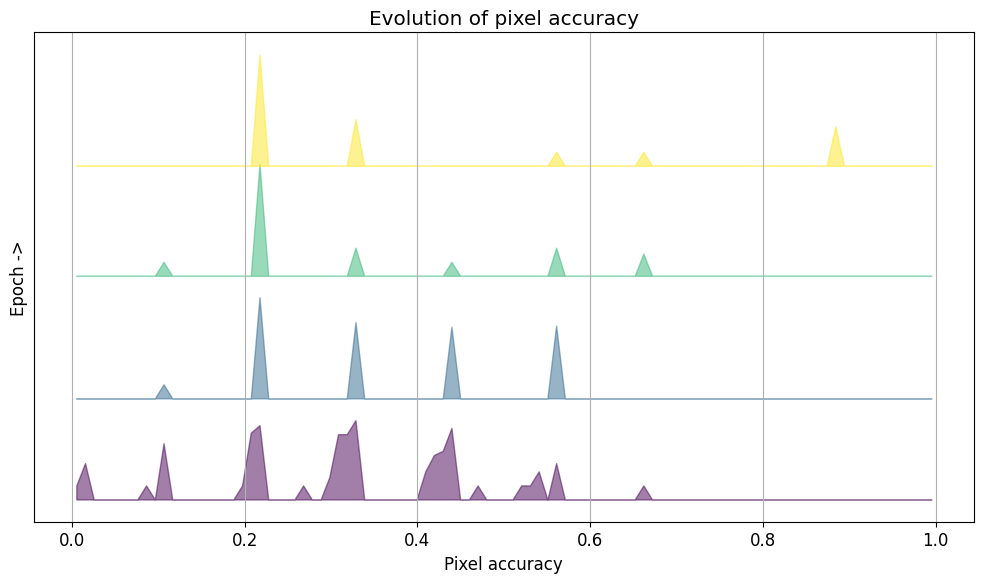

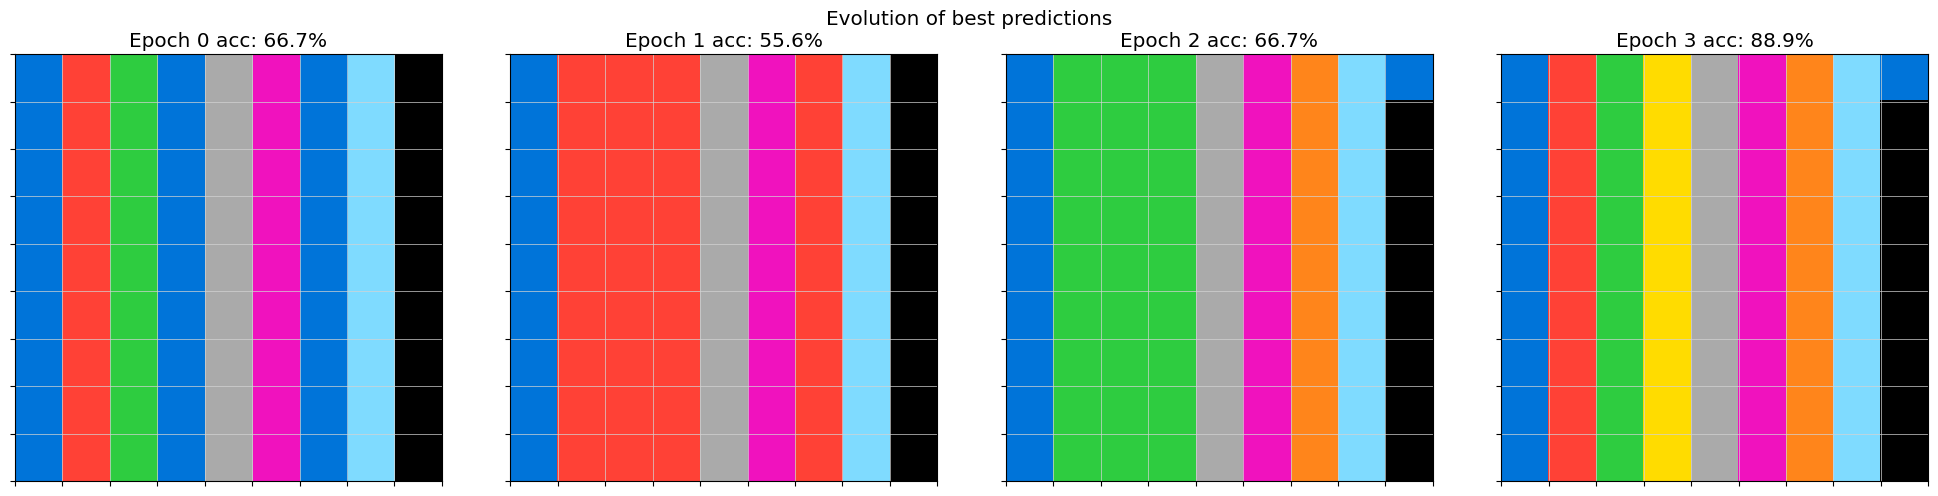

2025-05-07 14:30:41,426 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 14:30:41,482 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/9 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/9 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/9 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/9 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 9
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 14:30:44,073 - arc25.logging - INFO - wrapper - Executed finetuning in 2.6466 seconds
2025-05-07 14:30:44,075 - root - INFO - hindsight_experience_replay - Starting epoch 4...
2025-05-07 14:30:44,075 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 14:31:02,541 - root - INFO - inference - Number of unique outputs: 5/256
2025-05-07 14:31:02,543 - root - INFO - inference - Max pixel accuracy: 0.8888888888888888
2025-05-07 14:31:02,545 - arc25.logging - INFO - wrapper - Executed inference in 18.4692 seconds


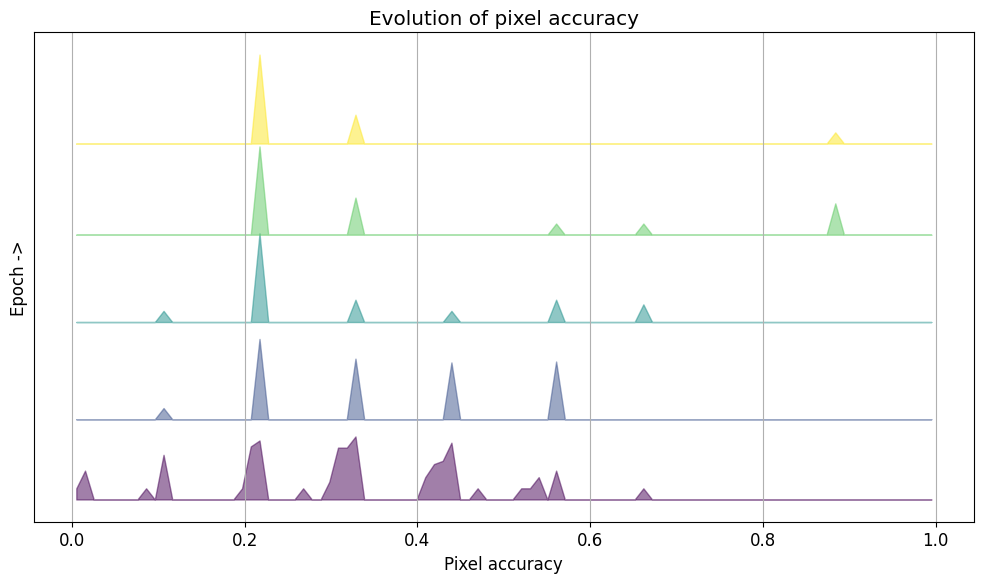

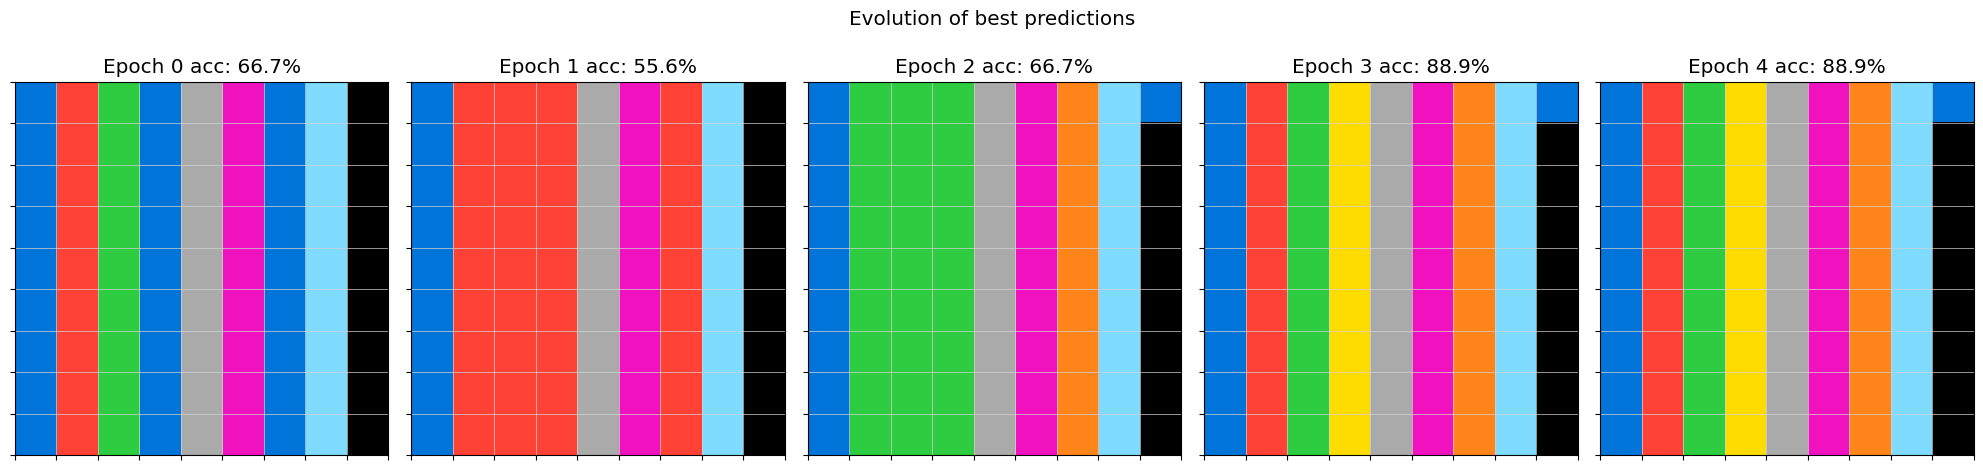

2025-05-07 14:31:02,980 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 14:31:03,036 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/5 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/5 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/5 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/5 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 5
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 5
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 14:31:04,917 - arc25.logging - INFO - wrapper - Executed finetuning in 1.9362 seconds
2025-05-07 14:31:04,918 - root - INFO - hindsight_experience_replay - Starting epoch 5...
2025-05-07 14:31:04,919 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 14:31:23,293 - root - INFO - inference - Number of unique outputs: 5/223
2025-05-07 14:31:23,294 - root - INFO - inference - Max pixel accuracy: 1.0
2025-05-07 14:31:23,298 - arc25.logging - INFO - wrapper - Executed inference in 18.3788 seconds


Error executing code: def task(img):
    draw_vertical_line(img, x=0, color=1)
    draw_rectangle(img, point1=(0, 1), point2=(8, 7), color=2)
    draw_vertical_line(img, x=3, color=3)
    draw_vertical_line(img, x=4, color=4)
    draw_vertical_line(img, x=5, color=5)
    draw_vertical_line(img, x=6, color=6)
    draw_vertical_line(img, x=7, color=7)
    draw_vertical_line(img, x=8, color=8)
    draw_vertical_line(img, x=9, color=9)
    return img
index 9 is out of bounds for axis 1 with size 9
Error executing code: def task(img):
    draw_vertical_line(img, x=0, color=1)
    draw_rectangle(img, point1=(0, 1), point2=(8, 7), color=2)
    draw_vertical_line(img, x=3, color=3)
    draw_vertical_line(img, x=4, color=4)
    draw_vertical_line(img, x=5, color=5)
    draw_vertical_line(img, x=6, color=6)
    draw_vertical_line(img, x=7, color=7)
    draw_vertical_line(img, x=8, color=8)
    draw_vertical_line(img, x=9, color=9)
    return img
index 9 is out of bounds for axis 1 with size 9
Er

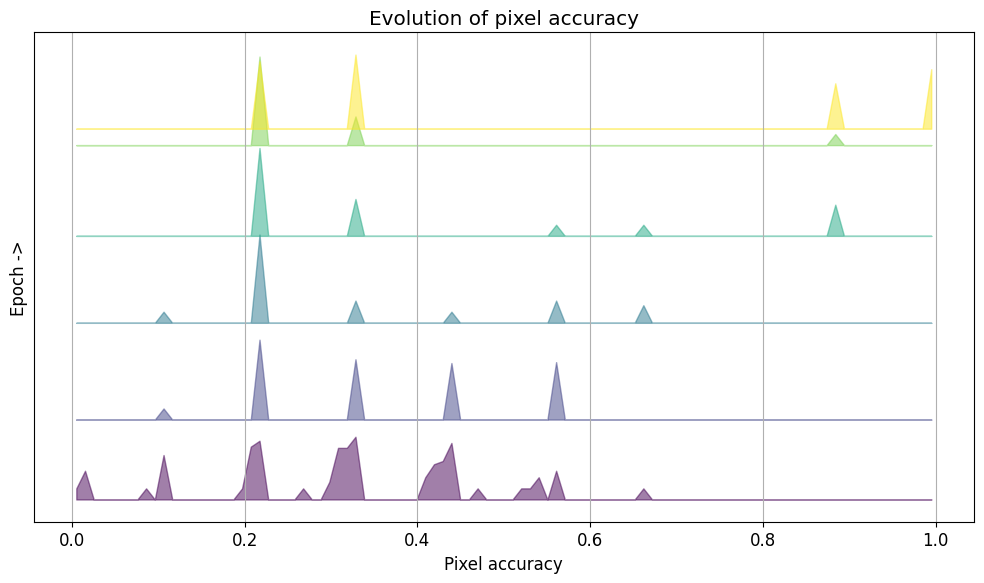

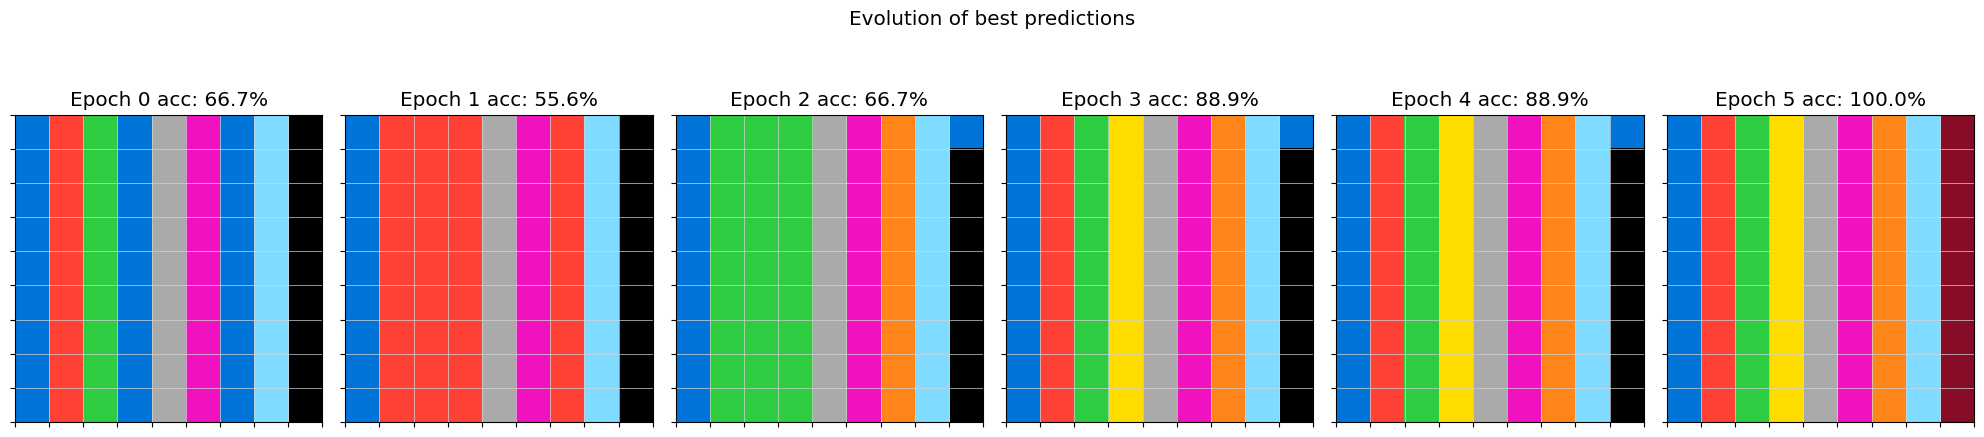

2025-05-07 14:31:23,797 - arc25.input_generation - INFO - hindsight_experience_replay - Found a perfect prediction at epoch 5!


# Best prediction code

```python
def task(img):
    draw_vertical_line(img, x=0, color=1)
    draw_vertical_line(img, x=1, color=2)
    draw_vertical_line(img, x=2, color=3)
    draw_vertical_line(img, x=3, color=4)
    draw_vertical_line(img, x=4, color=5)
    draw_vertical_line(img, x=5, color=6)
    draw_vertical_line(img, x=6, color=7)
    draw_vertical_line(img, x=7, color=8)
    draw_vertical_line(img, x=8, color=9)
    return img
```

2025-05-07 14:31:23,858 - arc25.logging - INFO - wrapper - Executed hindsight_experience_replay in 169.5718 seconds


In [ ]:
input_img = create_img((9, 9), color=0)
output_img = input_img.copy()
for x in range(0, input_img.shape[1], 1):
    draw_vertical_line(output_img, x, color=x+1)

task = Task(inputs=[input_img], outputs=[output_img], code='', name='manual')
hindsight_experience_replay(task, Config(lora_path='/mnt/hdd0/Kaggle/arc25/trainings/20250430_first_trainings/steps_400/checkpoint-400'));

#### 12 squares

2025-05-07 14:31:23,891 - arc25.logging - INFO - wrapper - Executing hindsight_experience_replay...


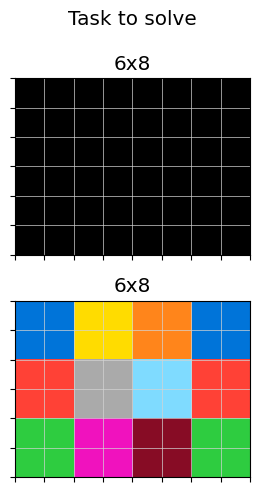

2025-05-07 14:31:24,033 - arc25.logging - INFO - wrapper - Executing load_model...
2025-05-07 14:31:24,034 - root - INFO - load_model - Loading model from /home/gbarbadillo/models/Qwen2.5-Coder-0.5B-Instruct and LoRA from /mnt/hdd0/Kaggle/arc25/trainings/20250430_first_trainings/steps_400/checkpoint-400
loading configuration file /home/gbarbadillo/models/Qwen2.5-Coder-0.5B-Instruct/config.json
Model config Qwen2Config {
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "eos_token_id": 151645,
  "hidden_act": "silu",
  "hidden_size": 896,
  "initializer_range": 0.02,
  "intermediate_size": 4864,
  "max_position_embeddings": 32768,
  "max_window_layers": 24,
  "model_type": "qwen2",
  "num_attention_heads": 14,
  "num_hidden_layers": 24,
  "num_key_value_heads": 2,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 1000000.0,
  "sliding_window": 32768,
  "tie_word_embeddings": true,
  "torch_dtype": "bfloat16",
  "trans

  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 14:31:46,838 - root - INFO - inference - Number of unique outputs: 256/256
2025-05-07 14:31:46,840 - root - INFO - inference - Max pixel accuracy: 0.5416666666666666
2025-05-07 14:31:46,845 - arc25.logging - INFO - wrapper - Executed inference in 21.7189 seconds


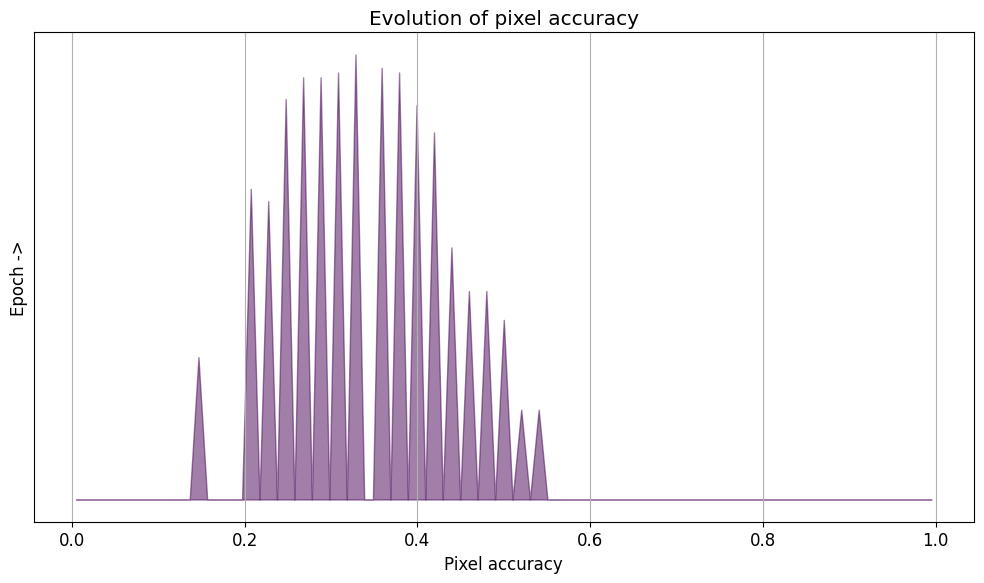

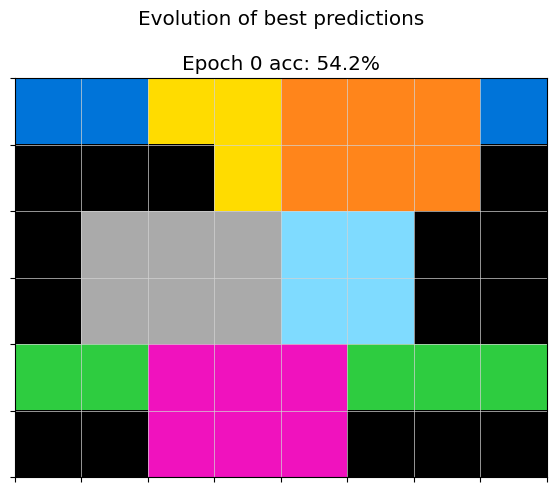

2025-05-07 14:31:46,998 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 14:31:47,083 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/256 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 256
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 256
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 14:32:35,659 - arc25.logging - INFO - wrapper - Executed finetuning in 48.6600 seconds
2025-05-07 14:32:35,661 - root - INFO - hindsight_experience_replay - Starting epoch 1...
2025-05-07 14:32:35,661 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 14:33:01,661 - root - INFO - inference - Number of unique outputs: 253/256
2025-05-07 14:33:01,663 - root - INFO - inference - Max pixel accuracy: 0.7291666666666666
2025-05-07 14:33:01,674 - arc25.logging - INFO - wrapper - Executed inference in 26.0127 seconds


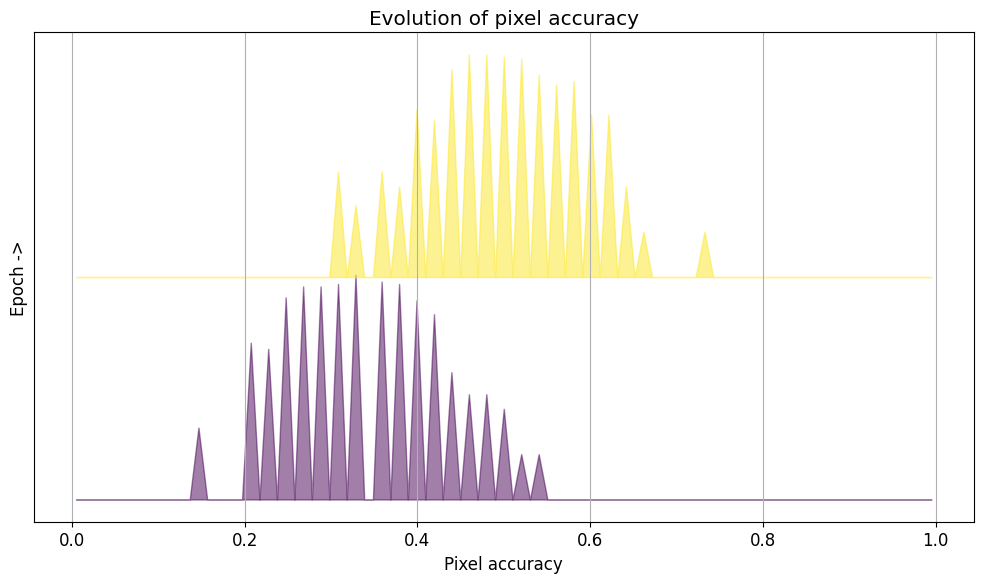

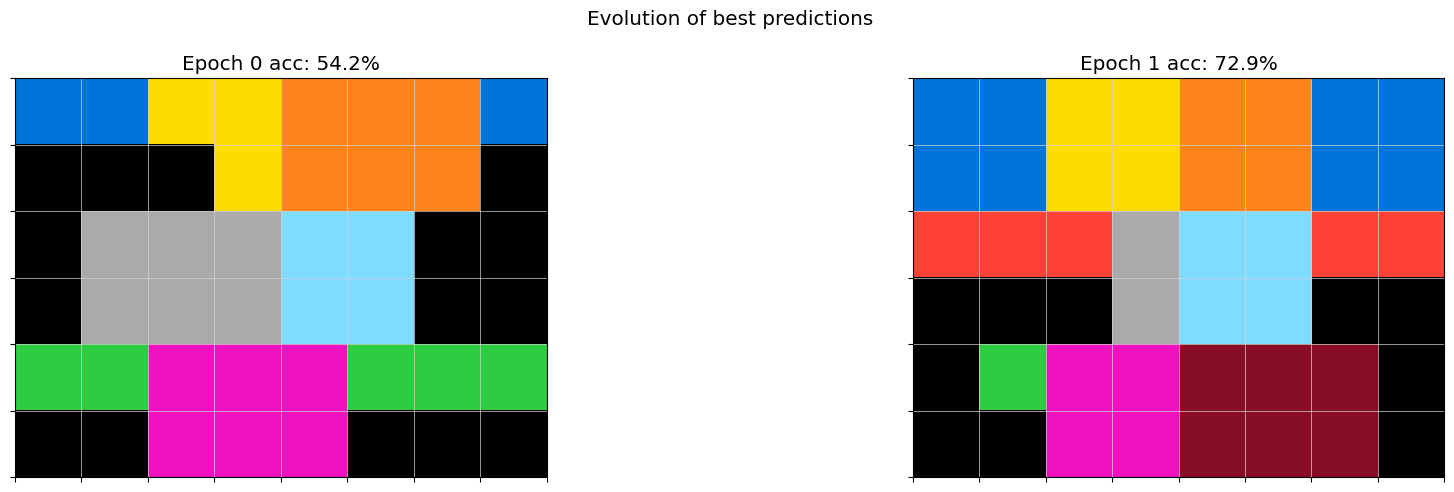

2025-05-07 14:33:01,985 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 14:33:02,072 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/253 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/253 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/253 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/253 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 253
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 253
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 14:33:50,038 - arc25.logging - INFO - wrapper - Executed finetuning in 48.0518 seconds
2025-05-07 14:33:50,039 - root - INFO - hindsight_experience_replay - Starting epoch 2...
2025-05-07 14:33:50,040 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 14:34:16,129 - root - INFO - inference - Number of unique outputs: 223/256
2025-05-07 14:34:16,132 - root - INFO - inference - Max pixel accuracy: 0.75
2025-05-07 14:34:16,139 - arc25.logging - INFO - wrapper - Executed inference in 26.0976 seconds


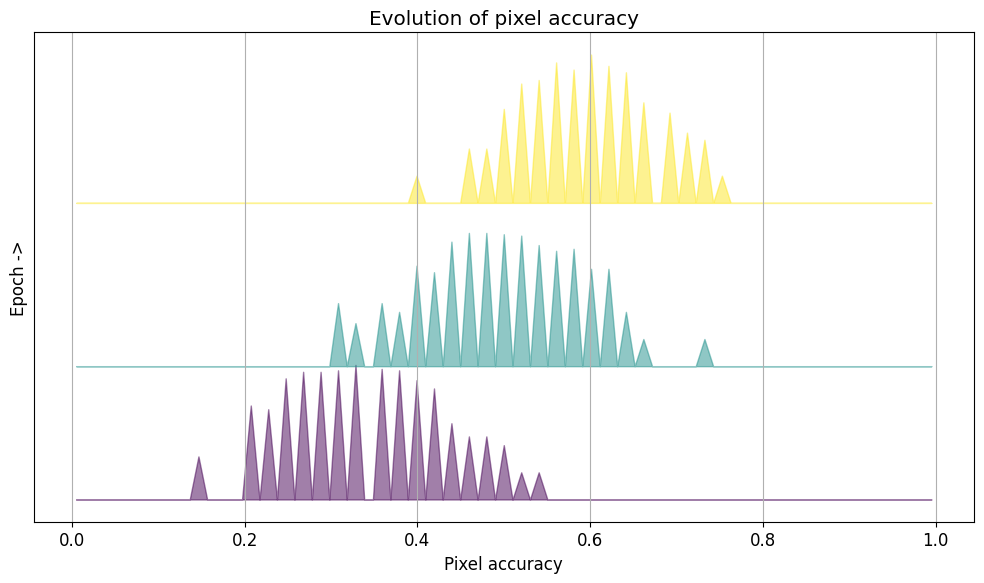

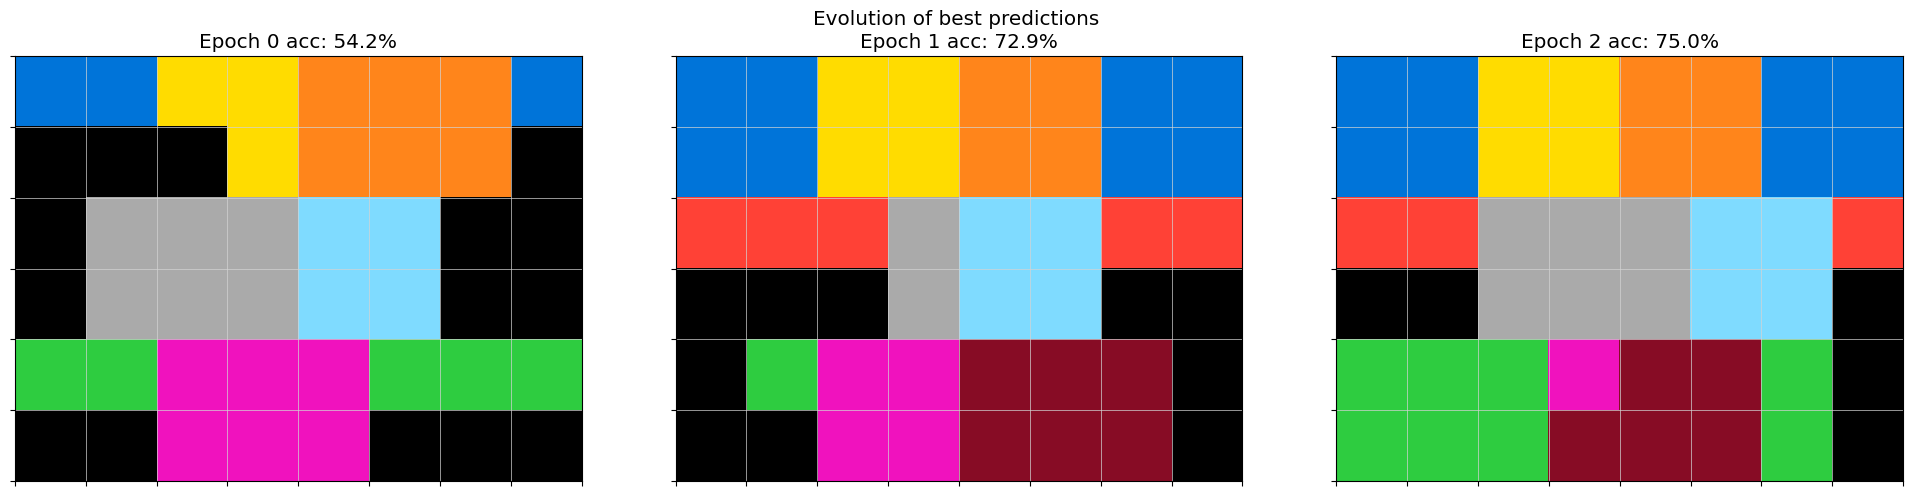

2025-05-07 14:34:16,438 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 14:34:16,520 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/223 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/223 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/223 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/223 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 223
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 14:35:00,828 - arc25.logging - INFO - wrapper - Executed finetuning in 44.3885 seconds
2025-05-07 14:35:00,829 - root - INFO - hindsight_experience_replay - Starting epoch 3...
2025-05-07 14:35:00,829 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 14:35:27,606 - root - INFO - inference - Number of unique outputs: 108/256
2025-05-07 14:35:27,610 - root - INFO - inference - Max pixel accuracy: 0.7708333333333334
2025-05-07 14:35:27,616 - arc25.logging - INFO - wrapper - Executed inference in 26.7855 seconds


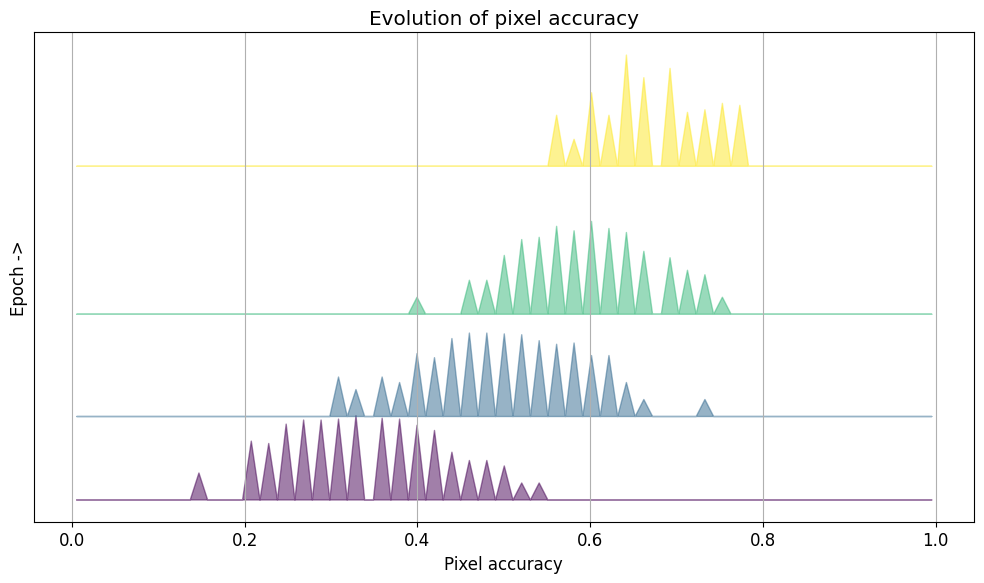

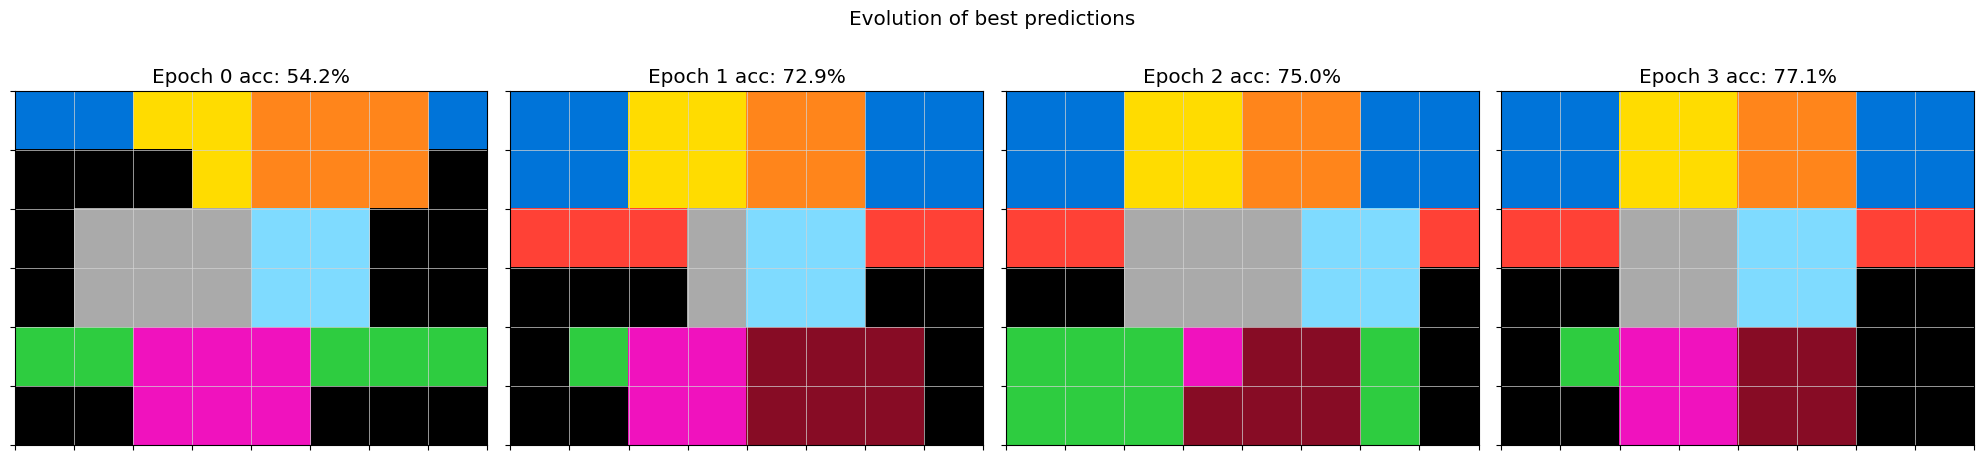

2025-05-07 14:35:28,042 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 14:35:28,133 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/108 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/108 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/108 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/108 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 108
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 108
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 14:35:49,188 - arc25.logging - INFO - wrapper - Executed finetuning in 21.1455 seconds
2025-05-07 14:35:49,190 - root - INFO - hindsight_experience_replay - Starting epoch 4...
2025-05-07 14:35:49,191 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 14:36:17,762 - root - INFO - inference - Number of unique outputs: 101/256
2025-05-07 14:36:17,766 - root - INFO - inference - Max pixel accuracy: 0.8333333333333334
2025-05-07 14:36:17,768 - arc25.logging - INFO - wrapper - Executed inference in 28.5770 seconds


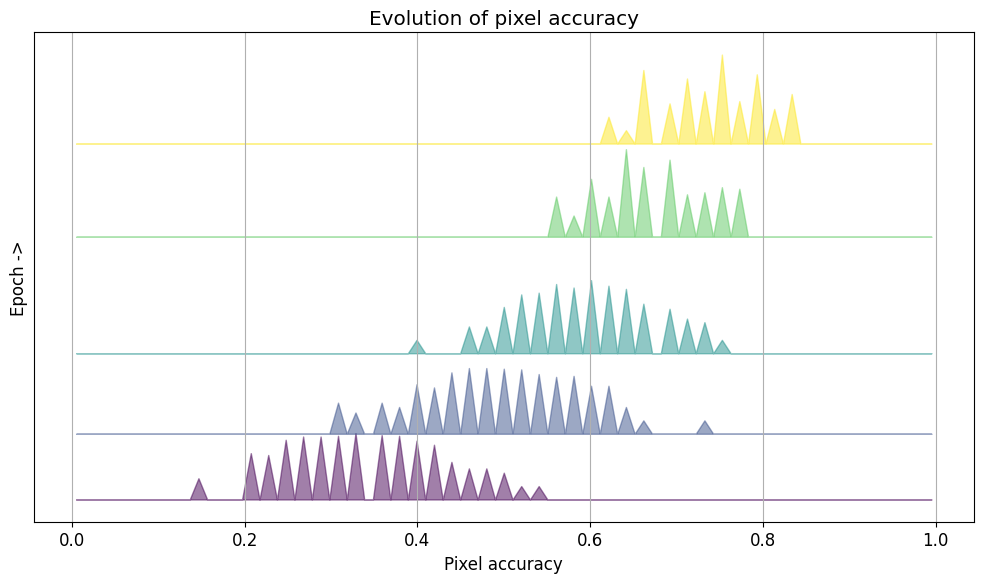

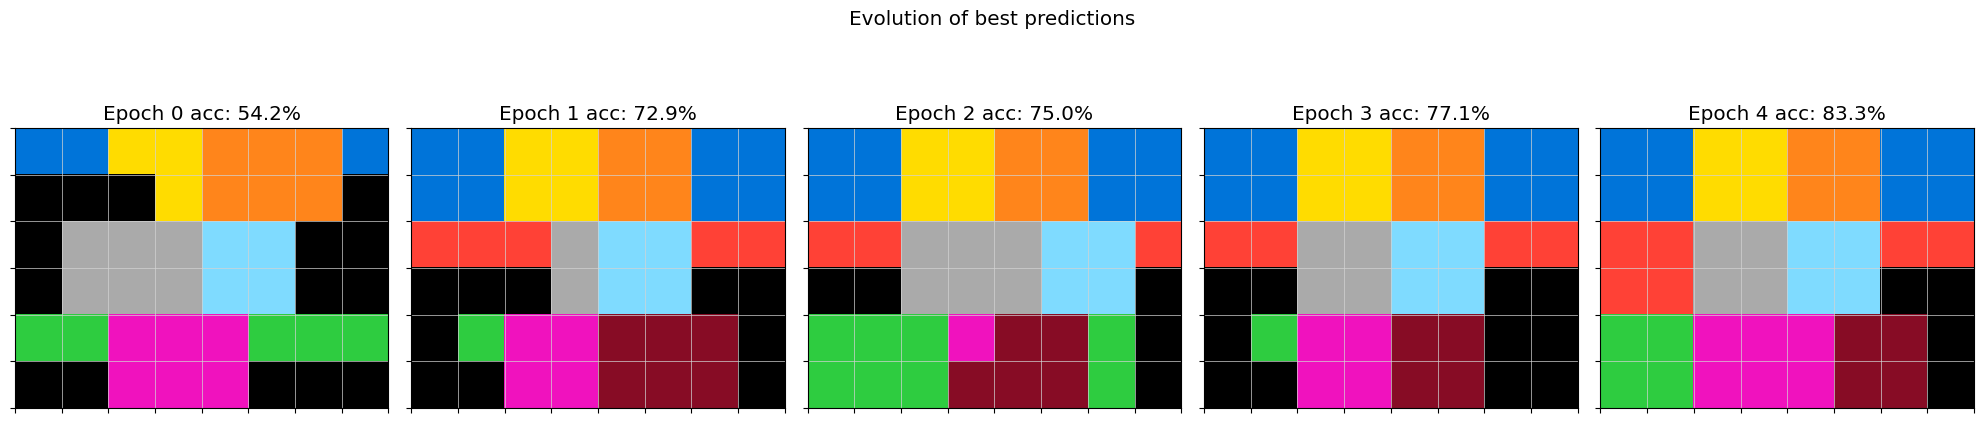

2025-05-07 14:36:18,229 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 14:36:18,296 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/101 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/101 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/101 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/101 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 101
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 101
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 14:36:40,144 - arc25.logging - INFO - wrapper - Executed finetuning in 21.9134 seconds
2025-05-07 14:36:40,145 - root - INFO - hindsight_experience_replay - Starting epoch 5...
2025-05-07 14:36:40,145 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 14:37:09,674 - root - INFO - inference - Number of unique outputs: 28/256
2025-05-07 14:37:09,679 - root - INFO - inference - Max pixel accuracy: 0.9166666666666666
2025-05-07 14:37:09,687 - arc25.logging - INFO - wrapper - Executed inference in 29.5420 seconds


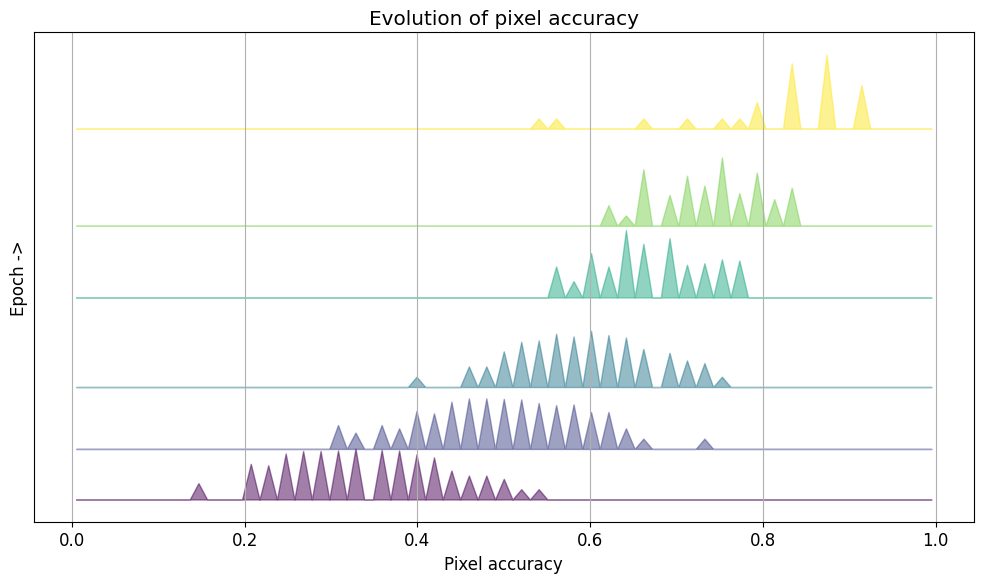

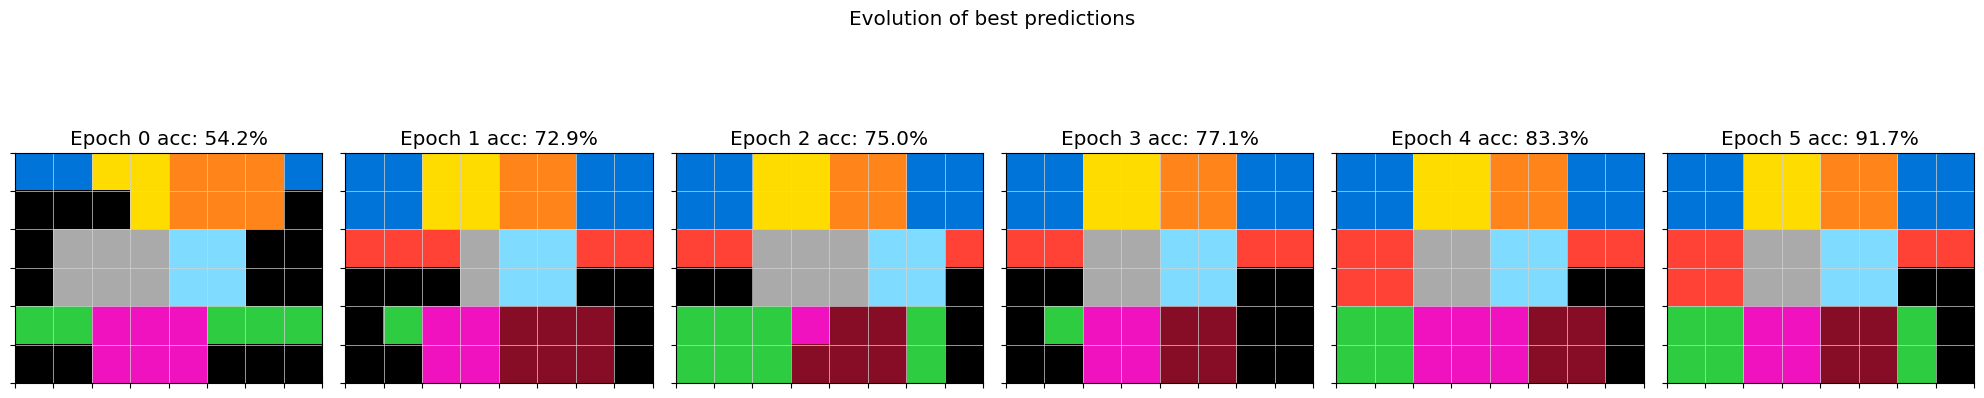

2025-05-07 14:37:10,164 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 14:37:10,208 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/28 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/28 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/28 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/28 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 28
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 28
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 14:37:16,576 - arc25.logging - INFO - wrapper - Executed finetuning in 6.4111 seconds
2025-05-07 14:37:16,577 - root - INFO - hindsight_experience_replay - Starting epoch 6...
2025-05-07 14:37:16,578 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 14:37:46,345 - root - INFO - inference - Number of unique outputs: 8/256
2025-05-07 14:37:46,350 - root - INFO - inference - Max pixel accuracy: 0.9166666666666666
2025-05-07 14:37:46,352 - arc25.logging - INFO - wrapper - Executed inference in 29.7735 seconds


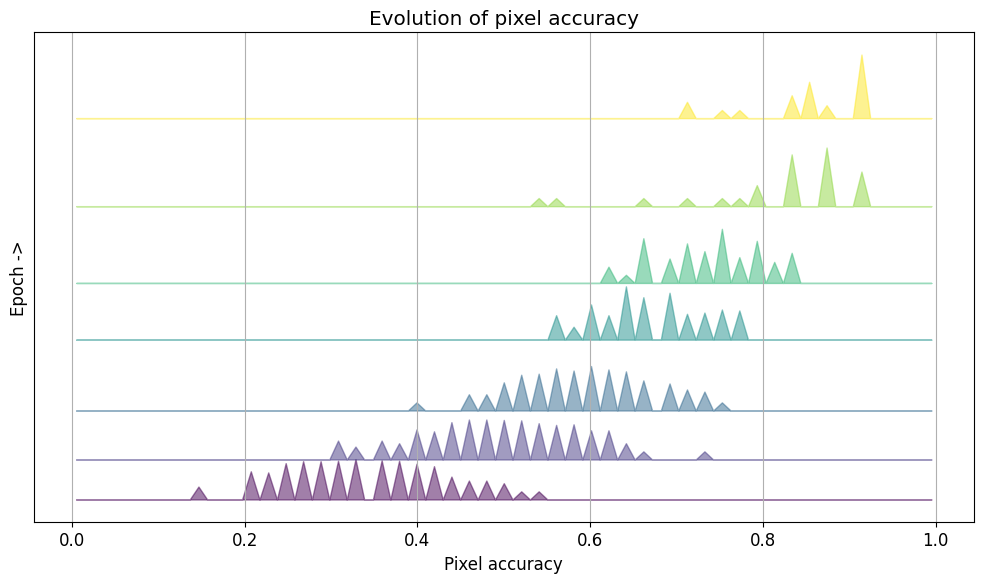

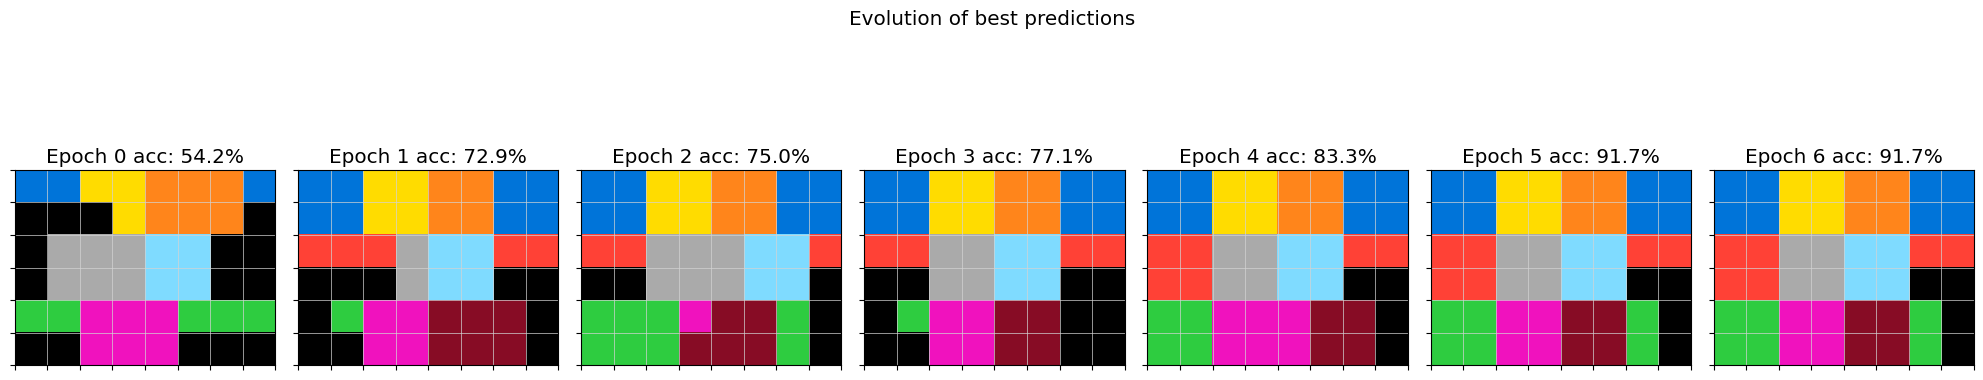

2025-05-07 14:37:46,858 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 14:37:46,915 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/8 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/8 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/8 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/8 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 8
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 8
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 14:37:49,382 - arc25.logging - INFO - wrapper - Executed finetuning in 2.5225 seconds
2025-05-07 14:37:49,382 - root - INFO - hindsight_experience_replay - Starting epoch 7...
2025-05-07 14:37:49,383 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 14:38:16,330 - root - INFO - inference - Number of unique outputs: 8/256
2025-05-07 14:38:16,335 - root - INFO - inference - Max pixel accuracy: 0.9166666666666666
2025-05-07 14:38:16,344 - arc25.logging - INFO - wrapper - Executed inference in 26.9606 seconds


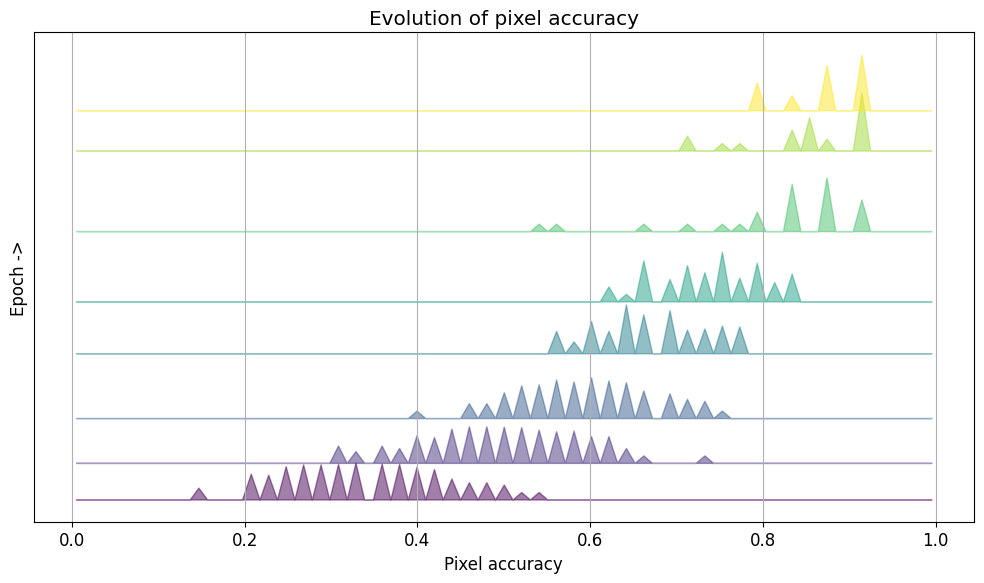

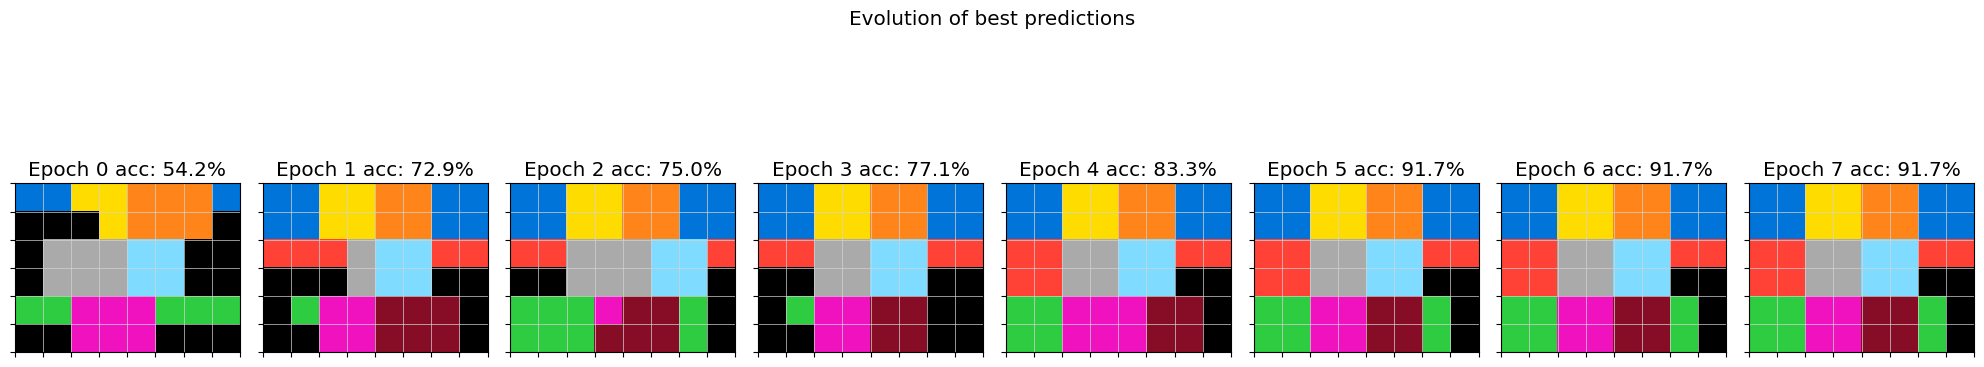

2025-05-07 14:38:16,959 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 14:38:17,007 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/8 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/8 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/8 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/8 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 8
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 8
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 14:38:19,474 - arc25.logging - INFO - wrapper - Executed finetuning in 2.5150 seconds
2025-05-07 14:38:19,476 - root - INFO - hindsight_experience_replay - Starting epoch 8...
2025-05-07 14:38:19,476 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 14:38:49,156 - root - INFO - inference - Number of unique outputs: 4/256
2025-05-07 14:38:49,167 - root - INFO - inference - Max pixel accuracy: 0.9166666666666666
2025-05-07 14:38:49,169 - arc25.logging - INFO - wrapper - Executed inference in 29.6918 seconds


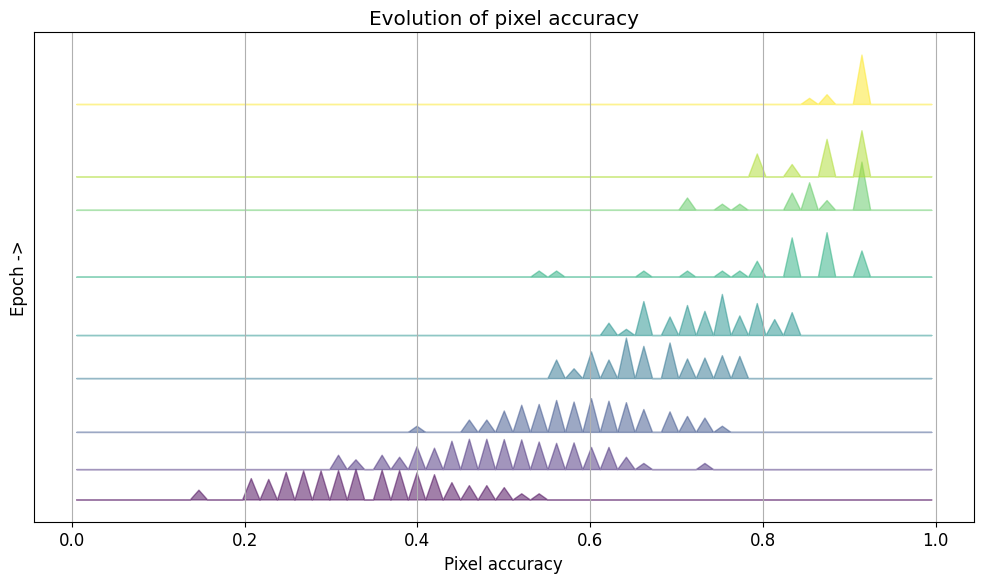

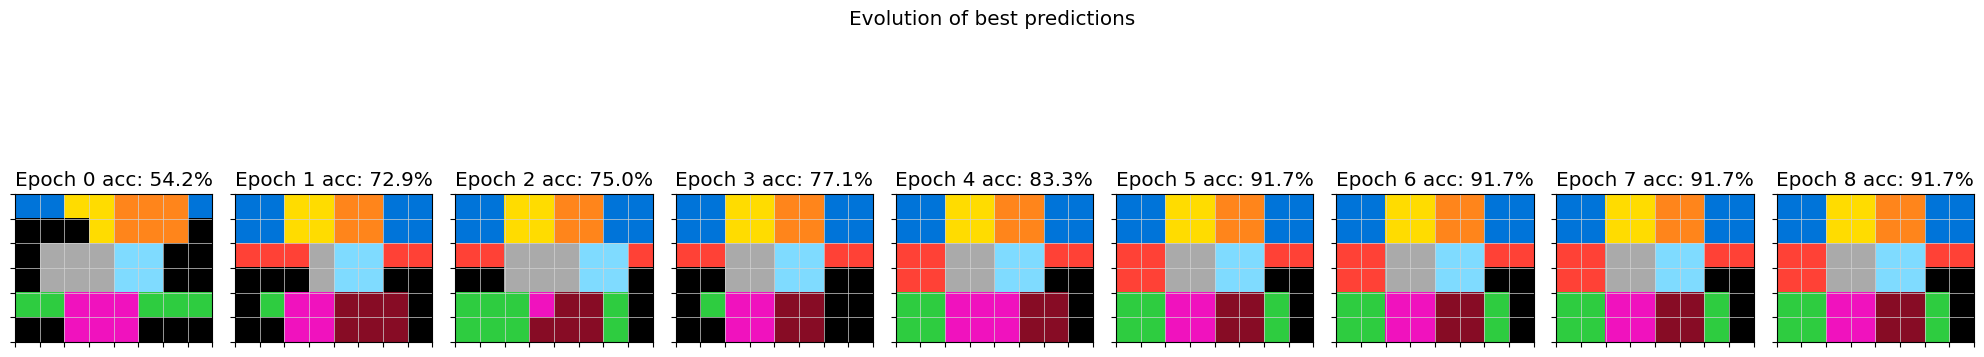

2025-05-07 14:38:49,809 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 14:38:49,867 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/4 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/4 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/4 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/4 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 4
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 4
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 14:38:51,567 - arc25.logging - INFO - wrapper - Executed finetuning in 1.7568 seconds
2025-05-07 14:38:51,569 - root - INFO - hindsight_experience_replay - Starting epoch 9...
2025-05-07 14:38:51,570 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 14:39:18,690 - root - INFO - inference - Number of unique outputs: 1/256
2025-05-07 14:39:18,695 - root - INFO - inference - Max pixel accuracy: 0.9166666666666666
2025-05-07 14:39:18,697 - arc25.logging - INFO - wrapper - Executed inference in 27.1264 seconds


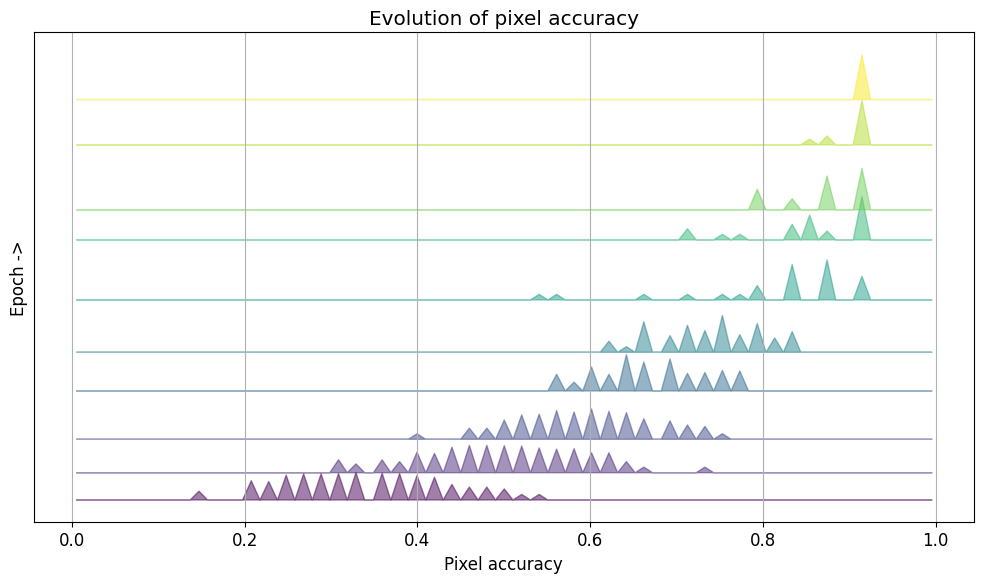

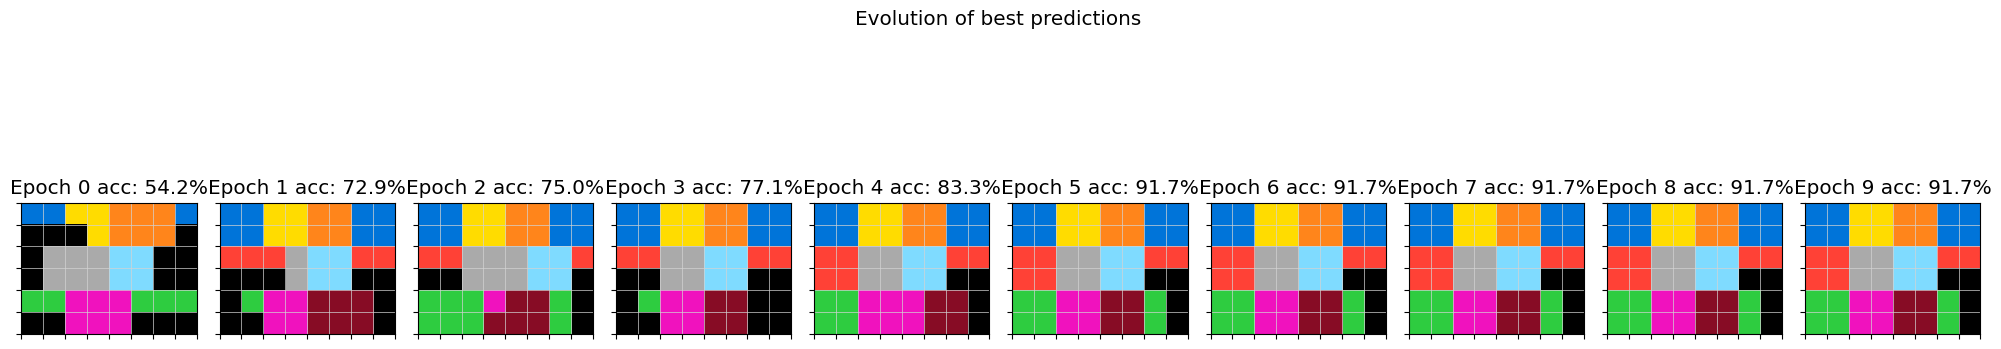

2025-05-07 14:39:19,431 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 14:39:19,490 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/1 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/1 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/1 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/1 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 1
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 1
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 14:39:20,570 - arc25.logging - INFO - wrapper - Executed finetuning in 1.1372 seconds


# Best prediction code

```python
def task(img):
    draw_rectangle(img, point1=(0, 0), point2=(1, 7), color=1)
    draw_horizontal_line(img, y=2, color=2)
    draw_rectangle(img, point1=(0, 3), point2=(1, 5), color=7)
    draw_rectangle(img, point1=(4, 0), point2=(5, 6), color=3)
    draw_rectangle(img, point1=(0, 2), point2=(1, 3), color=4)
    draw_rectangle(img, point1=(2, 0), point2=(3, 3), color=2)
    draw_rectangle(img, point1=(2, 2), point2=(3, 4), color=5)
    draw_rectangle(img, point1=(2, 4), point2=(3, 5), color=8)
    draw_rectangle(img, point1=(4, 3), point2=(5, 5), color=9)
    draw_rectangle(img, point1=(4, 2), point2=(5, 3), color=6)
    return img
```

2025-05-07 14:39:20,631 - arc25.logging - INFO - wrapper - Executed hindsight_experience_replay in 476.7390 seconds


In [ ]:
input_img = create_img((6, 8), color=0)
output_img = input_img.copy()
color = 0
for x in range(0, input_img.shape[1], 2):
    for y in range(0, input_img.shape[0], 2):
        color = (color + 1) % 10
        if color == 0: color = 1
        draw_rectangle(output_img, (y, x), (y+1, x+1), color=color)
task = Task(inputs=[input_img], outputs=[output_img], code='', name='manual')
hindsight_experience_replay(task, Config(lora_path='/mnt/hdd0/Kaggle/arc25/trainings/20250430_first_trainings/steps_400/checkpoint-400'));

### 800 training steps

#### 12 squares

2025-05-07 14:39:20,678 - arc25.logging - INFO - wrapper - Executing hindsight_experience_replay...


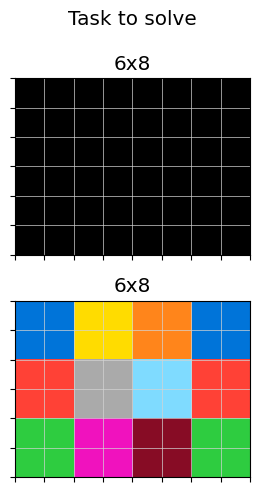

2025-05-07 14:39:20,811 - arc25.logging - INFO - wrapper - Executing load_model...
2025-05-07 14:39:20,812 - root - INFO - load_model - Loading model from /home/gbarbadillo/models/Qwen2.5-Coder-0.5B-Instruct and LoRA from /mnt/hdd0/Kaggle/arc25/trainings/20250430_first_trainings/steps_800/checkpoint-800
loading configuration file /home/gbarbadillo/models/Qwen2.5-Coder-0.5B-Instruct/config.json
Model config Qwen2Config {
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "eos_token_id": 151645,
  "hidden_act": "silu",
  "hidden_size": 896,
  "initializer_range": 0.02,
  "intermediate_size": 4864,
  "max_position_embeddings": 32768,
  "max_window_layers": 24,
  "model_type": "qwen2",
  "num_attention_heads": 14,
  "num_hidden_layers": 24,
  "num_key_value_heads": 2,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 1000000.0,
  "sliding_window": 32768,
  "tie_word_embeddings": true,
  "torch_dtype": "bfloat16",
  "trans

  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 14:39:42,438 - root - INFO - inference - Number of unique outputs: 256/256
2025-05-07 14:39:42,439 - root - INFO - inference - Max pixel accuracy: 0.5208333333333334
2025-05-07 14:39:42,444 - arc25.logging - INFO - wrapper - Executed inference in 20.3879 seconds


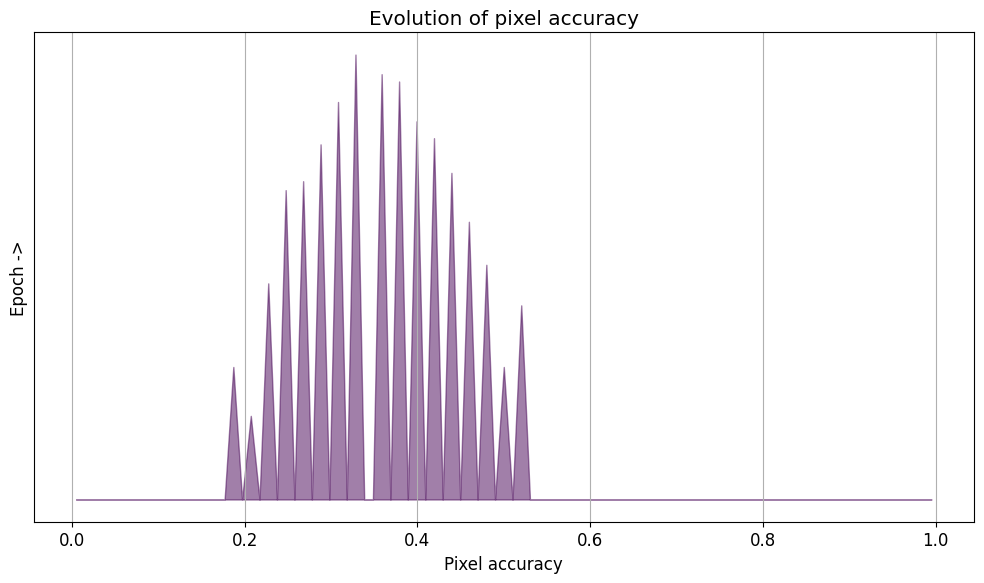

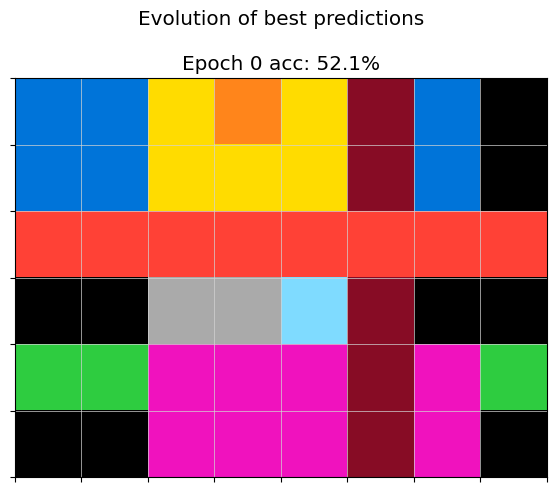

2025-05-07 14:39:42,597 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 14:39:42,678 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/256 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 256
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 256
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 14:40:32,913 - arc25.logging - INFO - wrapper - Executed finetuning in 50.3147 seconds
2025-05-07 14:40:32,914 - root - INFO - hindsight_experience_replay - Starting epoch 1...
2025-05-07 14:40:32,914 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 14:40:58,561 - root - INFO - inference - Number of unique outputs: 254/256
2025-05-07 14:40:58,565 - root - INFO - inference - Max pixel accuracy: 0.7083333333333334
2025-05-07 14:40:58,569 - arc25.logging - INFO - wrapper - Executed inference in 25.6547 seconds


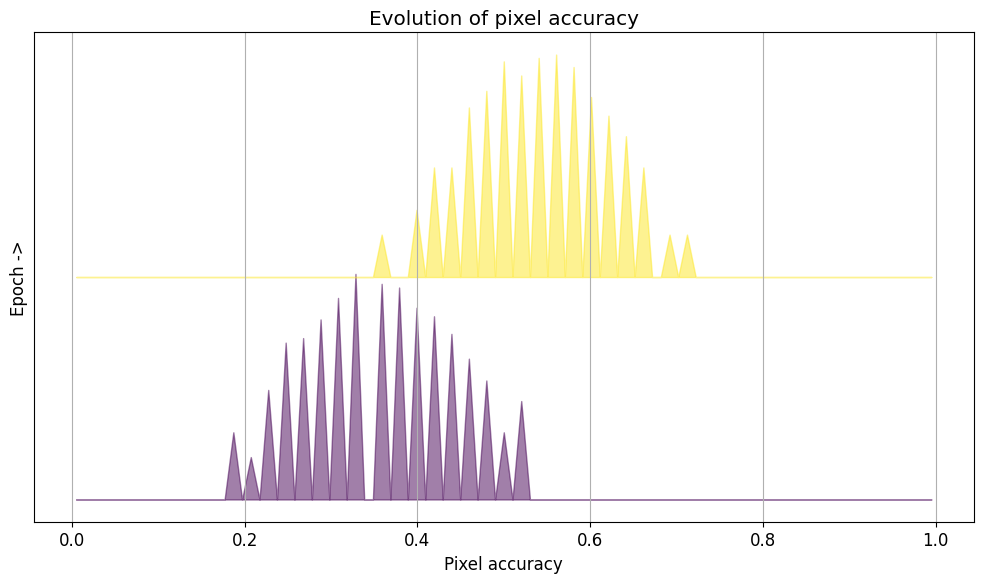

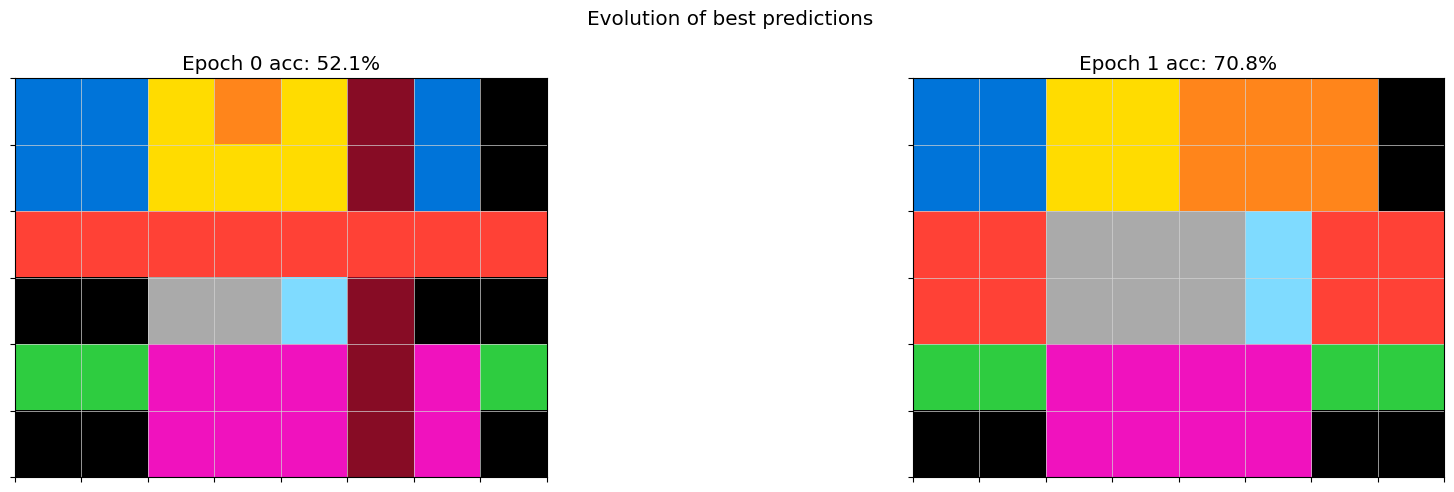

2025-05-07 14:40:58,811 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 14:40:58,892 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/254 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/254 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/254 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/254 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 254
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 254
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 14:41:49,673 - arc25.logging - INFO - wrapper - Executed finetuning in 50.8606 seconds
2025-05-07 14:41:49,673 - root - INFO - hindsight_experience_replay - Starting epoch 2...
2025-05-07 14:41:49,674 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 14:42:18,907 - root - INFO - inference - Number of unique outputs: 121/256
2025-05-07 14:42:18,911 - root - INFO - inference - Max pixel accuracy: 0.8541666666666666
2025-05-07 14:42:18,920 - arc25.logging - INFO - wrapper - Executed inference in 29.2459 seconds


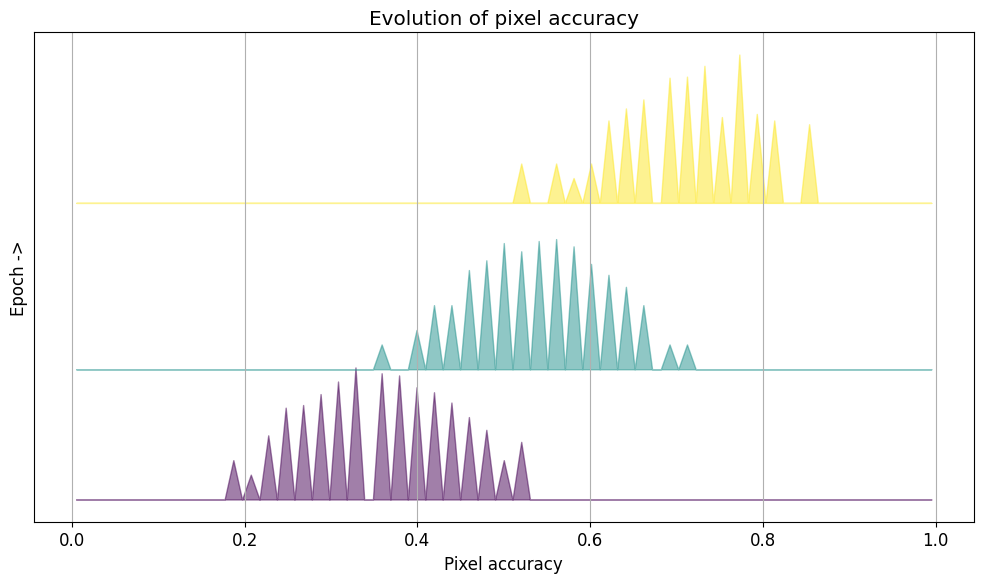

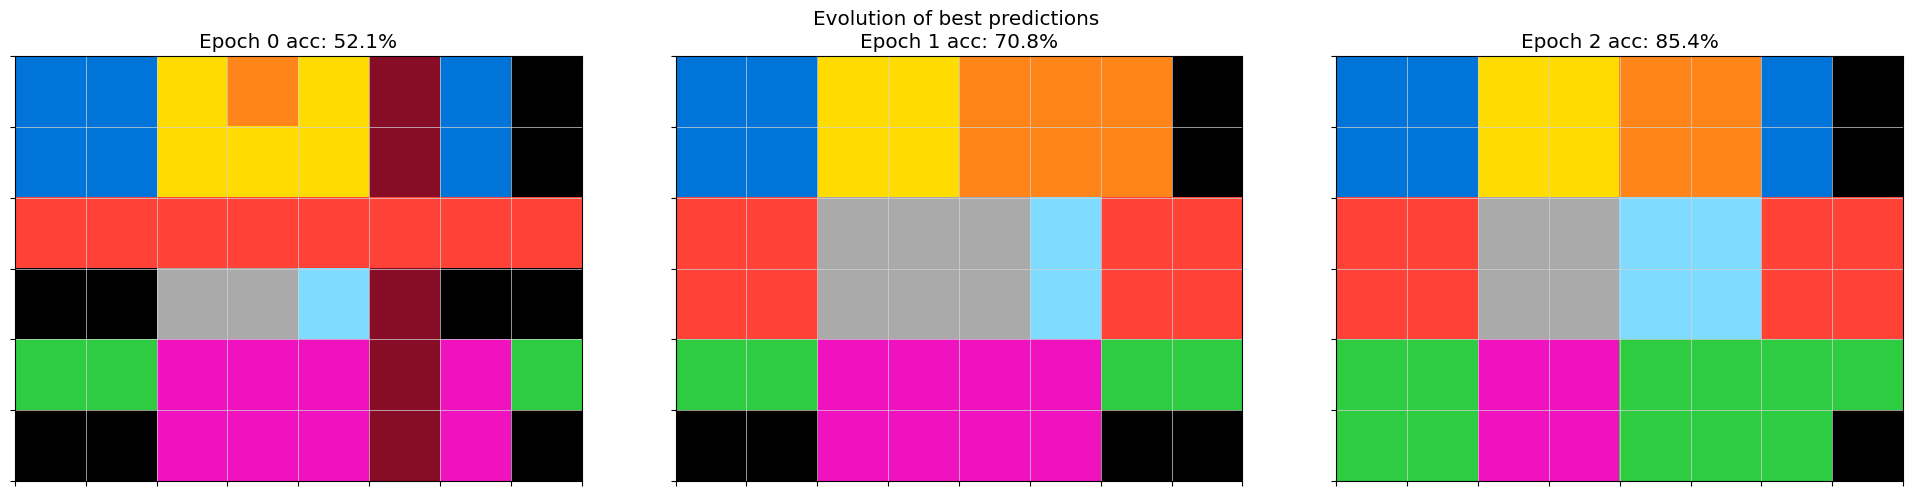

2025-05-07 14:42:19,293 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 14:42:19,360 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/121 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/121 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/121 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/121 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 121
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 121
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 14:42:46,334 - arc25.logging - INFO - wrapper - Executed finetuning in 27.0398 seconds
2025-05-07 14:42:46,336 - root - INFO - hindsight_experience_replay - Starting epoch 3...
2025-05-07 14:42:46,336 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 14:43:15,613 - root - INFO - inference - Number of unique outputs: 51/256
2025-05-07 14:43:15,617 - root - INFO - inference - Max pixel accuracy: 1.0
2025-05-07 14:43:15,619 - arc25.logging - INFO - wrapper - Executed inference in 29.2822 seconds


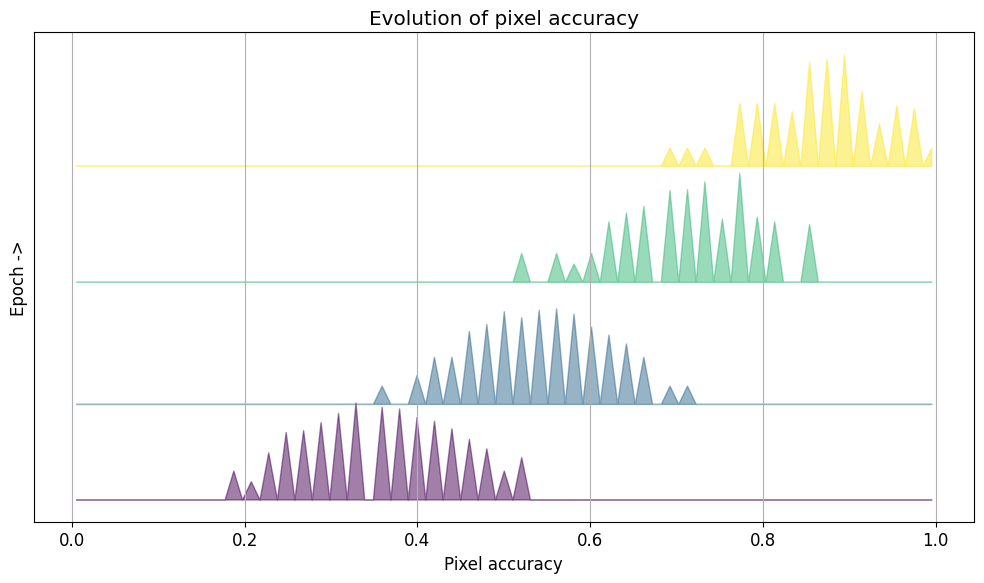

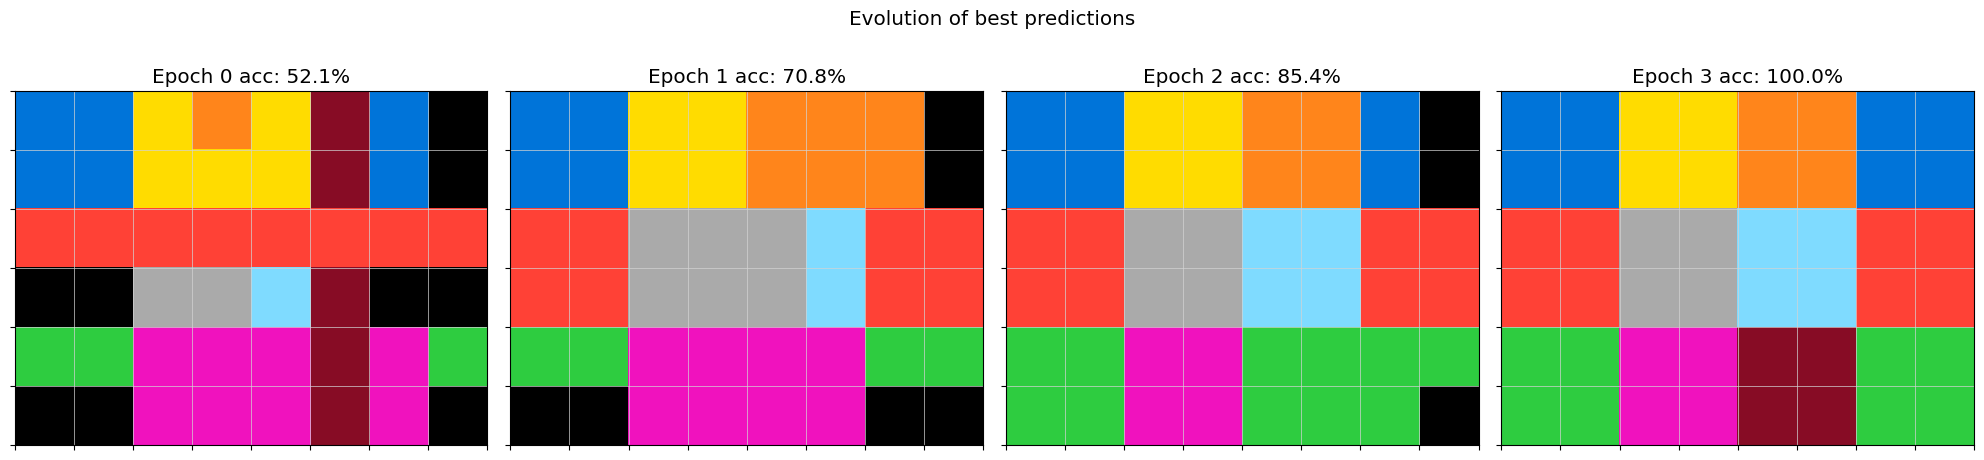

2025-05-07 14:43:16,001 - arc25.input_generation - INFO - hindsight_experience_replay - Found a perfect prediction at epoch 3!


# Best prediction code

```python
def task(img):
    draw_rectangle(img, point1=(2, 0), point2=(3, 7), color=2)
    draw_rectangle(img, point1=(2, 2), point2=(3, 5), color=5)
    draw_rectangle(img, point1=(0, 0), point2=(1, 7), color=1)
    draw_rectangle(img, point1=(0, 2), point2=(1, 3), color=4)
    draw_rectangle(img, point1=(2, 4), point2=(3, 5), color=8)
    draw_rectangle(img, point1=(4, 0), point2=(5, 7), color=3)
    draw_rectangle(img, point1=(4, 2), point2=(5, 3), color=6)
    draw_rectangle(img, point1=(4, 4), point2=(5, 5), color=9)
    draw_rectangle(img, point1=(0, 4), point2=(1, 5), color=7)
    return img
```

2025-05-07 14:43:16,066 - arc25.logging - INFO - wrapper - Executed hindsight_experience_replay in 235.3865 seconds


In [ ]:
input_img = create_img((6, 8), color=0)
output_img = input_img.copy()
color = 0
for x in range(0, input_img.shape[1], 2):
    for y in range(0, input_img.shape[0], 2):
        color = (color + 1) % 10
        if color == 0: color = 1
        draw_rectangle(output_img, (y, x), (y+1, x+1), color=color)
task = Task(inputs=[input_img], outputs=[output_img], code='', name='manual')
hindsight_experience_replay(task, Config(lora_path='/mnt/hdd0/Kaggle/arc25/trainings/20250430_first_trainings/steps_800/checkpoint-800'));

## Look ma, no rewards!

Can we still use HER without using any information about the rewards?

### 9 vertical lines

2025-05-07 15:14:03,822 - arc25.logging - INFO - wrapper - Executing hindsight_experience_replay...


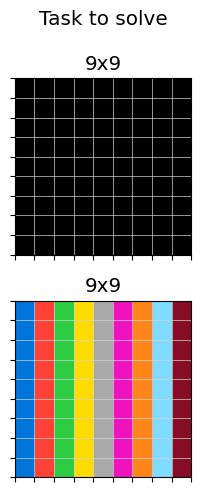

2025-05-07 15:14:03,971 - arc25.logging - INFO - wrapper - Executing load_model...
2025-05-07 15:14:03,972 - root - INFO - load_model - Loading model from /home/gbarbadillo/models/Qwen2.5-Coder-0.5B-Instruct and LoRA from /mnt/hdd0/Kaggle/arc25/trainings/20250430_first_trainings/steps_6400/checkpoint-6400
Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.
2025-05-07 15:14:04,301 - accelerate.utils.modeling - INFO - get_balanced_memory - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
2025-05-07 15:14:05,273 - arc25.logging - INFO - wrapper - Executed load_model in 1.3005 seconds
2025-05-07 15:14:05,274 - root - INFO - hindsight_experience_replay - Starting epoch 0...
2025-05-07 15:14:05,275 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 15:14:22,200 - root - INFO - inference - Number of unique outputs: 192/256
2025-05-07 15:14:22,201 - root - INFO - inference - Max pixel accuracy: 0.8888888888888888
2025-05-07 15:14:22,209 - arc25.logging - INFO - wrapper - Executed inference in 16.9339 seconds


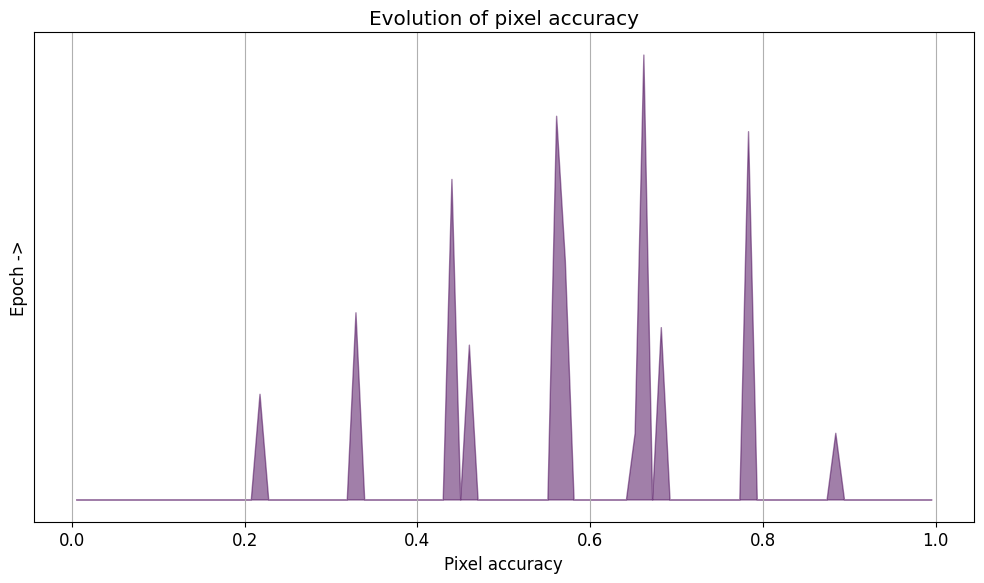

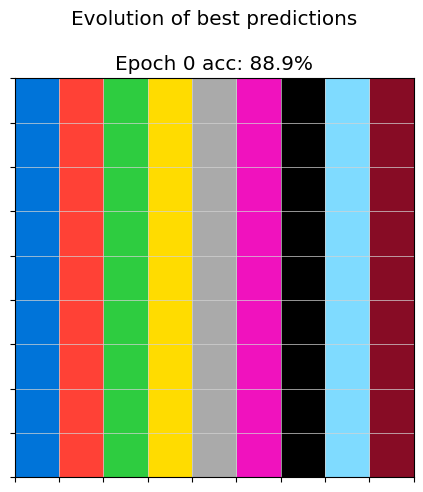

2025-05-07 15:14:22,402 - root - INFO - hindsight_experience_replay - Shuffling the tasks, no information about the accuracy is used
2025-05-07 15:14:22,403 - arc25.logging - INFO - wrapper - Executing finetuning...
2025-05-07 15:14:22,520 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/192 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/192 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/192 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/192 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 192
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 192
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 15:14:58,617 - arc25.logging - INFO - wrapper - Executed finetuning in 36.2130 seconds
2025-05-07 15:14:58,618 - root - INFO - hindsight_experience_replay - Starting epoch 1...
2025-05-07 15:14:58,618 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 15:15:15,509 - root - INFO - inference - Number of unique outputs: 74/256
2025-05-07 15:15:15,512 - root - INFO - inference - Max pixel accuracy: 1.0
2025-05-07 15:15:15,514 - arc25.logging - INFO - wrapper - Executed inference in 16.8961 seconds


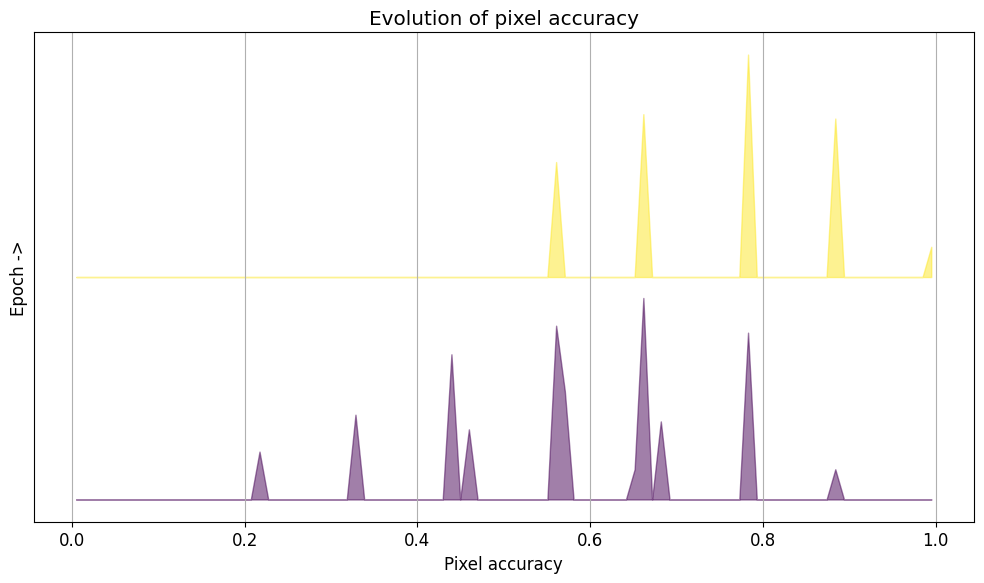

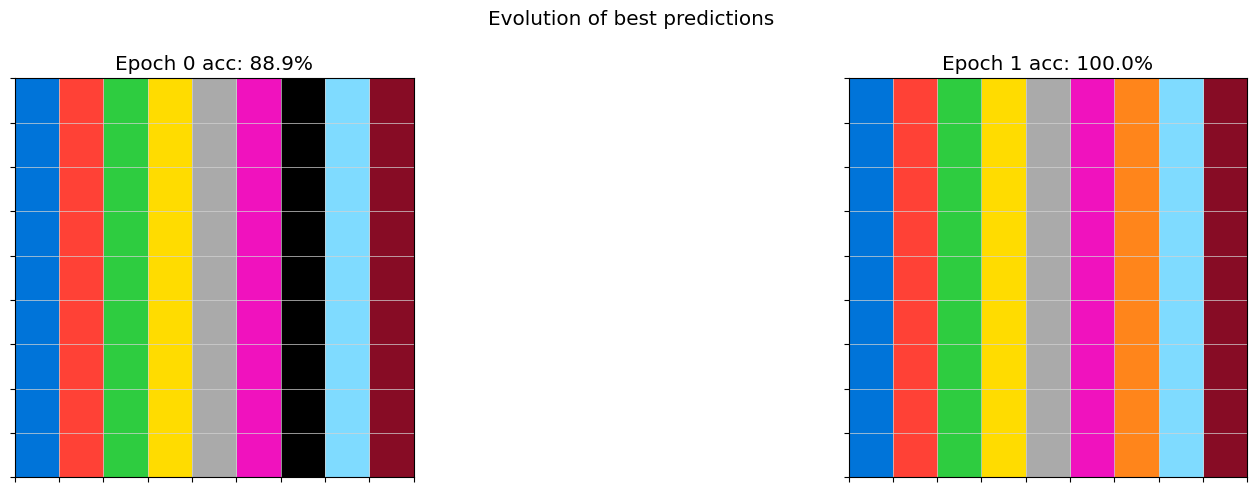

2025-05-07 15:15:15,751 - arc25.input_generation - INFO - hindsight_experience_replay - Found a perfect prediction at epoch 1!


# Best prediction code

```python
def task(img):
    draw_rectangle(img, point1=(0, 4), point2=(8, 7), color=8)
    draw_vertical_line(img, x=5, color=6)
    draw_vertical_line(img, x=3, color=4)
    draw_vertical_line(img, x=2, color=3)
    draw_vertical_line(img, x=1, color=2)
    draw_vertical_line(img, x=0, color=1)
    draw_vertical_line(img, x=8, color=9)
    draw_vertical_line(img, x=4, color=5)
    draw_vertical_line(img, x=6, color=7)
    return img
```

2025-05-07 15:15:15,797 - arc25.logging - INFO - wrapper - Executed hindsight_experience_replay in 71.9740 seconds


In [5]:
input_img = create_img((9, 9), color=0)
output_img = input_img.copy()
for x in range(0, input_img.shape[1], 1):
    draw_vertical_line(output_img, x, color=x+1)

task = Task(inputs=[input_img], outputs=[output_img], code='', name='manual')
hindsight_experience_replay(task, Config(use_accuracy_for_sorting=False));

### 20 squares

2025-05-07 15:16:44,775 - arc25.logging - INFO - wrapper - Executing hindsight_experience_replay...


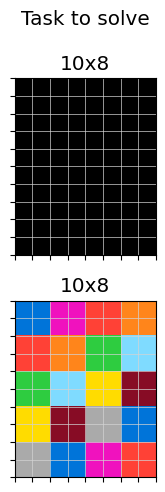

2025-05-07 15:16:44,919 - arc25.logging - INFO - wrapper - Executing load_model...
2025-05-07 15:16:44,920 - root - INFO - load_model - Loading model from /home/gbarbadillo/models/Qwen2.5-Coder-0.5B-Instruct and LoRA from /mnt/hdd0/Kaggle/arc25/trainings/20250430_first_trainings/steps_6400/checkpoint-6400
loading configuration file /home/gbarbadillo/models/Qwen2.5-Coder-0.5B-Instruct/config.json
Model config Qwen2Config {
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "eos_token_id": 151645,
  "hidden_act": "silu",
  "hidden_size": 896,
  "initializer_range": 0.02,
  "intermediate_size": 4864,
  "max_position_embeddings": 32768,
  "max_window_layers": 24,
  "model_type": "qwen2",
  "num_attention_heads": 14,
  "num_hidden_layers": 24,
  "num_key_value_heads": 2,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 1000000.0,
  "sliding_window": 32768,
  "tie_word_embeddings": true,
  "torch_dtype": "bfloat16",
  "tra

  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 15:17:23,712 - root - INFO - inference - Number of unique outputs: 256/256
2025-05-07 15:17:23,715 - root - INFO - inference - Max pixel accuracy: 0.5125
2025-05-07 15:17:23,728 - arc25.logging - INFO - wrapper - Executed inference in 37.3652 seconds


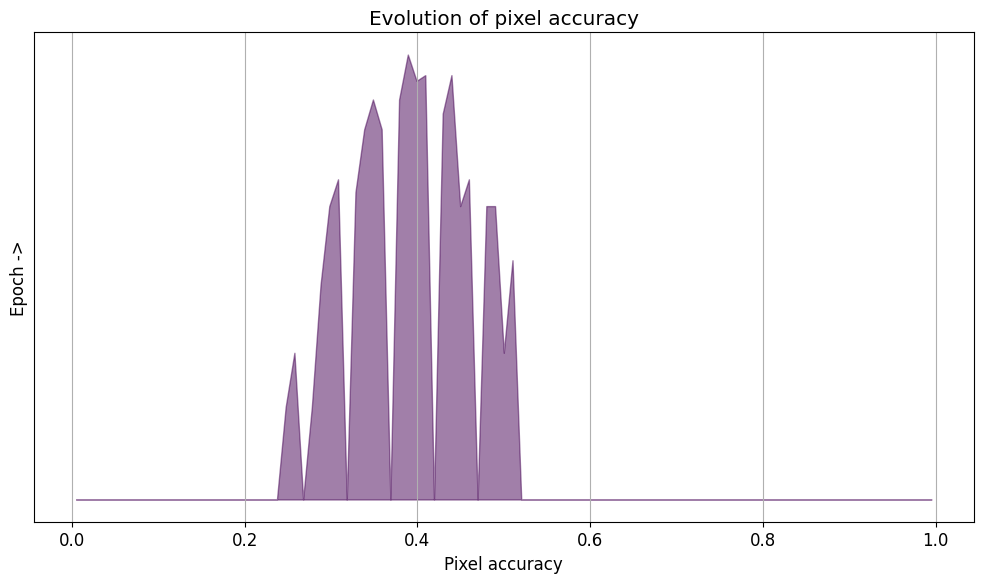

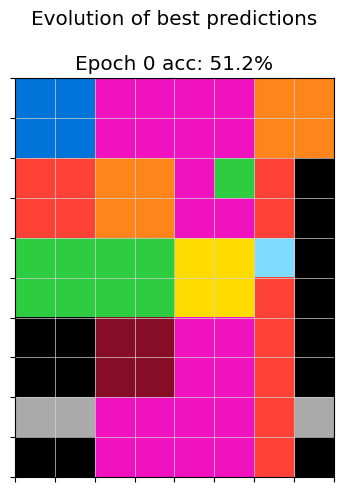

2025-05-07 15:17:23,959 - root - INFO - hindsight_experience_replay - Shuffling the tasks, no information about the accuracy is used
2025-05-07 15:17:23,960 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 15:17:24,052 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/256 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 256
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 256
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 15:18:14,639 - arc25.logging - INFO - wrapper - Executed finetuning in 50.6790 seconds
2025-05-07 15:18:14,641 - root - INFO - hindsight_experience_replay - Starting epoch 1...
2025-05-07 15:18:14,641 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 15:19:16,742 - root - INFO - inference - Number of unique outputs: 256/256
2025-05-07 15:19:16,745 - root - INFO - inference - Max pixel accuracy: 0.7375
2025-05-07 15:19:16,762 - arc25.logging - INFO - wrapper - Executed inference in 62.1197 seconds


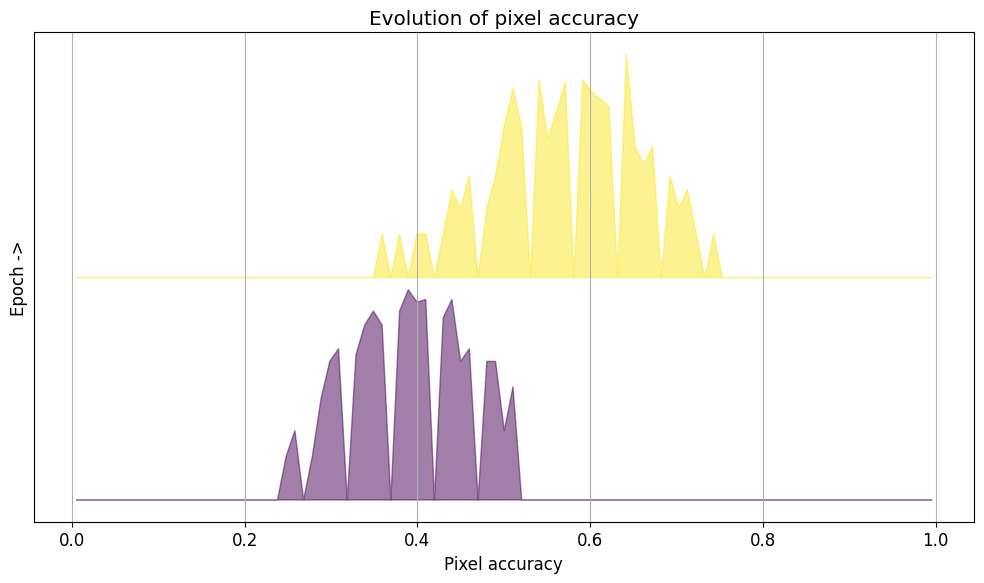

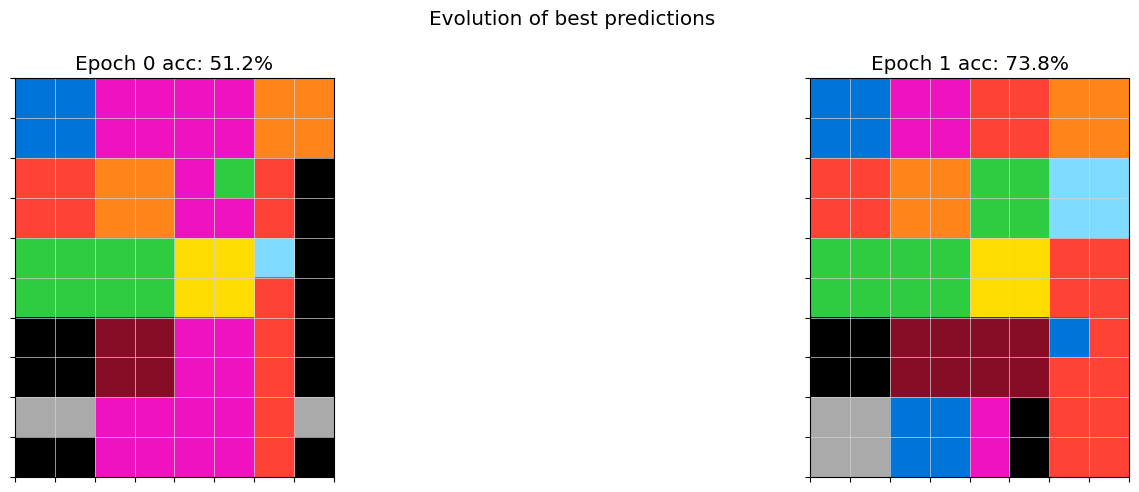

2025-05-07 15:19:17,074 - root - INFO - hindsight_experience_replay - Shuffling the tasks, no information about the accuracy is used
2025-05-07 15:19:17,075 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 15:19:17,164 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/256 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 256
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 256
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 15:20:06,376 - arc25.logging - INFO - wrapper - Executed finetuning in 49.3011 seconds
2025-05-07 15:20:06,377 - root - INFO - hindsight_experience_replay - Starting epoch 2...
2025-05-07 15:20:06,378 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 15:21:05,786 - root - INFO - inference - Number of unique outputs: 243/256
2025-05-07 15:21:05,797 - root - INFO - inference - Max pixel accuracy: 0.8875
2025-05-07 15:21:05,809 - arc25.logging - INFO - wrapper - Executed inference in 59.4305 seconds


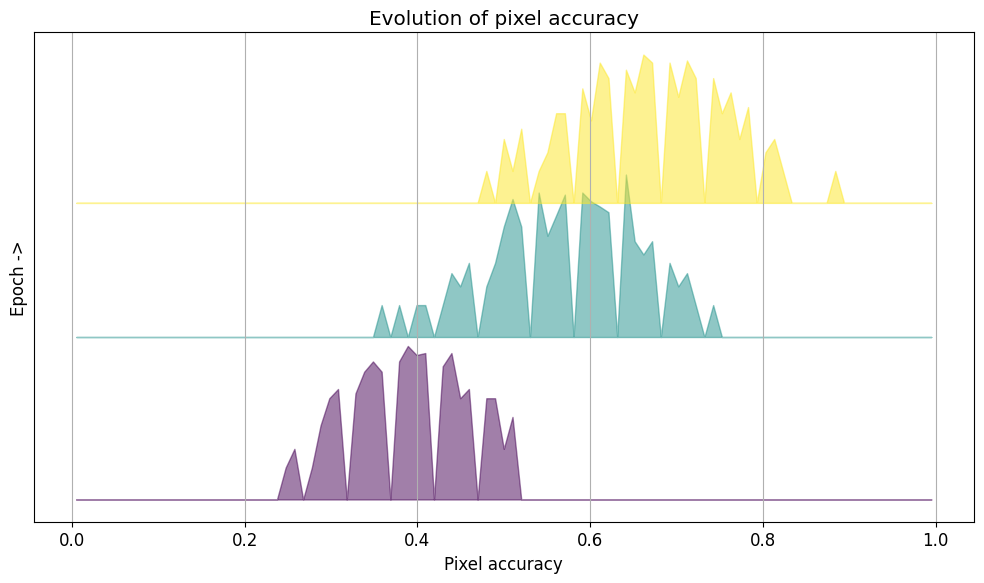

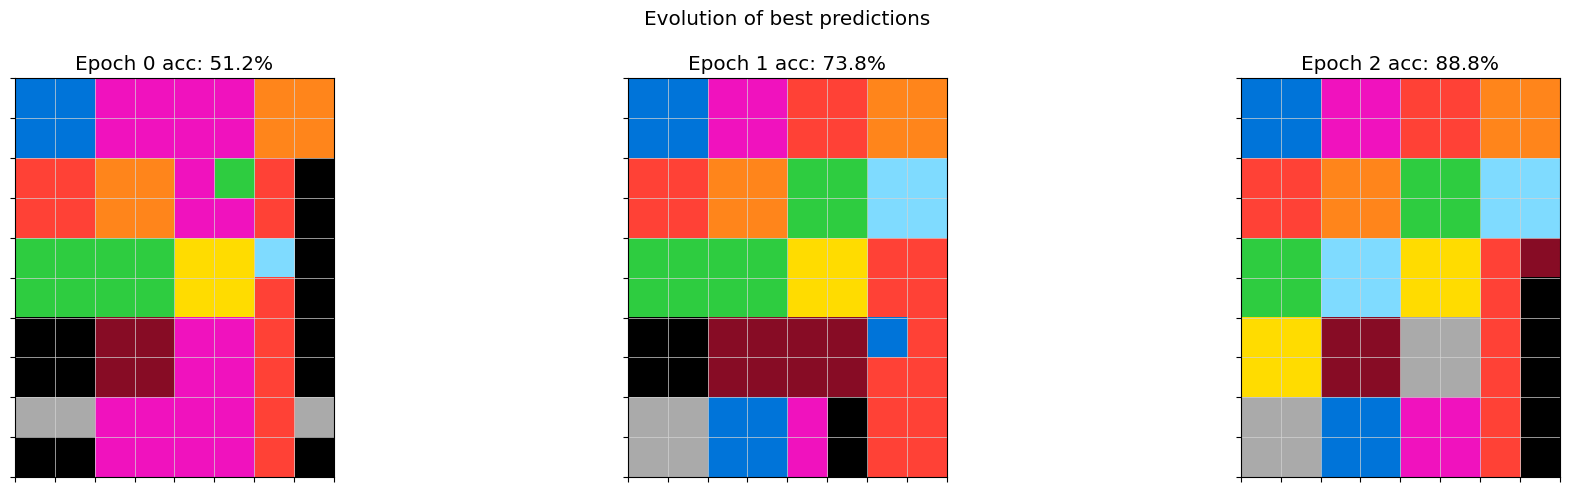

2025-05-07 15:21:06,222 - root - INFO - hindsight_experience_replay - Shuffling the tasks, no information about the accuracy is used
2025-05-07 15:21:06,223 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 15:21:06,308 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/243 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/243 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/243 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/243 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 243
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 15:21:52,485 - arc25.logging - INFO - wrapper - Executed finetuning in 46.2619 seconds
2025-05-07 15:21:52,487 - root - INFO - hindsight_experience_replay - Starting epoch 3...
2025-05-07 15:21:52,488 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 15:22:55,481 - root - INFO - inference - Number of unique outputs: 238/256
2025-05-07 15:22:55,486 - root - INFO - inference - Max pixel accuracy: 0.925
2025-05-07 15:22:55,492 - arc25.logging - INFO - wrapper - Executed inference in 63.0037 seconds


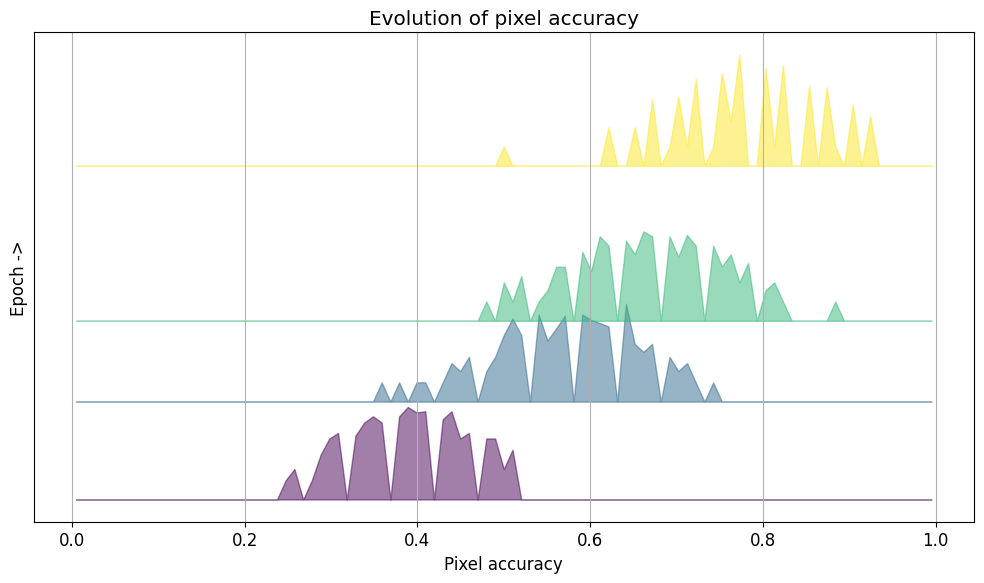

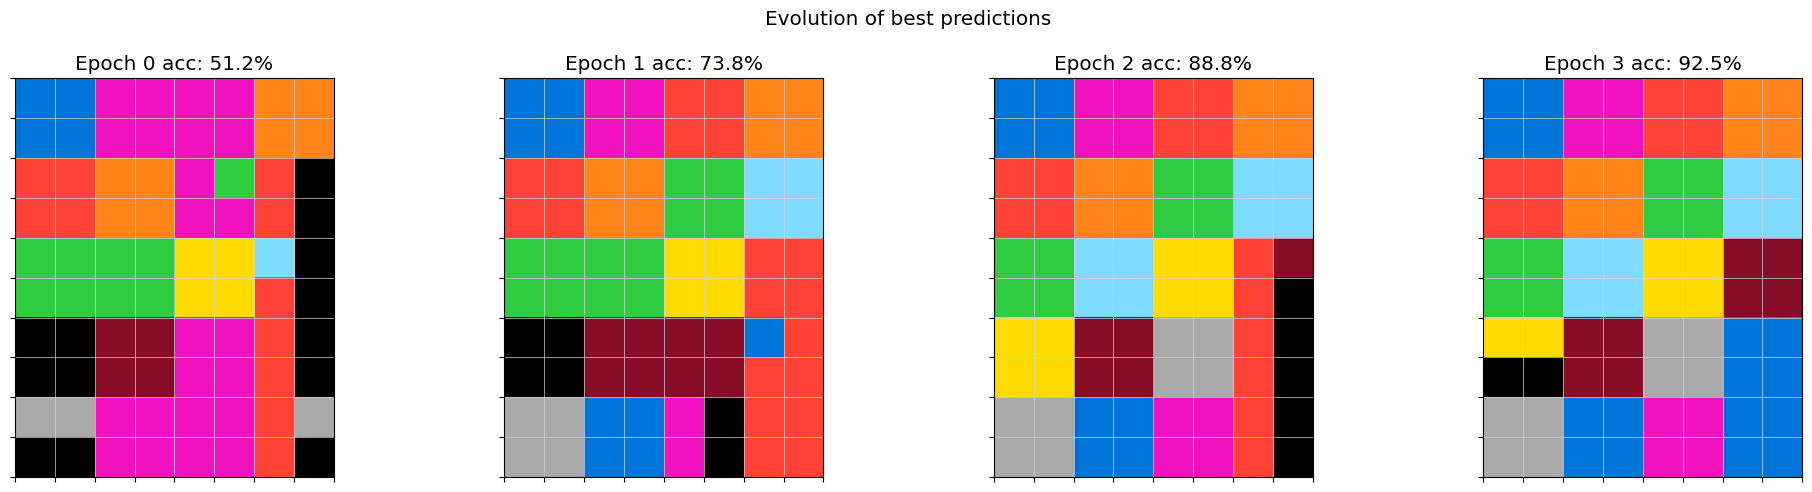

2025-05-07 15:22:55,847 - root - INFO - hindsight_experience_replay - Shuffling the tasks, no information about the accuracy is used
2025-05-07 15:22:55,848 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 15:22:55,931 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/238 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/238 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/238 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/238 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 238
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 238
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 15:23:41,656 - arc25.logging - INFO - wrapper - Executed finetuning in 45.8080 seconds
2025-05-07 15:23:41,658 - root - INFO - hindsight_experience_replay - Starting epoch 4...
2025-05-07 15:23:41,659 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 15:24:47,224 - root - INFO - inference - Number of unique outputs: 119/254
2025-05-07 15:24:47,235 - root - INFO - inference - Max pixel accuracy: 0.975
2025-05-07 15:24:47,238 - arc25.logging - INFO - wrapper - Executed inference in 65.5781 seconds


Error executing code: def task(img):
    draw_rectangle(img, point1=(0, 0), point2=(1, 7), color=1)
    draw_horizontal_line(img, y=6, color=4)
    draw_rectangle(img, point1=(0, 4), point2=(9, 7), color=2)
    draw_rectangle(img, point1=(8, 2), point2=(9, 3), color=1)
    draw_rectangle(img, point1=(0, 2), point2=(1, 5), color=6)
    draw_rectangle(img, point1=(2, 0), point2=(3, 3), color=2)
    draw_rectangle(img, point1=(2, 4), point2=(3, 5), color=3)
    draw_rectangle(img, point1=(4, 0), point2=(5, 1), color=3)
    draw_rectangle(img, point1=(2, 2), point2=(3, 3), color=7)
    draw_rectangle(img, point1=(4, 4), point2=(5, 5), color=4)
    draw_rectangle(img, point1=(6, 2), point2=(7, 3), color=9)
    draw_rectangle(img, point1=(2, 6), point2=(3, 7), color=8)
    draw_rectangle(img, point1=(6, 4), point2=(7, 5), color=5)
    draw_rectangle(img, point1=(0, 6), point2=(1, 7), color=7)
    draw_rectangle(img, point1=(4, 2), point2=(5, 3), color=8)
    draw_rectangle(img, point1=(6, 6)

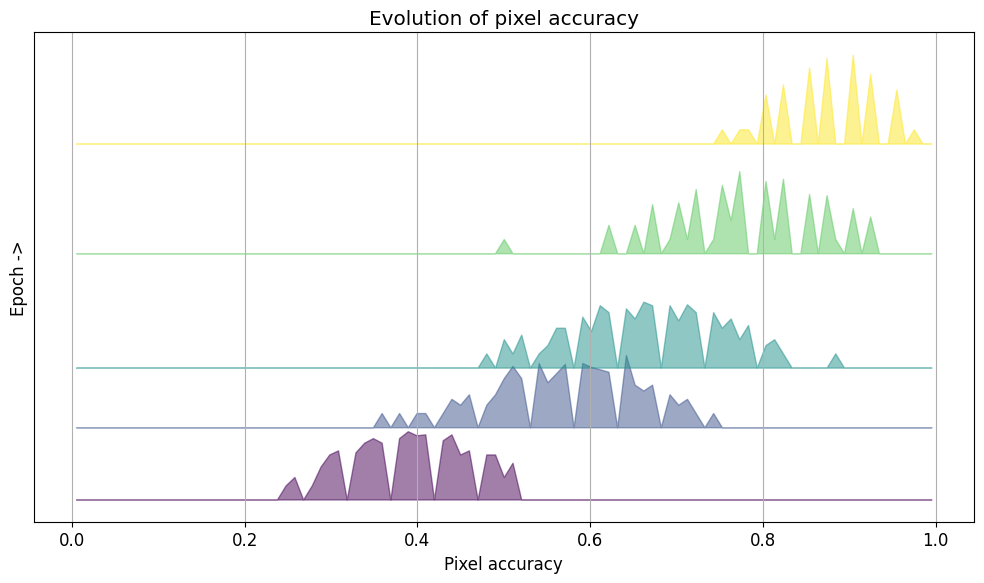

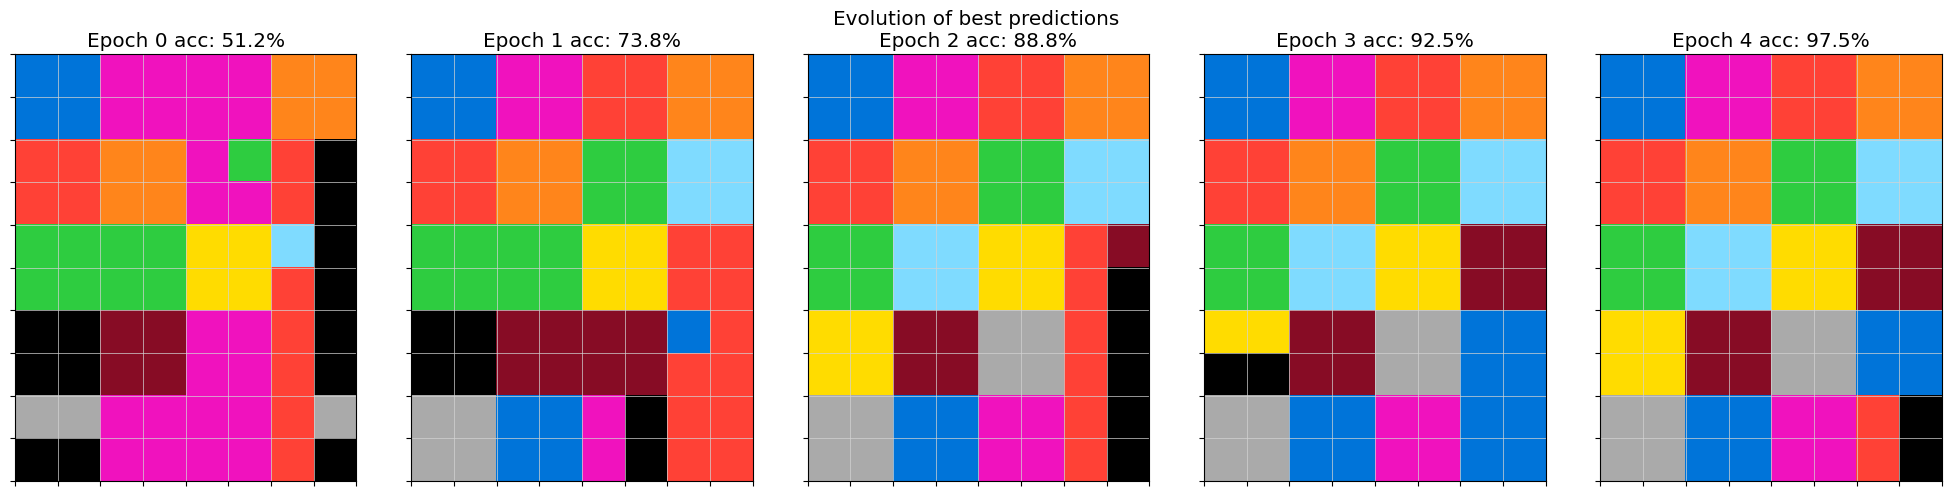

2025-05-07 15:24:47,772 - root - INFO - hindsight_experience_replay - Shuffling the tasks, no information about the accuracy is used
2025-05-07 15:24:47,773 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 15:24:47,862 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/119 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/119 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/119 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/119 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 119
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 119
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 15:25:11,101 - arc25.logging - INFO - wrapper - Executed finetuning in 23.3278 seconds
2025-05-07 15:25:11,102 - root - INFO - hindsight_experience_replay - Starting epoch 5...
2025-05-07 15:25:11,103 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 15:26:15,276 - root - INFO - inference - Number of unique outputs: 65/256
2025-05-07 15:26:15,288 - root - INFO - inference - Max pixel accuracy: 1.0
2025-05-07 15:26:15,291 - arc25.logging - INFO - wrapper - Executed inference in 64.1869 seconds


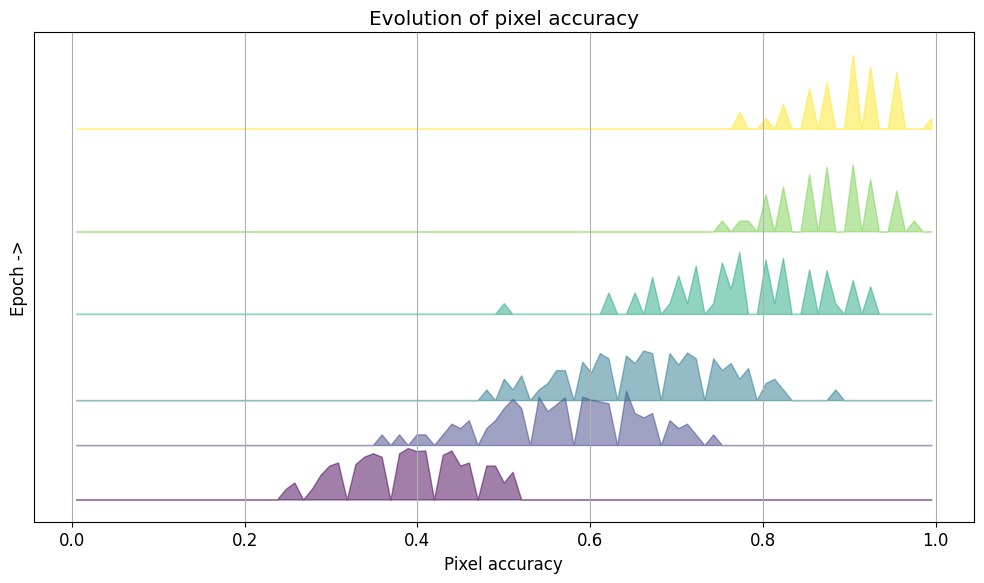

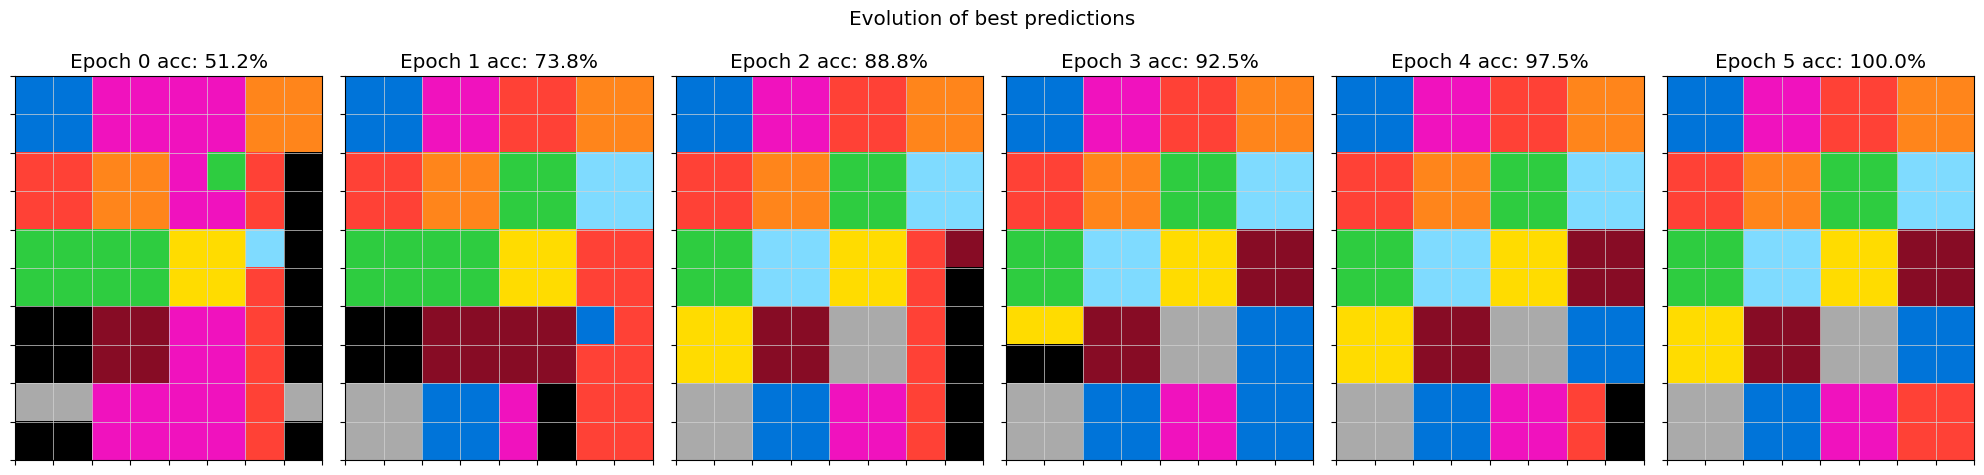

2025-05-07 15:26:15,898 - arc25.input_generation - INFO - hindsight_experience_replay - Found a perfect prediction at epoch 5!


# Best prediction code

```python
def task(img):
    draw_rectangle(img, point1=(0, 0), point2=(1, 7), color=1)
    draw_rectangle(img, point1=(0, 4), point2=(9, 7), color=2)
    draw_rectangle(img, point1=(8, 0), point2=(9, 1), color=5)
    draw_rectangle(img, point1=(0, 2), point2=(9, 5), color=6)
    draw_rectangle(img, point1=(2, 0), point2=(3, 3), color=2)
    draw_rectangle(img, point1=(2, 4), point2=(3, 5), color=3)
    draw_rectangle(img, point1=(2, 2), point2=(3, 3), color=7)
    draw_rectangle(img, point1=(4, 0), point2=(5, 1), color=3)
    draw_rectangle(img, point1=(6, 2), point2=(7, 3), color=9)
    draw_rectangle(img, point1=(0, 6), point2=(1, 7), color=7)
    draw_rectangle(img, point1=(4, 4), point2=(5, 5), color=4)
    draw_rectangle(img, point1=(6, 0), point2=(7, 1), color=4)
    draw_rectangle(img, point1=(6, 4), point2=(7, 5), color=5)
    draw_rectangle(img, point1=(2, 6), point2=(3, 7), color=8)
    draw_rectangle(img, point1=(8, 2), point2=(9, 3), color=1)
    draw_rectangle(img, point1=(4, 2), point2=(5, 3), color=8)
    draw_rectangle(img, point1=(6, 6), point2=(7, 7), color=1)
    draw_rectangle(img, point1=(0, 4), point2=(1, 5), color=2)
    draw_rectangle(img, point1=(4, 6), point2=(5, 7), color=9)
    return img
```

2025-05-07 15:26:15,952 - arc25.logging - INFO - wrapper - Executed hindsight_experience_replay in 571.1747 seconds


In [6]:
input_img = create_img((10, 8), color=0)
output_img = input_img.copy()
color = 0
for x in range(0, input_img.shape[1], 2):
    for y in range(0, input_img.shape[0], 2):
        color = (color + 1) % 10
        if color == 0: color = 1
        draw_rectangle(output_img, (y, x), (y+1, x+1), color=color)
task = Task(inputs=[input_img], outputs=[output_img], code='', name='manual')
metrics = hindsight_experience_replay(task, Config(use_accuracy_for_sorting=False))

### 25 squares

2025-05-07 15:28:56,289 - arc25.logging - INFO - wrapper - Executing hindsight_experience_replay...


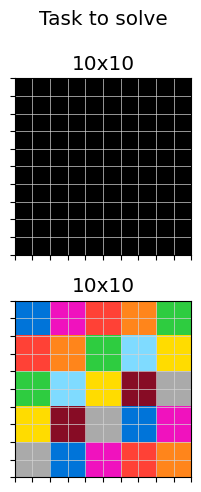

2025-05-07 15:28:56,442 - arc25.logging - INFO - wrapper - Executing load_model...
2025-05-07 15:28:56,443 - root - INFO - load_model - Loading model from /home/gbarbadillo/models/Qwen2.5-Coder-0.5B-Instruct and LoRA from /mnt/hdd0/Kaggle/arc25/trainings/20250430_first_trainings/steps_6400/checkpoint-6400
loading configuration file /home/gbarbadillo/models/Qwen2.5-Coder-0.5B-Instruct/config.json
Model config Qwen2Config {
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "eos_token_id": 151645,
  "hidden_act": "silu",
  "hidden_size": 896,
  "initializer_range": 0.02,
  "intermediate_size": 4864,
  "max_position_embeddings": 32768,
  "max_window_layers": 24,
  "model_type": "qwen2",
  "num_attention_heads": 14,
  "num_hidden_layers": 24,
  "num_key_value_heads": 2,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 1000000.0,
  "sliding_window": 32768,
  "tie_word_embeddings": true,
  "torch_dtype": "bfloat16",
  "tra

  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 15:29:42,148 - root - INFO - inference - Number of unique outputs: 247/247


Error executing code: def task(img):
    draw_horizontal_line(img, y=8, height=5)
    draw_rectangle(img, point1=(0, 0), point2=(9, 3), color=1)
    draw_rectangle(img, point1=(0, 4), point2=(9, 8), color=2)
    draw_horizontal_line(img, y=6, color=4)
    draw_vertical_line(img, x=6, color=6)
    draw_rectangle(img, point1=(2, 0), point2=(3, 9), color=2)
    draw_rectangle(img, point1=(4, 2), point2=(5, 8), color=8)
    draw_pixel(img, point=(2, 6), color=8)
    draw_rectangle(img, point1=(4, 4), point2=(5, 5), color=3)
    return img
draw_horizontal_line() got an unexpected keyword argument 'height'
Error executing code: def task(img):
    draw_rectangle(img, point1=(0, 0), point2=(9, 9), color=1)
    draw_rectangle(img, point1=(4, 0), point2=(5, 3), color=3)
    draw_rectangle(img, point1=(0, 4), point2=(9, 7), color=2)
    draw_rectangle(img, point1=(2, 0), point2=(3, 5), color=2)
    draw_vertical_line(img, x=8, color=7)
    draw_rectangle(img, point1=(2, 6), point2=(5, 7), color=8

2025-05-07 15:29:42,153 - root - INFO - inference - Max pixel accuracy: 0.45
2025-05-07 15:29:42,166 - arc25.logging - INFO - wrapper - Executed inference in 44.2189 seconds


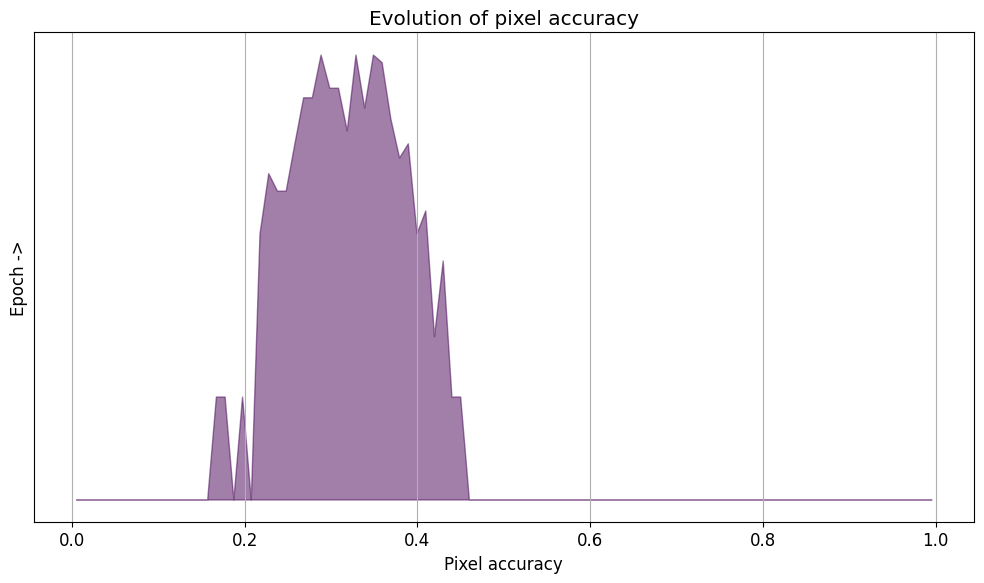

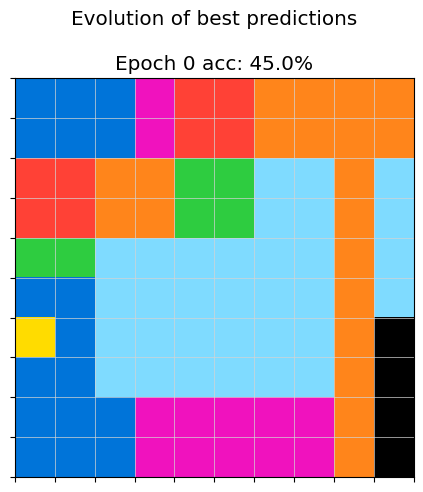

2025-05-07 15:29:42,325 - root - INFO - hindsight_experience_replay - Shuffling the tasks, no information about the accuracy is used
2025-05-07 15:29:42,326 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 15:29:42,416 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/247 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/247 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/247 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/247 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 247
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 247
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 15:30:32,354 - arc25.logging - INFO - wrapper - Executed finetuning in 50.0274 seconds
2025-05-07 15:30:32,357 - root - INFO - hindsight_experience_replay - Starting epoch 1...
2025-05-07 15:30:32,358 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 15:31:51,561 - root - INFO - inference - Number of unique outputs: 256/256
2025-05-07 15:31:51,564 - root - INFO - inference - Max pixel accuracy: 0.72
2025-05-07 15:31:51,572 - arc25.logging - INFO - wrapper - Executed inference in 79.2131 seconds


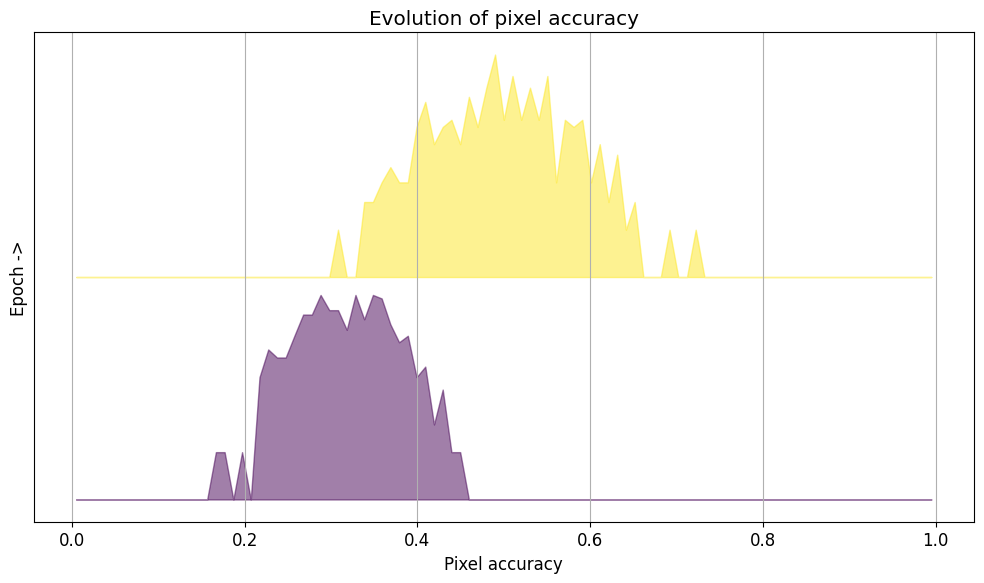

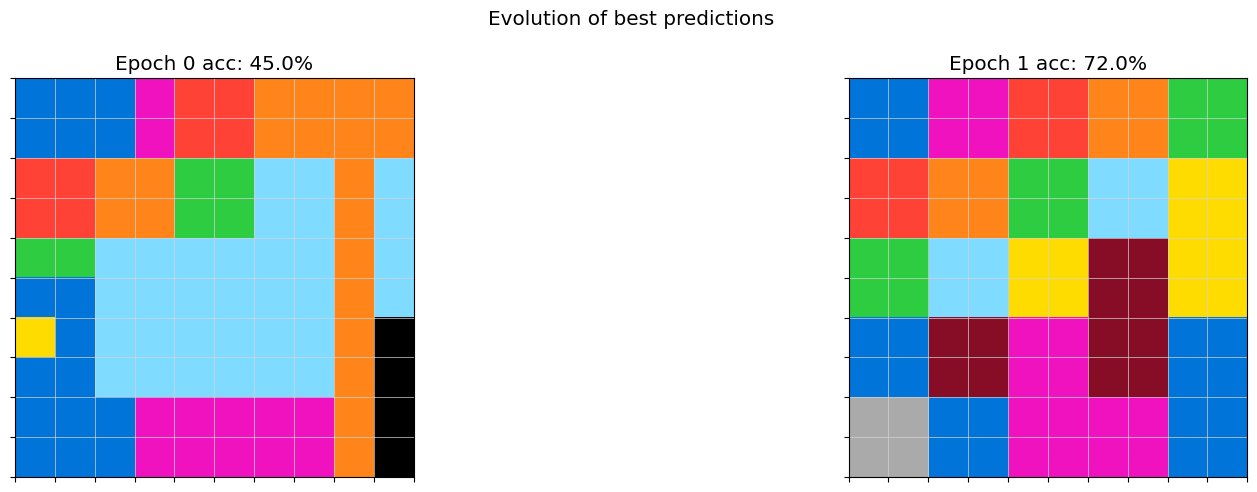

2025-05-07 15:31:51,828 - root - INFO - hindsight_experience_replay - Shuffling the tasks, no information about the accuracy is used
2025-05-07 15:31:51,828 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 15:31:51,928 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/256 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 256
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 256
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 15:32:41,858 - arc25.logging - INFO - wrapper - Executed finetuning in 50.0291 seconds
2025-05-07 15:32:41,859 - root - INFO - hindsight_experience_replay - Starting epoch 2...
2025-05-07 15:32:41,859 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 15:33:54,773 - root - INFO - inference - Number of unique outputs: 256/256
2025-05-07 15:33:54,779 - root - INFO - inference - Max pixel accuracy: 0.8
2025-05-07 15:33:54,783 - arc25.logging - INFO - wrapper - Executed inference in 72.9242 seconds


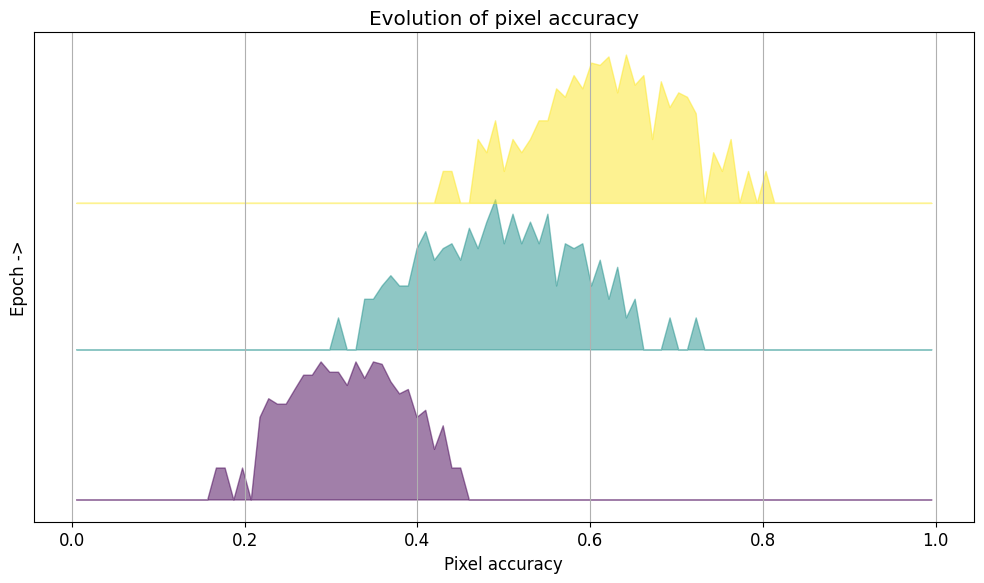

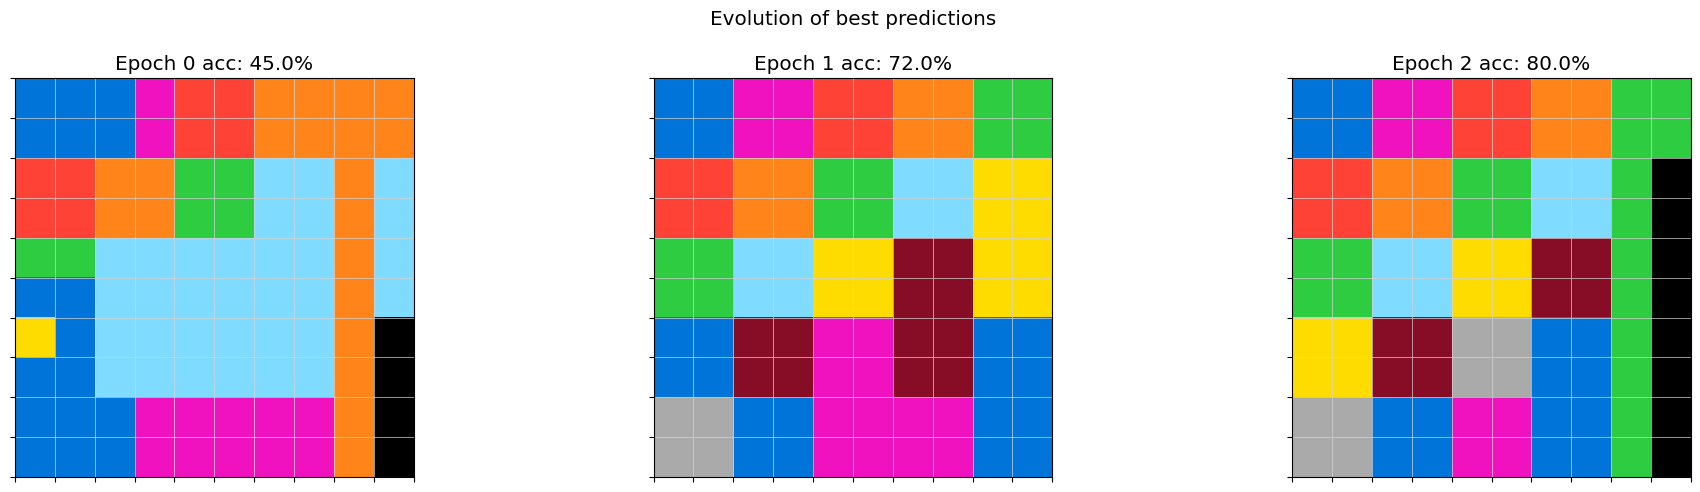

2025-05-07 15:33:55,142 - root - INFO - hindsight_experience_replay - Shuffling the tasks, no information about the accuracy is used
2025-05-07 15:33:55,143 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 15:33:55,253 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/256 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 256
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 256
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 15:34:46,636 - arc25.logging - INFO - wrapper - Executed finetuning in 51.4923 seconds
2025-05-07 15:34:46,638 - root - INFO - hindsight_experience_replay - Starting epoch 3...
2025-05-07 15:34:46,639 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 15:36:00,539 - root - INFO - inference - Number of unique outputs: 255/256
2025-05-07 15:36:00,543 - root - INFO - inference - Max pixel accuracy: 0.86
2025-05-07 15:36:00,552 - arc25.logging - INFO - wrapper - Executed inference in 73.9122 seconds


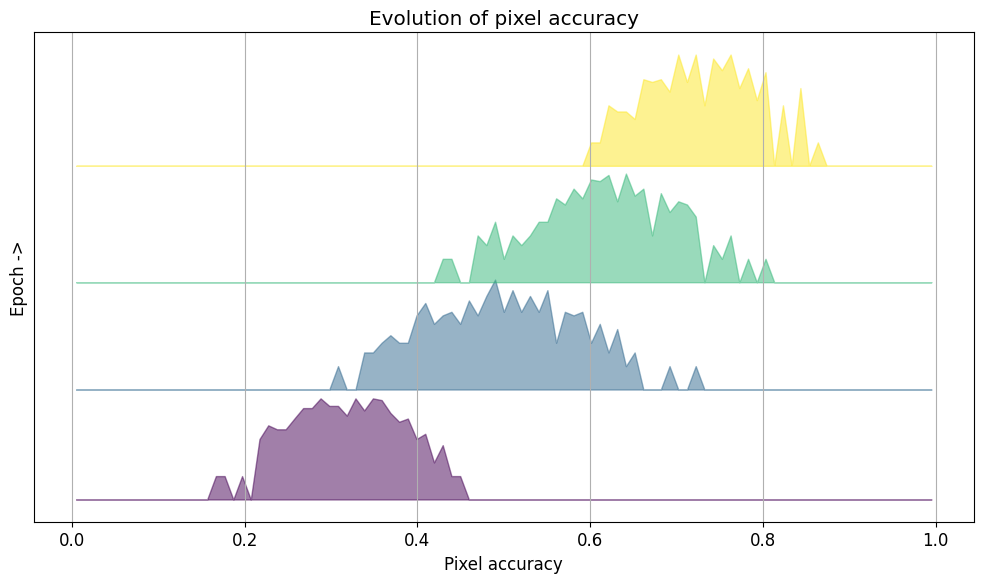

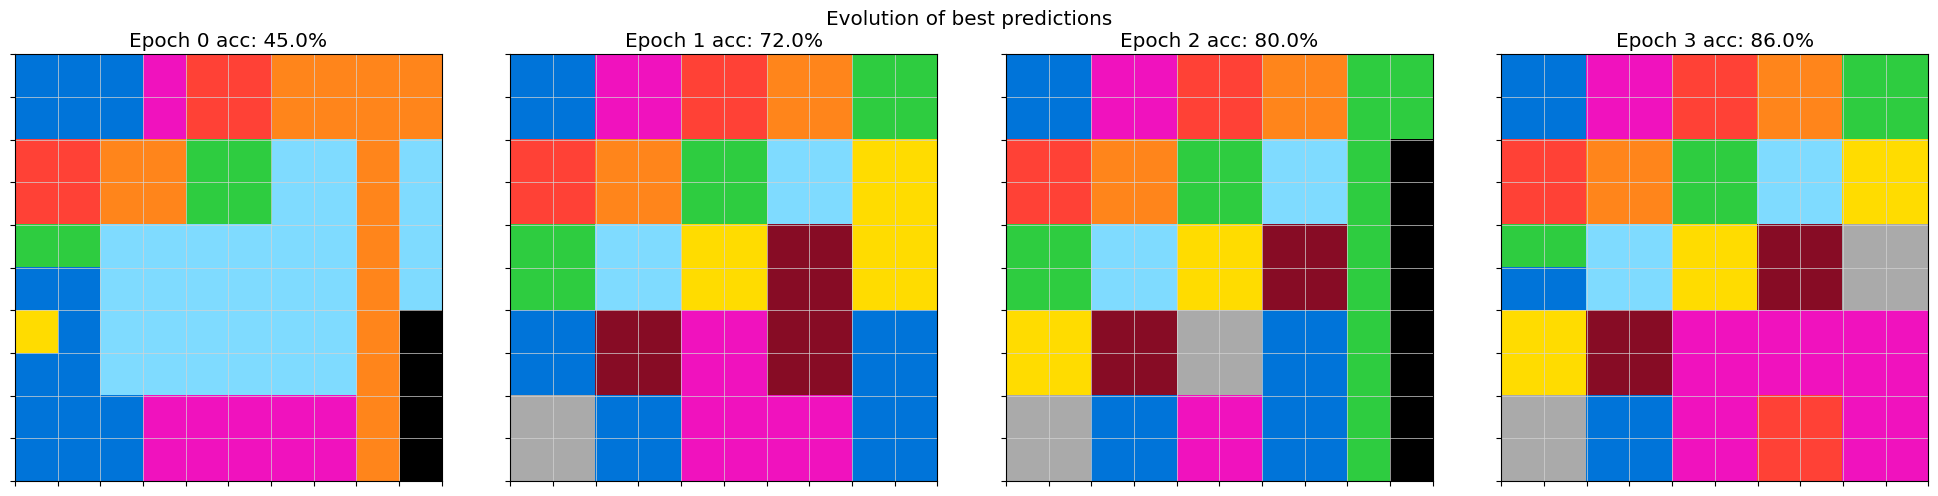

2025-05-07 15:36:00,931 - root - INFO - hindsight_experience_replay - Shuffling the tasks, no information about the accuracy is used
2025-05-07 15:36:00,932 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 15:36:01,011 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/255 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/255 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/255 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/255 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 255
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 255
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 15:36:50,502 - arc25.logging - INFO - wrapper - Executed finetuning in 49.5702 seconds
2025-05-07 15:36:50,504 - root - INFO - hindsight_experience_replay - Starting epoch 4...
2025-05-07 15:36:50,505 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 15:38:17,768 - root - INFO - inference - Number of unique outputs: 160/256
2025-05-07 15:38:17,776 - root - INFO - inference - Max pixel accuracy: 0.96
2025-05-07 15:38:17,783 - arc25.logging - INFO - wrapper - Executed inference in 87.2773 seconds


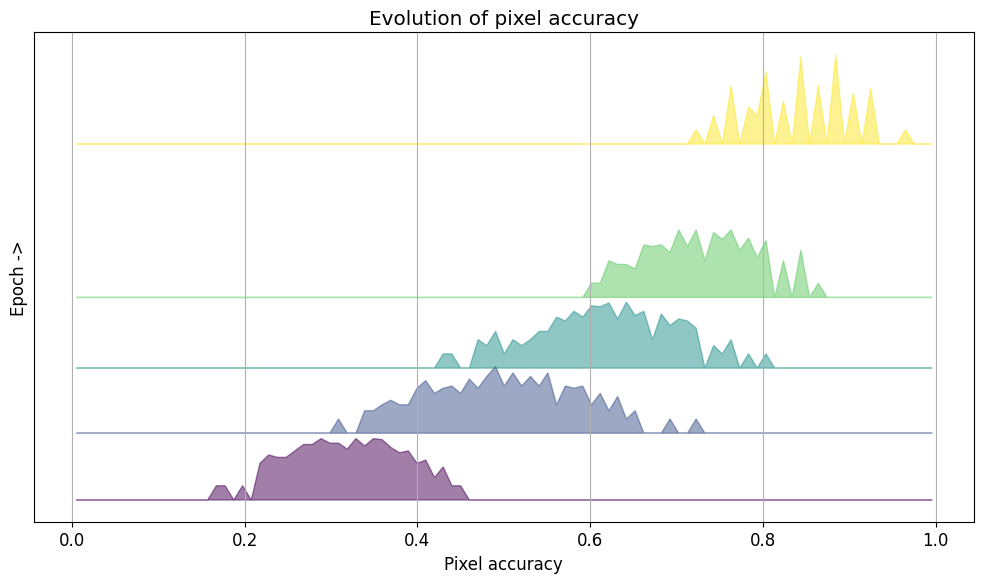

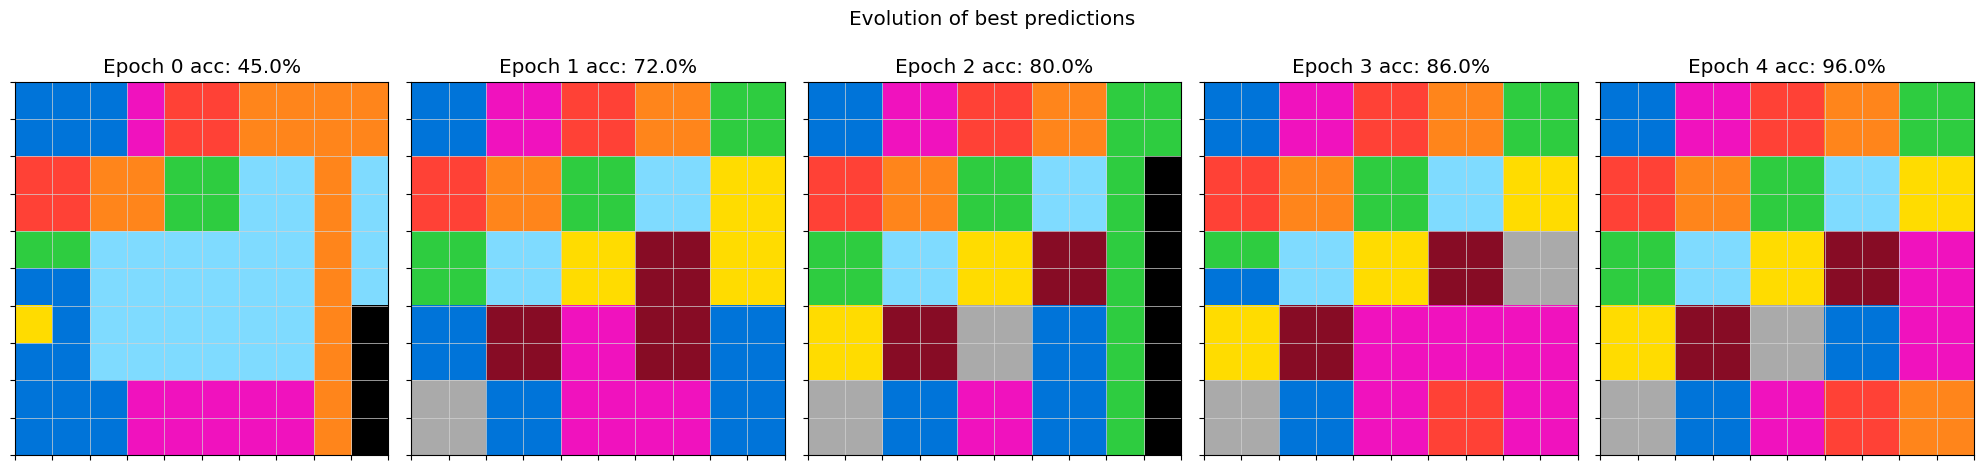

2025-05-07 15:38:18,313 - root - INFO - hindsight_experience_replay - Shuffling the tasks, no information about the accuracy is used
2025-05-07 15:38:18,314 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 15:38:18,391 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/160 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/160 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/160 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/160 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 160
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 160
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 15:38:51,281 - arc25.logging - INFO - wrapper - Executed finetuning in 32.9660 seconds
2025-05-07 15:38:51,282 - root - INFO - hindsight_experience_replay - Starting epoch 5...
2025-05-07 15:38:51,282 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 15:40:14,034 - root - INFO - inference - Number of unique outputs: 51/256
2025-05-07 15:40:14,039 - root - INFO - inference - Max pixel accuracy: 0.96
2025-05-07 15:40:14,048 - arc25.logging - INFO - wrapper - Executed inference in 82.7650 seconds


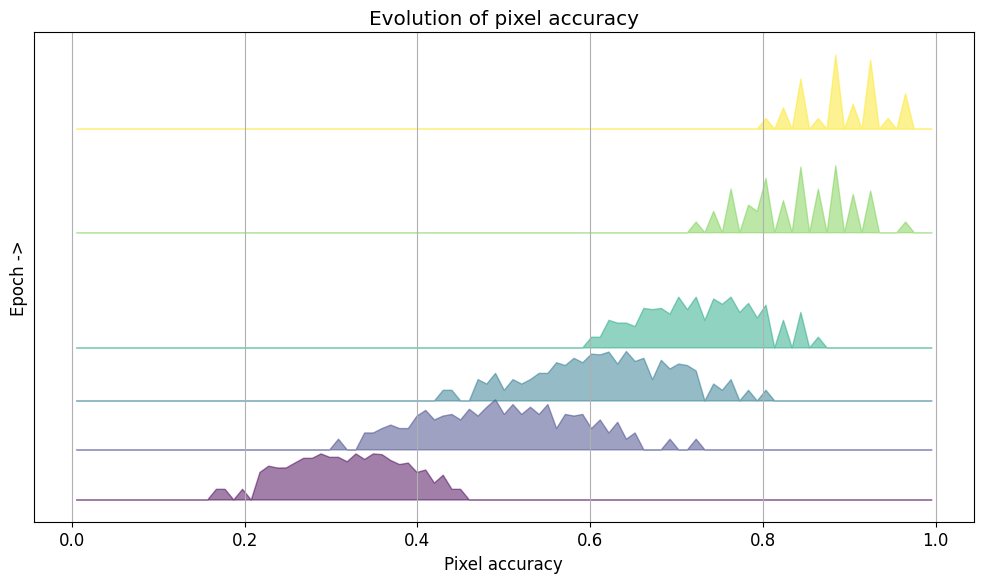

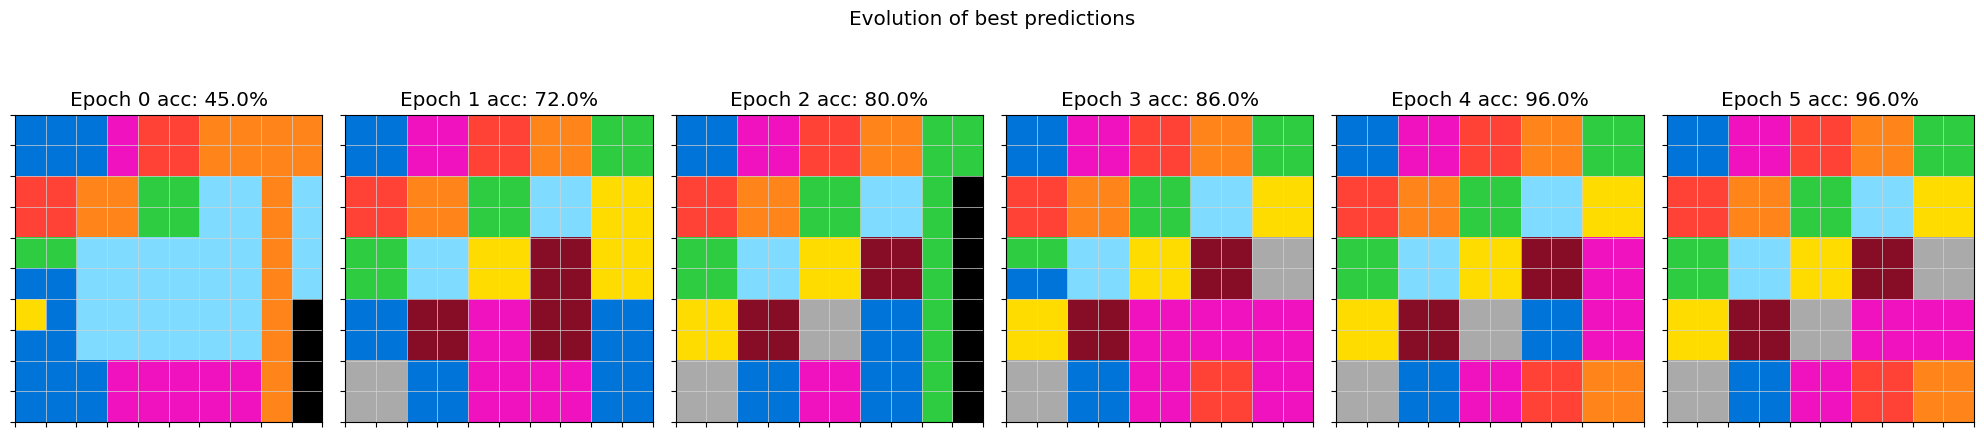

2025-05-07 15:40:14,564 - root - INFO - hindsight_experience_replay - Shuffling the tasks, no information about the accuracy is used
2025-05-07 15:40:14,565 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-07 15:40:14,636 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/51 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/51 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/51 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/51 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 51
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 51
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-07 15:40:25,291 - arc25.logging - INFO - wrapper - Executed finetuning in 10.7250 seconds
2025-05-07 15:40:25,292 - root - INFO - hindsight_experience_replay - Starting epoch 6...
2025-05-07 15:40:25,293 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-07 15:41:50,993 - root - INFO - inference - Number of unique outputs: 37/255
2025-05-07 15:41:51,007 - root - INFO - inference - Max pixel accuracy: 1.0
2025-05-07 15:41:51,018 - arc25.logging - INFO - wrapper - Executed inference in 85.7239 seconds


Error executing code: def task(img):
    draw_rectangle(img, point1=(0, 0), point2=(9, 7), color=1)
    draw_horizontal_line(img, y=4, color=5)
    draw_rectangle(img, point1=(0, 4), point2=(9, 9), color=6)
    draw_rectangle(img, point1=(0, 2), point2=(1, 3), color=6)
    draw_rectangle(img, point1=(0, 4), point2=(1, 5), color=2)
    draw_rectangle(img, point1=(0, 6), point2=(1, 9), color=7)
    draw_rectangle(img, point1=(2, 0), point2=(3, 1), color=2)
    draw_rectangle(img, point1=(2, 4), point2=(5, 5), color=3)
    draw_rectangle(img, point1=(2, 6), point2=(3, 7), color=8)
    draw_rectangle(img, point1=(2, 2), point2=(3, 3), color=7)
    draw_rectangle(img, point1=(4, 0), point2=(5, 1), color=3)
    draw_rectangle(img, point1=(4, 2), point2=(7, 3), color=8)
    draw_rectangle(img, point1=(4, 4), point2=(5, 5), color=4)
    draw_rectangle(img, point1=(6, 0), point2=(7, 1), color=4)
    draw_rectangle(img, point1=(8, 0), point2=(9, 1), color=5)
    draw_rectangle(img, point1=(6, 2)

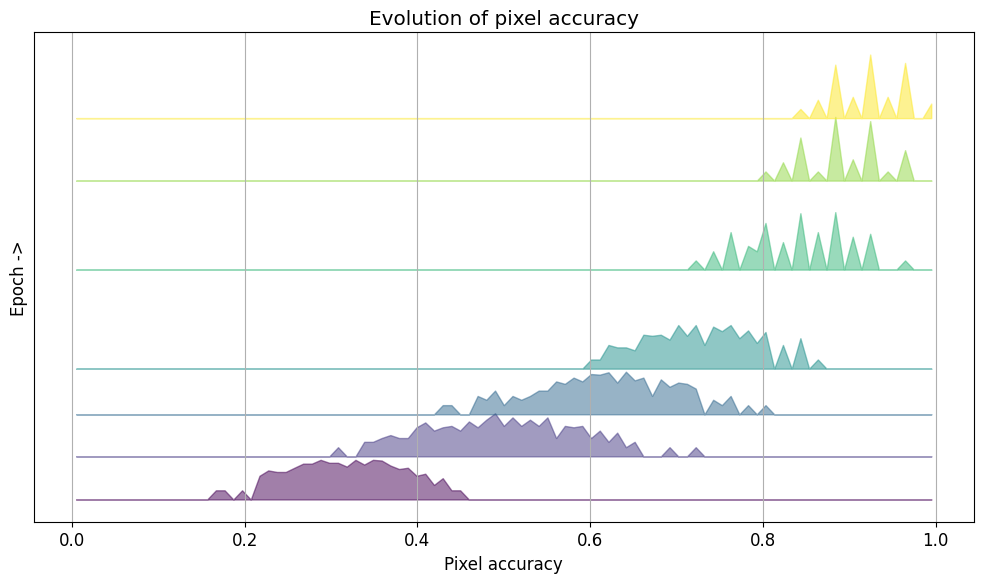

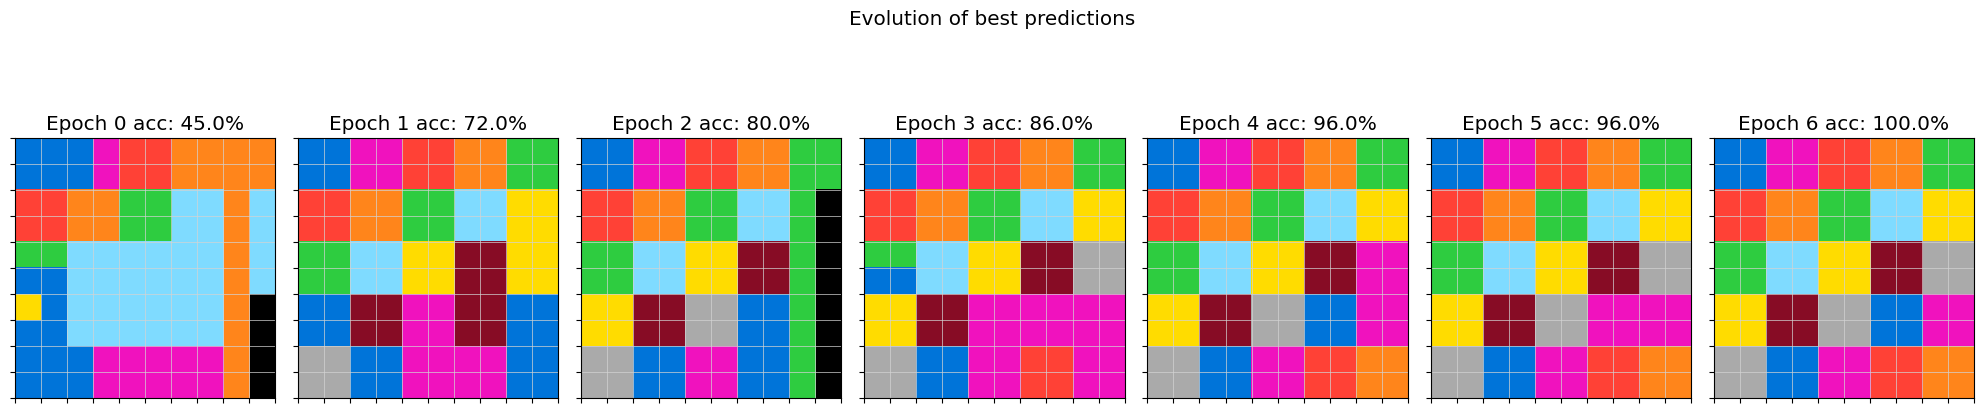

2025-05-07 15:41:51,586 - arc25.input_generation - INFO - hindsight_experience_replay - Found a perfect prediction at epoch 6!


# Best prediction code

```python
def task(img):
    draw_rectangle(img, point1=(0, 0), point2=(9, 7), color=1)
    draw_rectangle(img, point1=(0, 4), point2=(9, 9), color=6)
    draw_rectangle(img, point1=(0, 2), point2=(1, 3), color=6)
    draw_rectangle(img, point1=(0, 4), point2=(1, 5), color=2)
    draw_rectangle(img, point1=(0, 6), point2=(1, 9), color=7)
    draw_rectangle(img, point1=(0, 8), point2=(1, 9), color=3)
    draw_rectangle(img, point1=(2, 0), point2=(3, 1), color=2)
    draw_rectangle(img, point1=(2, 4), point2=(5, 5), color=3)
    draw_rectangle(img, point1=(2, 2), point2=(3, 3), color=7)
    draw_rectangle(img, point1=(2, 6), point2=(3, 7), color=8)
    draw_rectangle(img, point1=(4, 0), point2=(5, 1), color=3)
    draw_rectangle(img, point1=(4, 2), point2=(7, 3), color=8)
    draw_rectangle(img, point1=(6, 0), point2=(7, 1), color=4)
    draw_rectangle(img, point1=(6, 2), point2=(7, 3), color=9)
    draw_rectangle(img, point1=(8, 0), point2=(9, 1), color=5)
    draw_rectangle(img, point1=(8, 6), point2=(9, 7), color=2)
    draw_rectangle(img, point1=(8, 8), point2=(9, 9), color=7)
    draw_rectangle(img, point1=(4, 4), point2=(5, 5), color=4)
    draw_rectangle(img, point1=(4, 6), point2=(5, 7), color=9)
    draw_rectangle(img, point1=(2, 8), point2=(3, 9), color=4)
    draw_rectangle(img, point1=(6, 4), point2=(7, 5), color=5)
    draw_rectangle(img, point1=(6, 6), point2=(7, 7), color=1)
    draw_rectangle(img, point1=(4, 8), point2=(5, 9), color=5)
    return img
```

2025-05-07 15:41:51,642 - arc25.logging - INFO - wrapper - Executed hindsight_experience_replay in 775.3508 seconds


In [7]:
input_img = create_img((10, 10), color=0)
output_img = input_img.copy()
color = 0
for x in range(0, input_img.shape[1], 2):
    for y in range(0, input_img.shape[0], 2):
        color = (color + 1) % 10
        if color == 0: color = 1
        draw_rectangle(output_img, (y, x), (y+1, x+1), color=color)
task = Task(inputs=[input_img], outputs=[output_img], code='', name='manual')
metrics = hindsight_experience_replay(task, Config(use_accuracy_for_sorting=False))

## Results

| batch size | inference time(s) | throughput (preds/s) |
|------------|-------------------|----------------------|
| 1          | 6.4               | 0.2                  |
| 4          | 7.4               | 0.5                  |
| 16         | 8.5               | 1.9                  |
| 64         | 9                 | 7.1                  |
| 128        | 10.9              | 11.7                 |
| 256        | 15.3              | 16.7                 |
| 512        | 30.1              | 17.0                 |

A batch size of 256 might be the sweet spot. It takes just twice as making two predictions with batch size 1.

## TODO

- Temperature sweep